# Atari Pong
Implemented the Proximal Policy Optimization.

In [3]:
!pip install JSAnimation

# custom utilies for displaying animation, collecting rollouts and more
import pong_utils

%matplotlib inline

# try GPU
device = pong_utils.device
print("using device: ",device)

using device:  cuda:0


In [4]:
import gym
import time

env = gym.make('PongDeterministic-v4')

# list of actions, only using leftfire and rightfire
print("List of available actions: ", env.unwrapped.get_action_meanings())

List of available actions:  ['NOOP', 'FIRE', 'RIGHT', 'LEFT', 'RIGHTFIRE', 'LEFTFIRE']


# Preprocessing
Down size, crop border, black and white

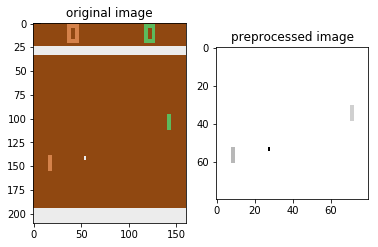

In [5]:
import matplotlib
import matplotlib.pyplot as plt

# get a frame after 20 steps
env.reset()
_, _, _, _ = env.step(0)
for _ in range(20):
    frame, _, _, _ = env.step(1)

plt.subplot(1,2,1)
plt.imshow(frame)
plt.title('original image')
plt.subplot(1,2,2)
plt.title('preprocessed image')

# 80*80*2 (2 channels to preserve temporal information)
plt.imshow(pong_utils.preprocess_single(frame), cmap='Greys')
plt.show()

# Policy

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# # the output is the probability of moving right
# class Policy(nn.Module):

#     def __init__(self):
#         super(Policy, self).__init__()
#         # classic double depth - halve space strategy
#         self.conv1 = nn.Conv2d(2, 4, kernel_size=2, stride=2)
#         self.conv2 = nn.Conv2d(4, 8, kernel_size=2, stride=2)
#         self.conv3 = nn.Conv2d(8, 16, kernel_size=2, stride=2)
#         self.conv4 = nn.Conv2d(16, 32, kernel_size=2, stride=2)
#         # get flatten dimensions
#         self.size = 32 * 5 * 5
#         # fully connected layers, divide neuron number by 8 each time
#         self.fc1 = nn.Linear(self.size, 64)
#         self.fc2 = nn.Linear(64, 8)
#         self.fc3 = nn.Linear(8, 1)
#         # determine left or right
#         self.sig = nn.Sigmoid()
        
#     def forward(self, x):
#         # conv
#         x = F.relu(self.conv1(x))
#         x = F.relu(self.conv2(x))
#         x = F.relu(self.conv3(x))
#         x = F.relu(self.conv4(x))
#         # flatten
#         x = x.view(-1,self.size)
#         # fc
#         x = F.relu(self.fc1(x))  
#         x = F.relu(self.fc2(x))  
#         x = self.sig(self.fc3(x))
#         return x

# policy = Policy().to(device)
# # policy = pong_utils.Policy().to(device)

# optimizer = optim.Adam(policy.parameters(), lr=0.0001)

class Policy(nn.Module):

    def __init__(self):
        super(Policy, self).__init__()
        # 80x80x2 to 38x38x4
        # 2 channel from the stacked frame
        self.conv1 = nn.Conv2d(2, 4, kernel_size=6, stride=2, bias=False)
        # 38x38x4 to 9x9x32
        self.conv2 = nn.Conv2d(4, 16, kernel_size=6, stride=4)
        self.size=9*9*16
        
        # two fully connected layer
        self.fc1 = nn.Linear(self.size, 256)
        self.fc2 = nn.Linear(256, 1)

        # Sigmoid to 
        self.sig = nn.Sigmoid()
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = x.view(-1,self.size)
        x = F.relu(self.fc1(x))
        return self.sig(self.fc2(x))
    
policy = Policy().to(device)
# policy = pong_utils.Policy().to(device)

optimizer = optim.Adam(policy.parameters(), lr=0.0001)

# Game visualization


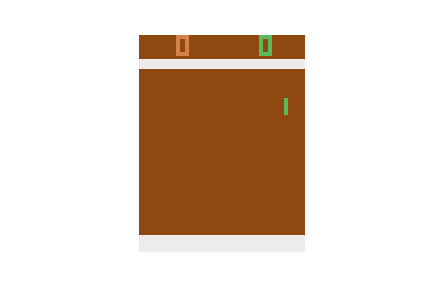
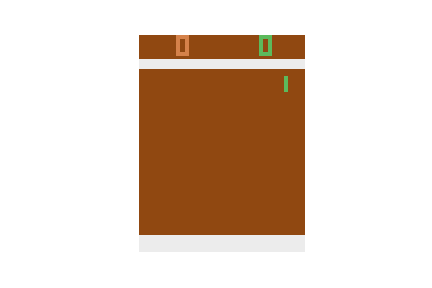
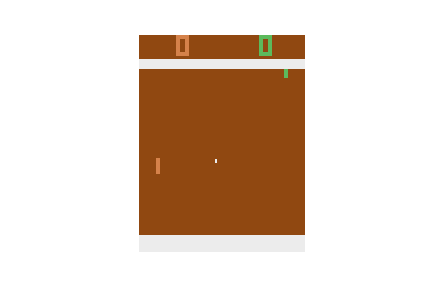
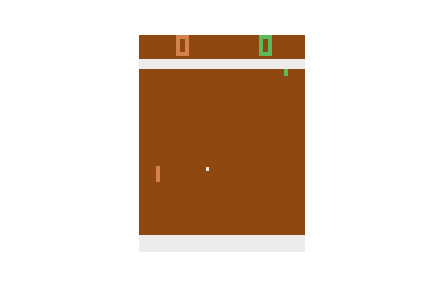
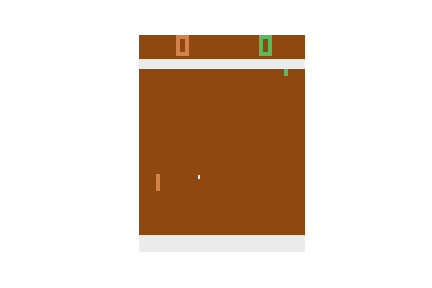
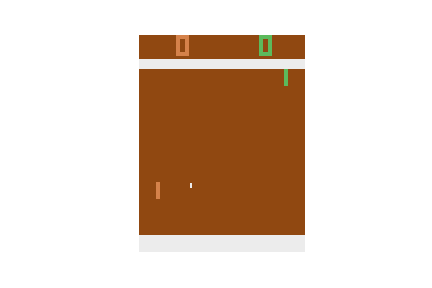
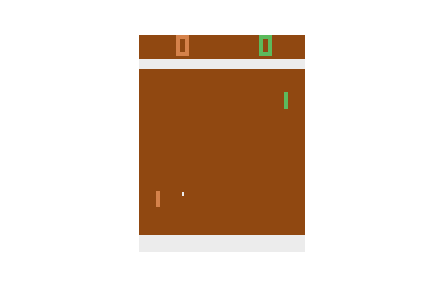
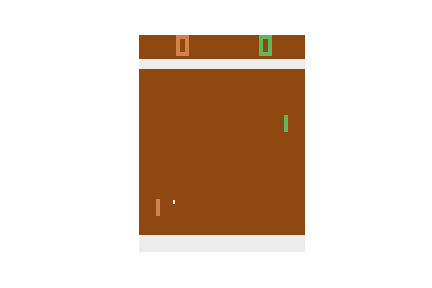
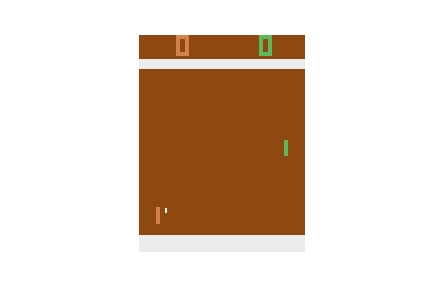
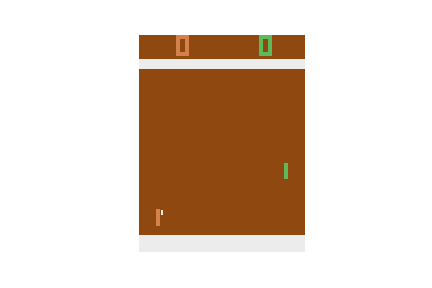
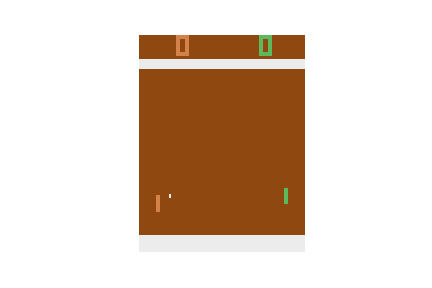
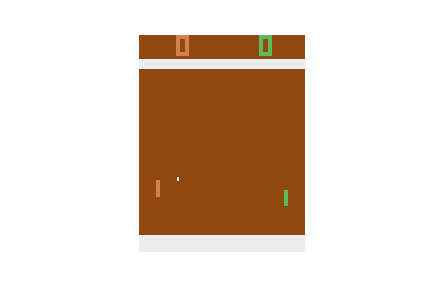
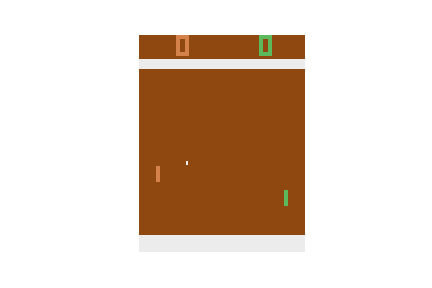
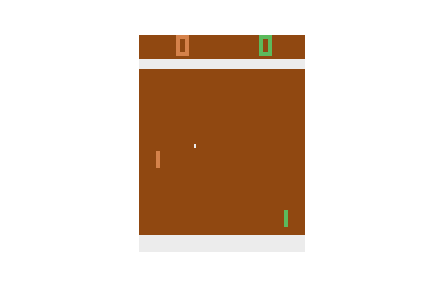
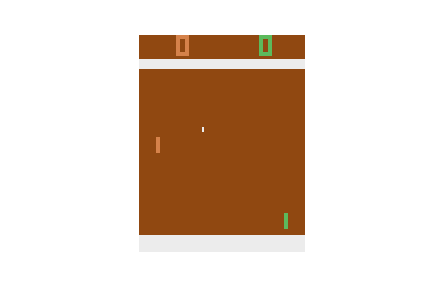
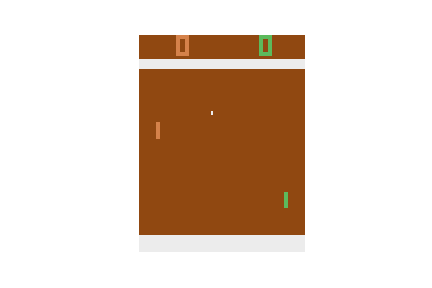
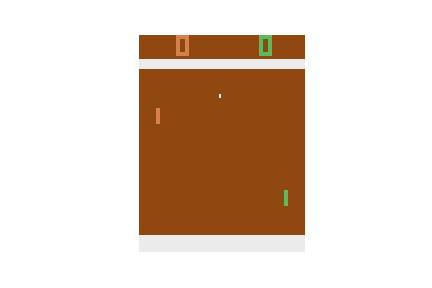
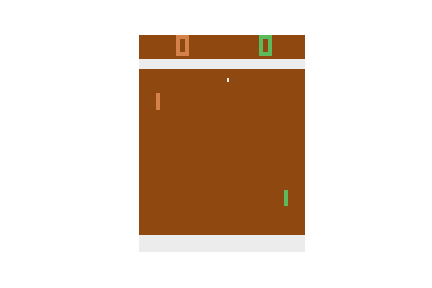
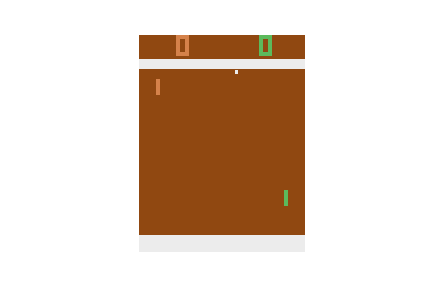
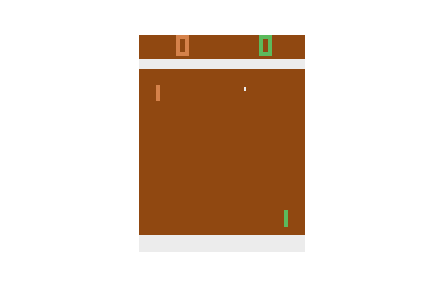
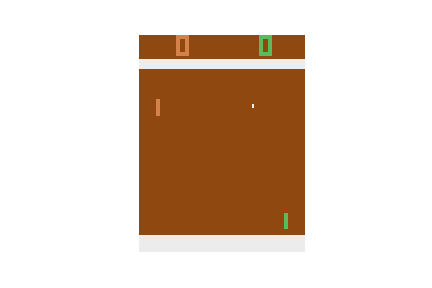
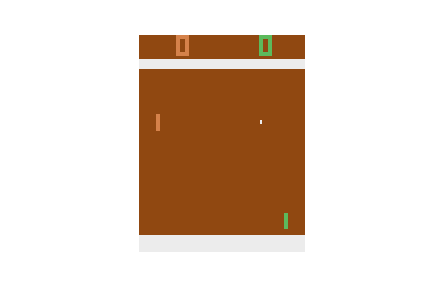
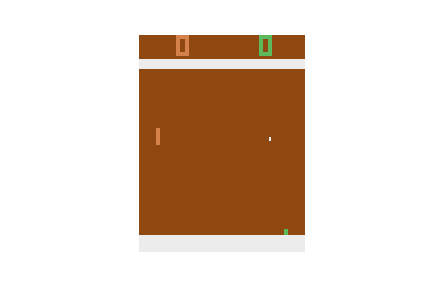
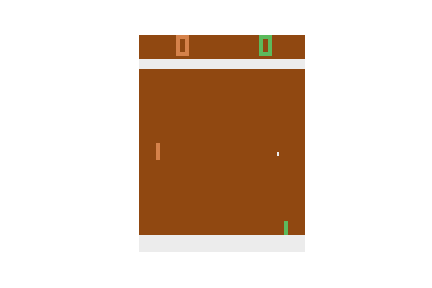
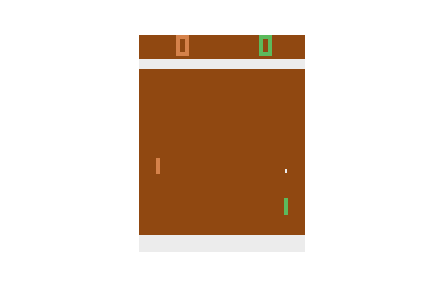
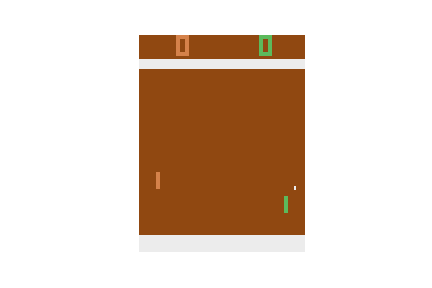
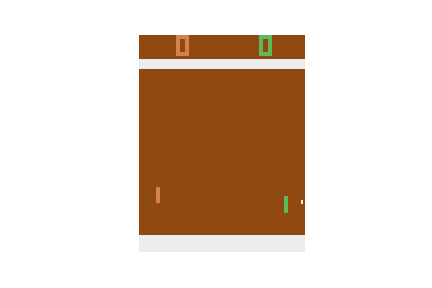
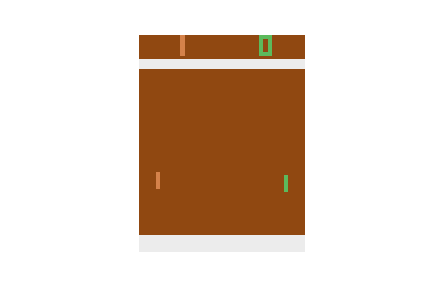
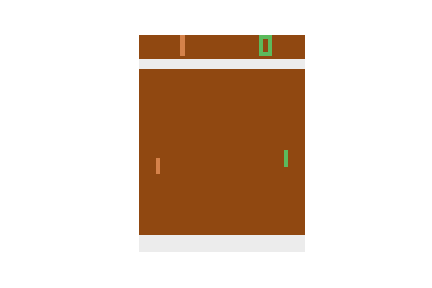
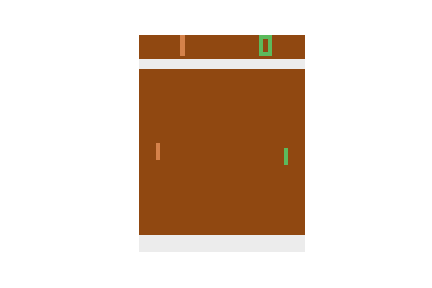
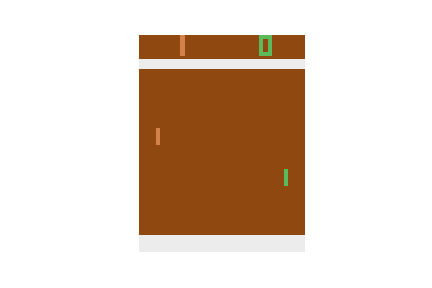
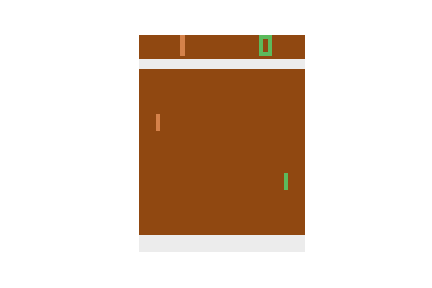
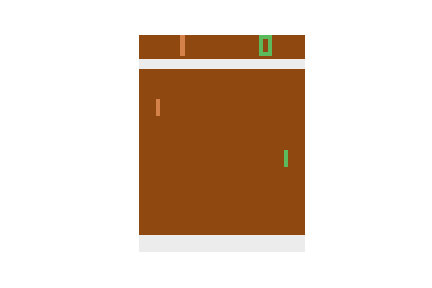
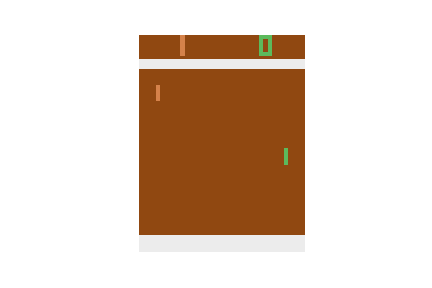
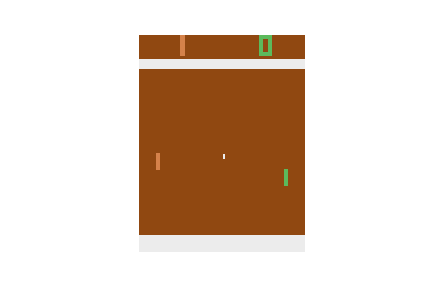
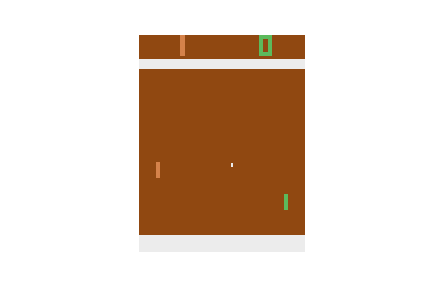
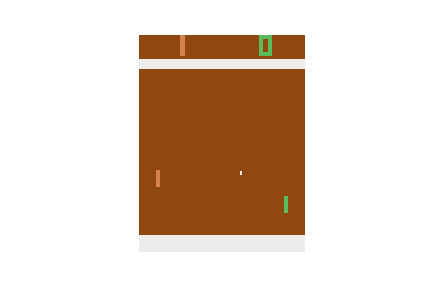
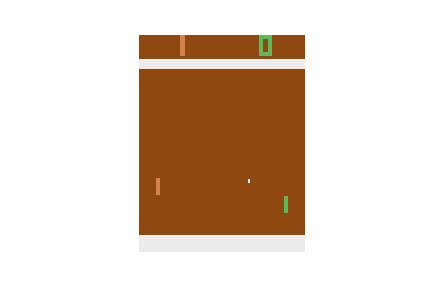
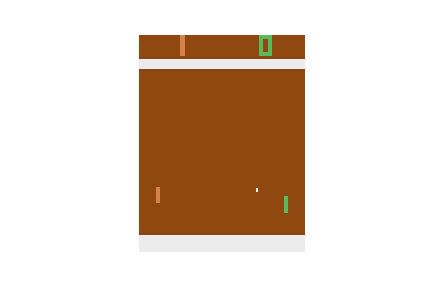
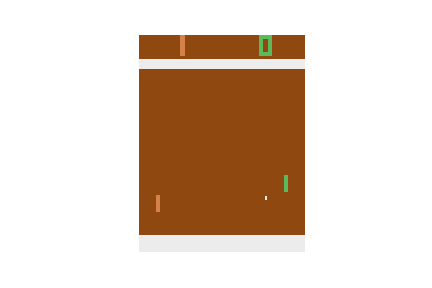
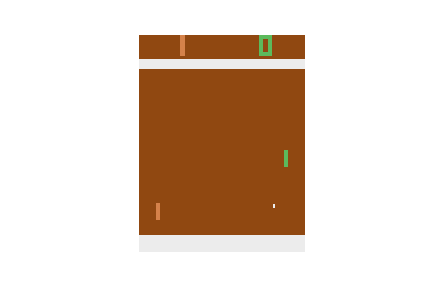
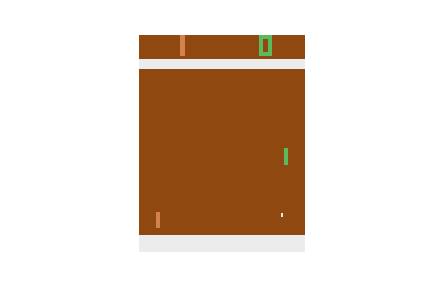
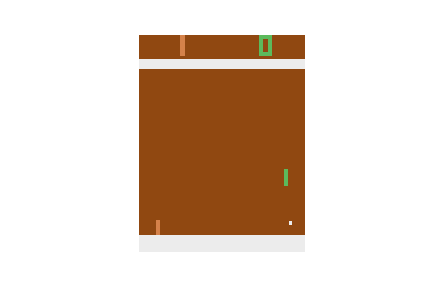
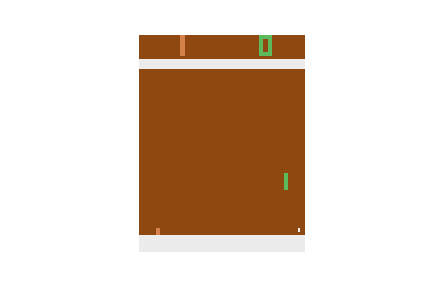
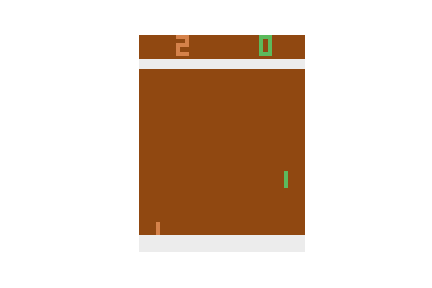
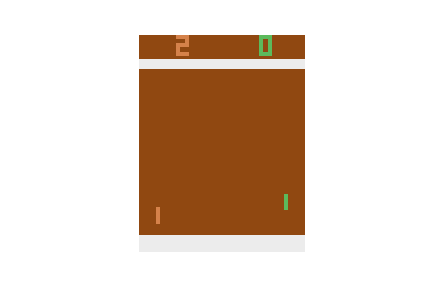
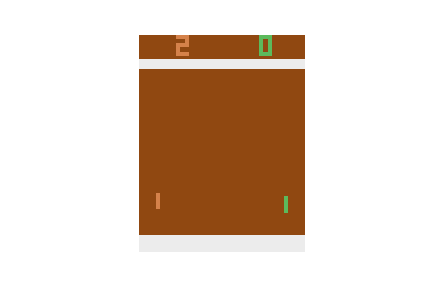
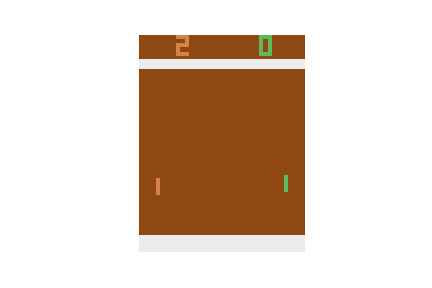
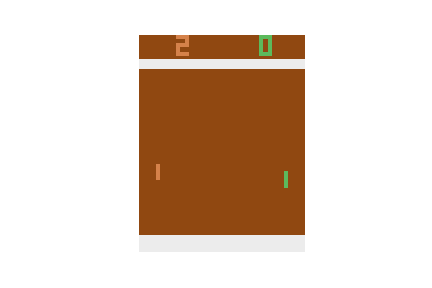
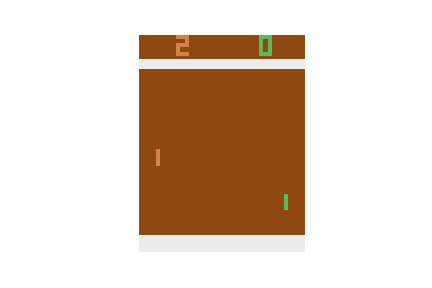
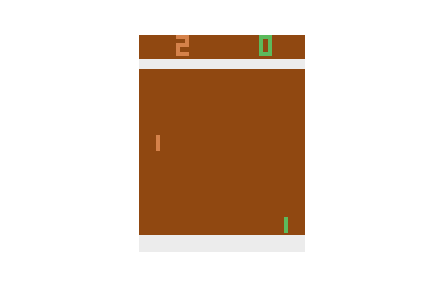
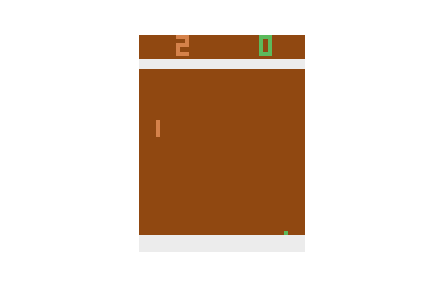
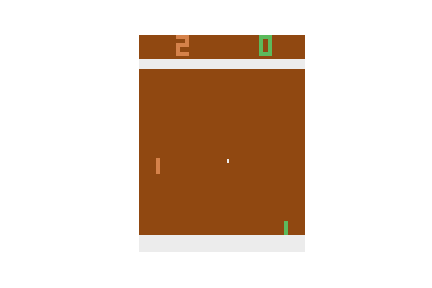
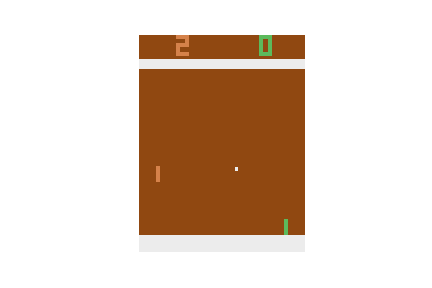
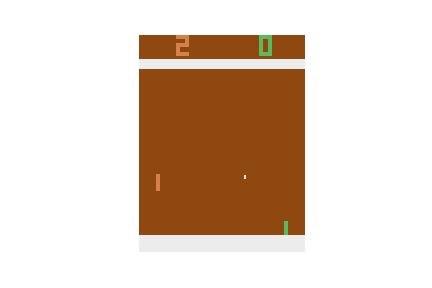
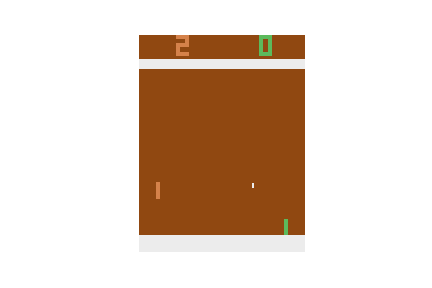
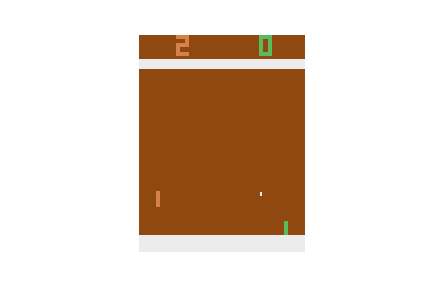
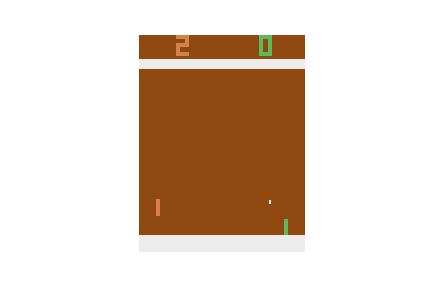
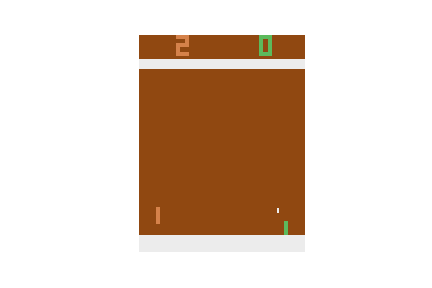
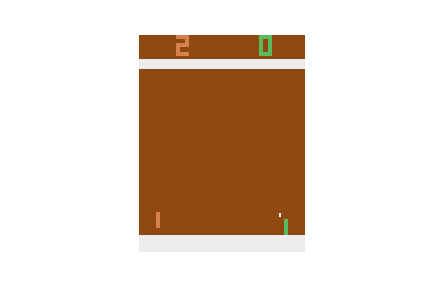
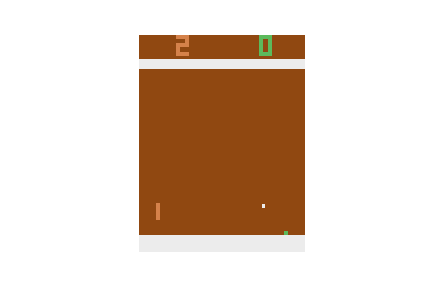
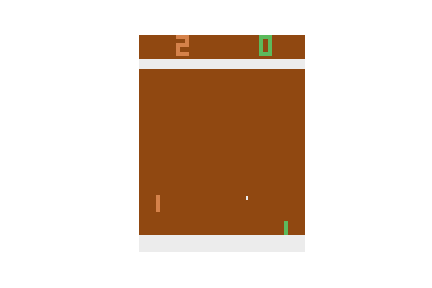
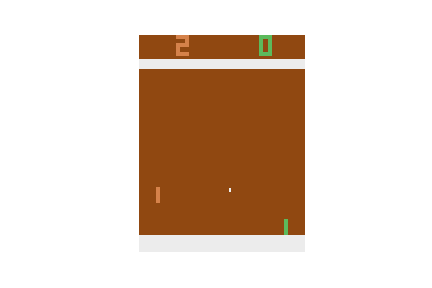
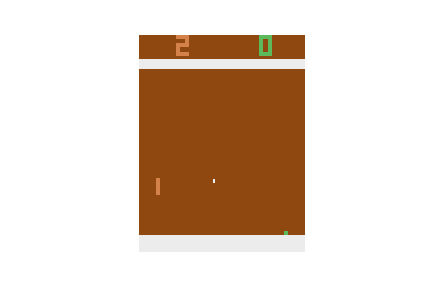
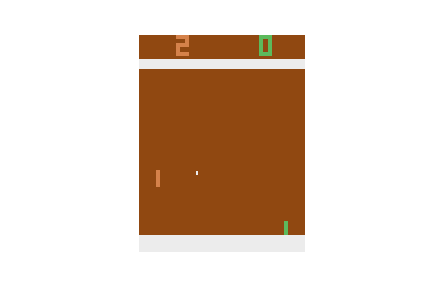
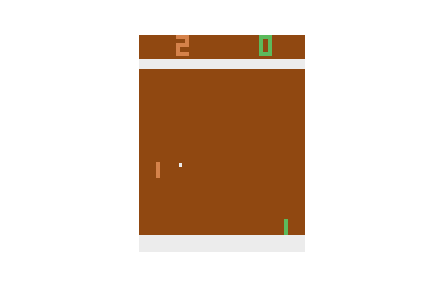
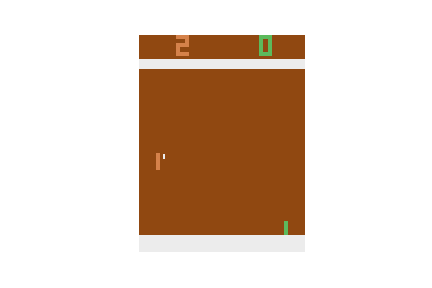
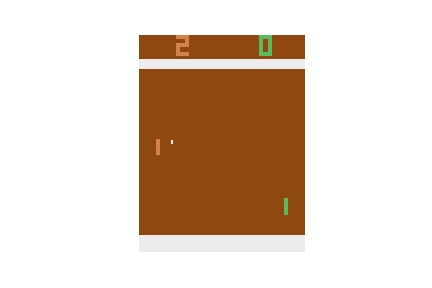
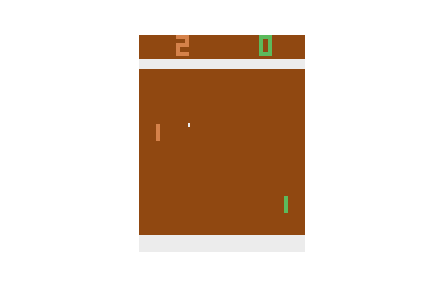
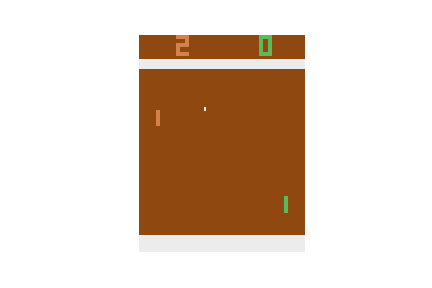
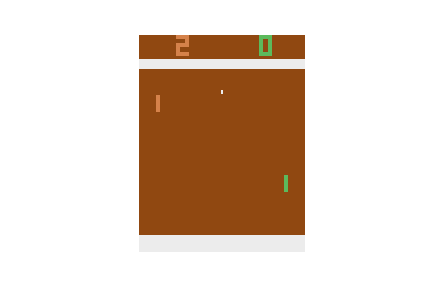
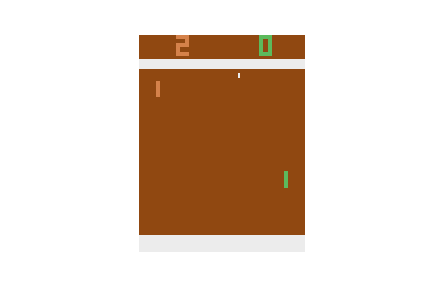
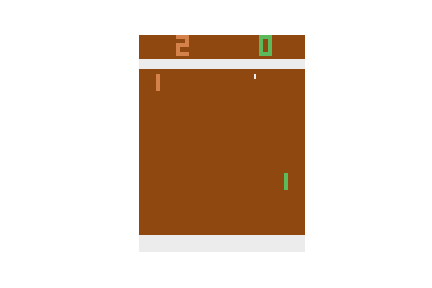
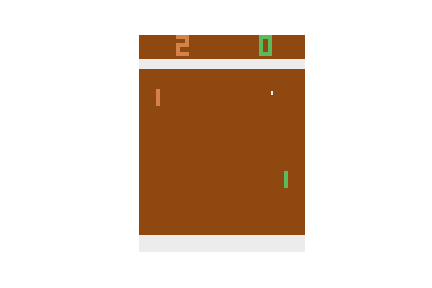
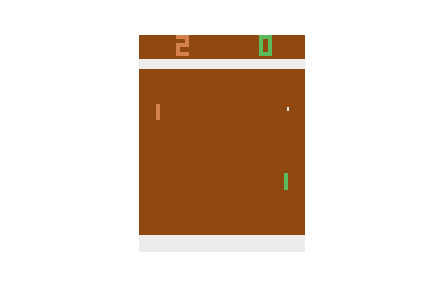
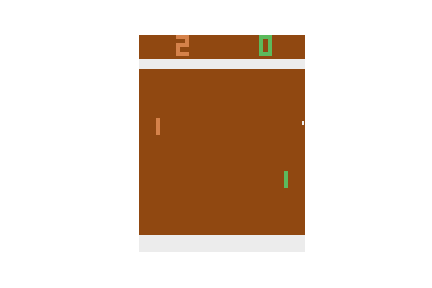
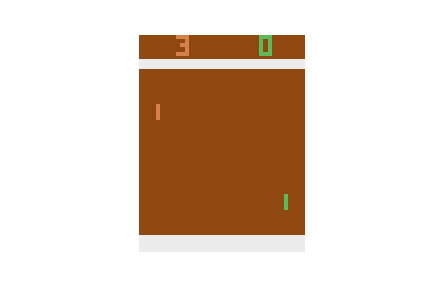
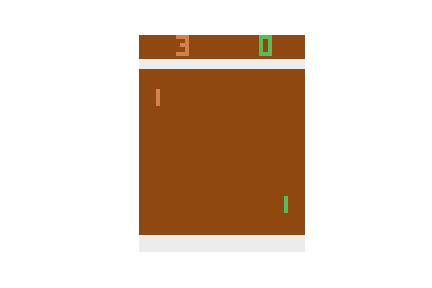
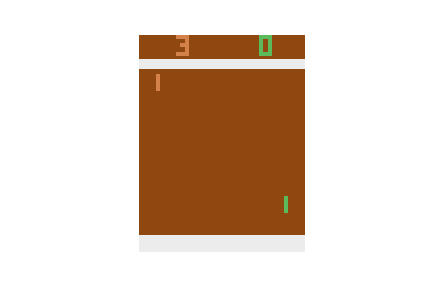
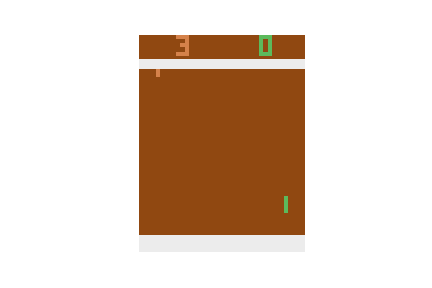
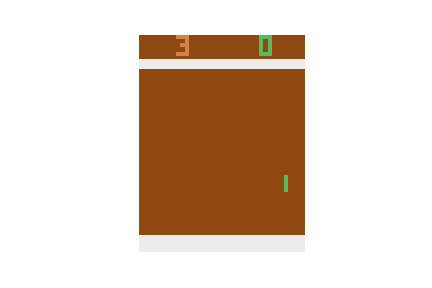
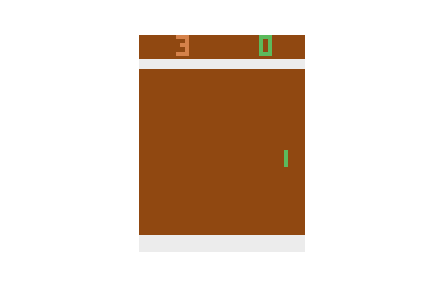
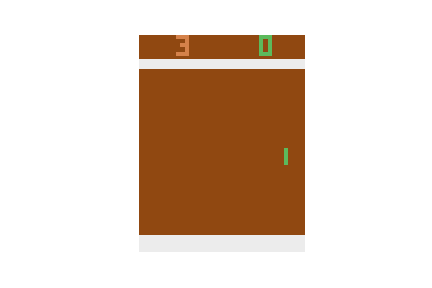
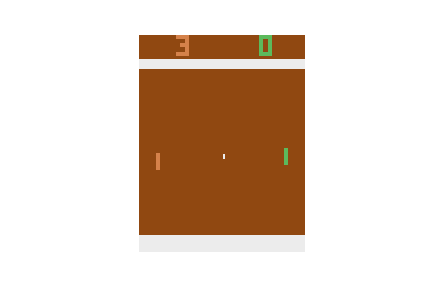
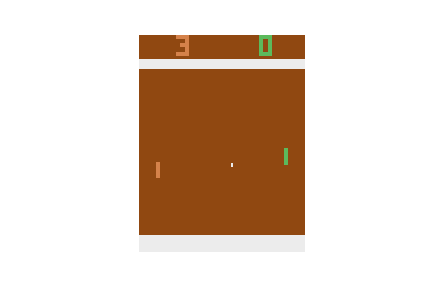
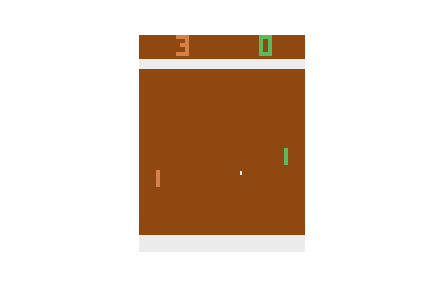
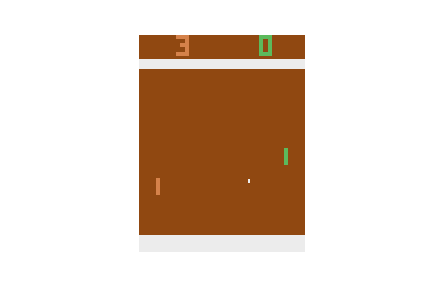
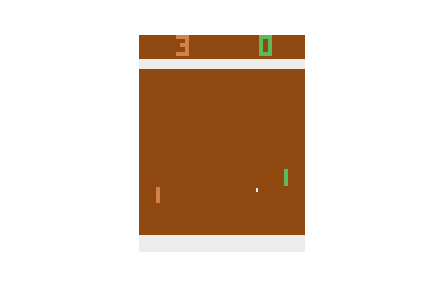
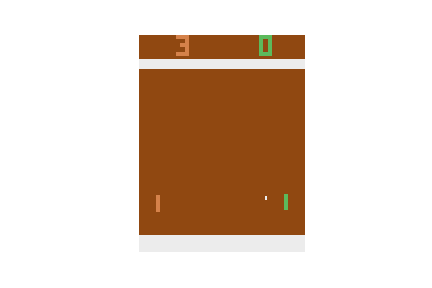
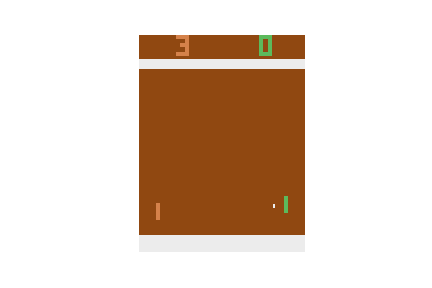
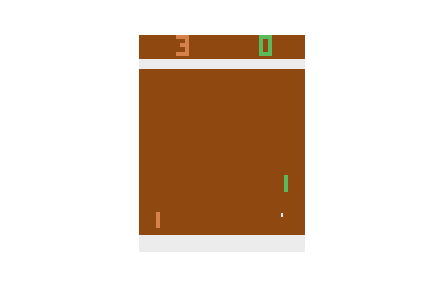
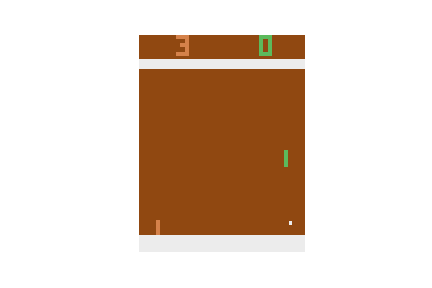
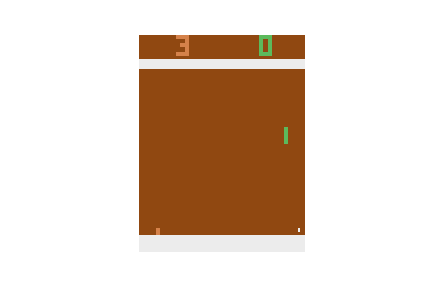
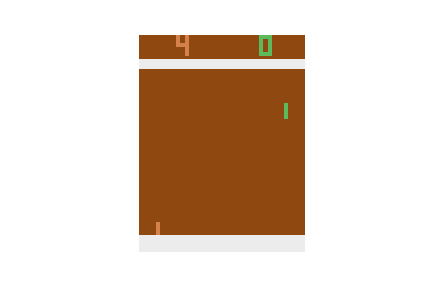
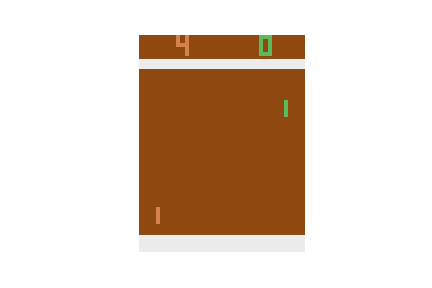
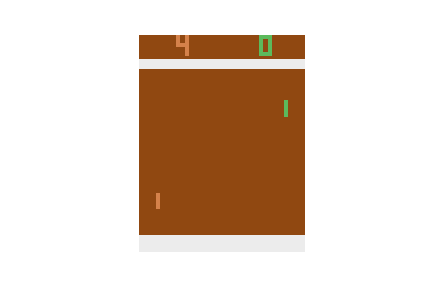
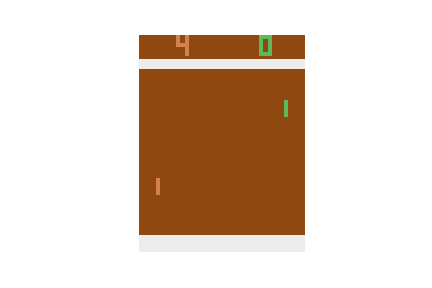
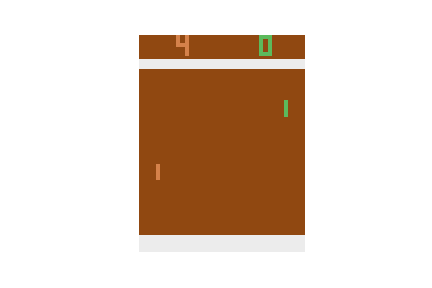
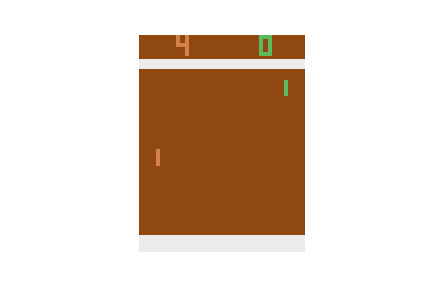
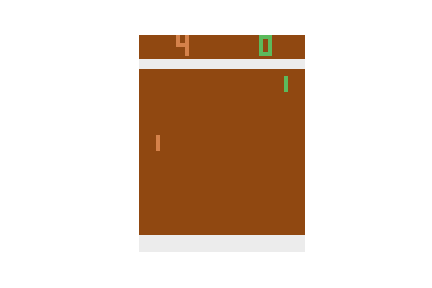
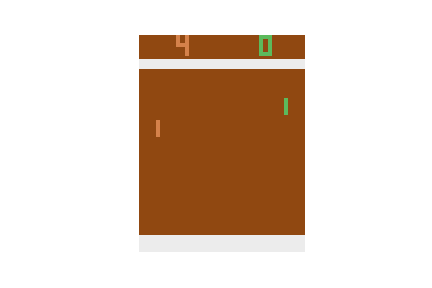
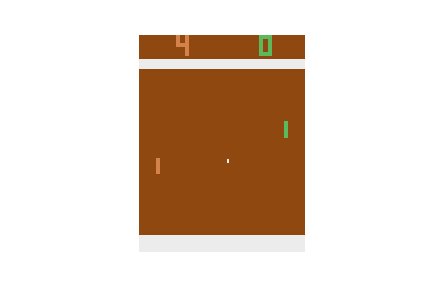
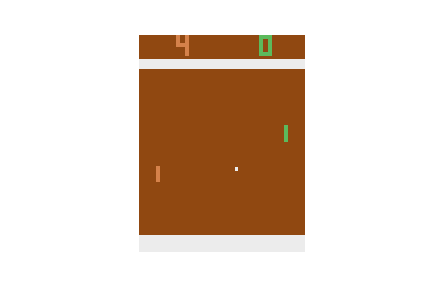
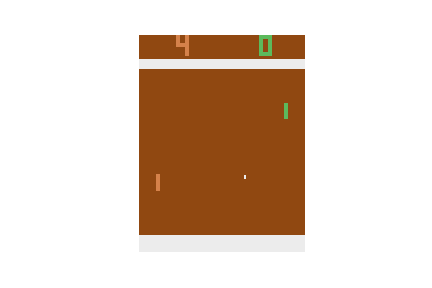
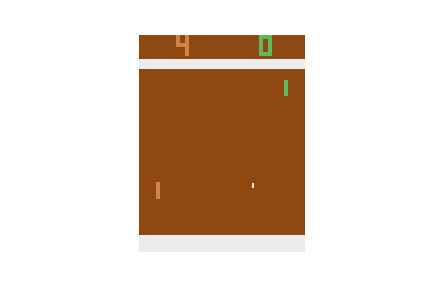
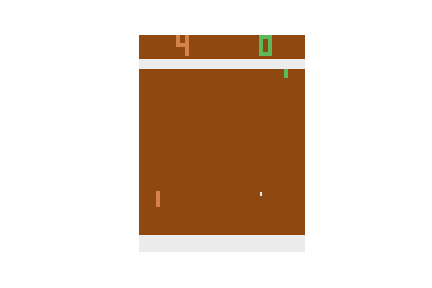
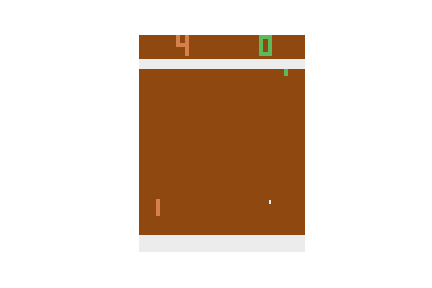
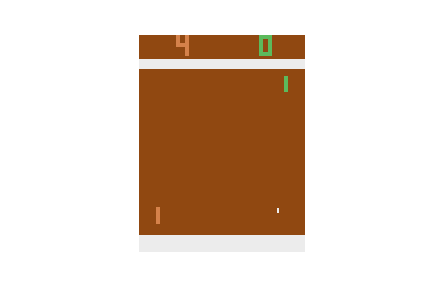
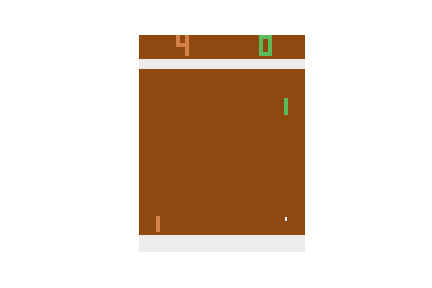
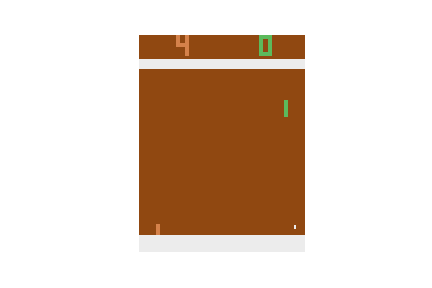
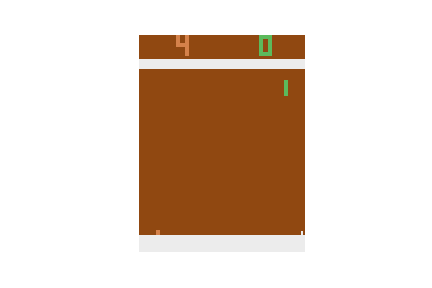
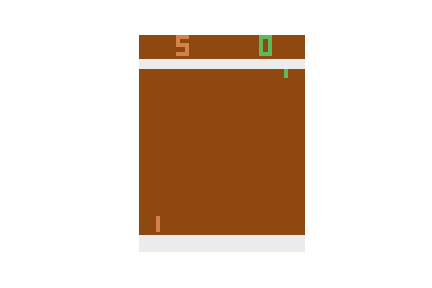
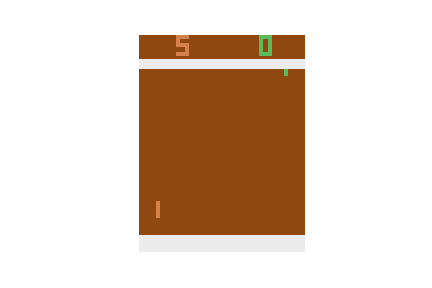
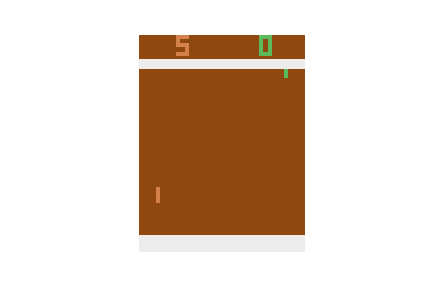
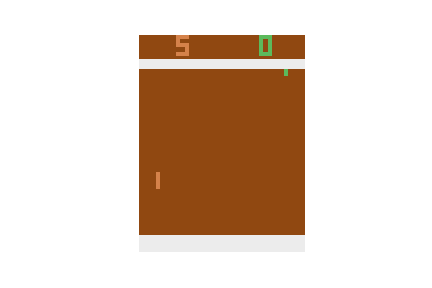
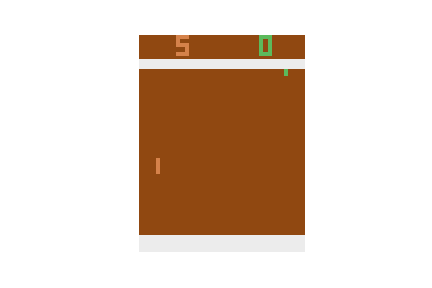
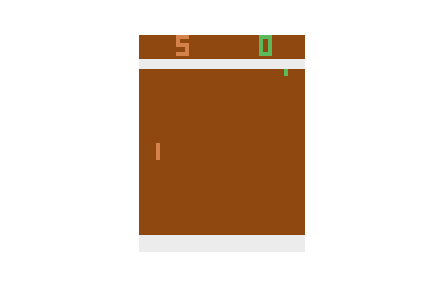
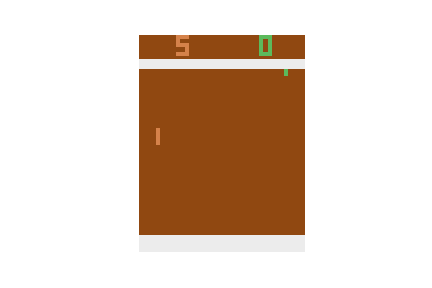
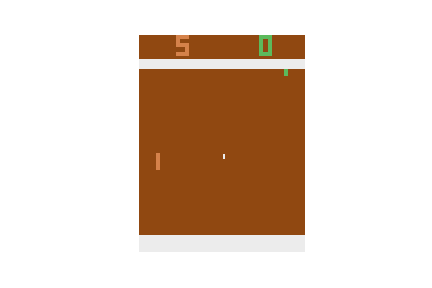
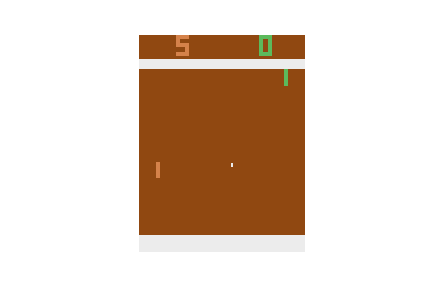
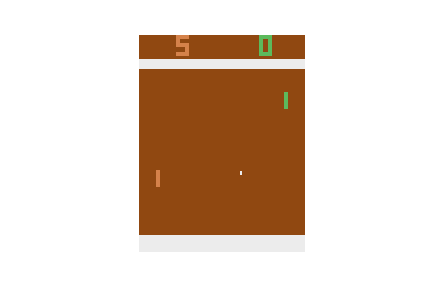
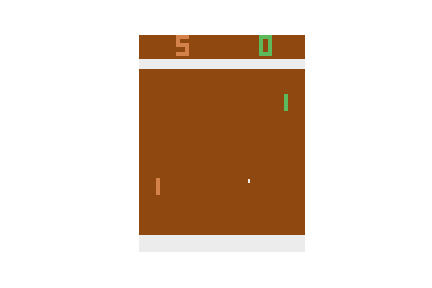
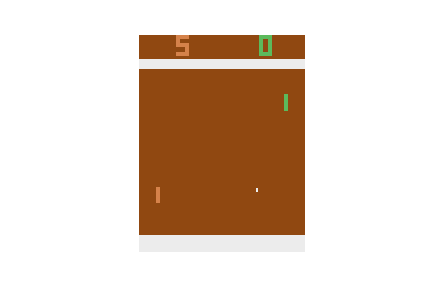
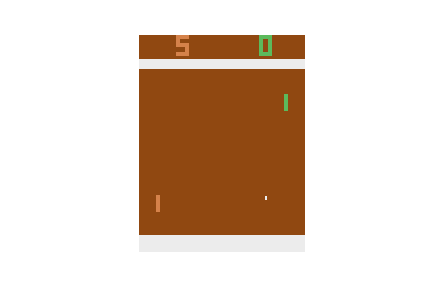
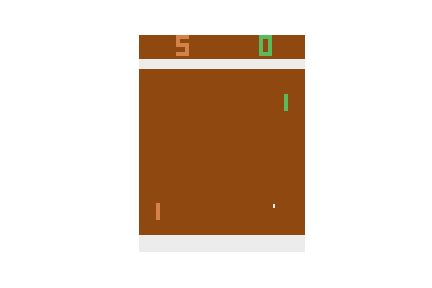
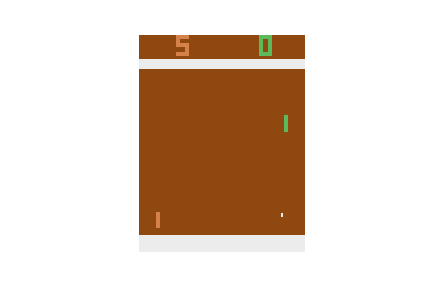
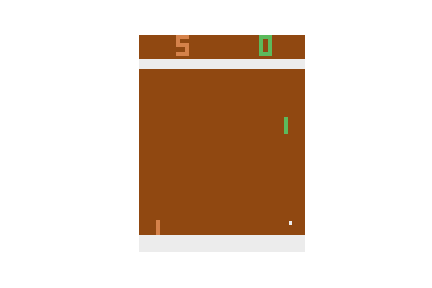
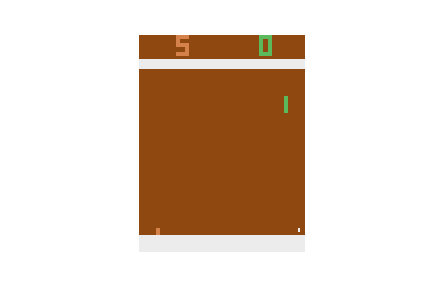
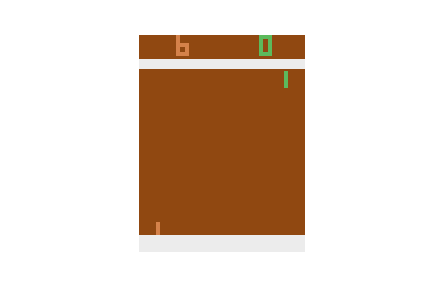
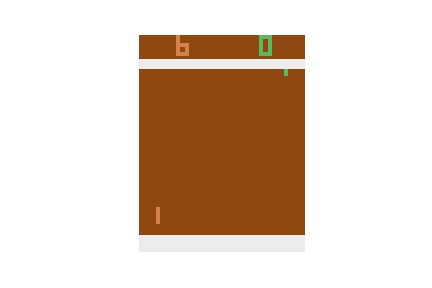
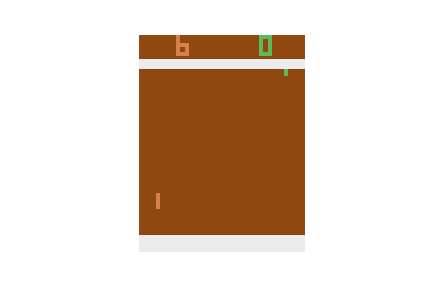
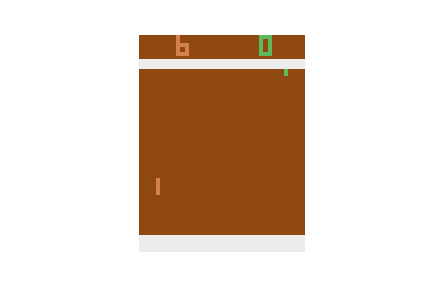
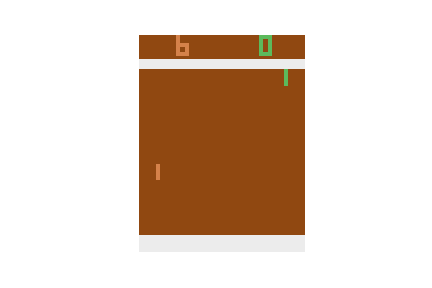
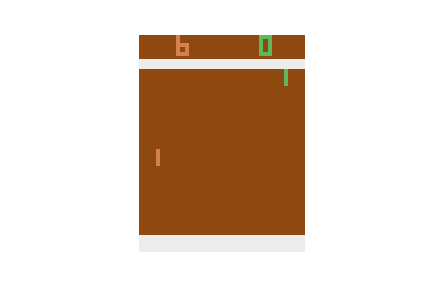
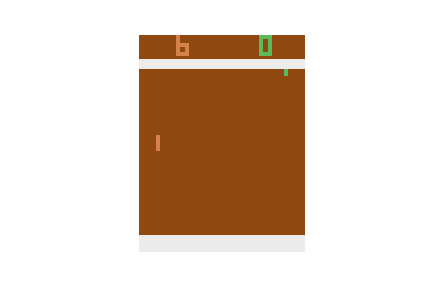
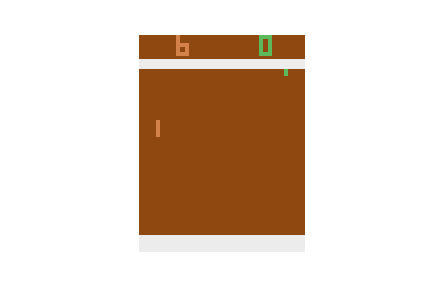
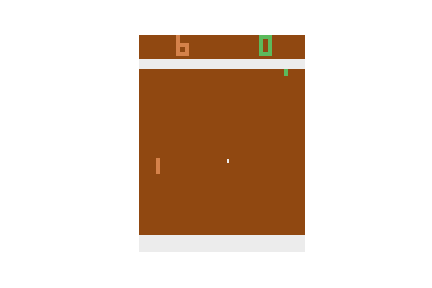
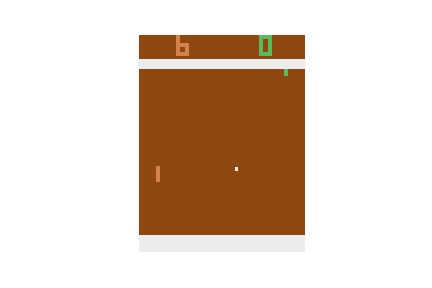
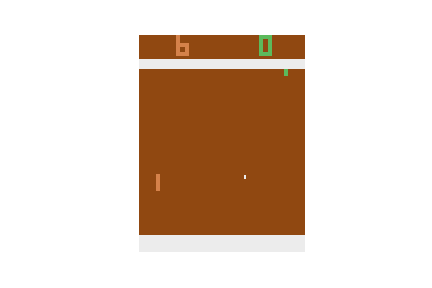
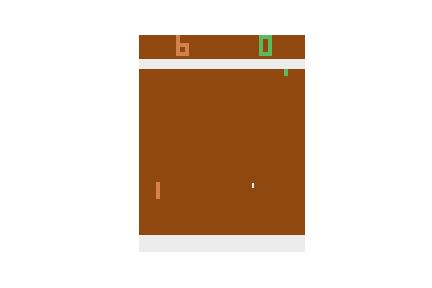
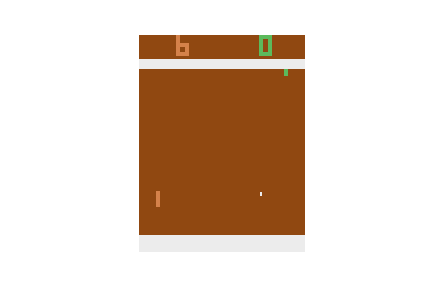
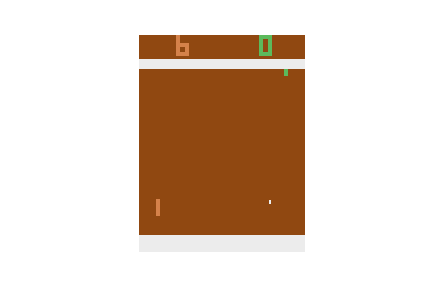
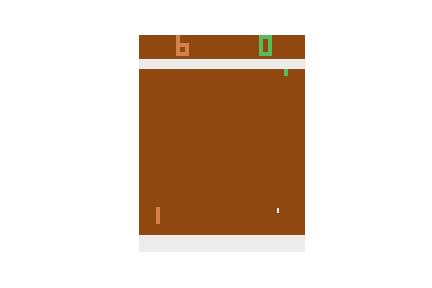
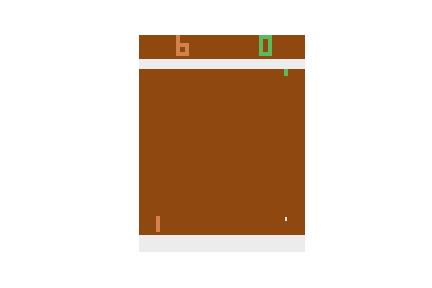
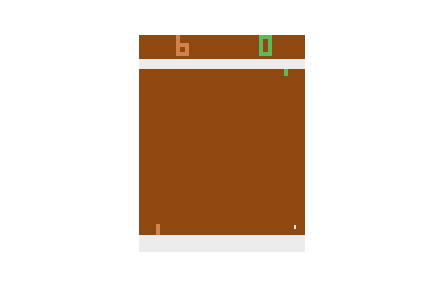
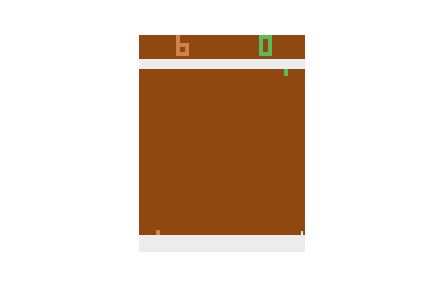
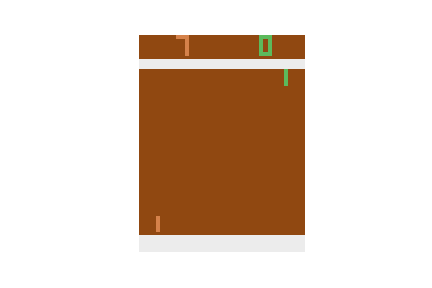
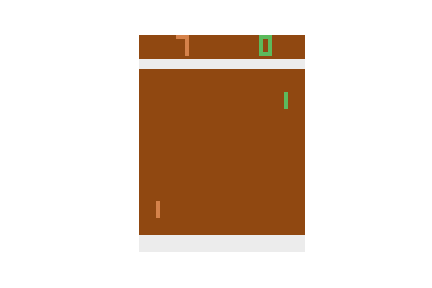
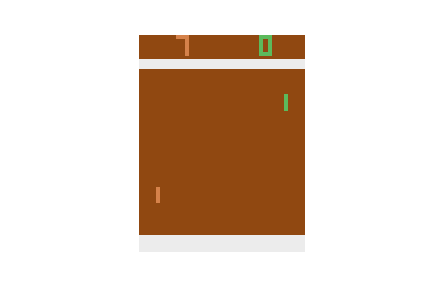
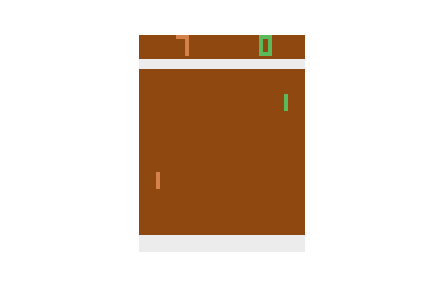
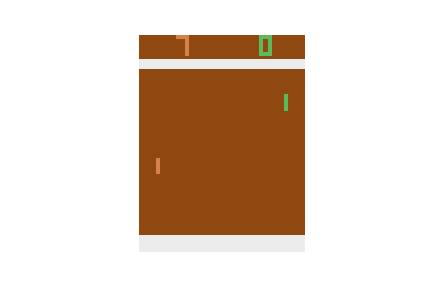
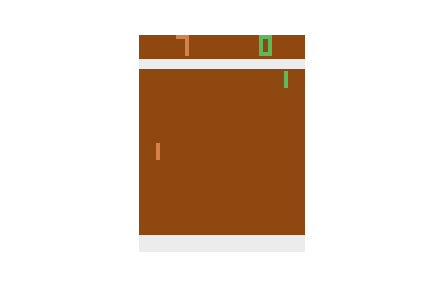
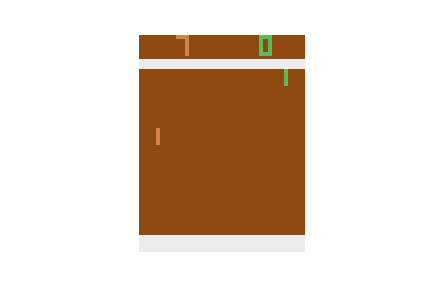
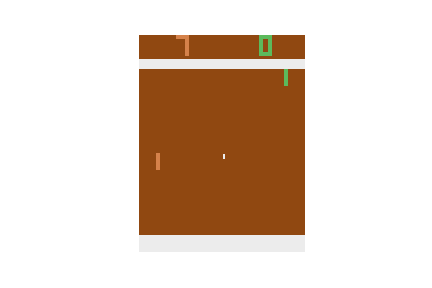
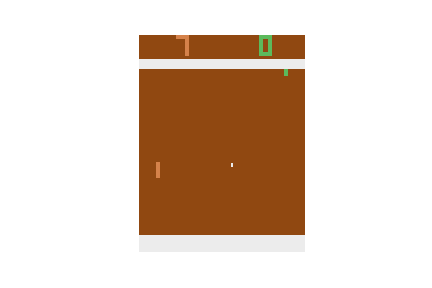
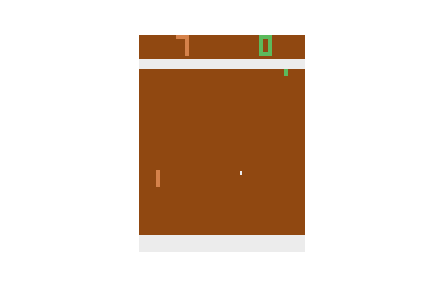
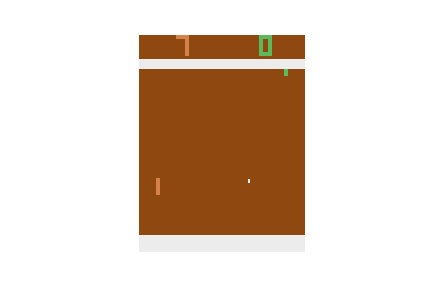
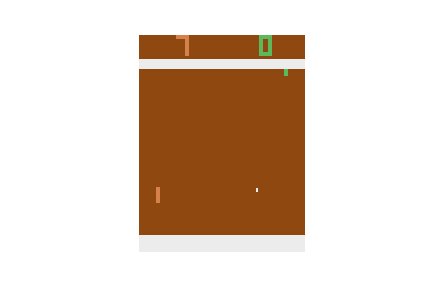
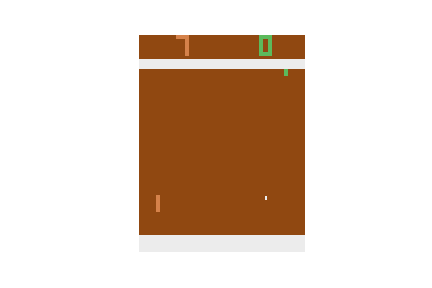
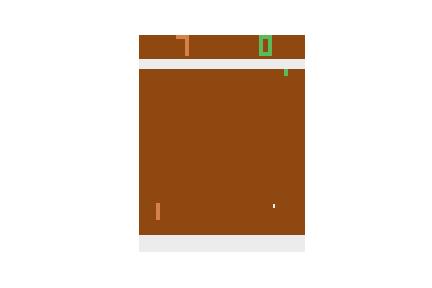
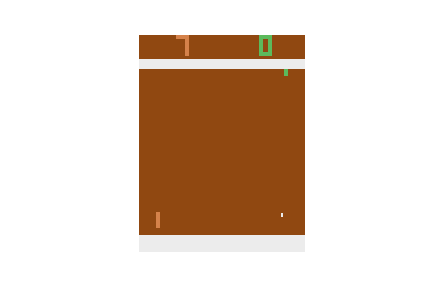
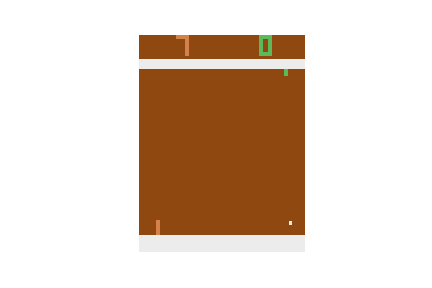
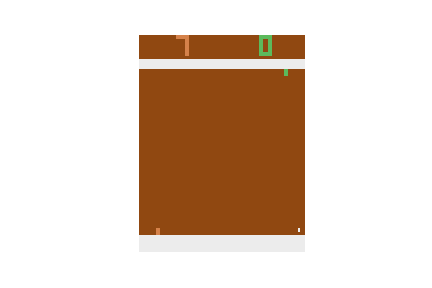
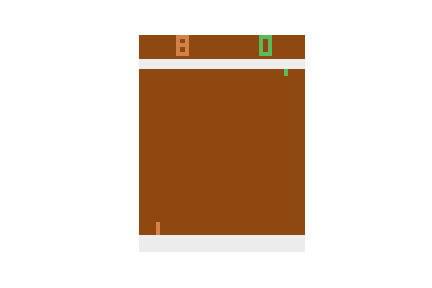
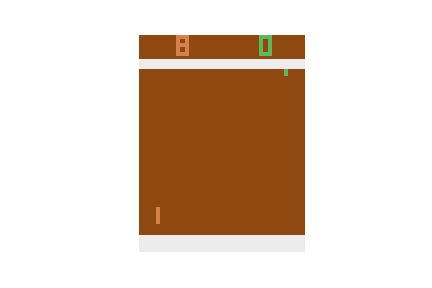
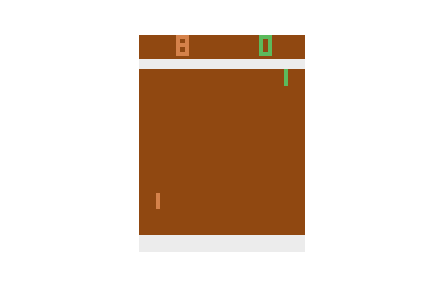
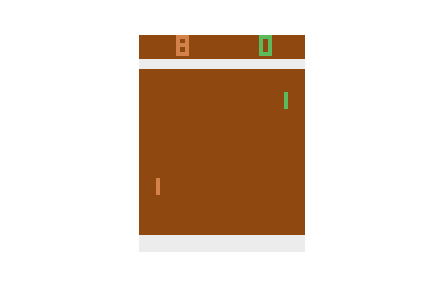
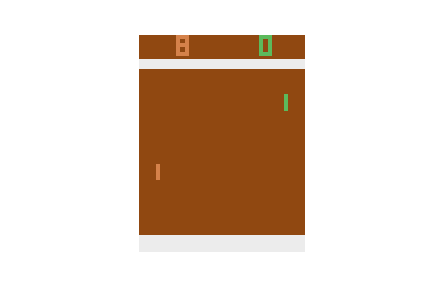
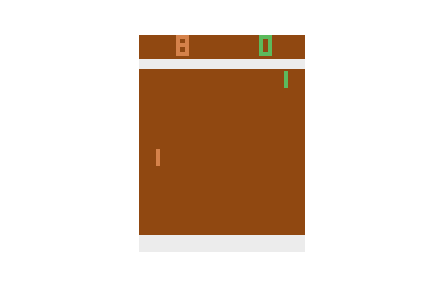
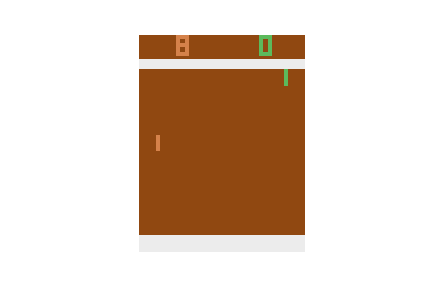
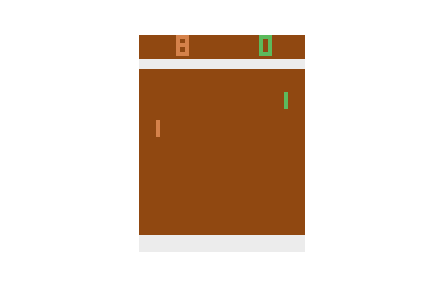
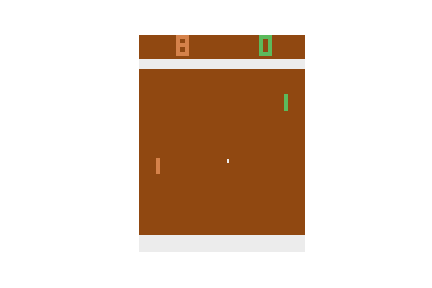
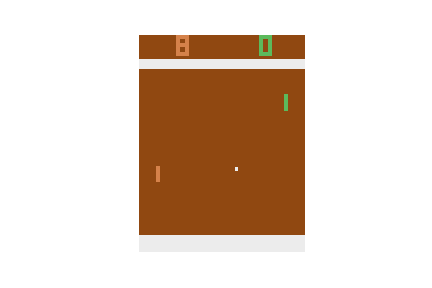
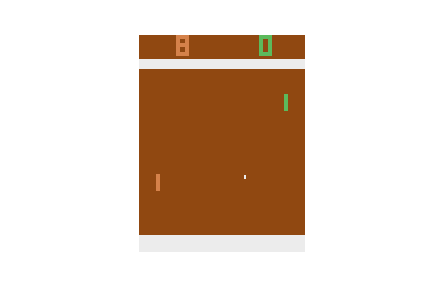
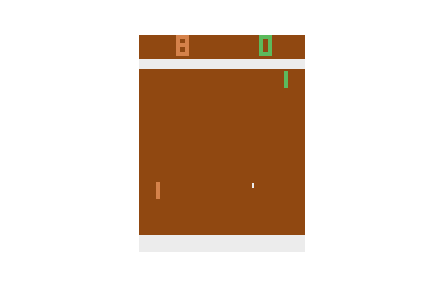
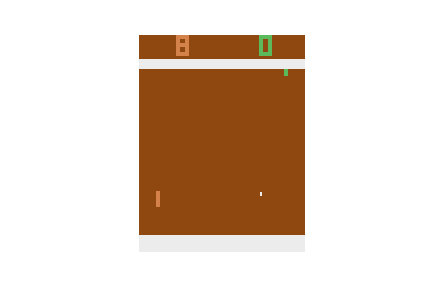
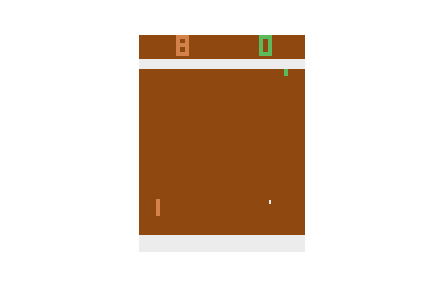
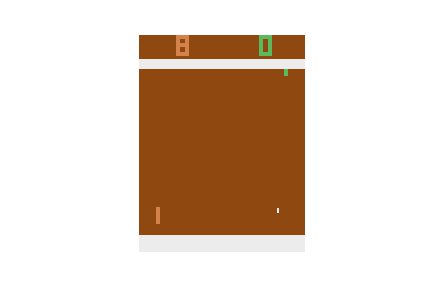
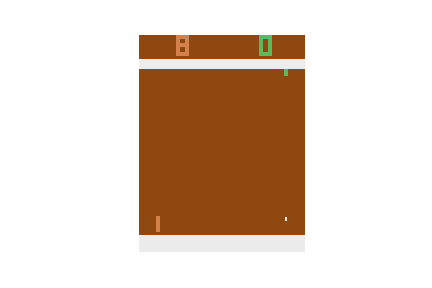
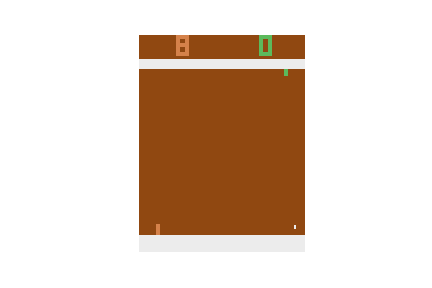
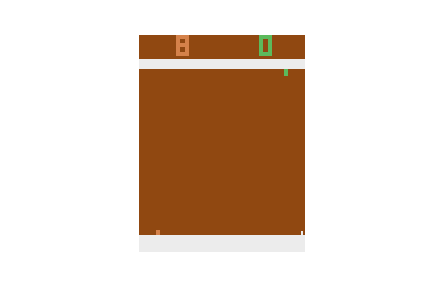
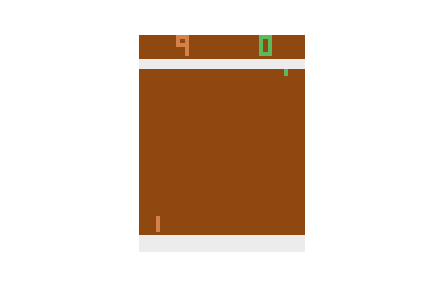
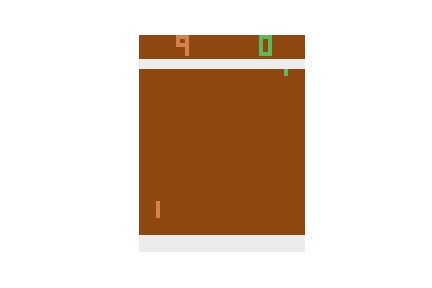
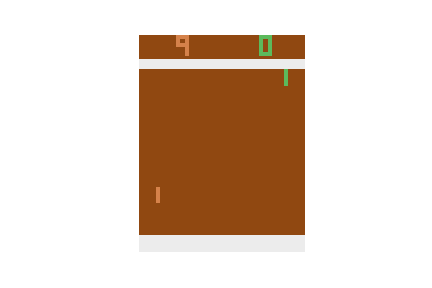
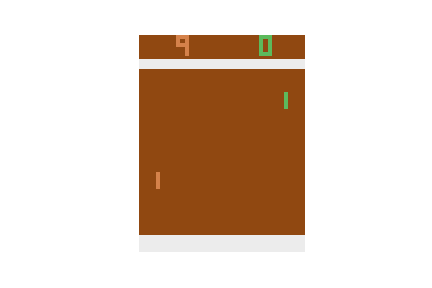
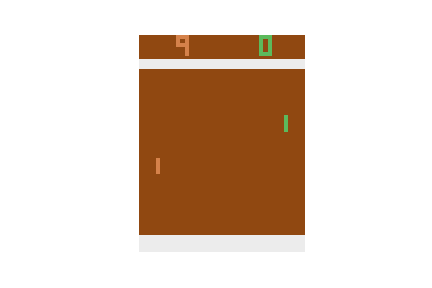
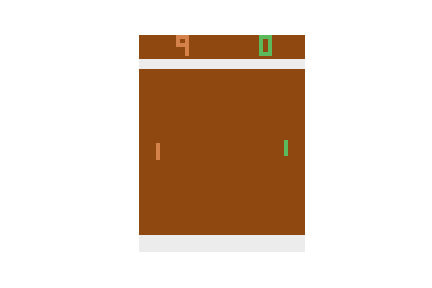
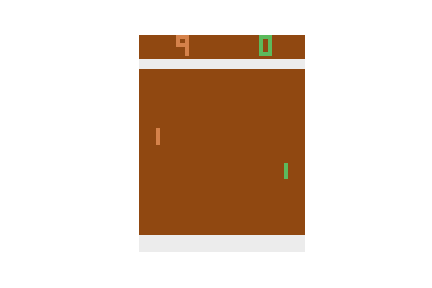
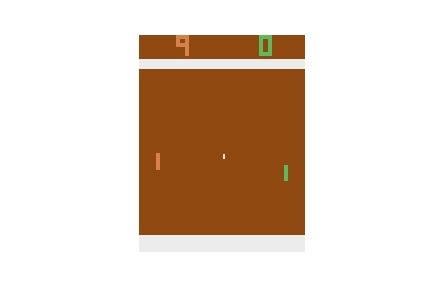
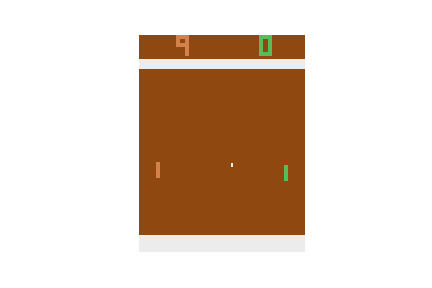
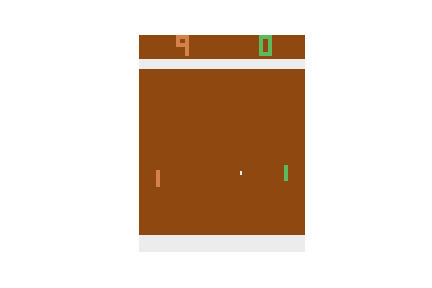
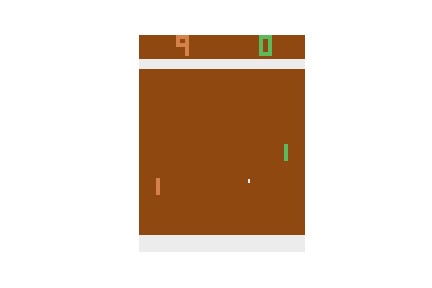
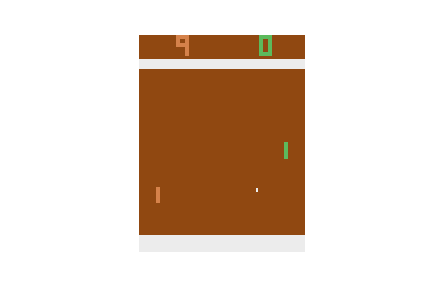
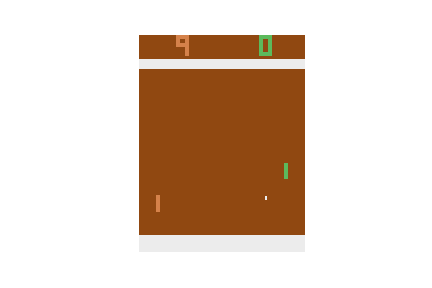
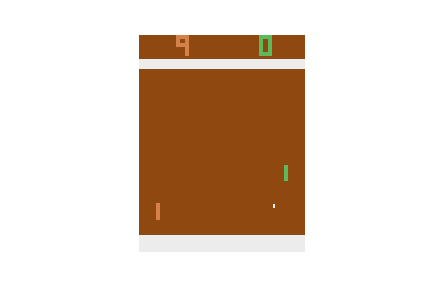
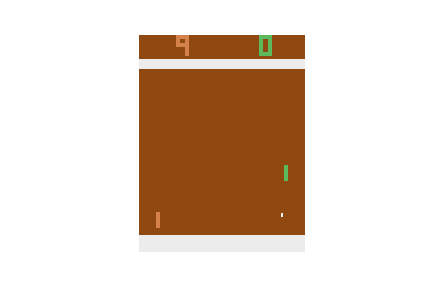
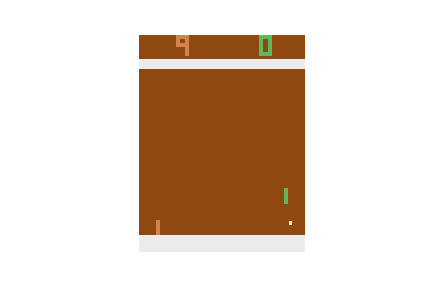
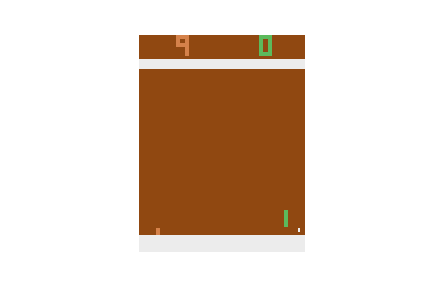
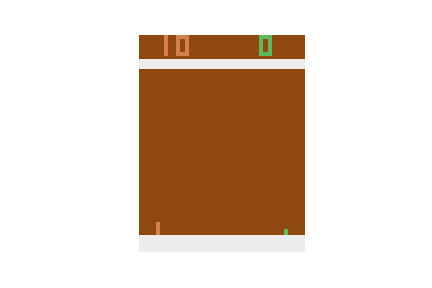
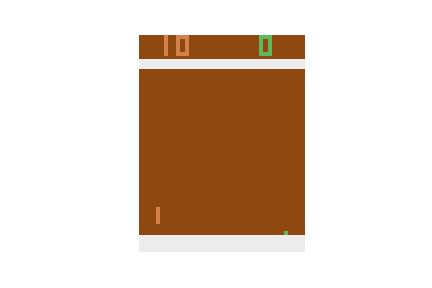

In [7]:
pong_utils.play(env, policy, time=200) 
# pong_utils.play(env, policy, time=200, preprocess = pong_utils.preprocess_single) # what agent sees

# Function Definitions
Key functions for training

### Proximal Policy Optimization (PPO)
Equation with clipped surrogate:
$\frac{1}{T}\sum^T_t \min\left\{R_{t}^{\rm future}\frac{\pi_{\theta'}(a_t|s_t)}{\pi_{\theta}(a_t|s_t)},R_{t}^{\rm future}{\rm clip}_{\epsilon}\!\left(\frac{\pi_{\theta'}(a_t|s_t)}{\pi_{\theta}(a_t|s_t)}\right)\right\}$

In [12]:
import numpy as np

def clipped_surrogate(policy, old_probs, states, actions, rewards,
                      discount=0.995,
                      epsilon=0.1, beta=0.01):

    discount = discount ** np.arange(len(rewards))
    rewards = np.asarray(rewards) * discount[:,np.newaxis]
    
    # convert rewards to future rewards
    rewards_future = rewards[::-1].cumsum(axis=0)[::-1]
    
    mean = np.mean(rewards_future, axis=1)
    std = np.std(rewards_future, axis=1) + 1.0e-10

    rewards_normalized = (rewards_future - mean[:,np.newaxis])/std[:,np.newaxis]
    
    # convert everything into pytorch tensors and move to gpu if available
    actions = torch.tensor(actions, dtype=torch.int8, device=device)
    old_probs = torch.tensor(old_probs, dtype=torch.float, device=device)
    rewards = torch.tensor(rewards_normalized, dtype=torch.float, device=device)

    # convert states to policy (or probability)
    new_probs = pong_utils.states_to_prob(policy, states)
    # action 4 is "right"
    new_probs = torch.where(actions == 4, new_probs, 1.0-new_probs)
    
    # ratio for clipping
    ratio = new_probs / old_probs

    # clipped function
    clip = torch.clamp(ratio, 1-epsilon, 1+epsilon)
    clipped_surrogate = torch.min(ratio*rewards, clip*rewards)

    # include a regularization term
    # this steers new_policy towards 0.5
    # add in 1.e-10 to avoid log(0) which gives nan
    entropy = - (new_probs * torch.log(old_probs + 1.e-10) + \
                 (1.0 - new_probs) * torch.log(1.0 - old_probs + 1.e-10))
    
    # this returns an average of all the entries of the tensor
    # effective computing L_sur^clip / T
    # averaged over time-step and number of trajectories
    # this is desirable because we have normalized our rewards
    return torch.mean(clipped_surrogate + beta*entropy)

In [13]:
envs = pong_utils.parallelEnv('PongDeterministic-v4', n=4, seed=0)
prob, state, action, reward = pong_utils.collect_trajectories(envs, policy, tmax=100)

Lsur = clipped_surrogate(policy, prob, state, action, reward)
print(Lsur)

tensor(1.00000e-03 *
       6.9314, device='cuda:0')


# Training

In [14]:
from parallelEnv import parallelEnv
import numpy as np
# keep track of how long training takes
# WARNING: running through all 800 episodes will take 30-45 minutes

# training loop max iterations
episode = 500

# widget bar to display progress
import progressbar as pb
widget = ['training loop: ', pb.Percentage(), ' ', pb.Bar(), ' ', pb.ETA() ]
timer = pb.ProgressBar(widgets=widget, maxval=episode).start()

# initialize environment and parameters
envs = parallelEnv('PongDeterministic-v4', n=8, seed=1234)
discount_rate = .99
epsilon = 0.1
beta = .01
tmax = 200
SGD_epoch = 4
mean_rewards = []

for e in range(episode):
    # collect trajectories
    old_probs, states, actions, rewards = pong_utils.collect_trajectories(envs, policy, tmax=tmax)
    total_rewards = np.sum(rewards, axis=0)

    # gradient ascent step
    for _ in range(SGD_epoch):
        
        # uncomment to utilize your own clipped function!
#         L = -clipped_surrogate(policy, old_probs, states, actions, rewards, epsilon=epsilon, beta=beta)
        L = -pong_utils.clipped_surrogate(policy, old_probs, states, actions, rewards, epsilon=epsilon, beta=beta)
        optimizer.zero_grad()
        L.backward()
        optimizer.step()
        del L
    
    # the clipping parameter reduces as time goes on
    epsilon *= 0.999
    
    # the regulation term also reduces
    # this reduces exploration in later runs
    beta *= 0.995
    
    # get the average reward of the parallel environments
    mean_rewards.append(np.mean(total_rewards))
    
    # display some progress every 20 iterations
    if (e + 1) % 20 == 0 :
        print("Episode: {0:d}, score: {1:f}".format(e+1,np.mean(total_rewards)))
        print(total_rewards)
        
    timer.update(e+1)
    
timer.finish()

Episode: 20, score: -8.250000
[-6. -9. -9. -9. -9. -8. -9. -7.]


Episode: 40, score: -7.875000
[ -9.  -4.  -7.  -5.  -8. -10. -10. -10.]


Episode: 60, score: -9.375000
[-10. -10.  -9.  -8. -10.  -9.  -9. -10.]


Episode: 80, score: -9.000000
[-10.  -9. -10.  -7. -10. -10.  -6. -10.]


Episode: 100, score: -7.375000
[-10. -10.  -9.  -7.  -7.  -5.  -4.  -7.]


Episode: 120, score: -8.250000
[ -5. -10.  -9.  -7.  -9.  -8.  -9.  -9.]


Episode: 140, score: -9.125000
[ -9.  -9.  -8. -10. -10.  -8.  -9. -10.]


Episode: 160, score: -7.750000
[-10.  -8.  -9.  -4.  -5. -10.  -9.  -7.]


Episode: 180, score: -8.125000
[ -5.  -9. -10. -10.  -8.  -6.  -9.  -8.]


Episode: 200, score: -7.875000
[ -8.  -7.  -4.  -9.  -7.  -9. -10.  -9.]


Episode: 220, score: -6.750000
[-7. -6. -5. -8. -6. -6. -8. -8.]


Episode: 240, score: -6.875000
[-6. -8. -5. -7. -5. -9. -8. -7.]


Episode: 260, score: -5.625000
[-8. -6. -7. -4. -5. -6. -8. -1.]


Episode: 280, score: -5.875000
[-9. -6. -7. -2. -7. -5. -4. -7.]


Episode: 300, score: -5.250000
[-6. -3. -8. -5. -3. -6. -5. -6.]


Episode: 320, score: -4.250000
[-4. -5. -2. -7. -6. -5. -5.  0.]


Episode: 340, score: -3.000000
[-6.  0.  0. -5. -3. -3. -2. -5.]


Episode: 360, score: -2.625000
[-1. -6. -1.  0. -3. -3. -5. -2.]


Episode: 380, score: -1.500000
[-2. -3.  0. -1. -4.  1. -2. -1.]


Episode: 400, score: -1.875000
[-1. -2. -5. -1. -1. -1. -1. -3.]


Episode: 420, score: -1.250000
[ 0. -4. -1. -1.  2. -1. -5.  0.]


Episode: 440, score: -1.500000
[ 1. -3. -2. -1.  0. -3. -3. -1.]


Episode: 460, score: -1.500000
[-1. -4. -1. -1. -2. -2.  0. -1.]


Episode: 480, score: 0.000000
[ 1. -1. -1.  0.  2. -3.  2.  0.]


Episode: 500, score: -0.375000
[ 2.  2. -1. -3. -3. -1. -1.  2.]



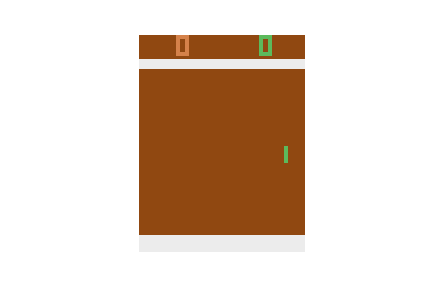
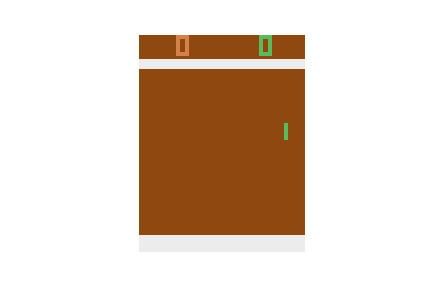
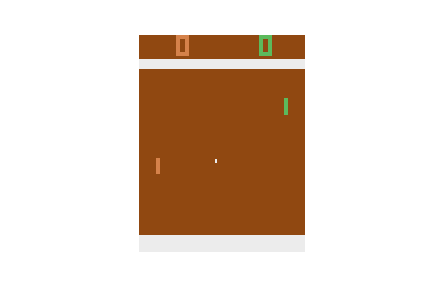
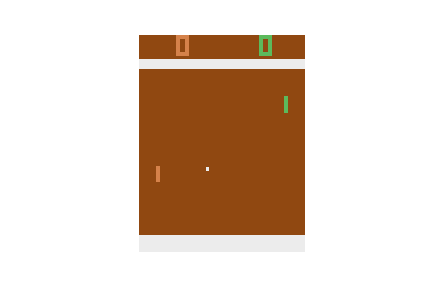
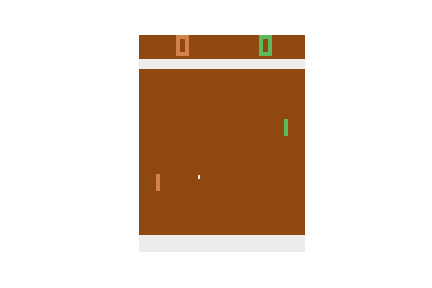
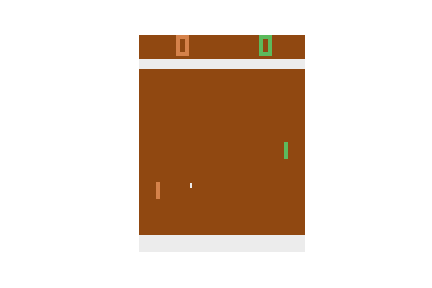
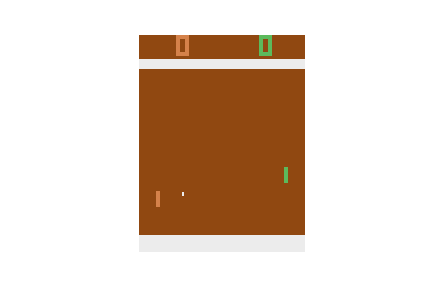
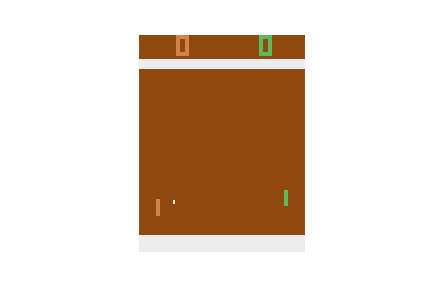
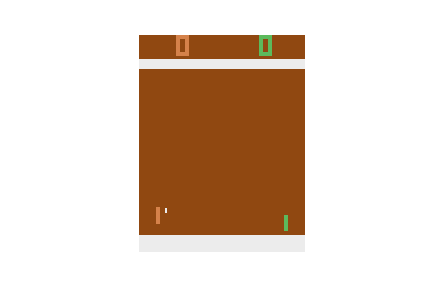
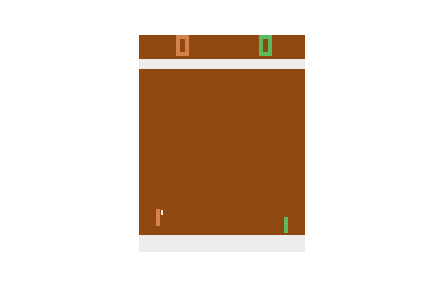
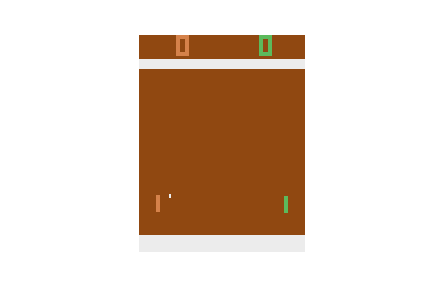
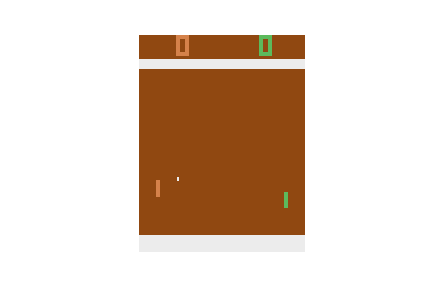
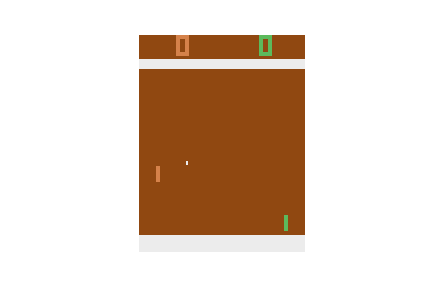
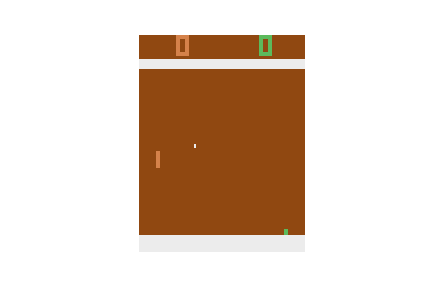
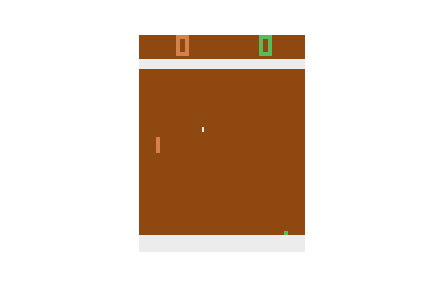
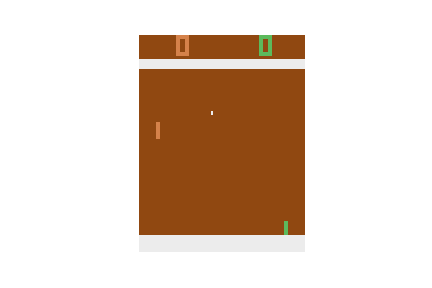
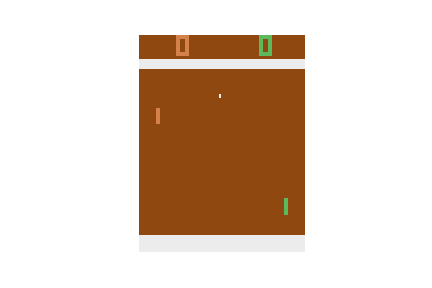
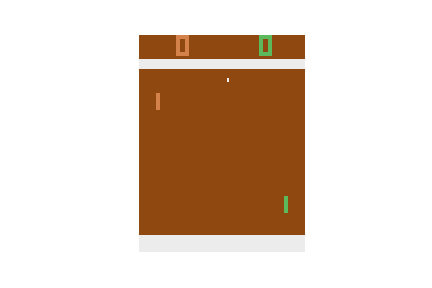
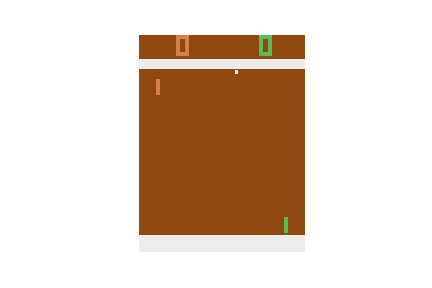
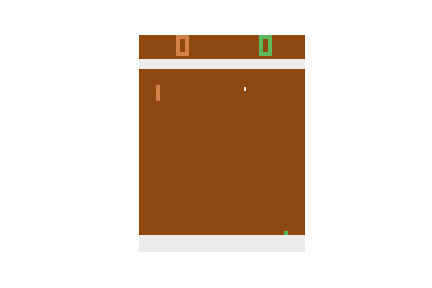
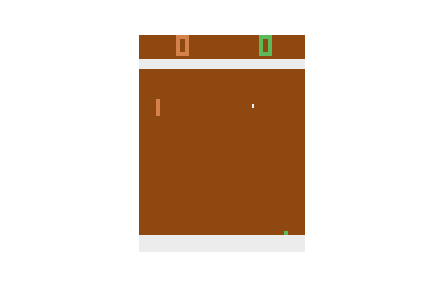
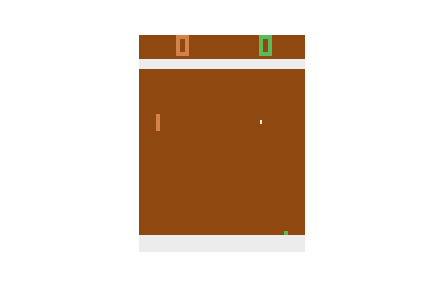
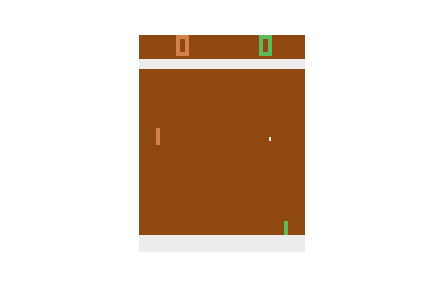
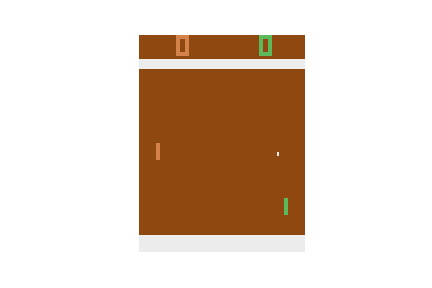
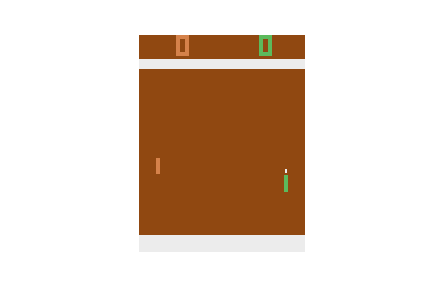
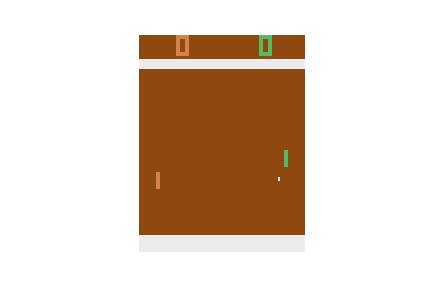
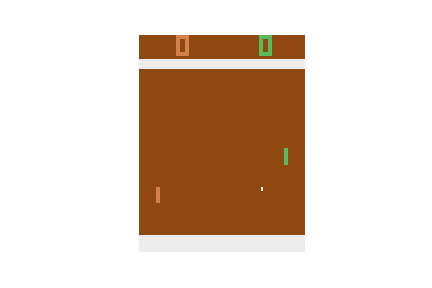
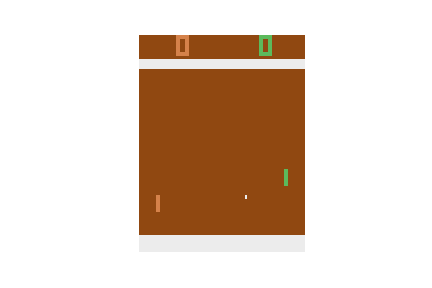
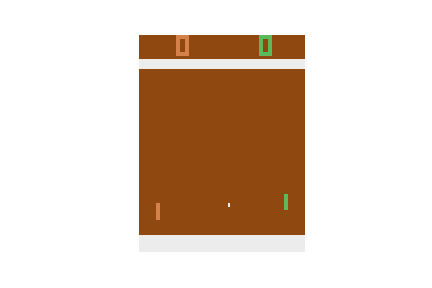
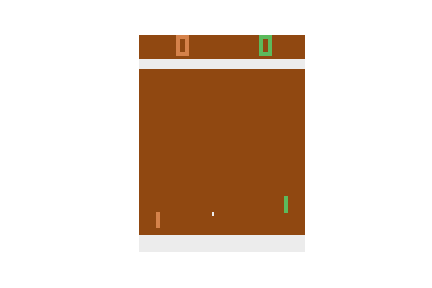
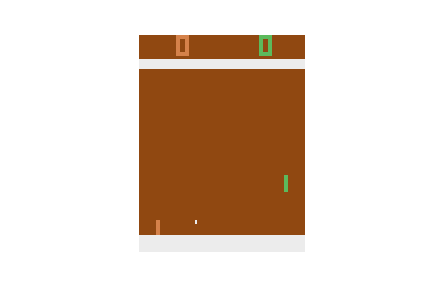
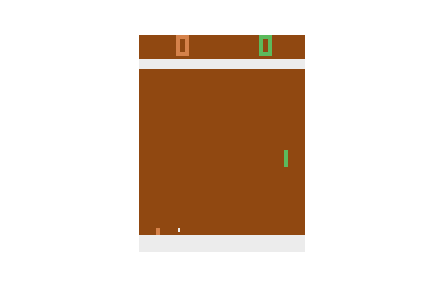
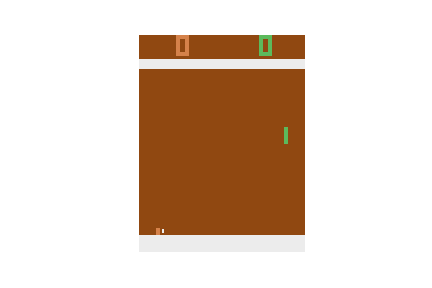
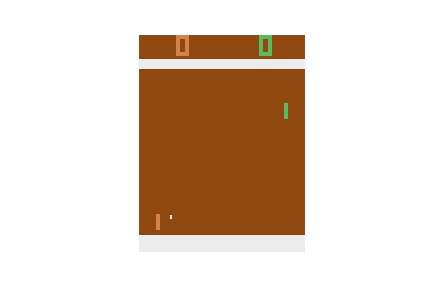
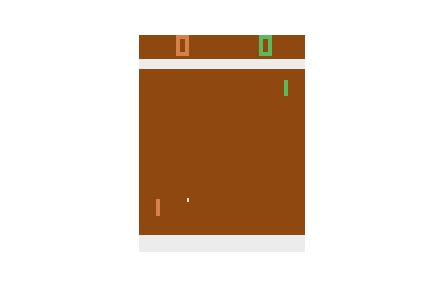
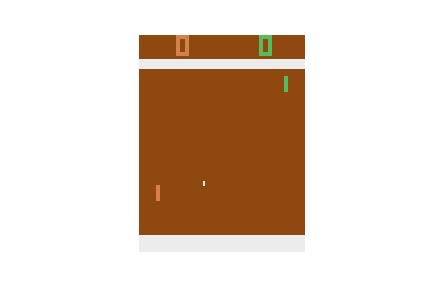
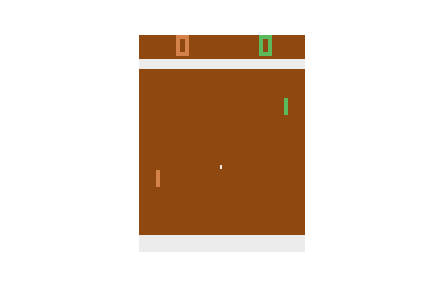
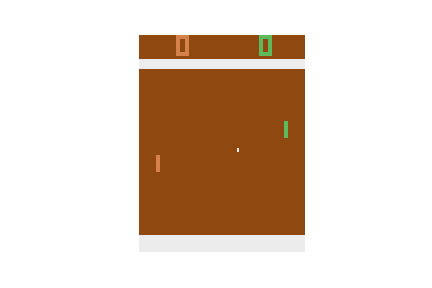
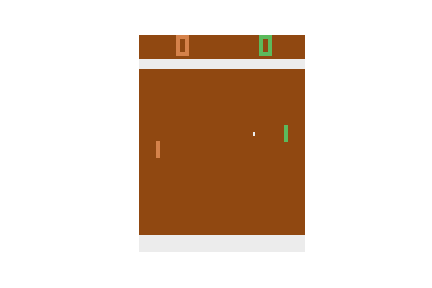
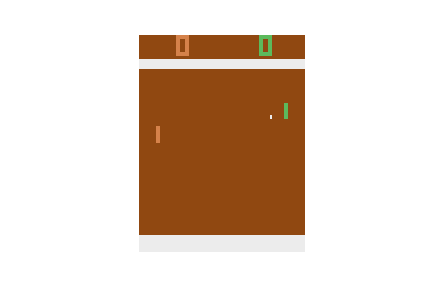
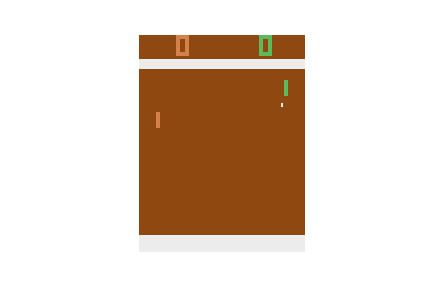
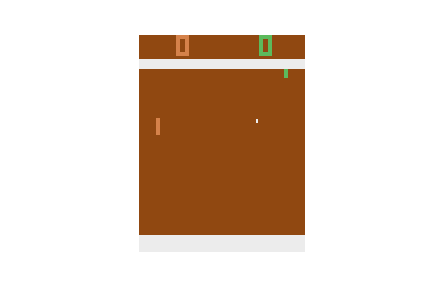
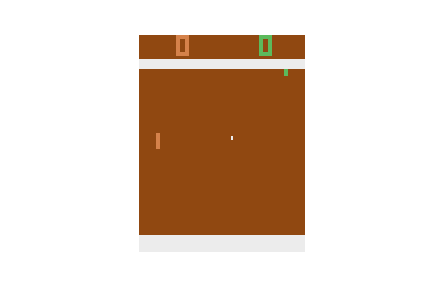
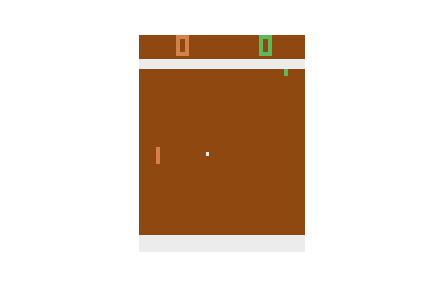
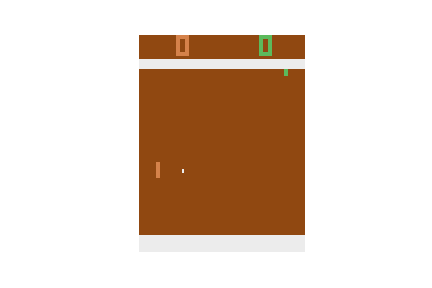
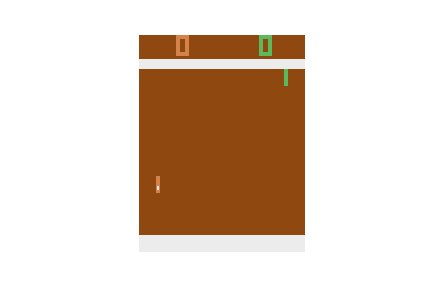
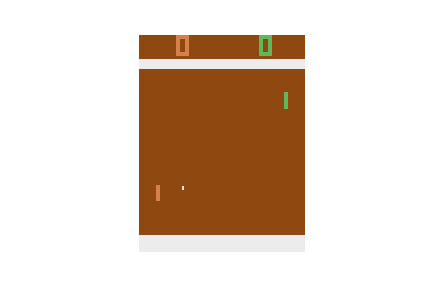
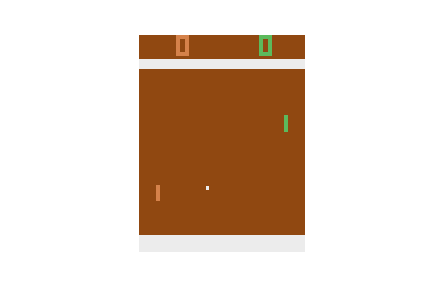
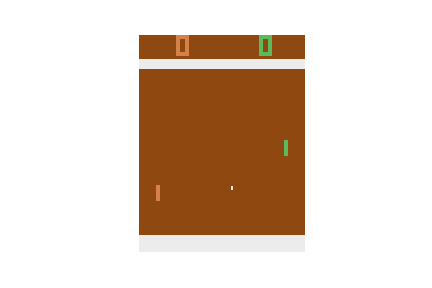
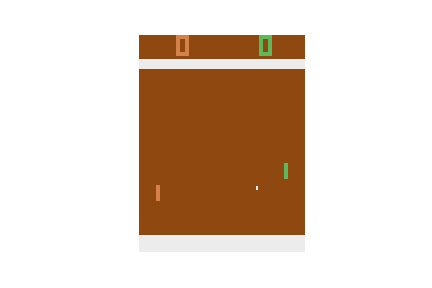
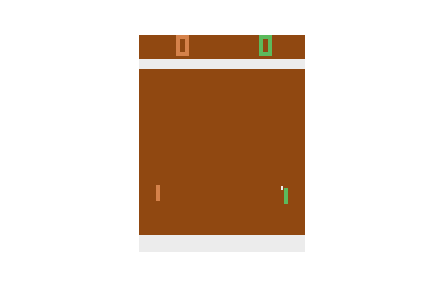
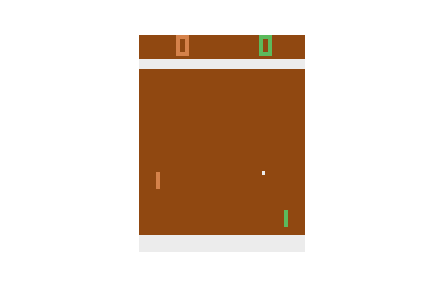
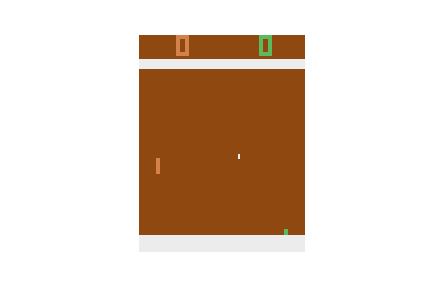
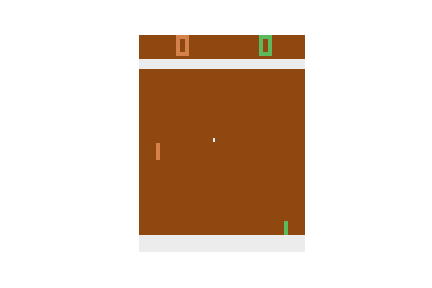
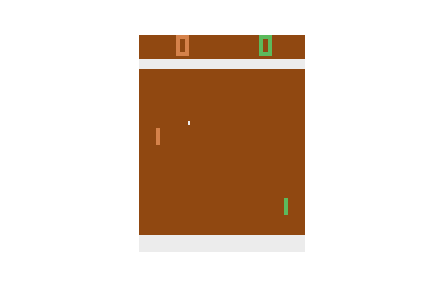
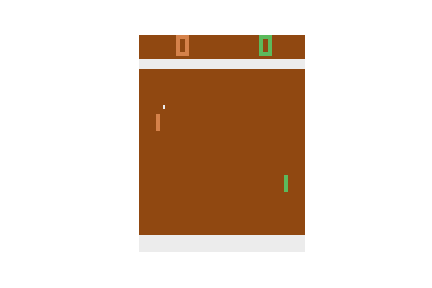
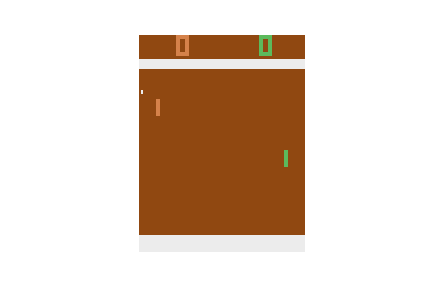
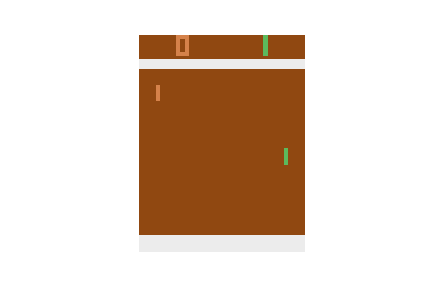
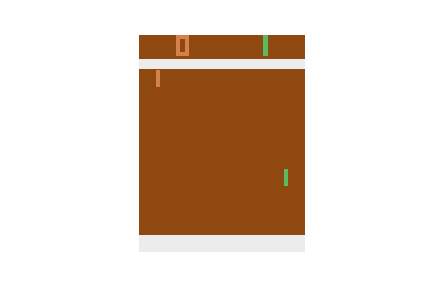
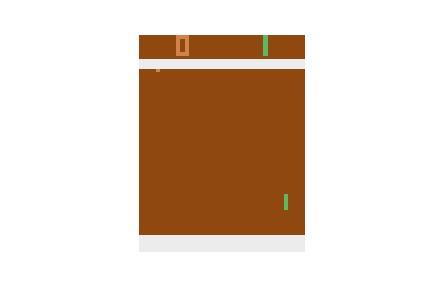
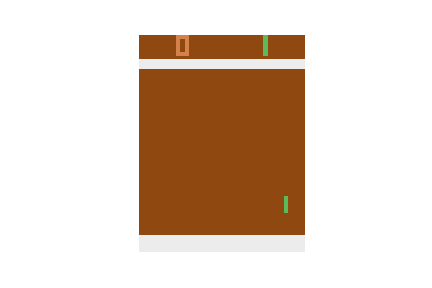
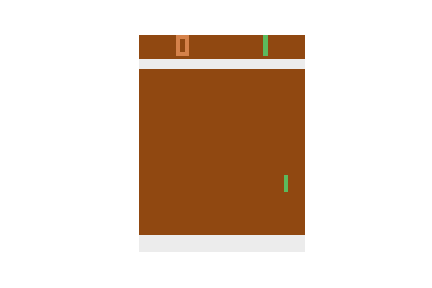
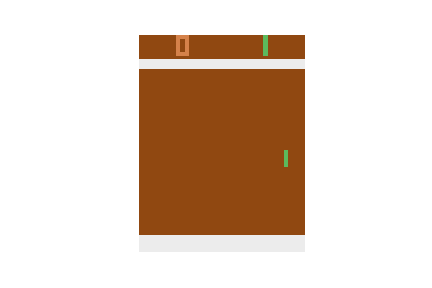
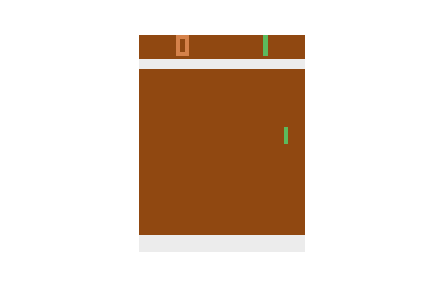
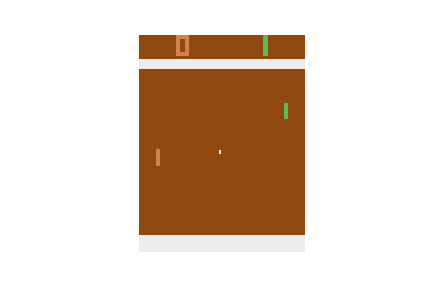
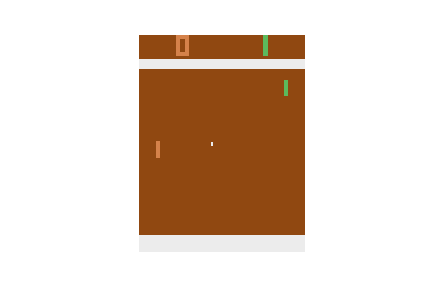
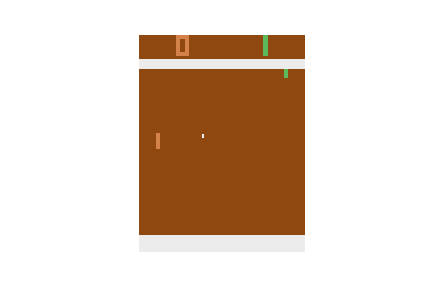
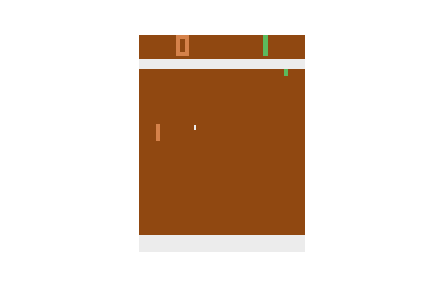
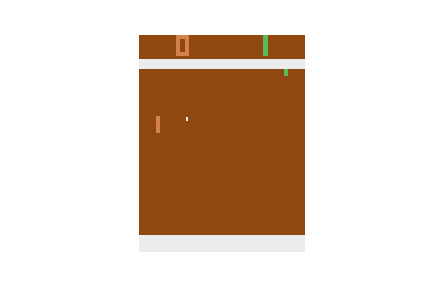
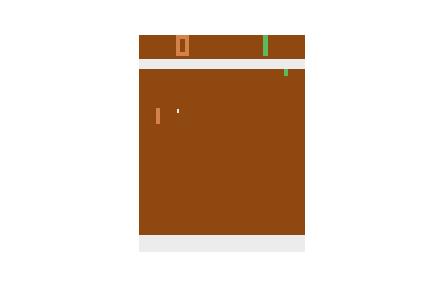
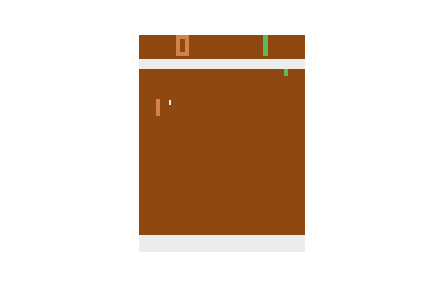
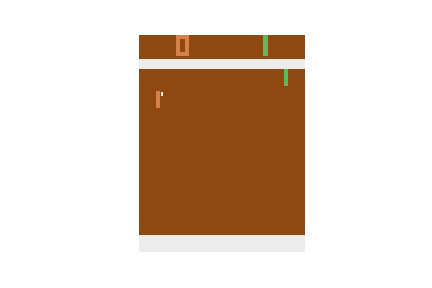
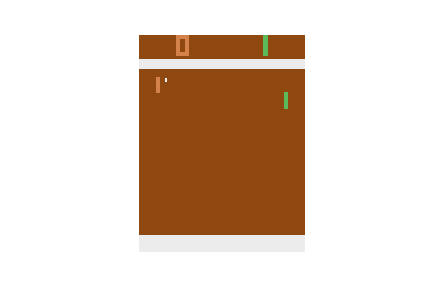
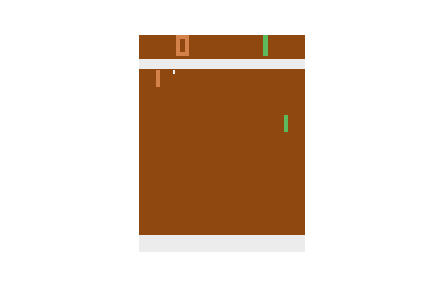
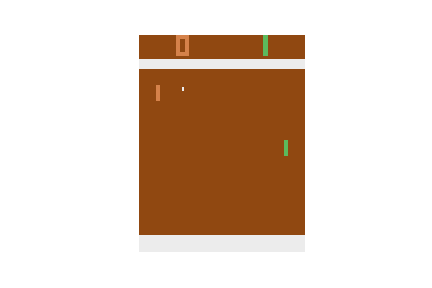
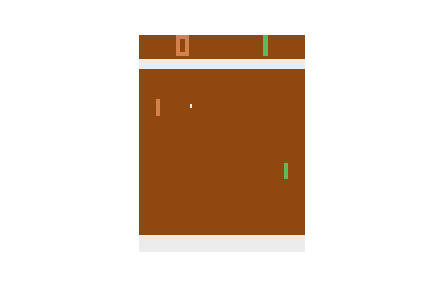
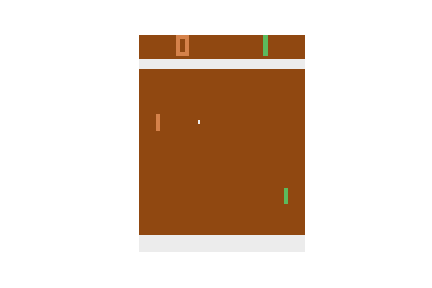
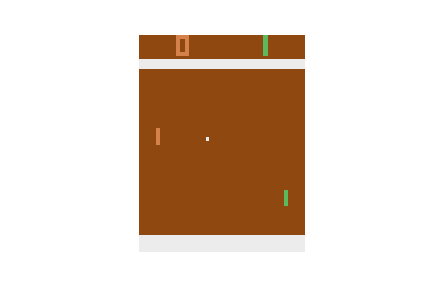
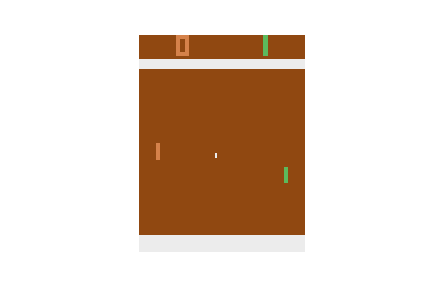
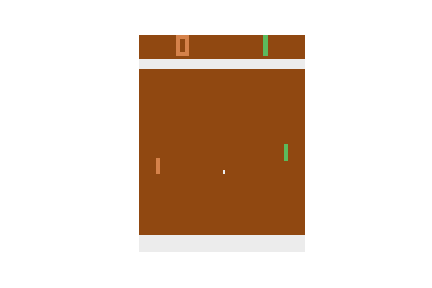
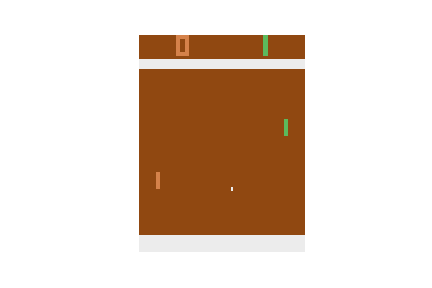
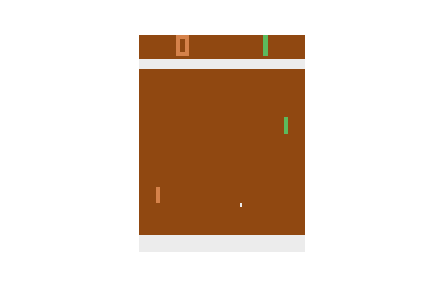
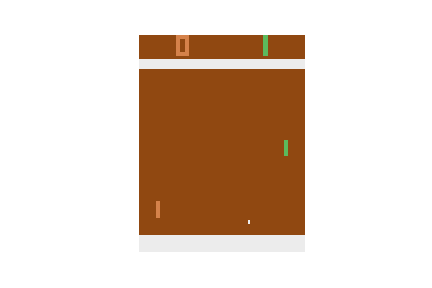
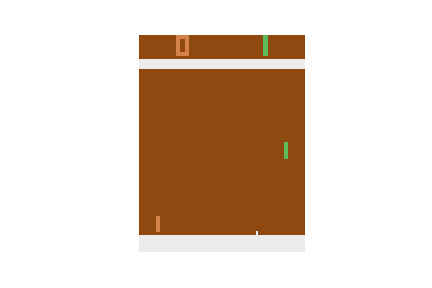
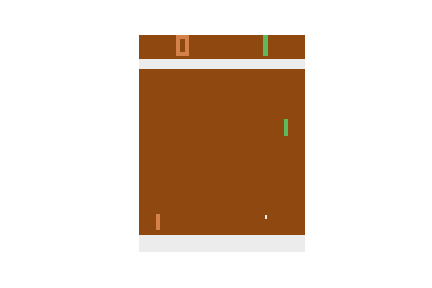
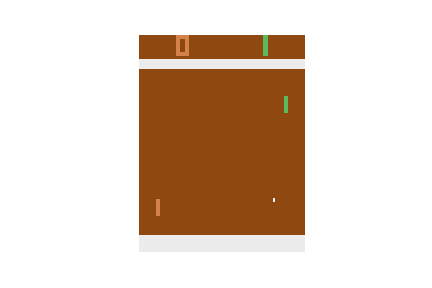
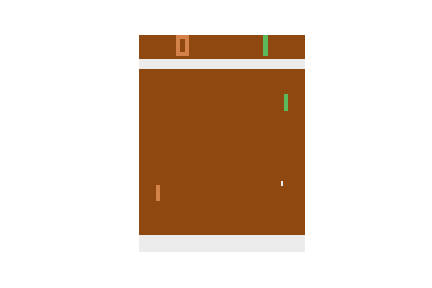
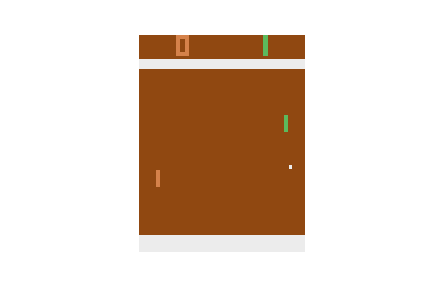
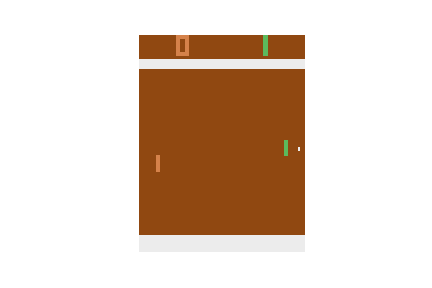
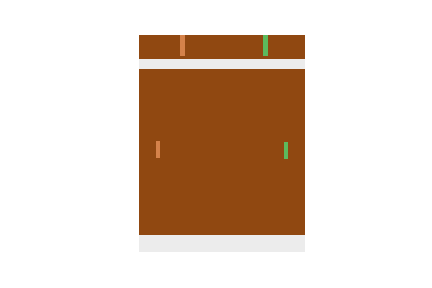
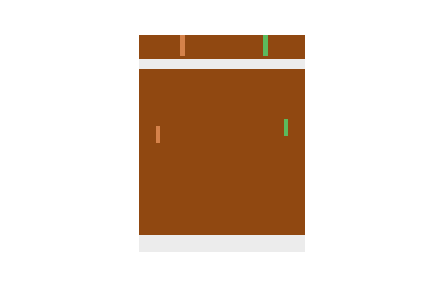
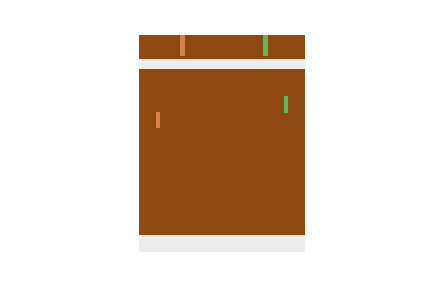
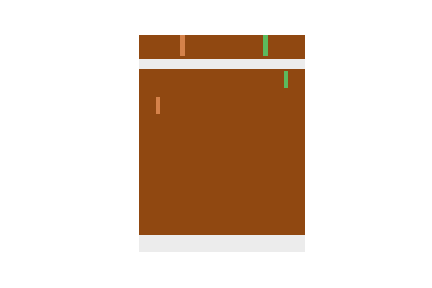
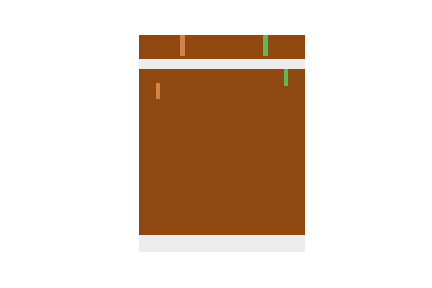
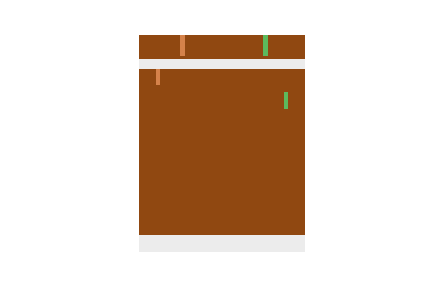
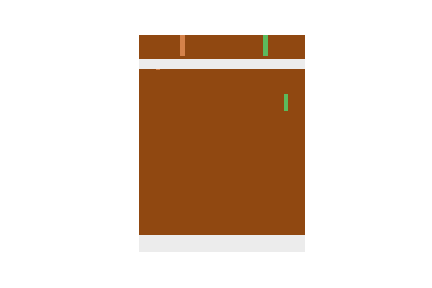
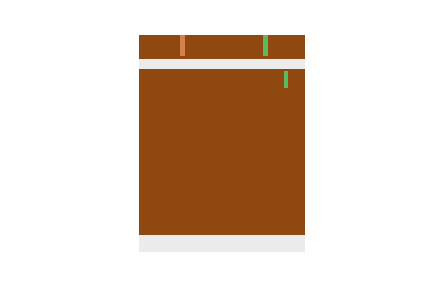
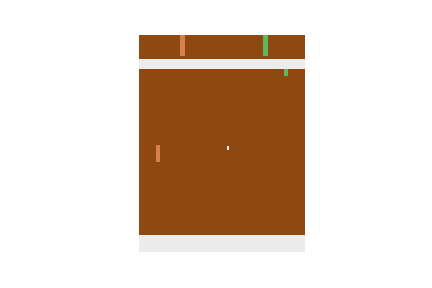
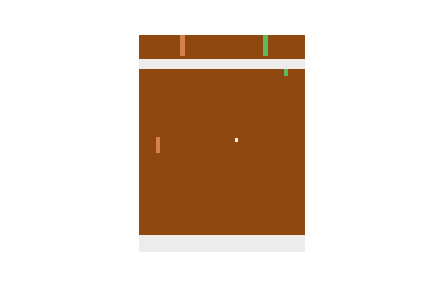
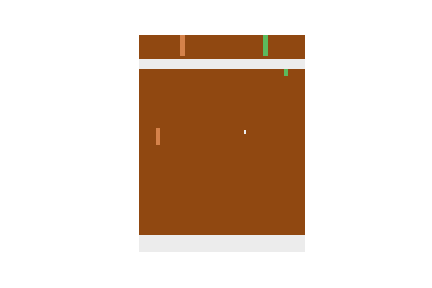
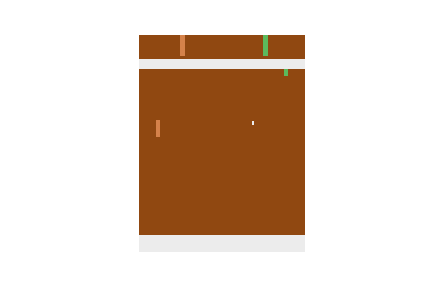
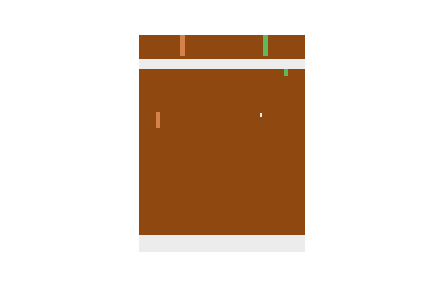
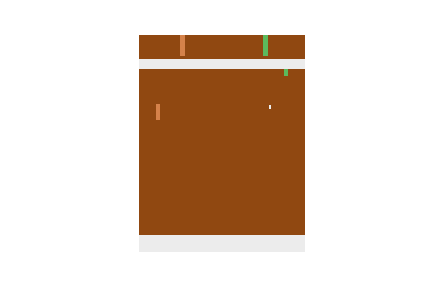
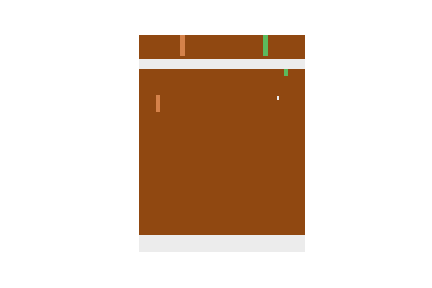
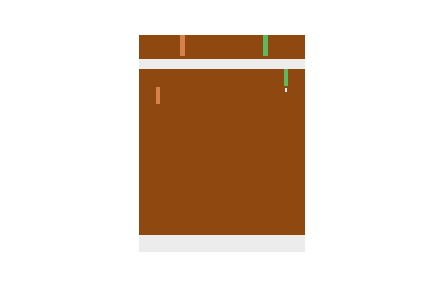
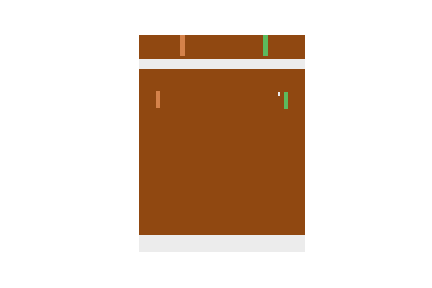
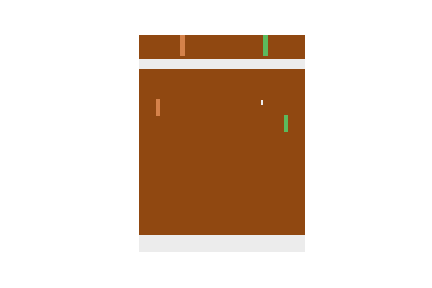
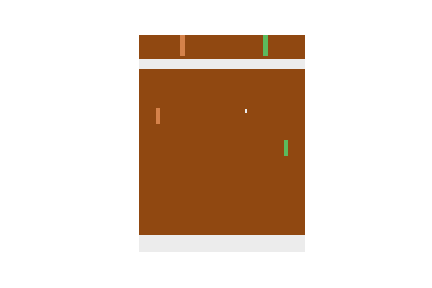
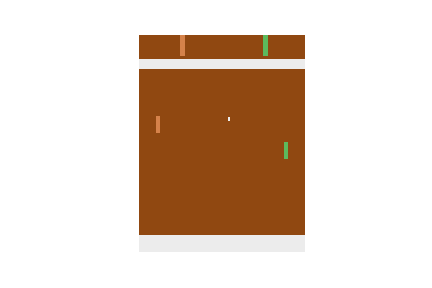
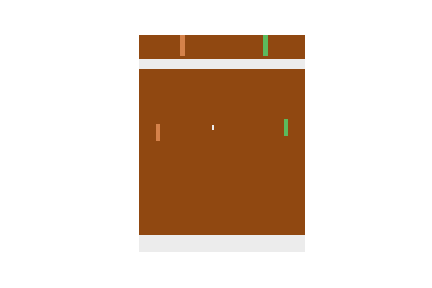
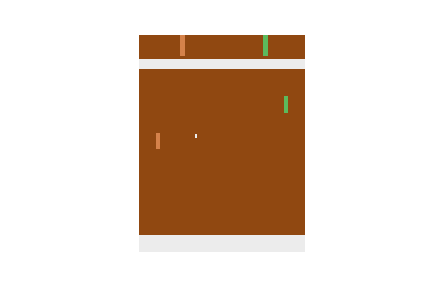
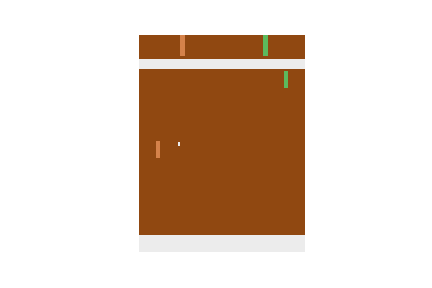
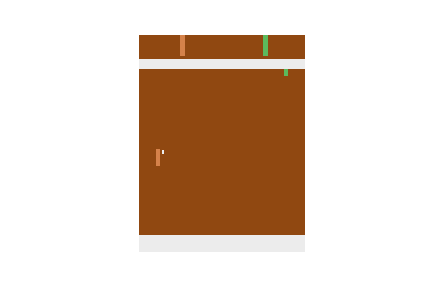
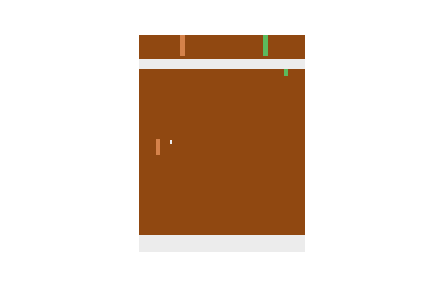
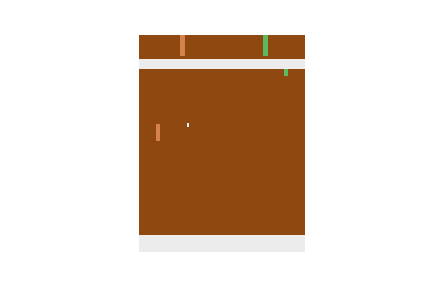
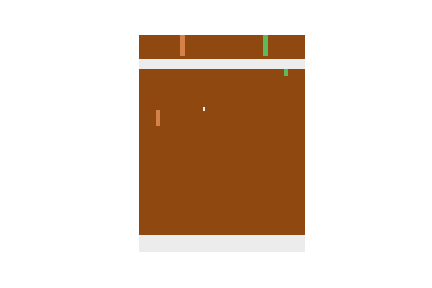
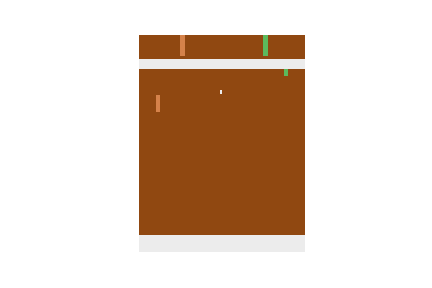
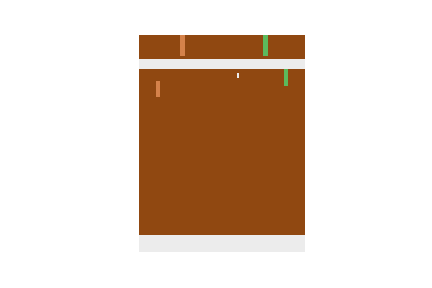
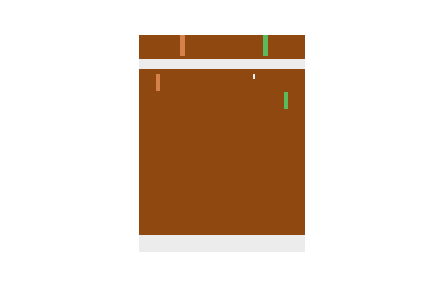
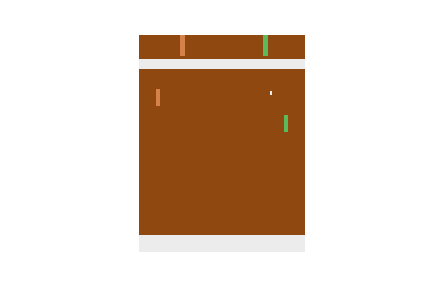
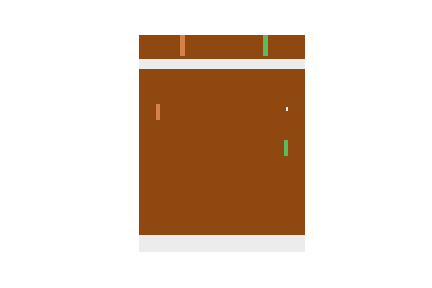
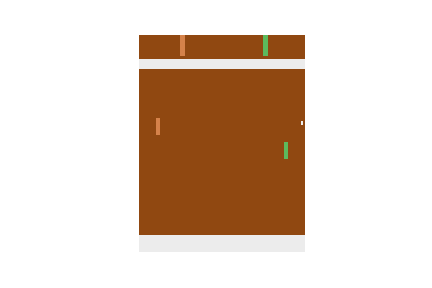
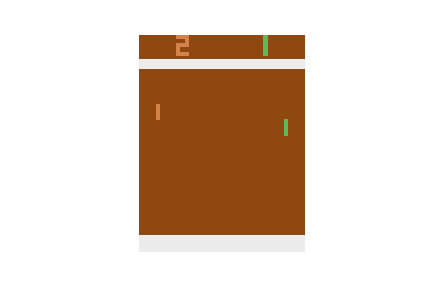
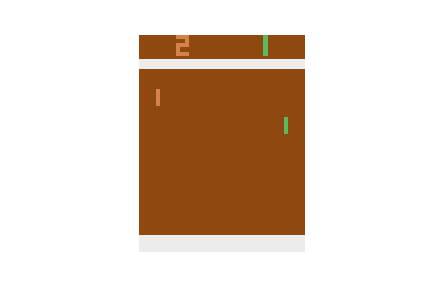
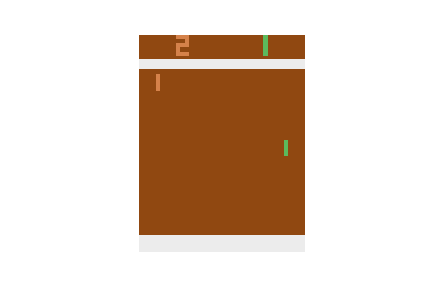
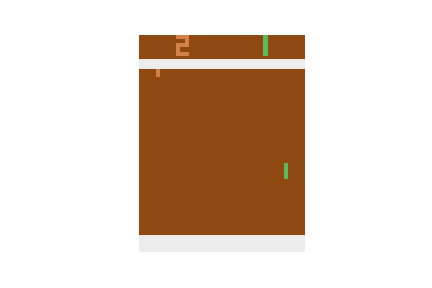
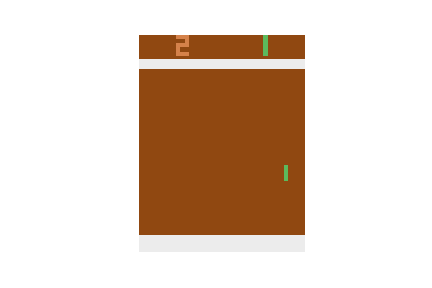
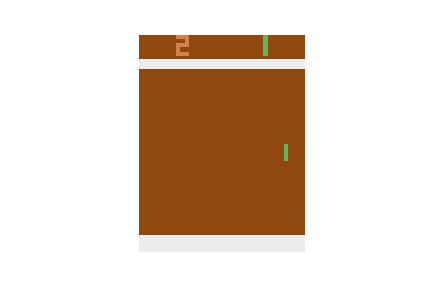
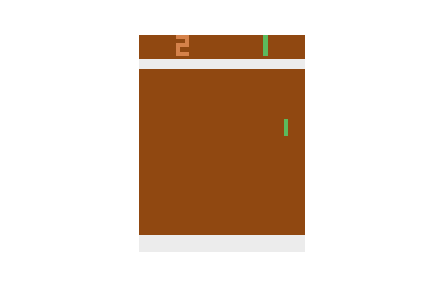
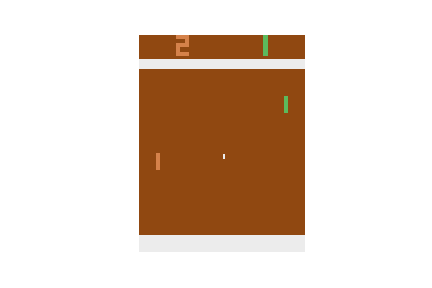
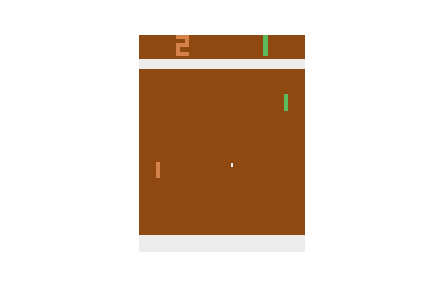
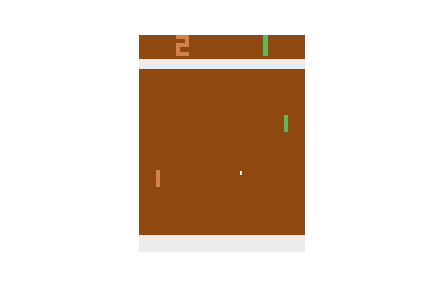
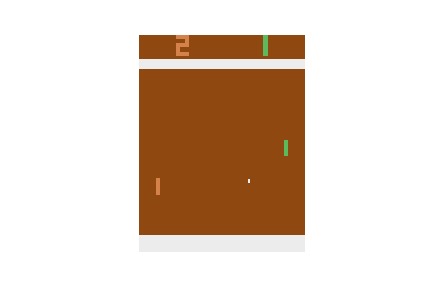
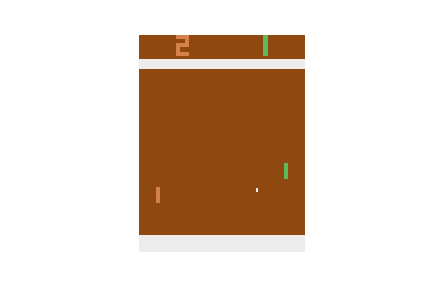
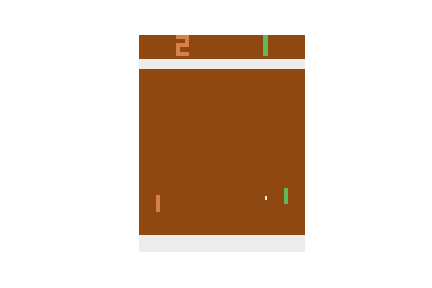
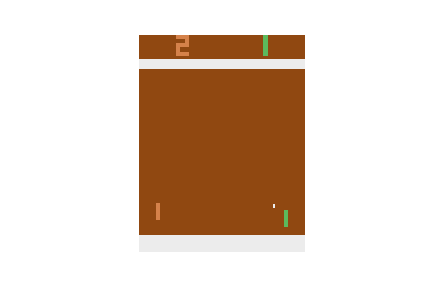
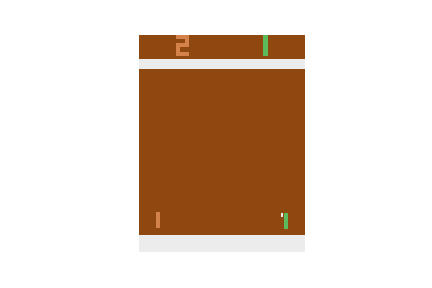
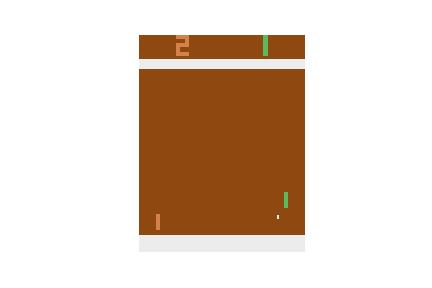
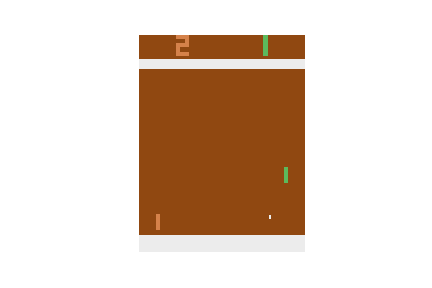
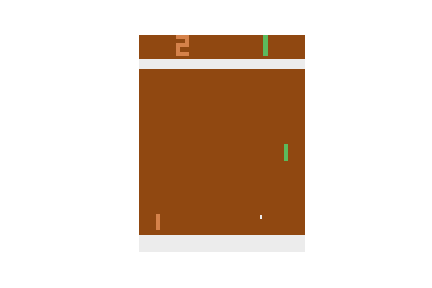
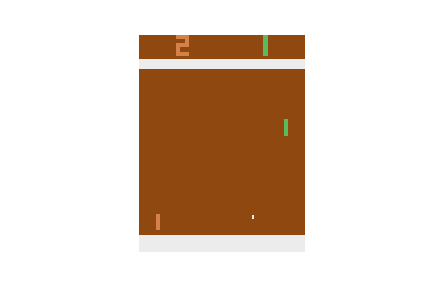
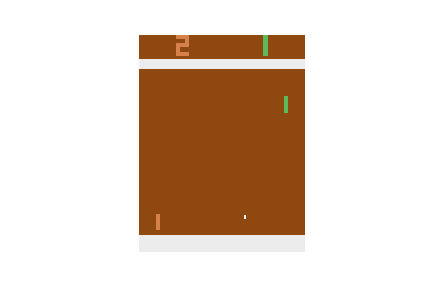
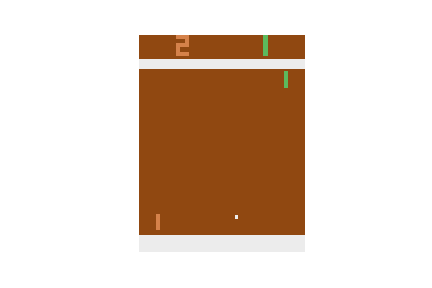
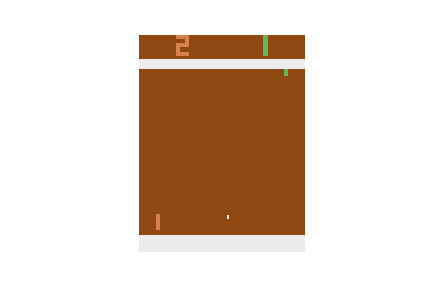
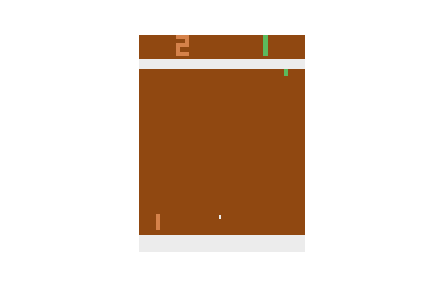
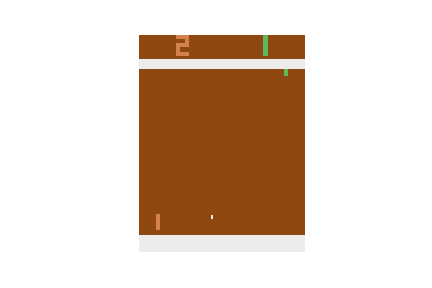
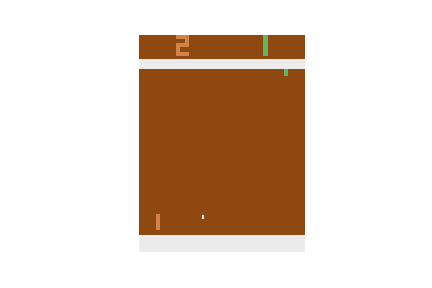
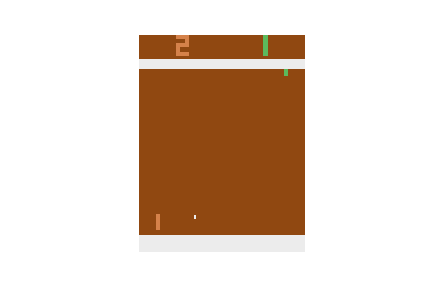
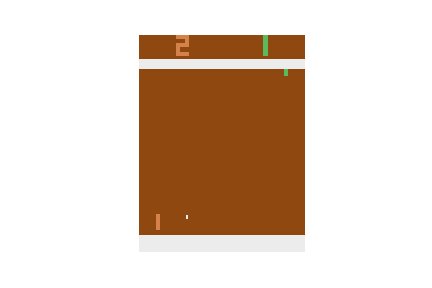
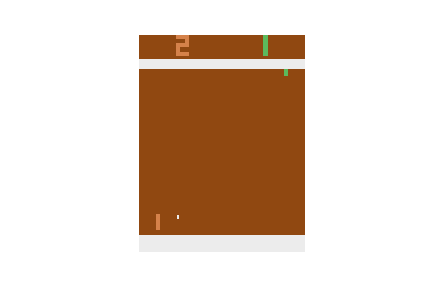
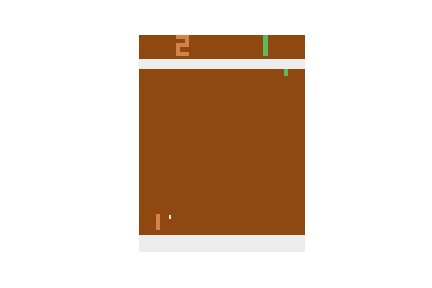
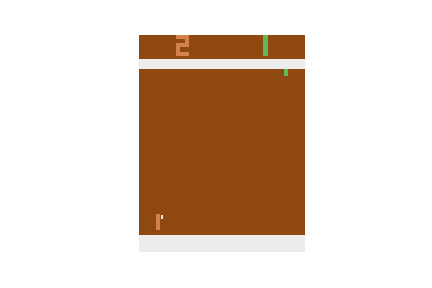
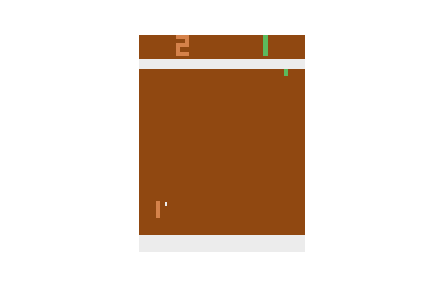
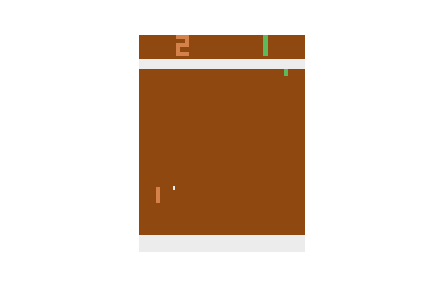
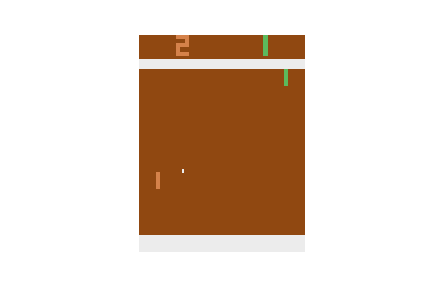
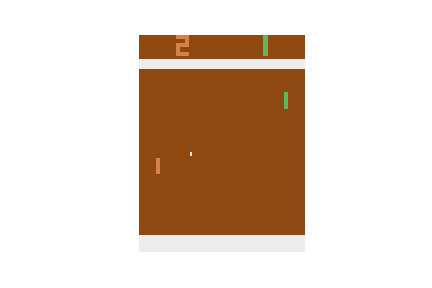
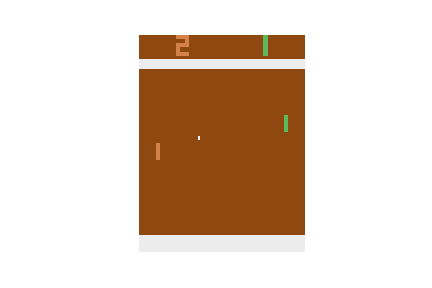
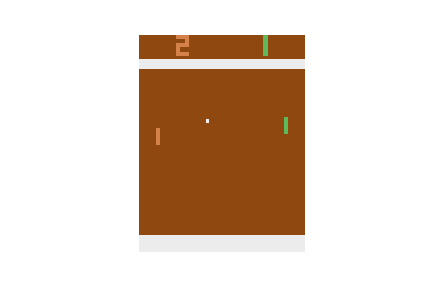
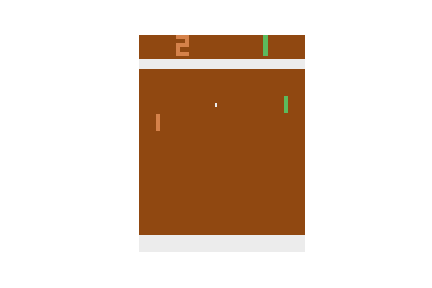
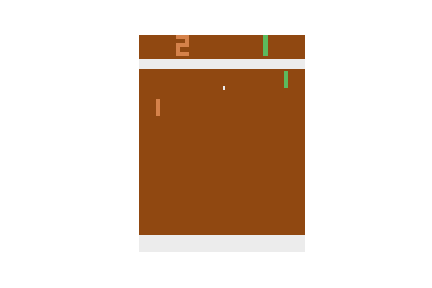
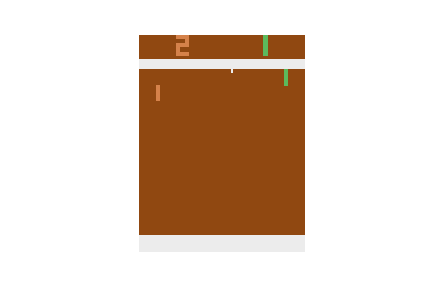
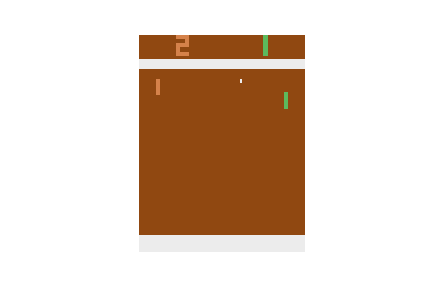
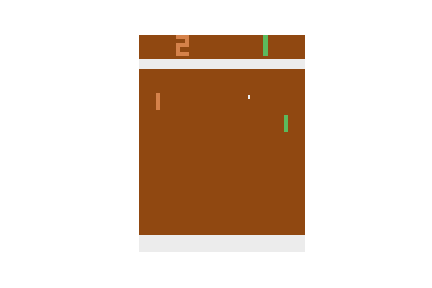
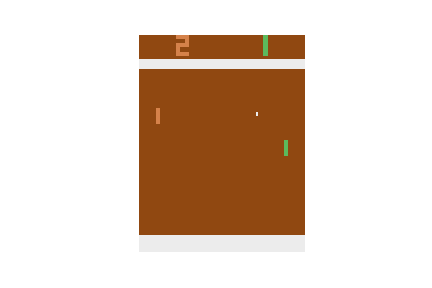
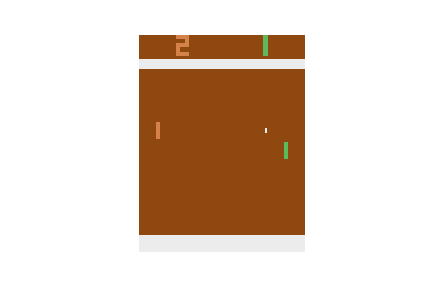
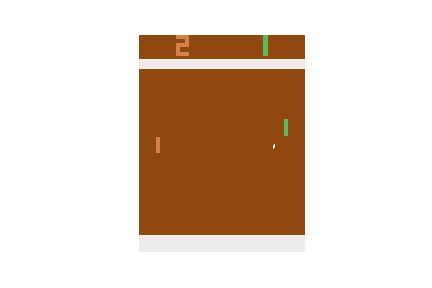
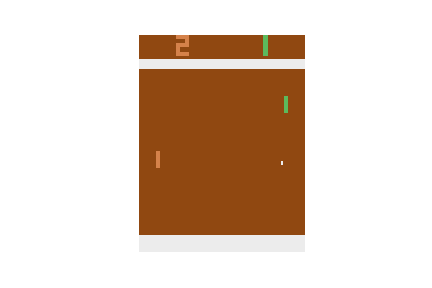
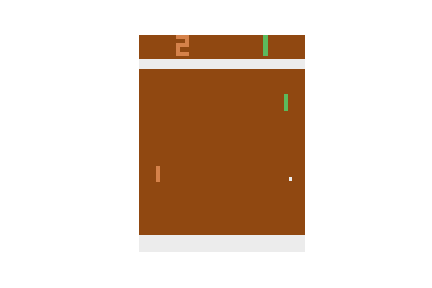
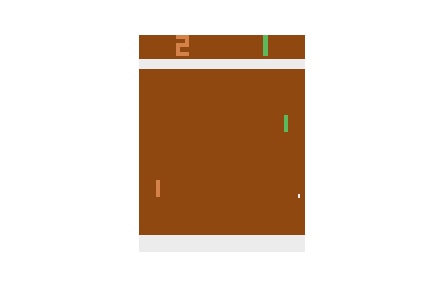
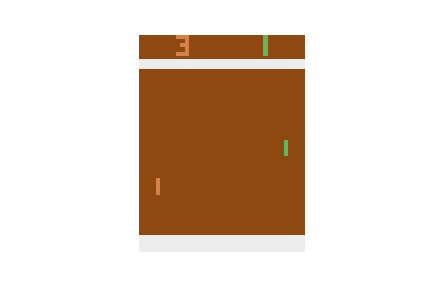
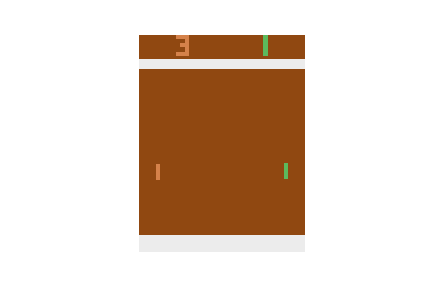
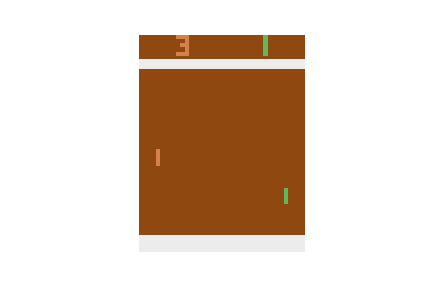
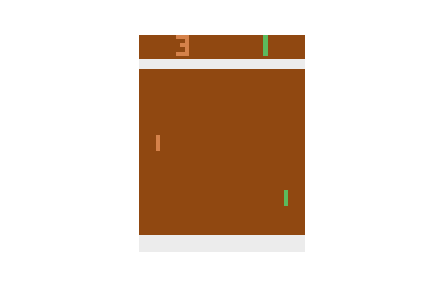
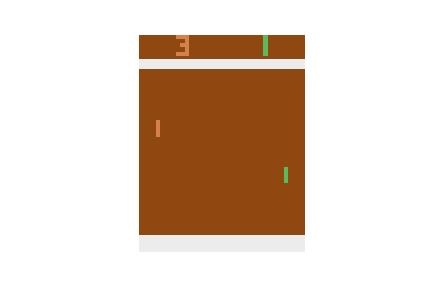
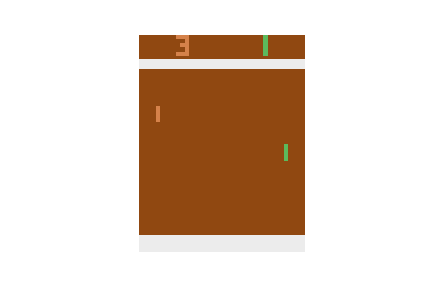
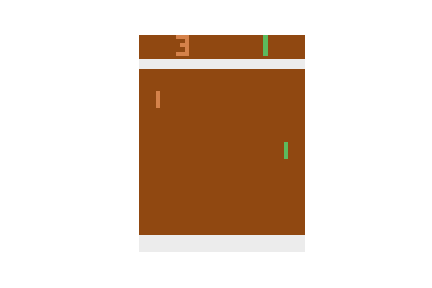
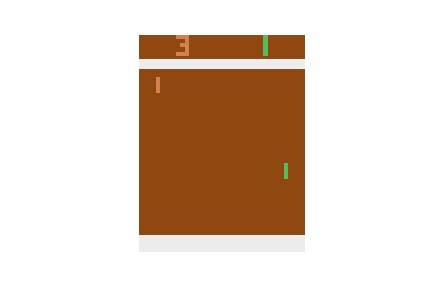
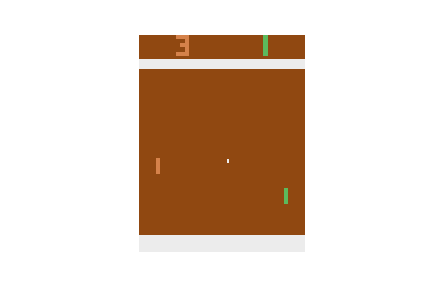
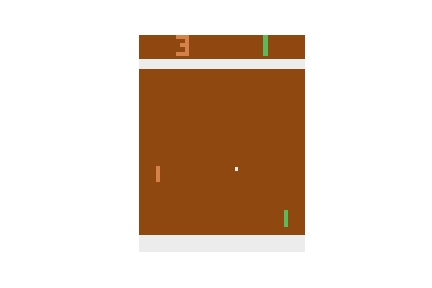
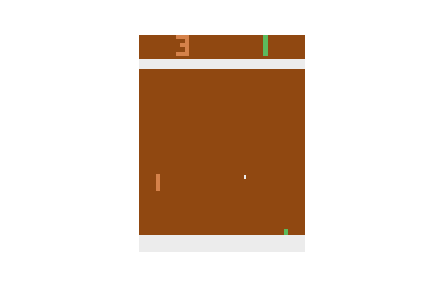
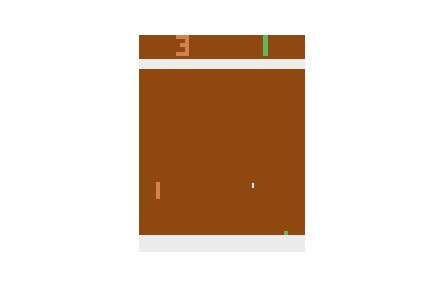
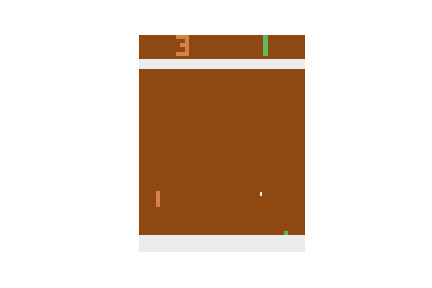
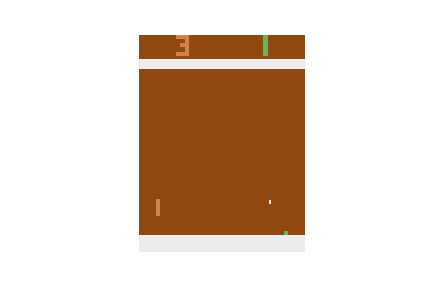
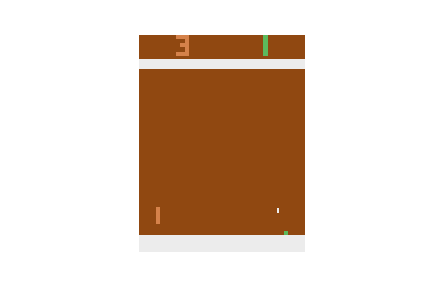
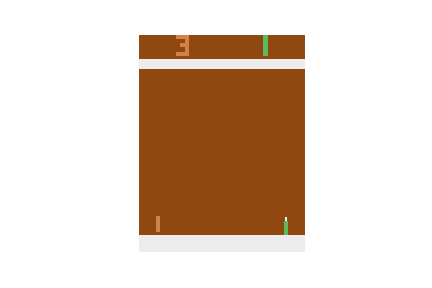
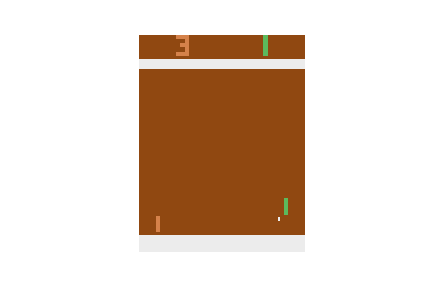
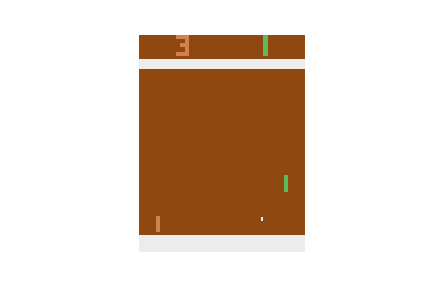
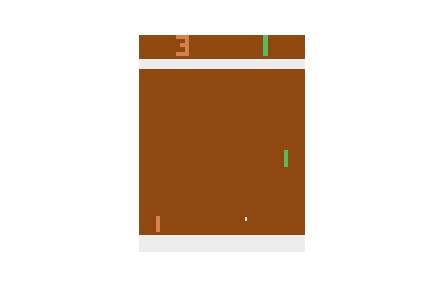
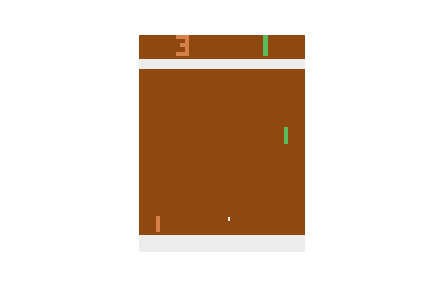
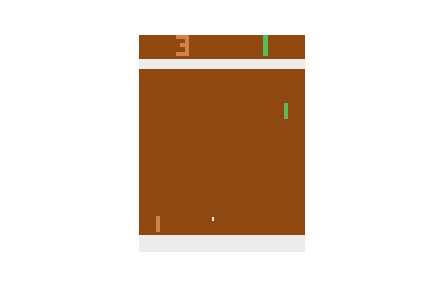
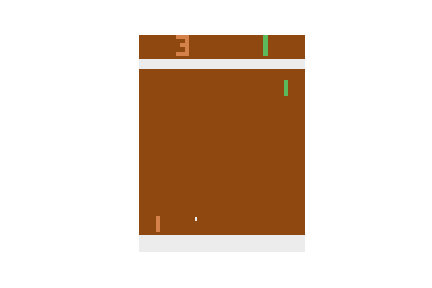
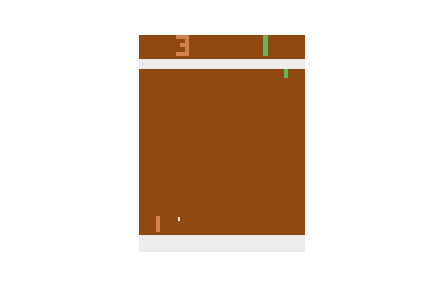
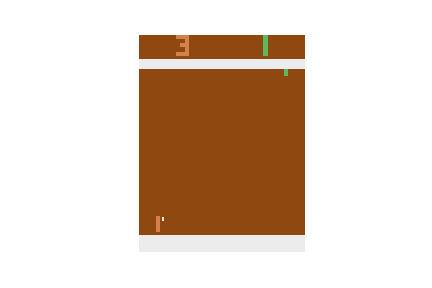
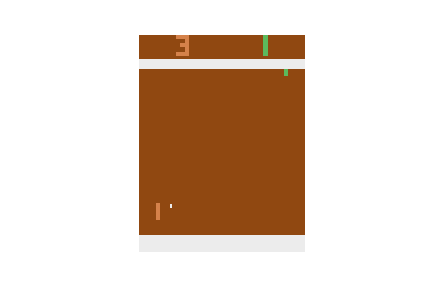
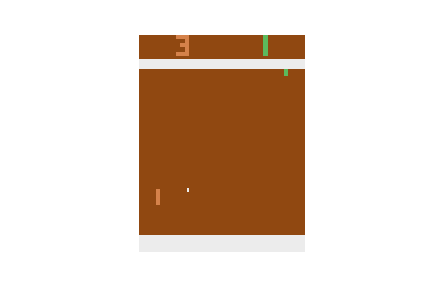
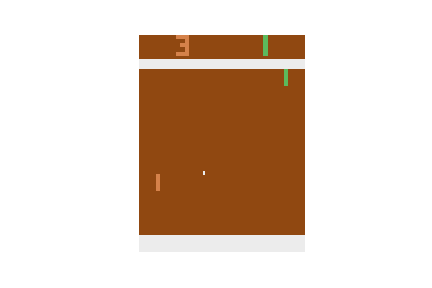
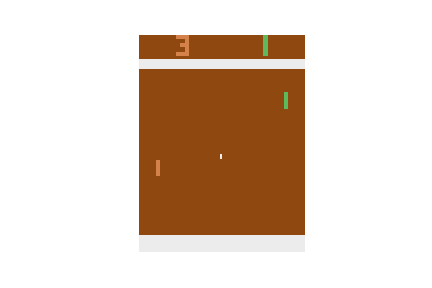
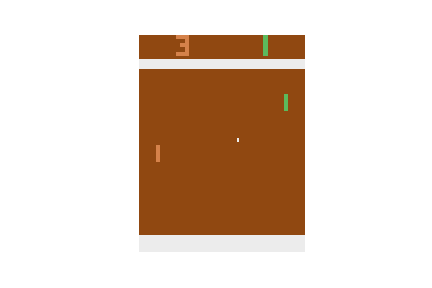
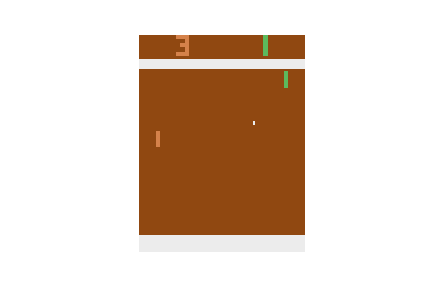
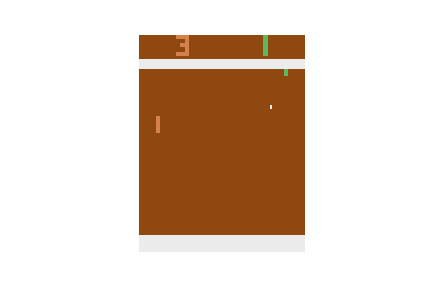
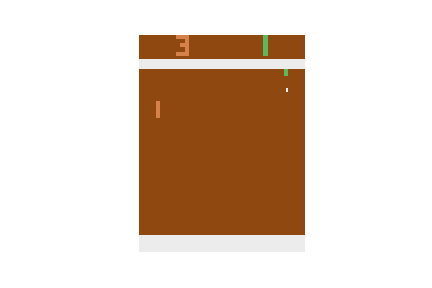
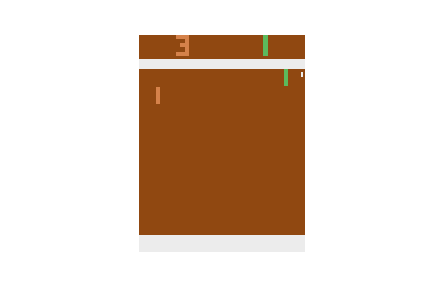
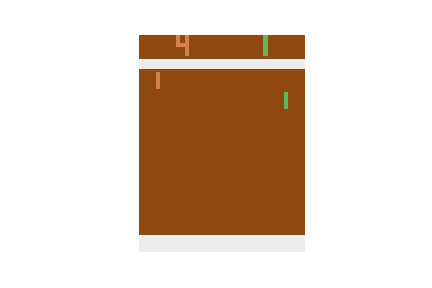
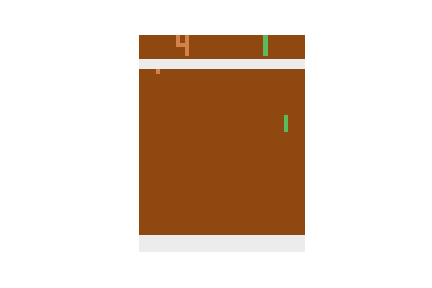
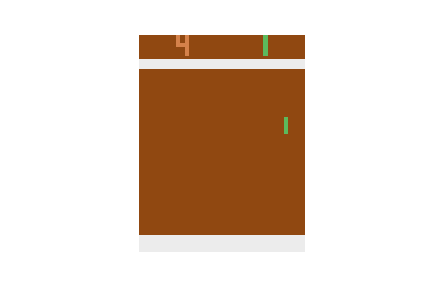
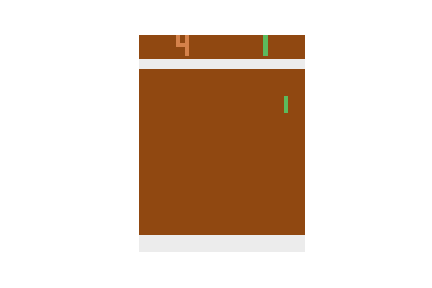
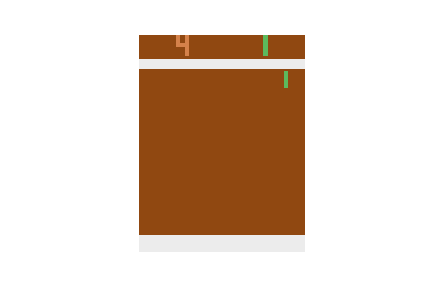
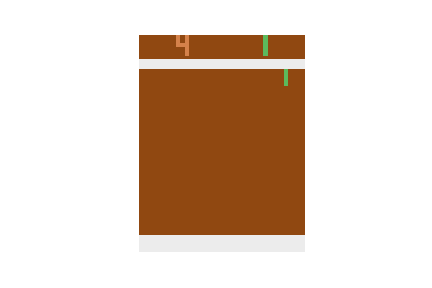
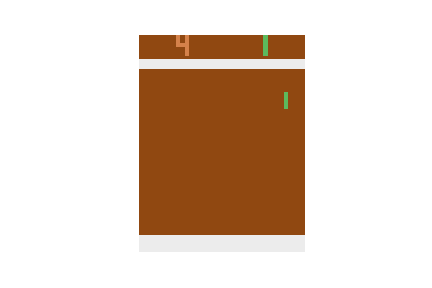
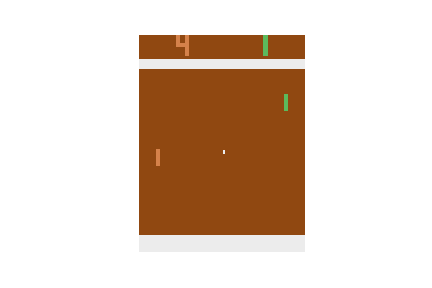
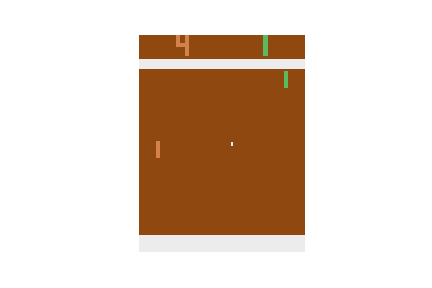
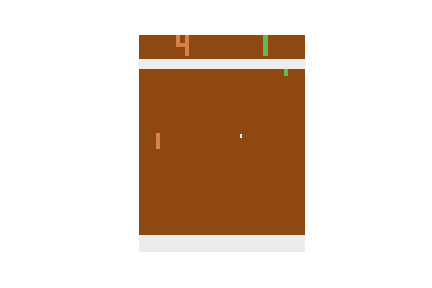
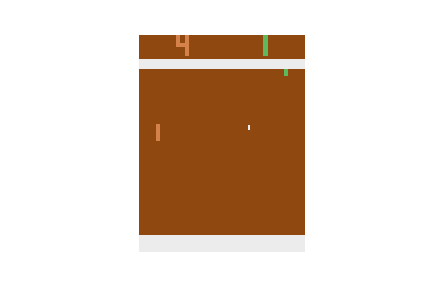
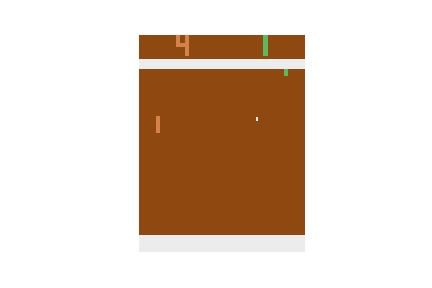
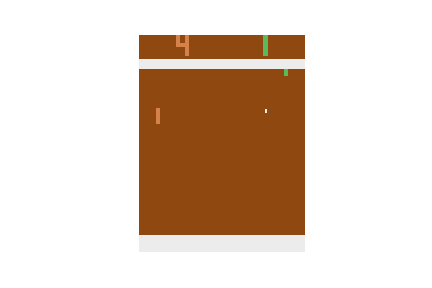
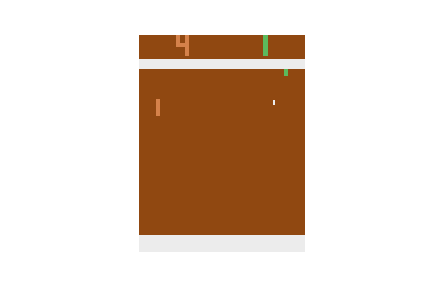
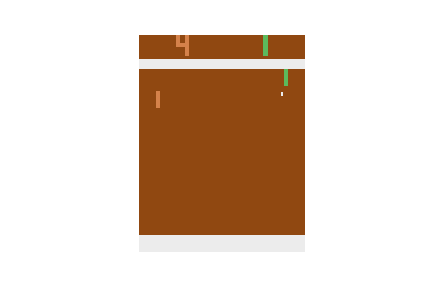
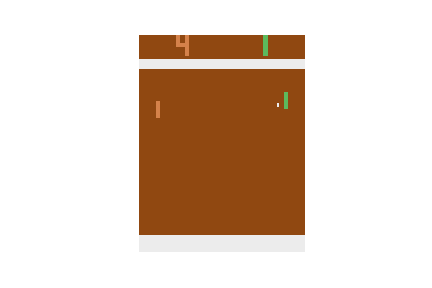
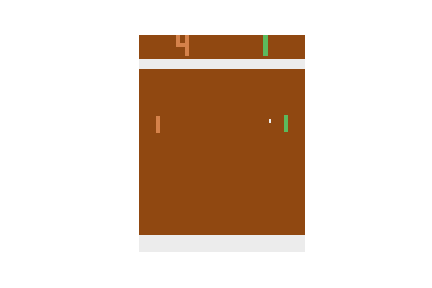
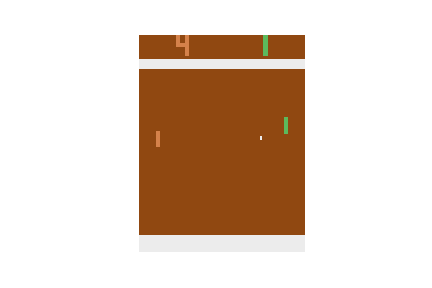
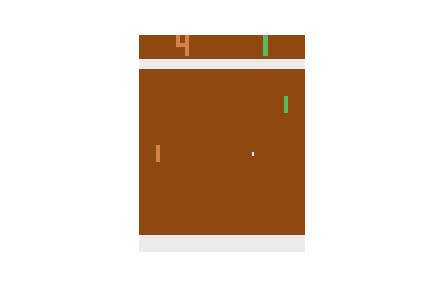
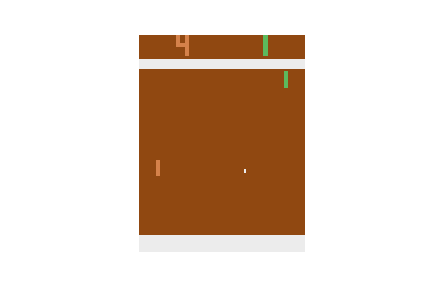
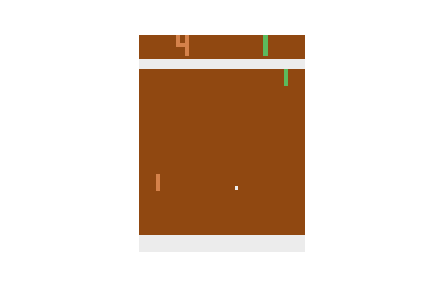
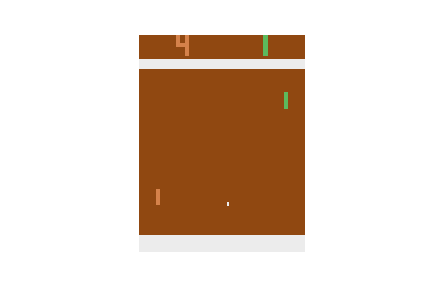
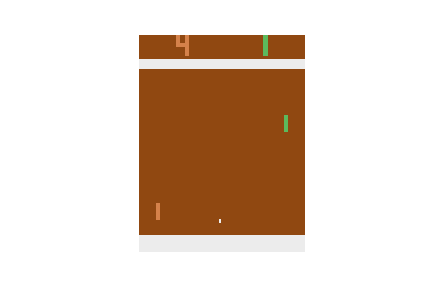
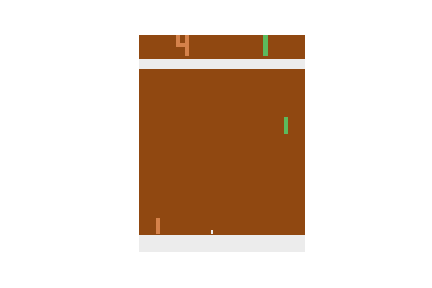
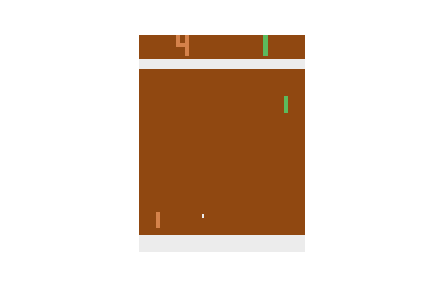
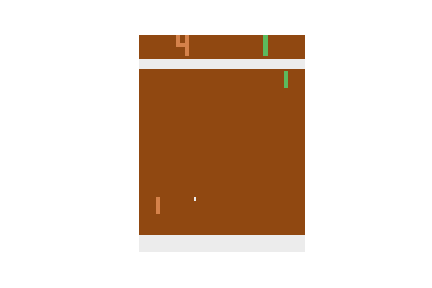
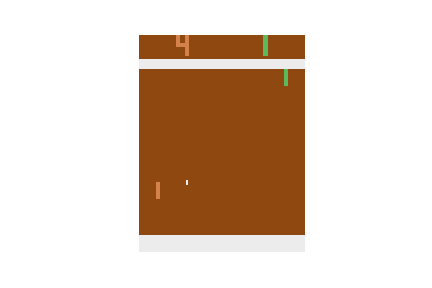
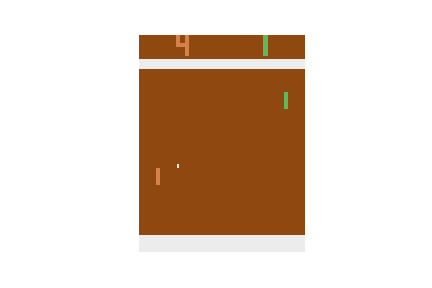
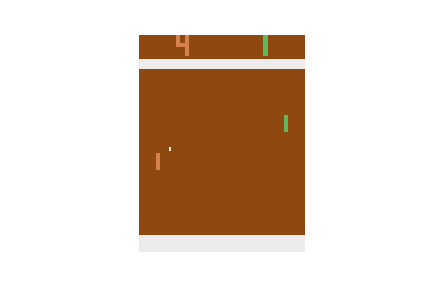
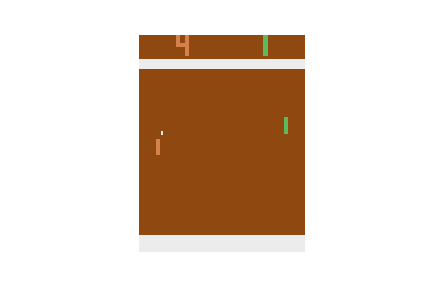
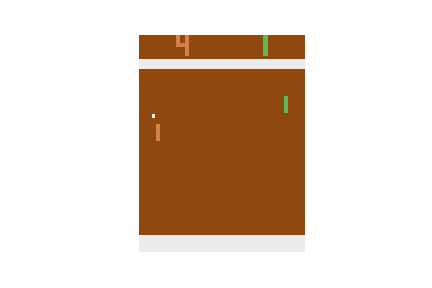
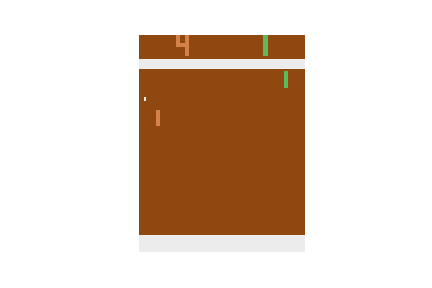
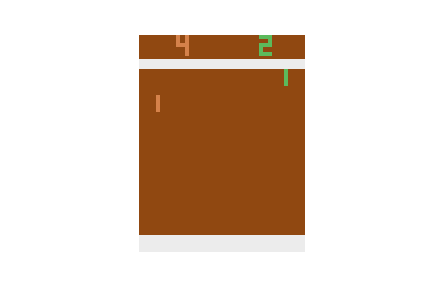
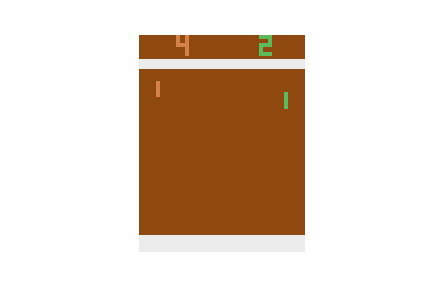
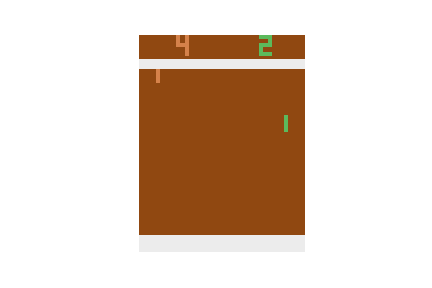
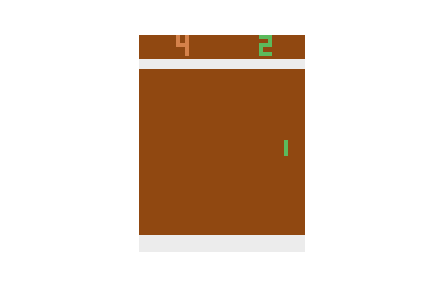
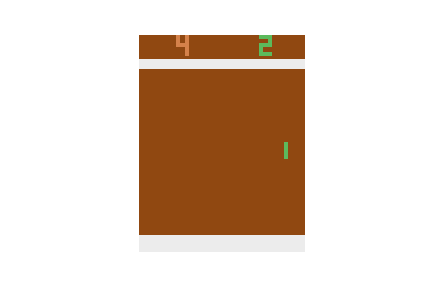
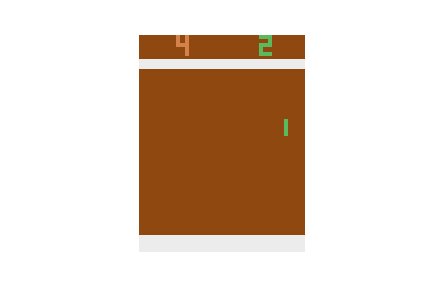
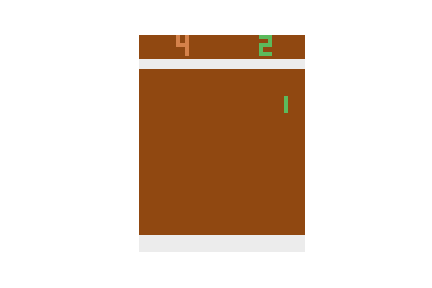
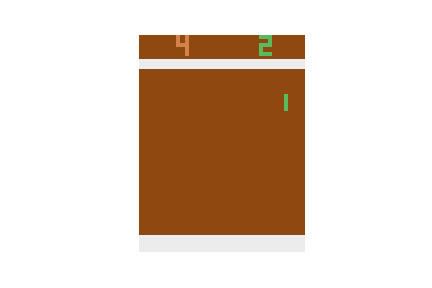
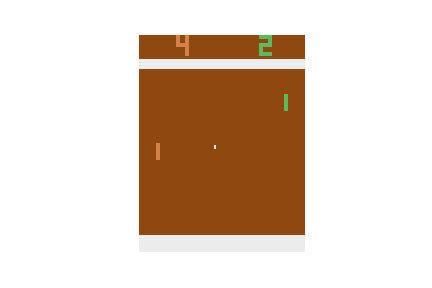
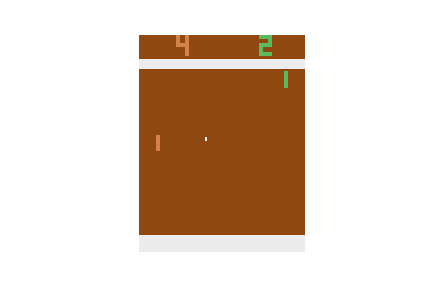
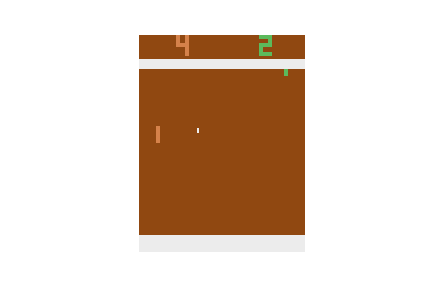
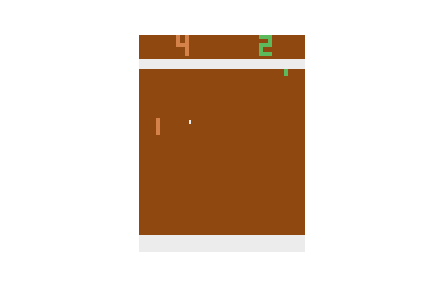
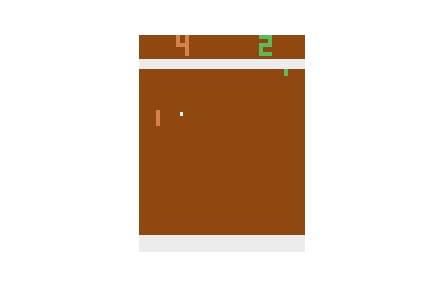
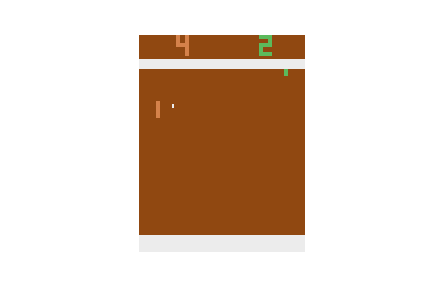
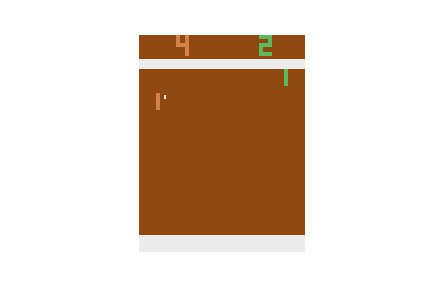
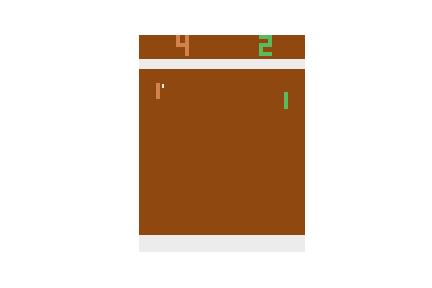
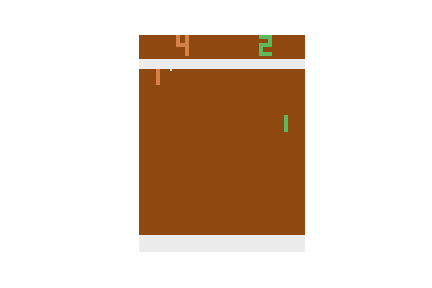
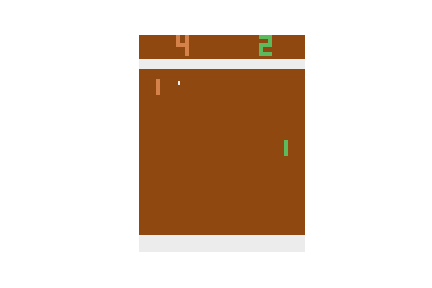
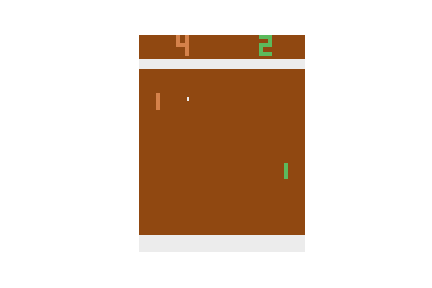
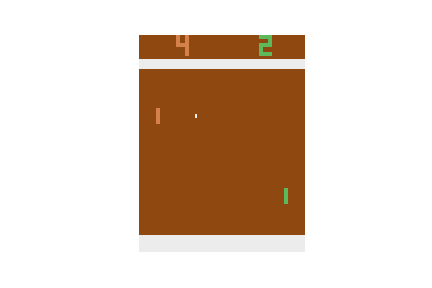
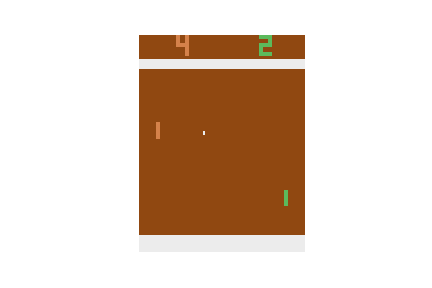
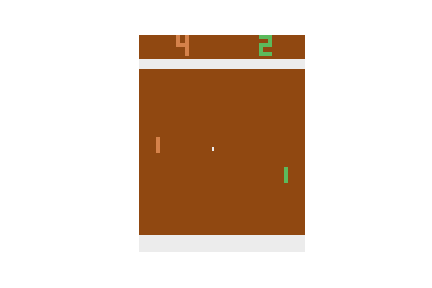
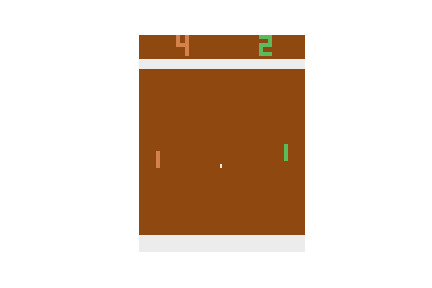
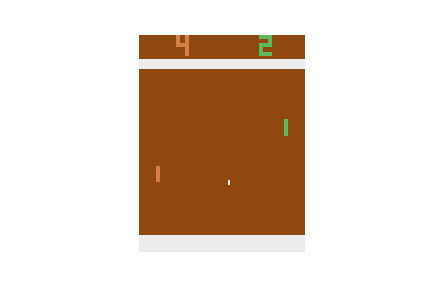
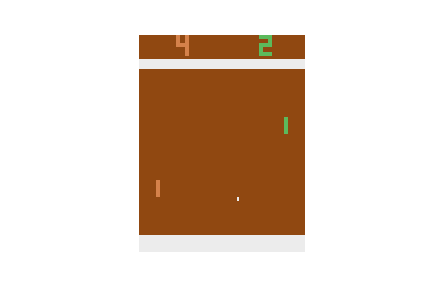
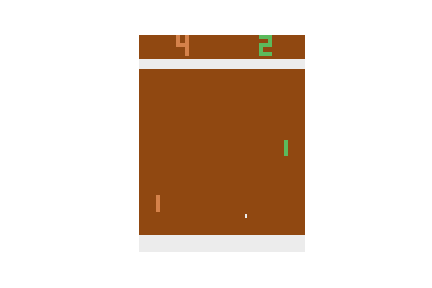
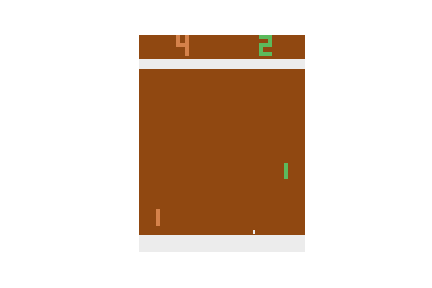
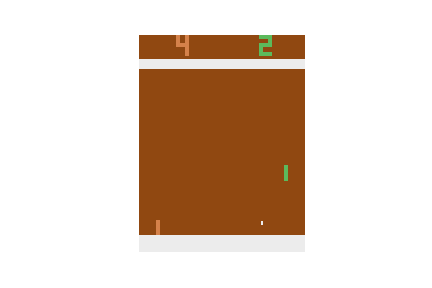
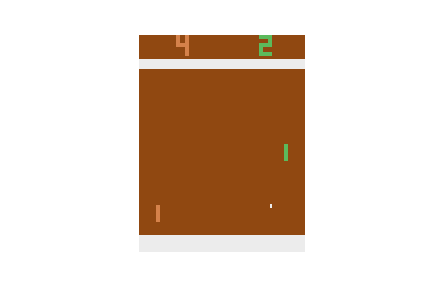
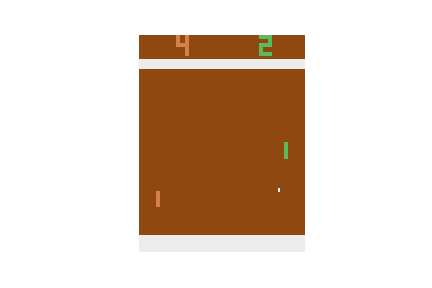
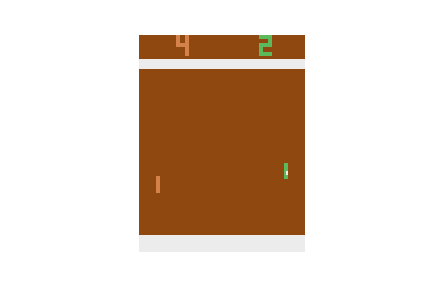
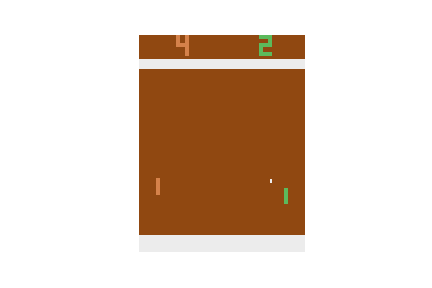
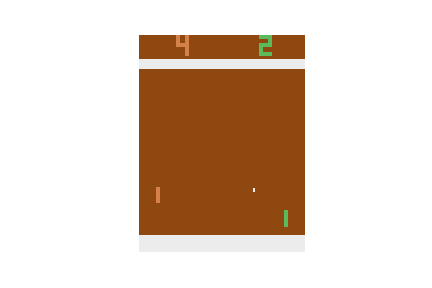
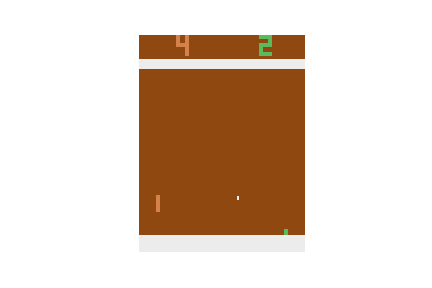
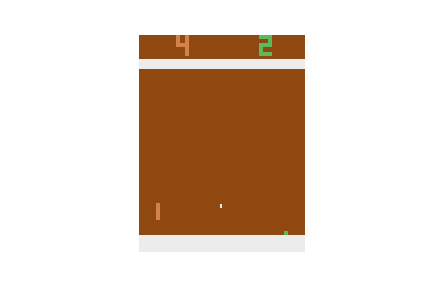
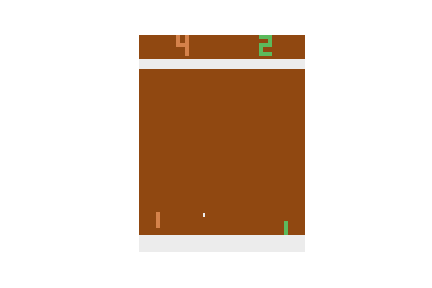
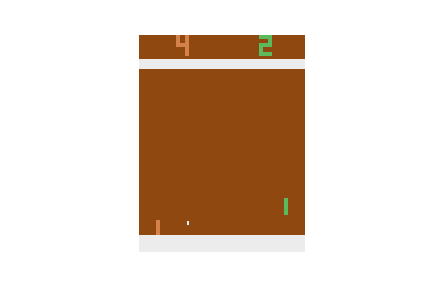
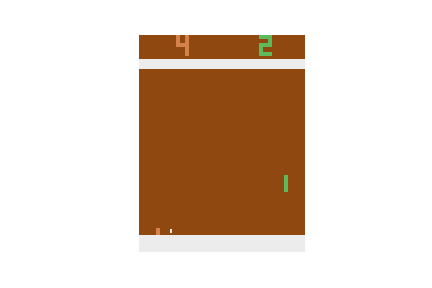
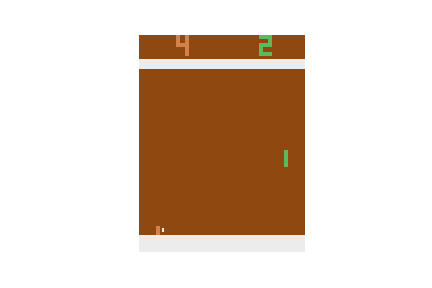
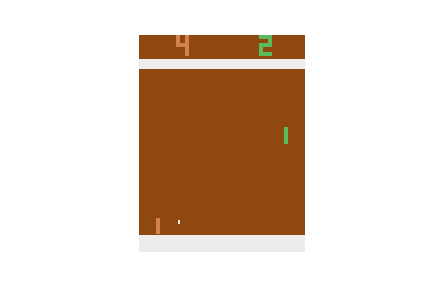
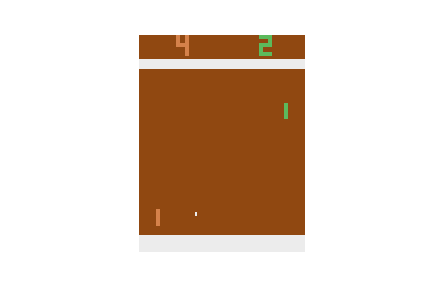
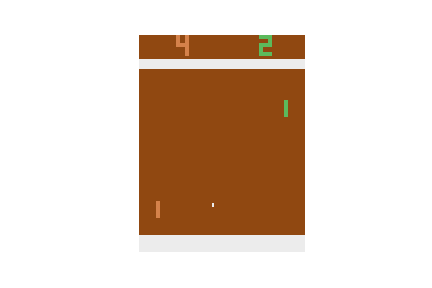
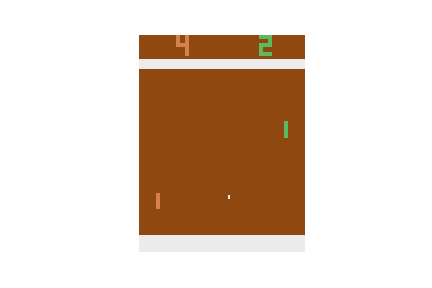
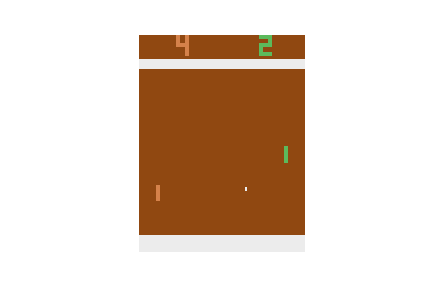
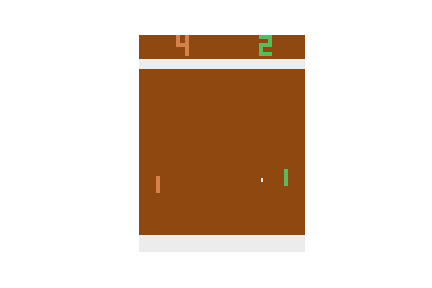
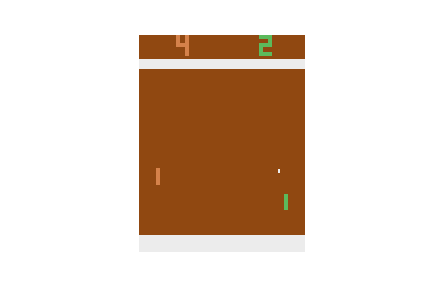
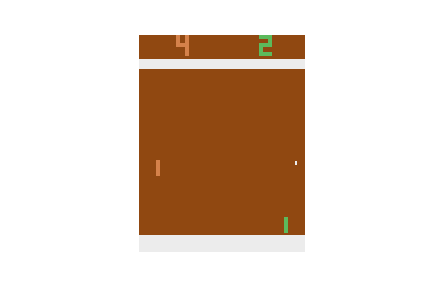
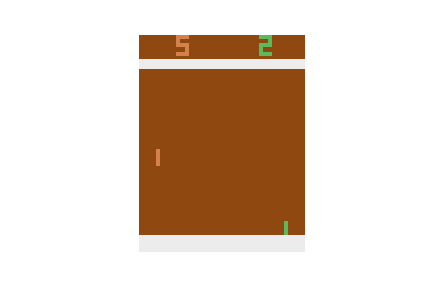
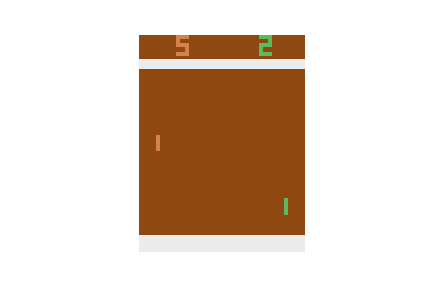
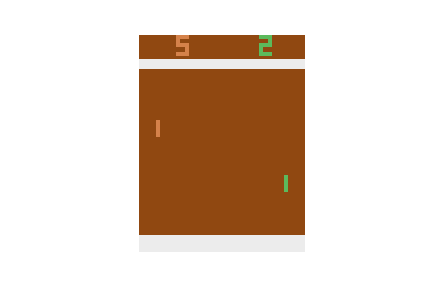
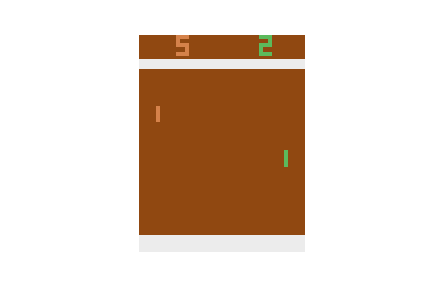
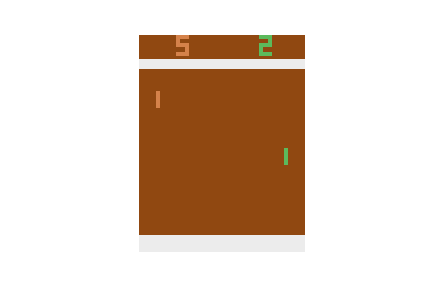
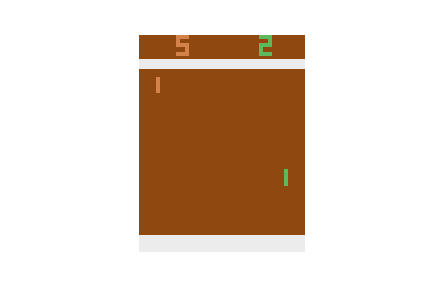
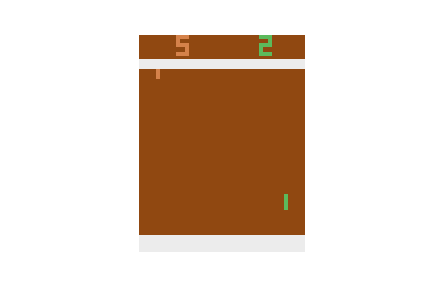
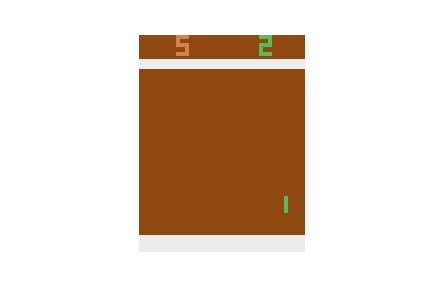
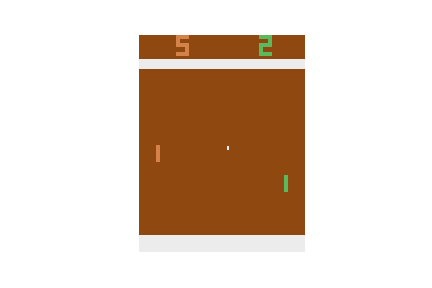
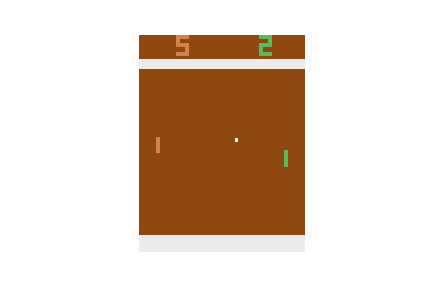
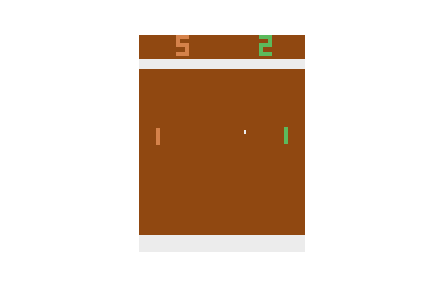
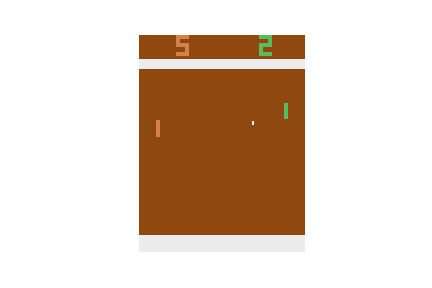
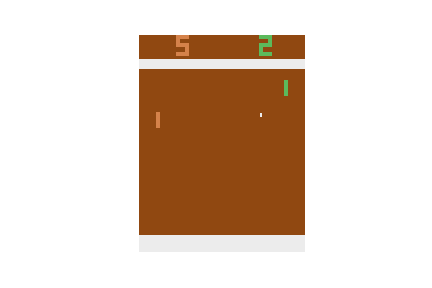
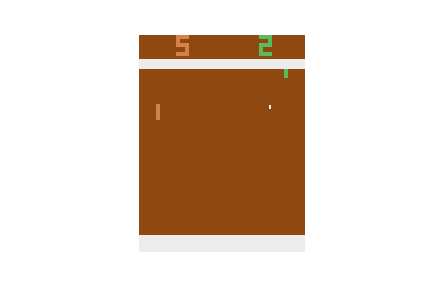
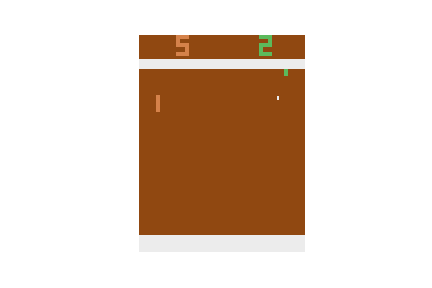
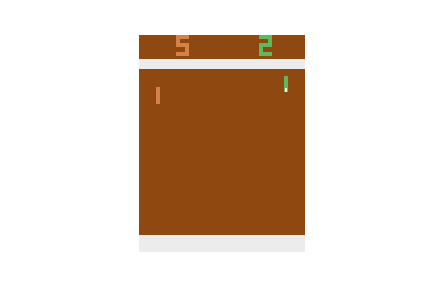
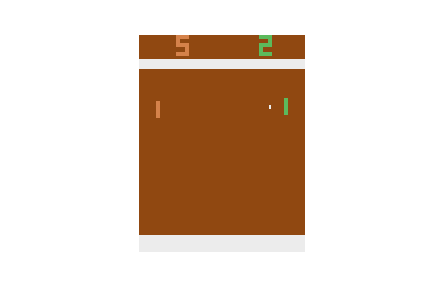
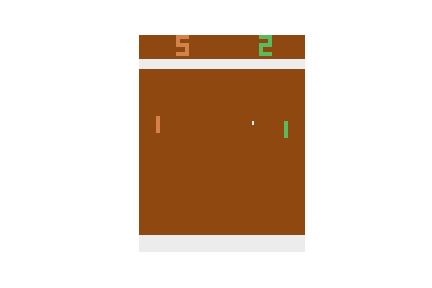
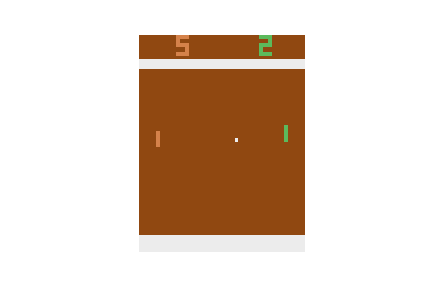
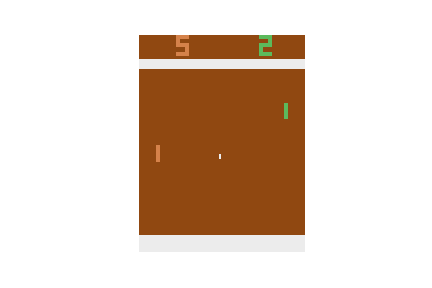
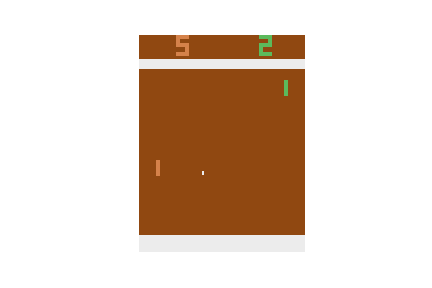
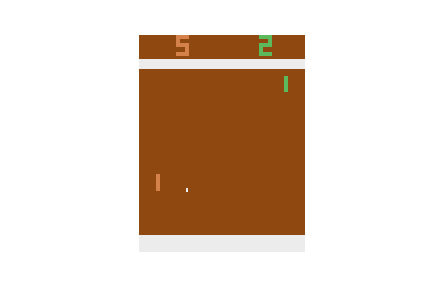
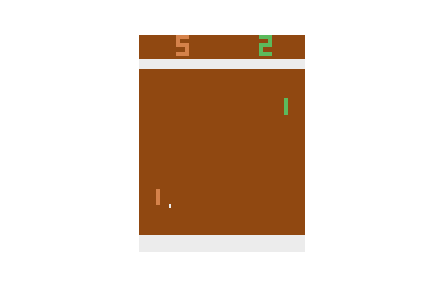
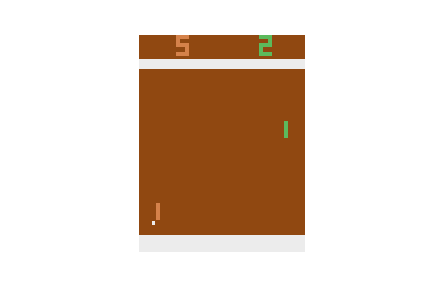
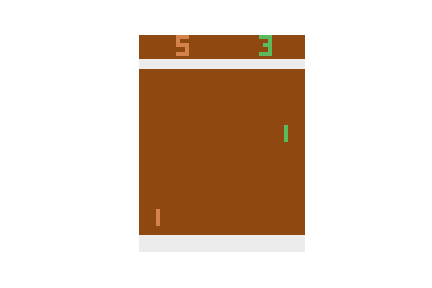
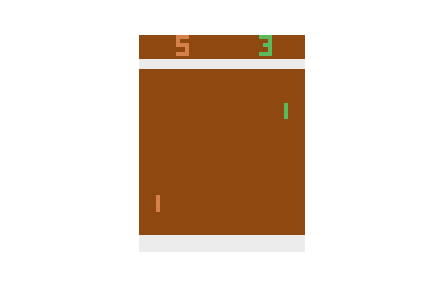
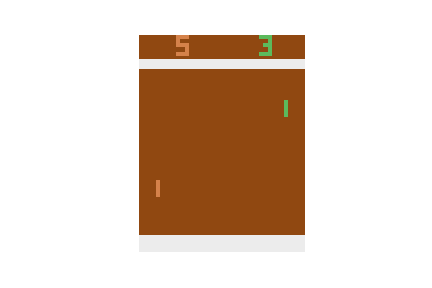
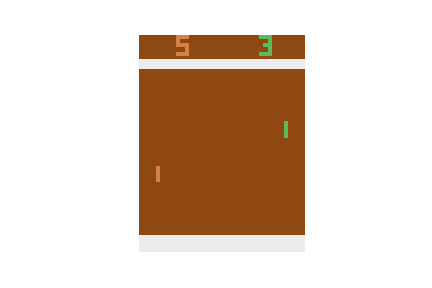
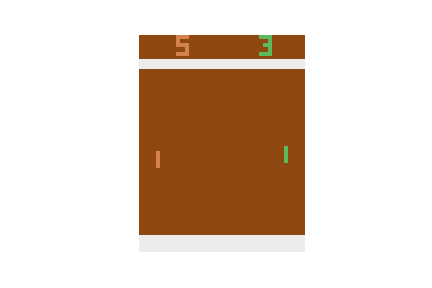
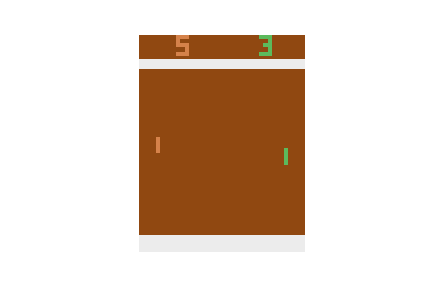
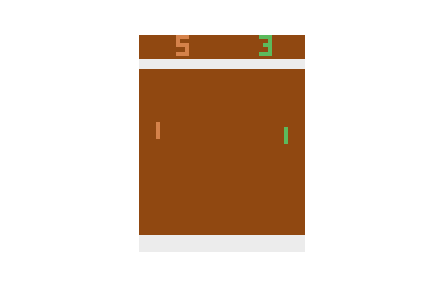
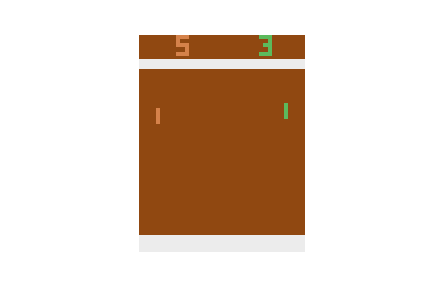
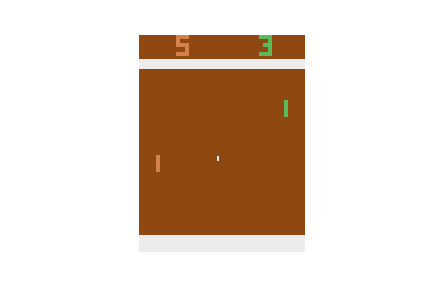
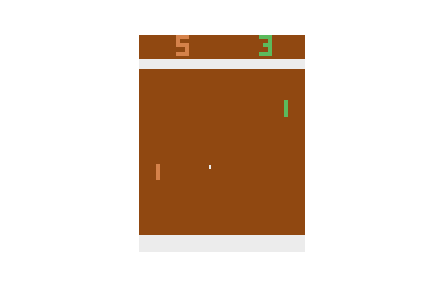
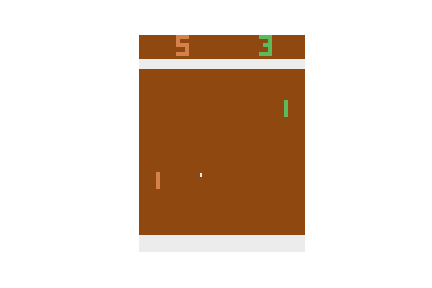
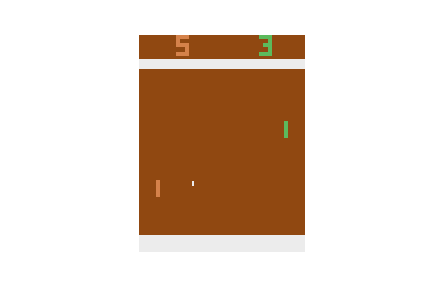
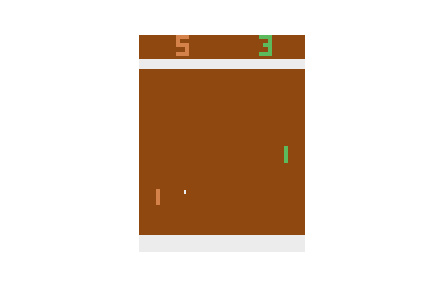
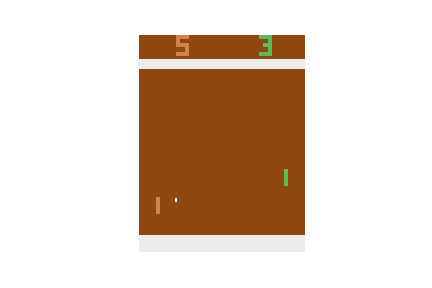
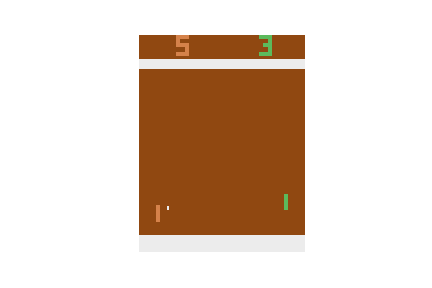
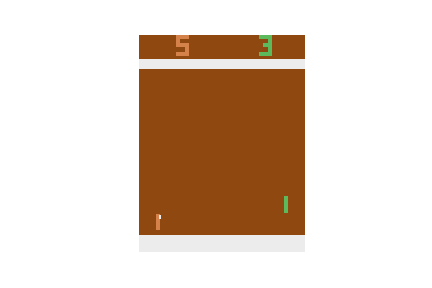
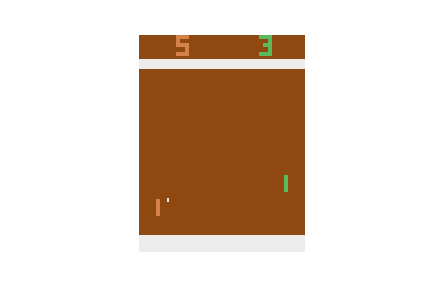
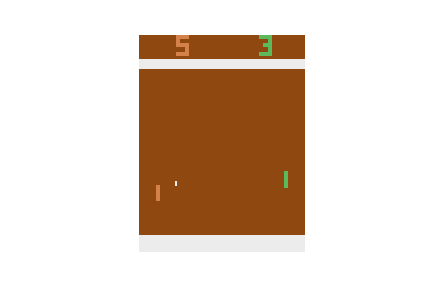
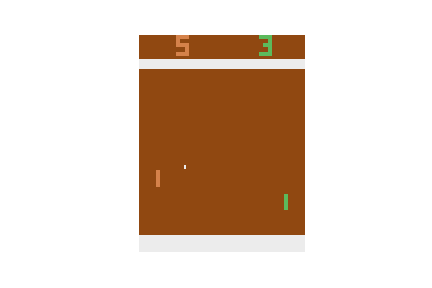
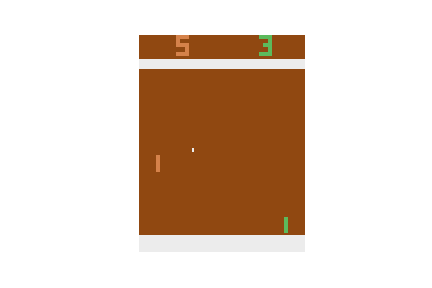
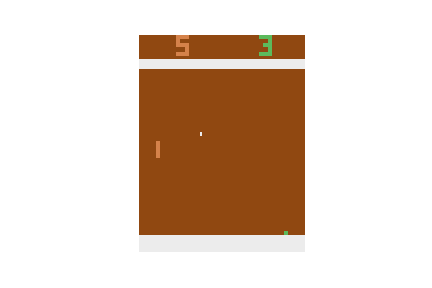
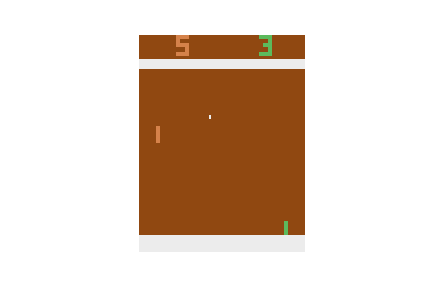
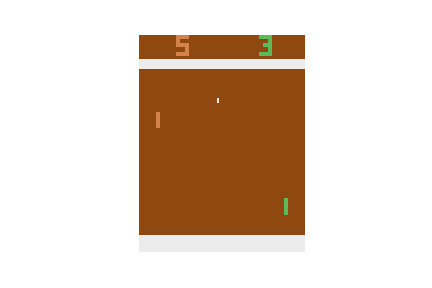
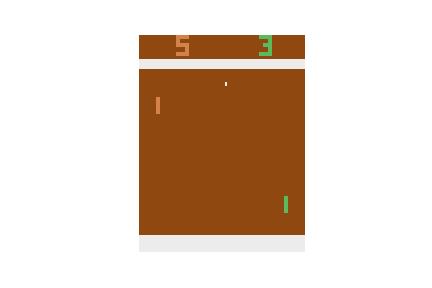
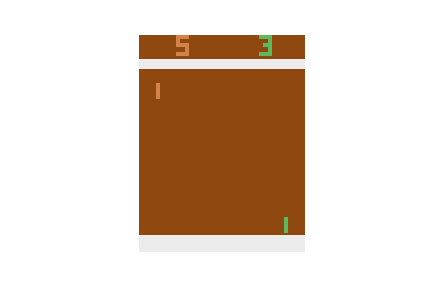
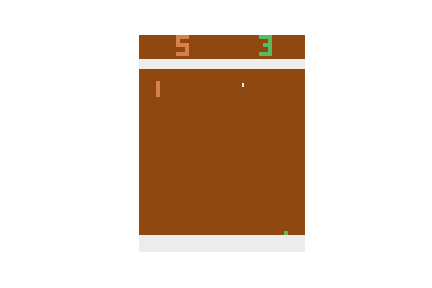
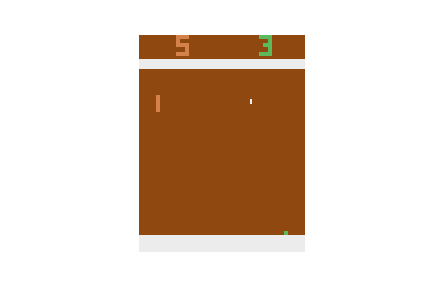
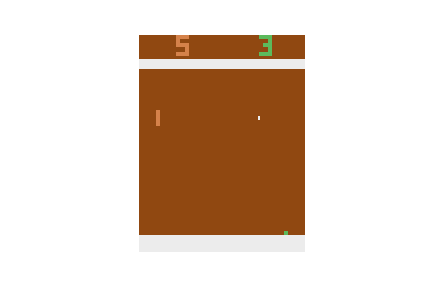
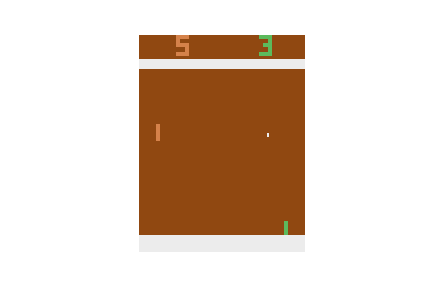
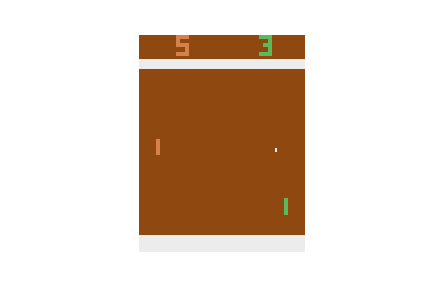
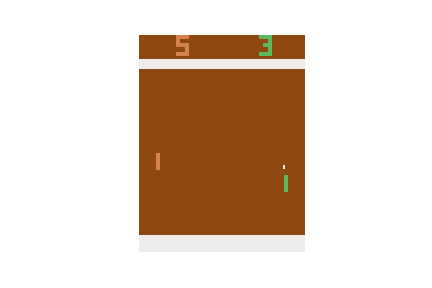
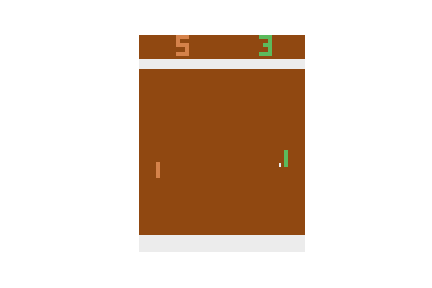
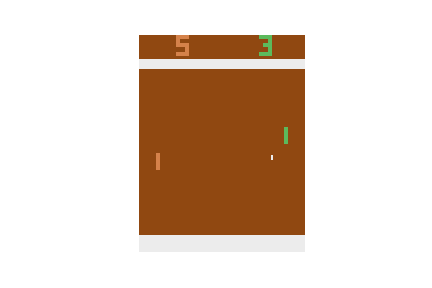
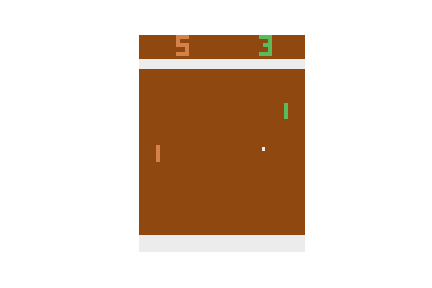
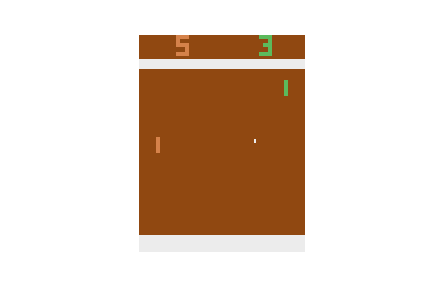
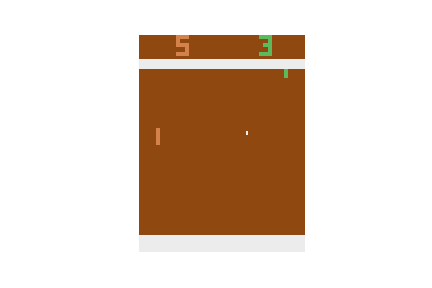
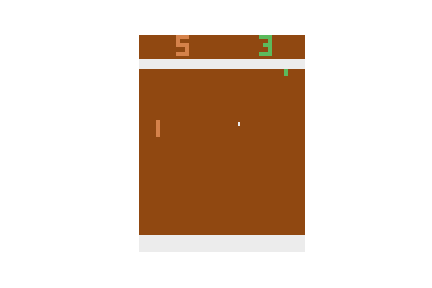
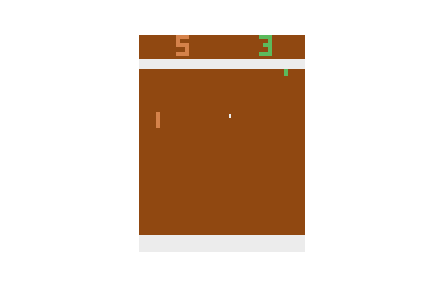
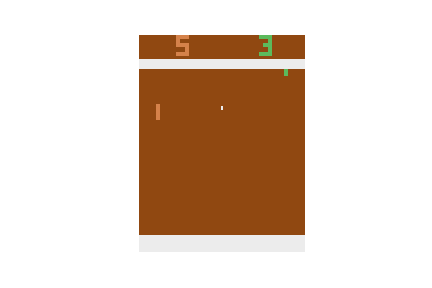
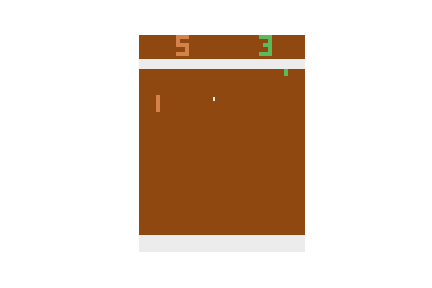
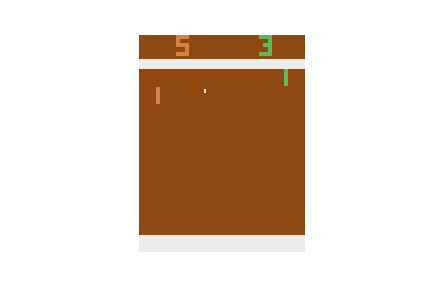
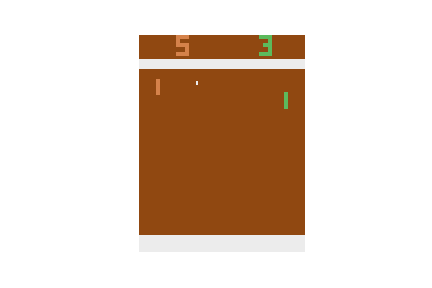
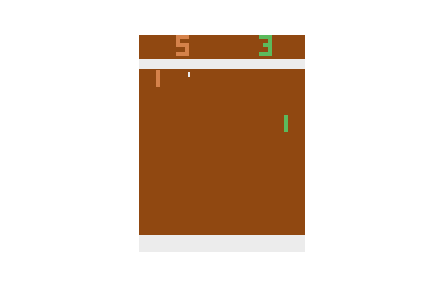
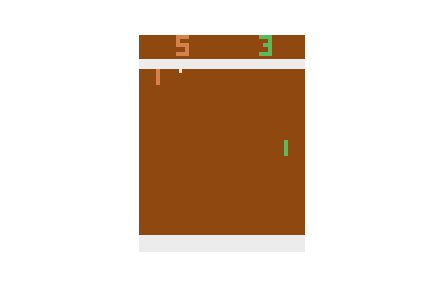
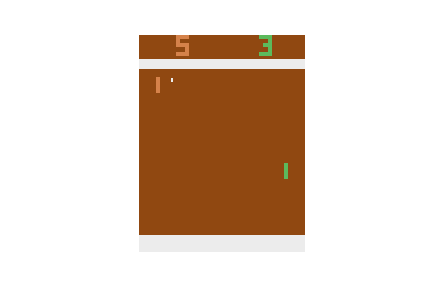
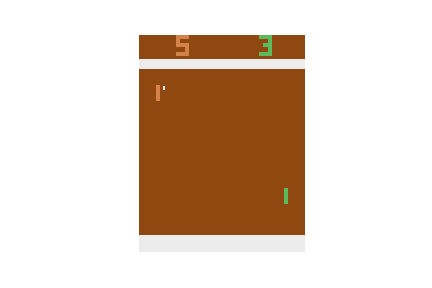
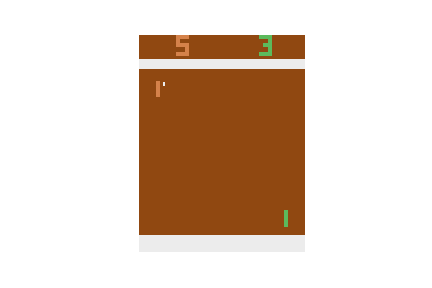
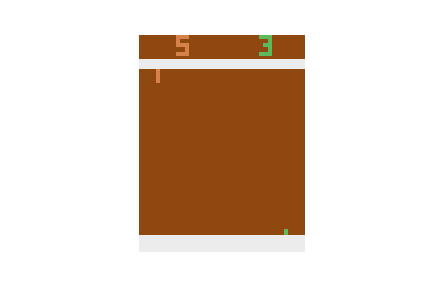
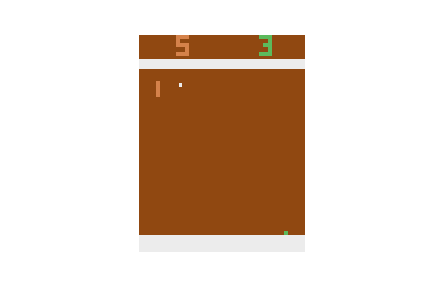
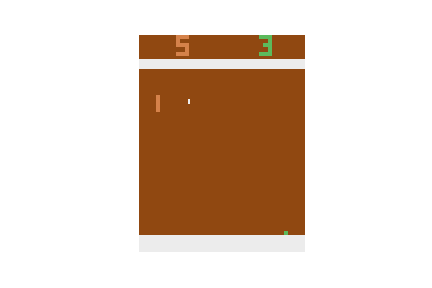
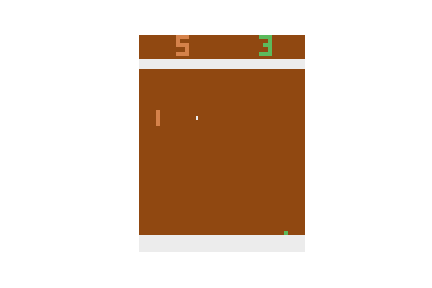
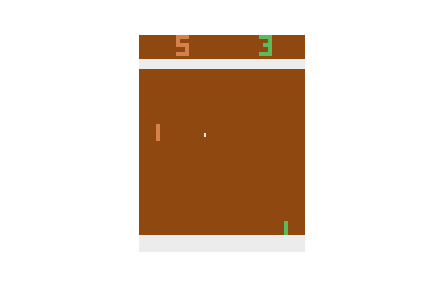
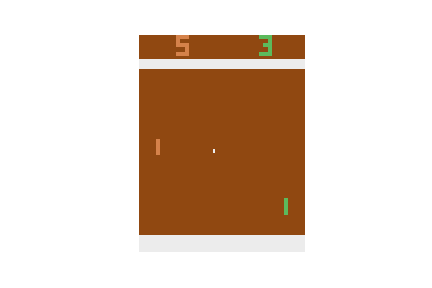
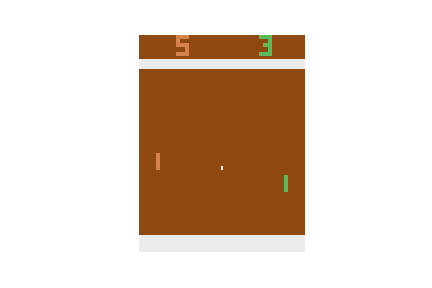
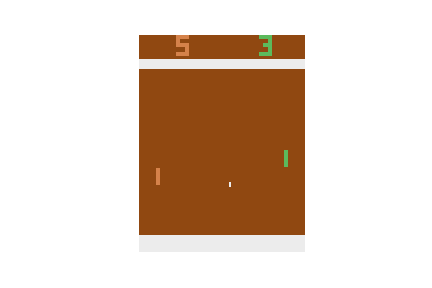
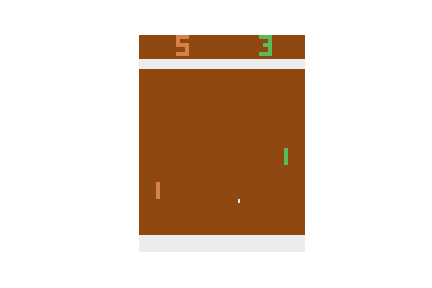
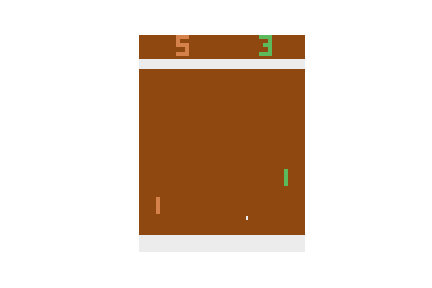
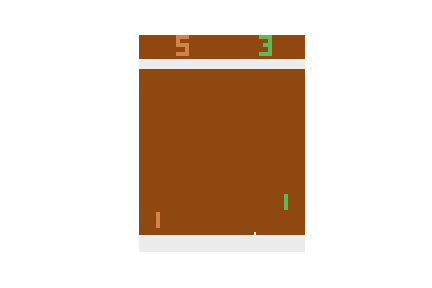
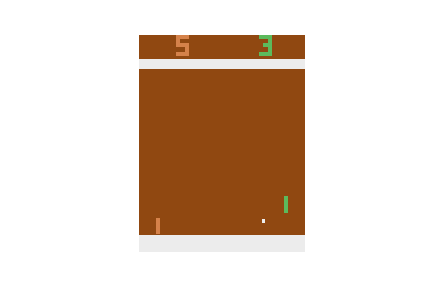
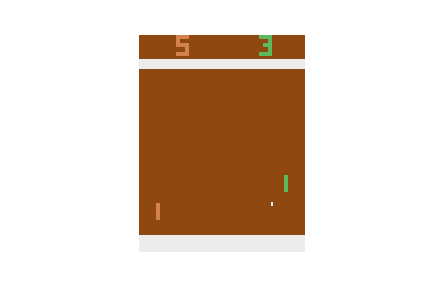
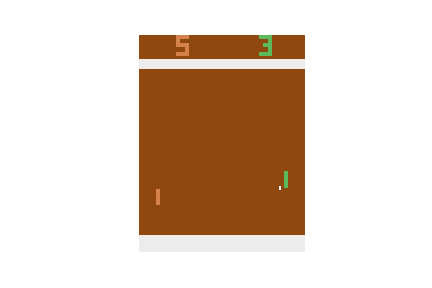
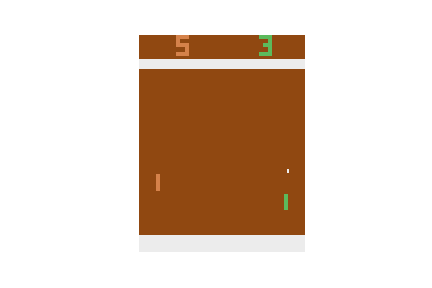
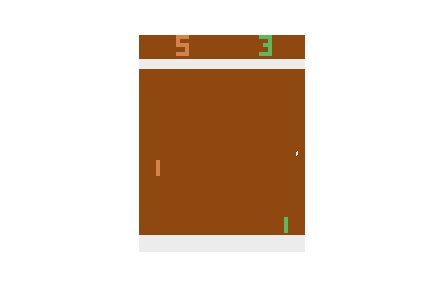
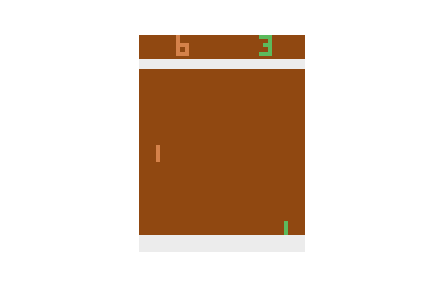
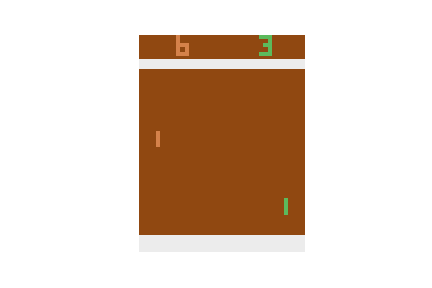
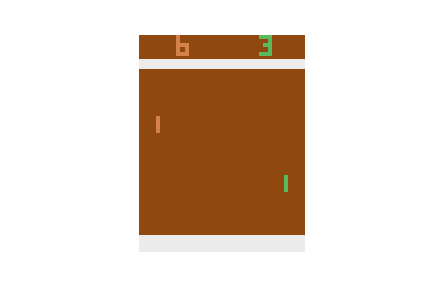
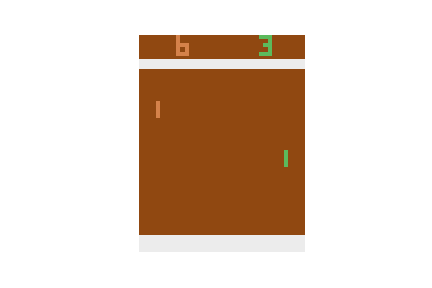
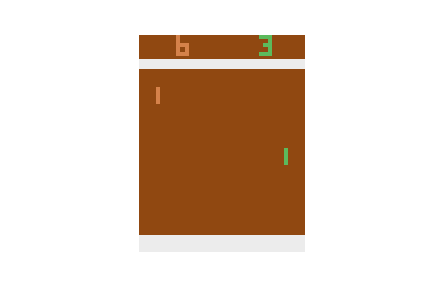
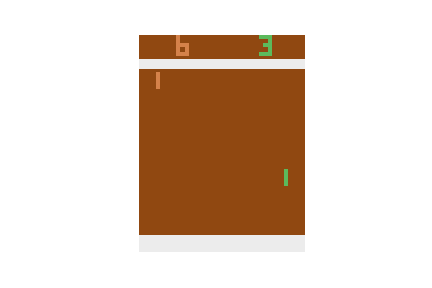
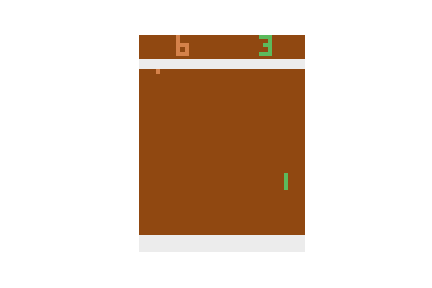
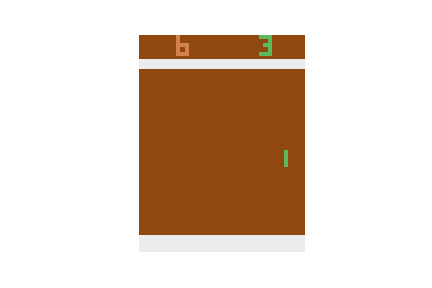
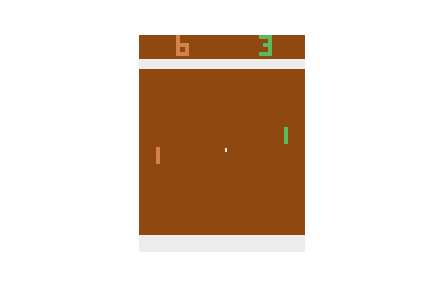
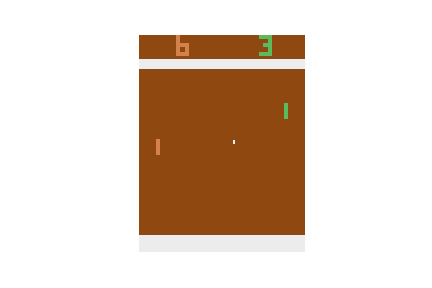
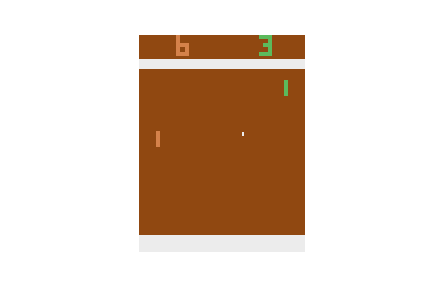
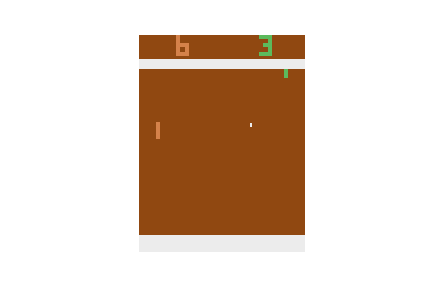
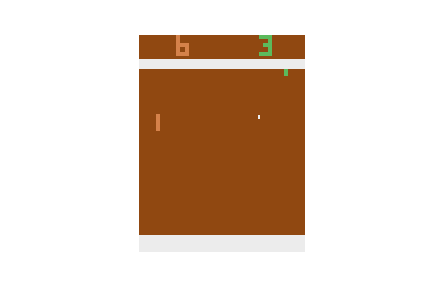
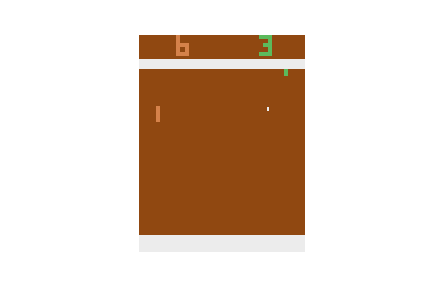
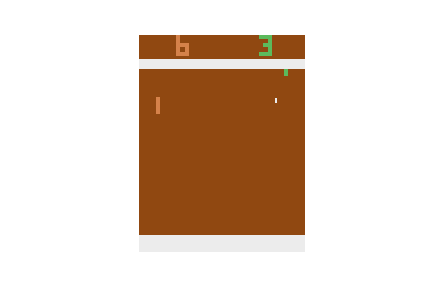
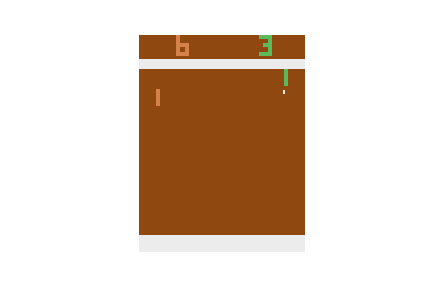
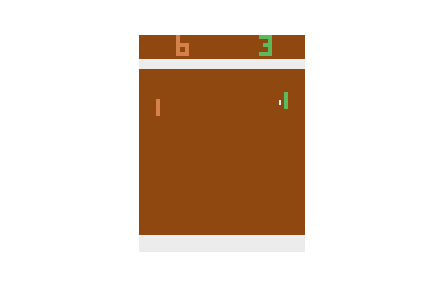
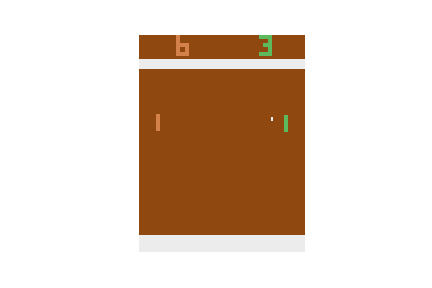
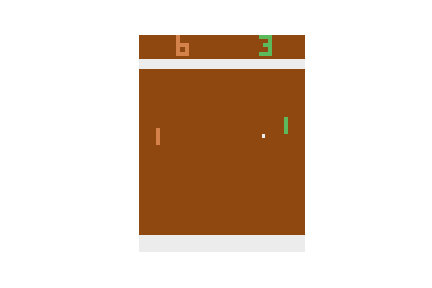
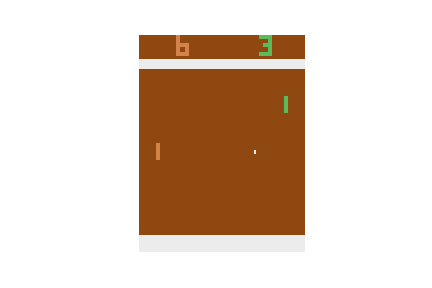
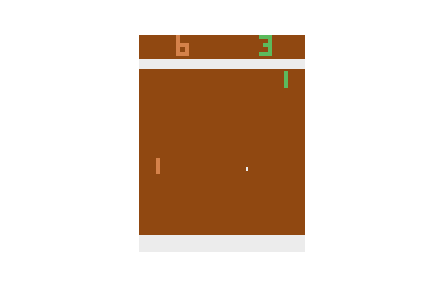
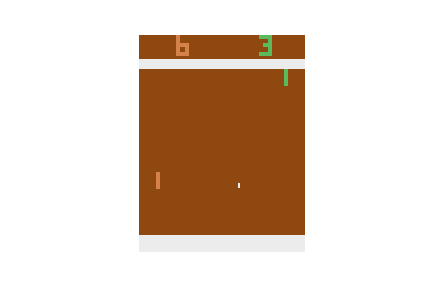
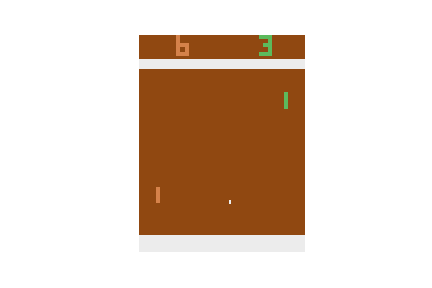
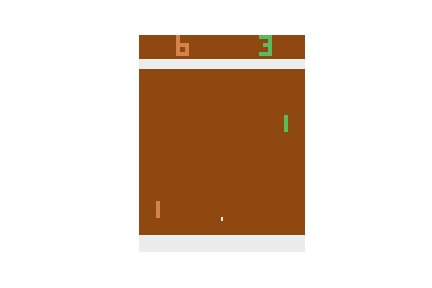
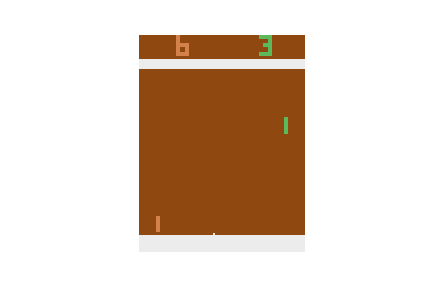
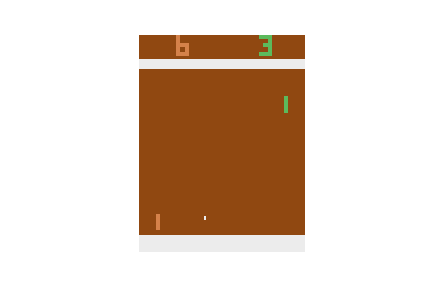
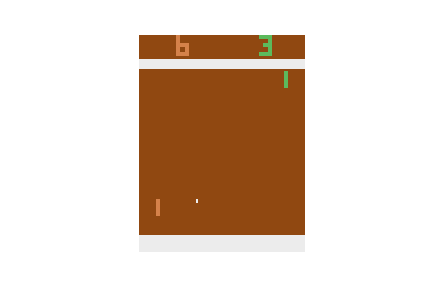
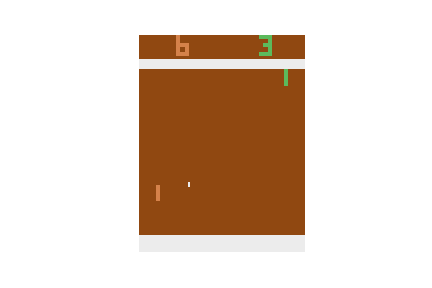
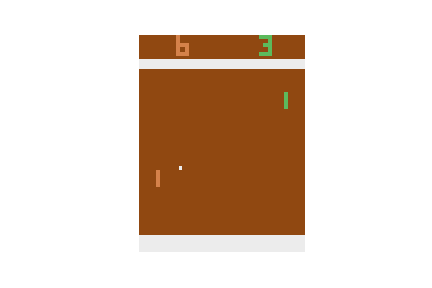
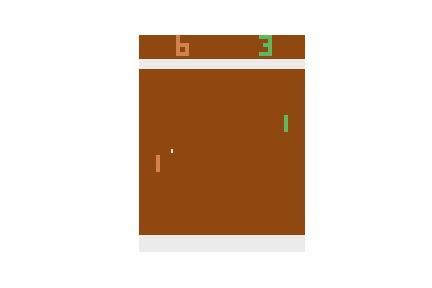
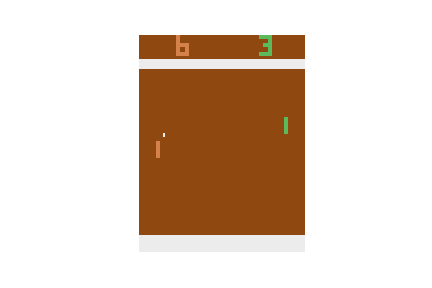
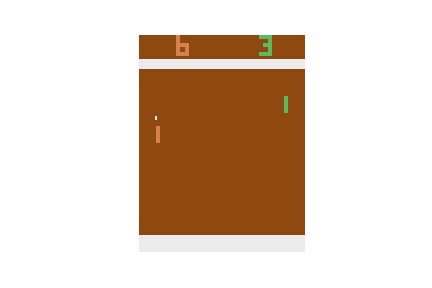
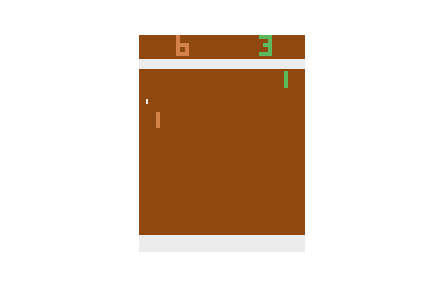
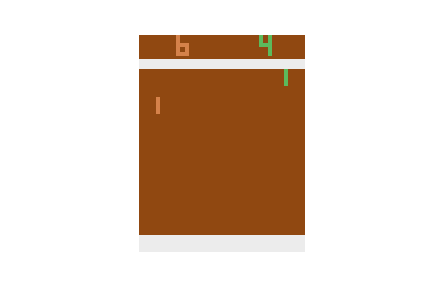
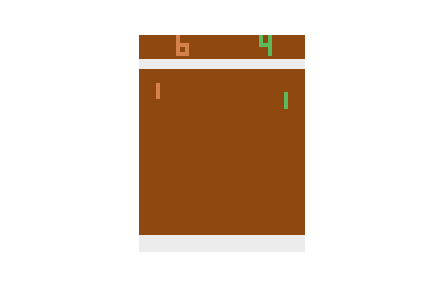
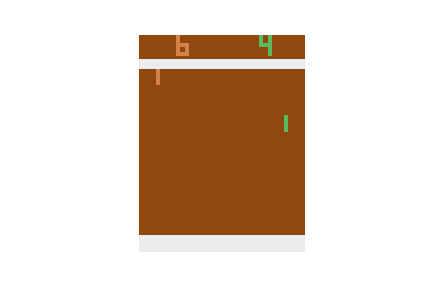
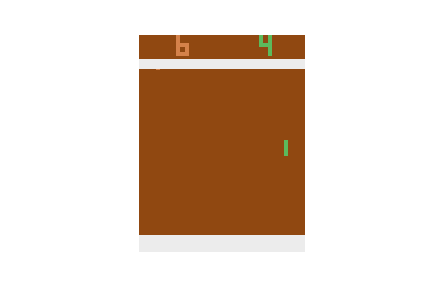
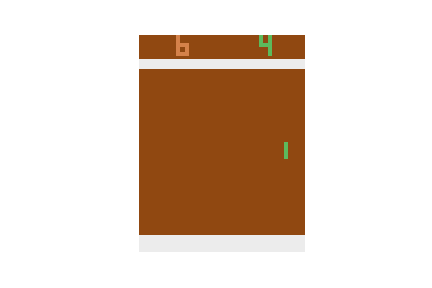
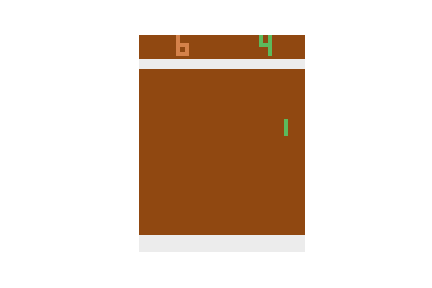
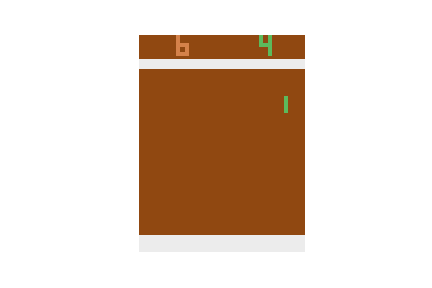
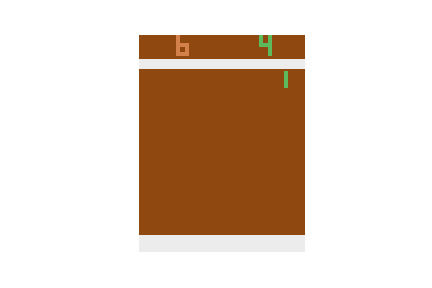
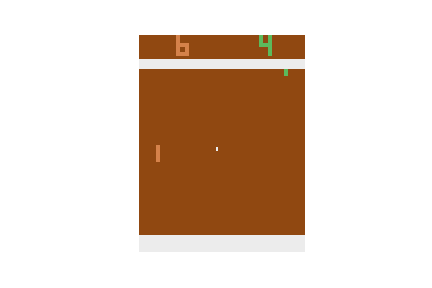
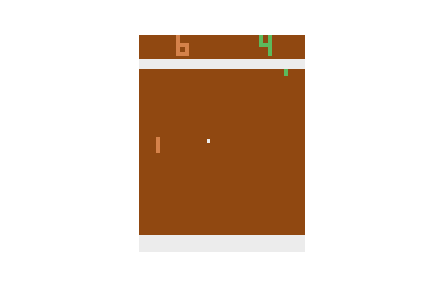
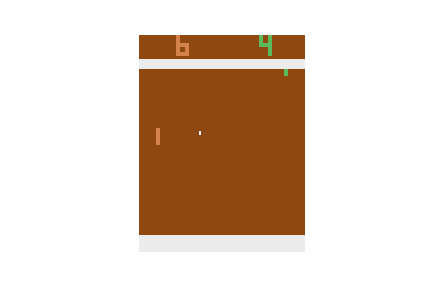
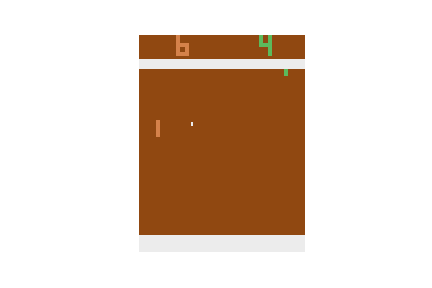
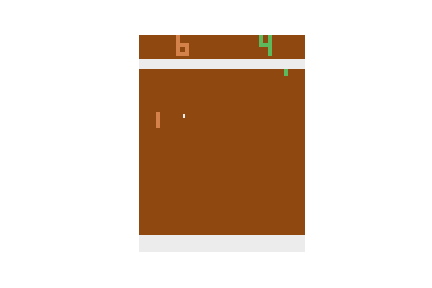
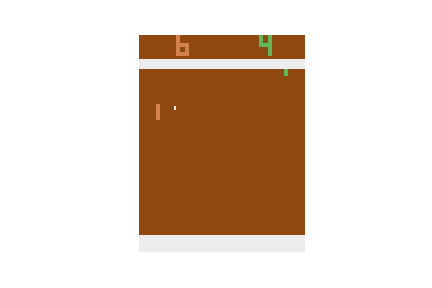
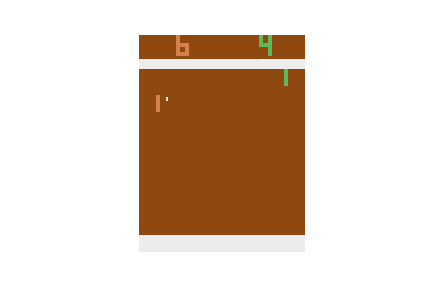
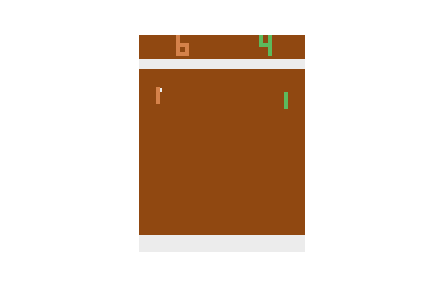
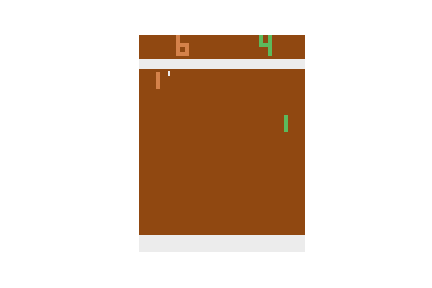
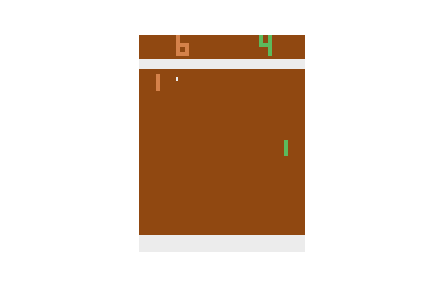
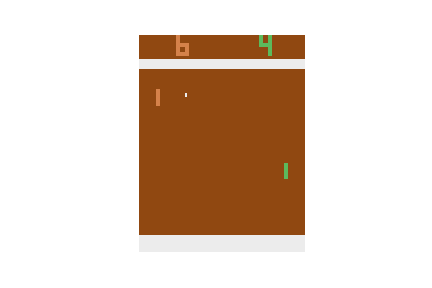
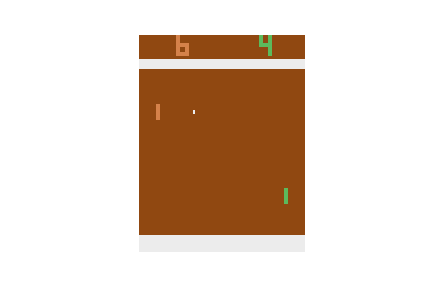
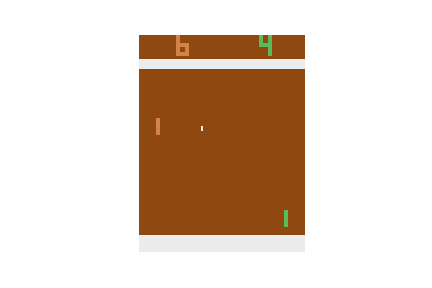
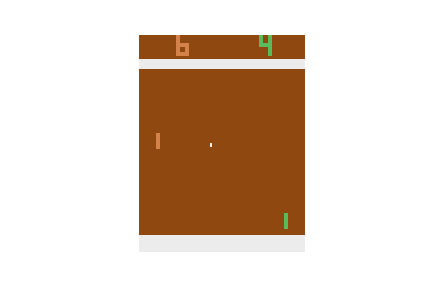
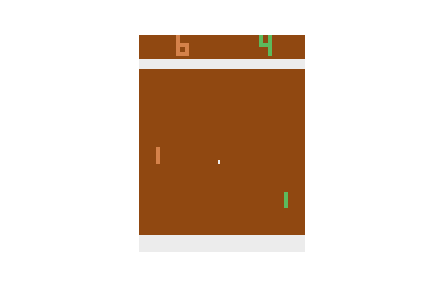
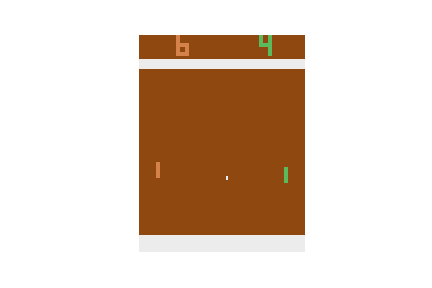
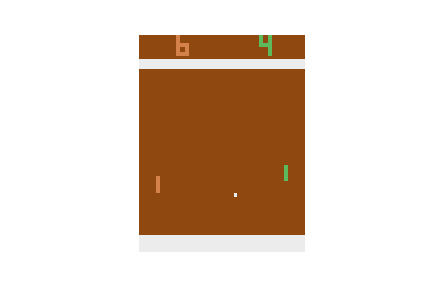
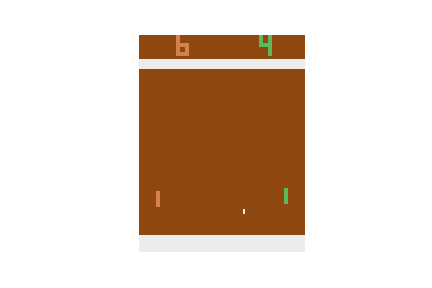
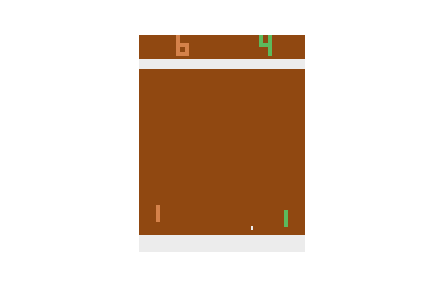
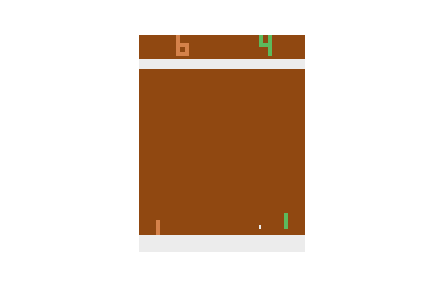
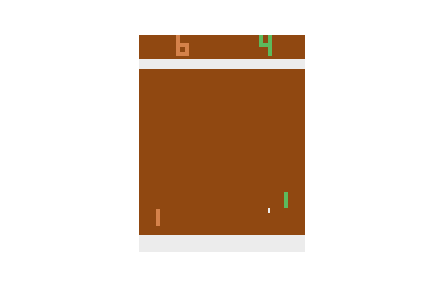
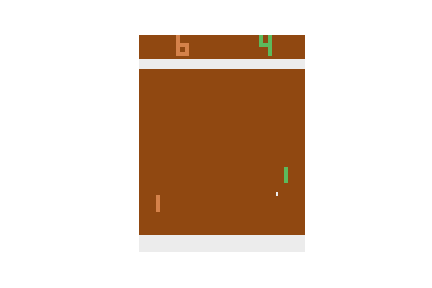
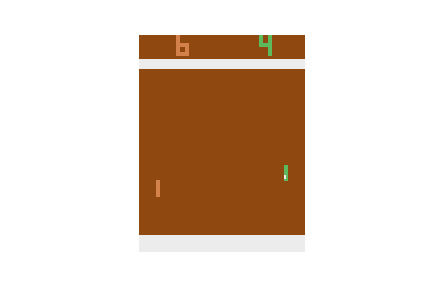
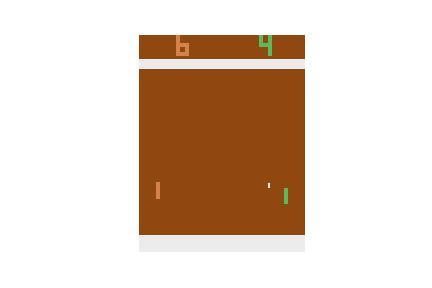
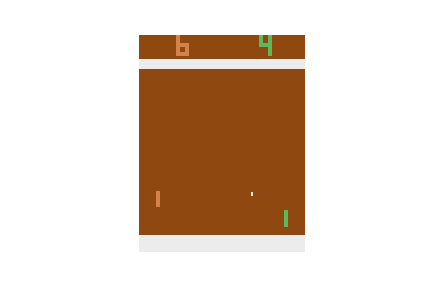
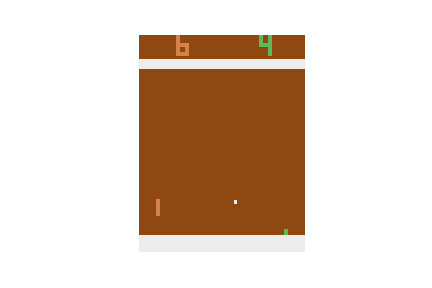
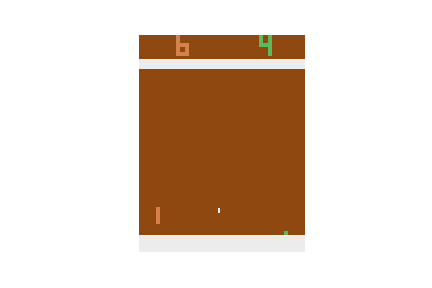
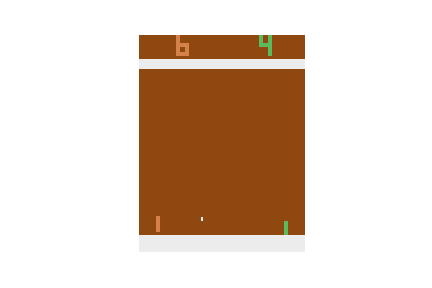
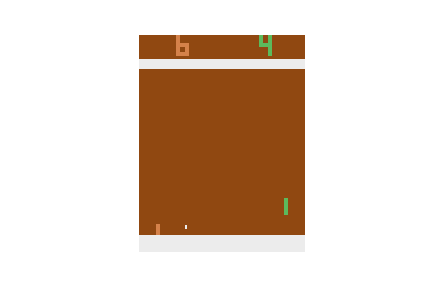
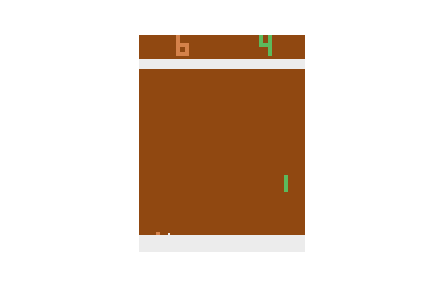
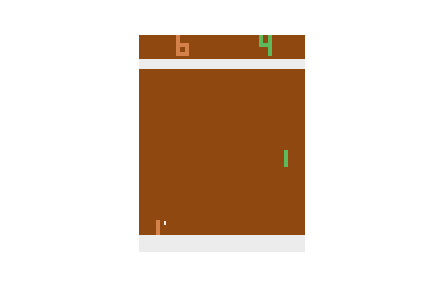
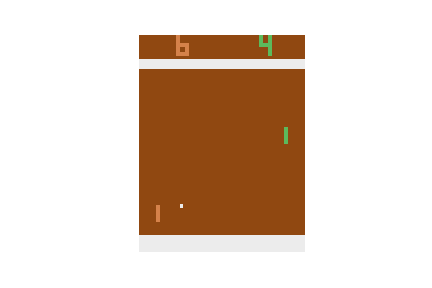
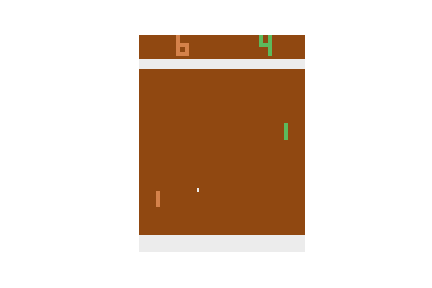
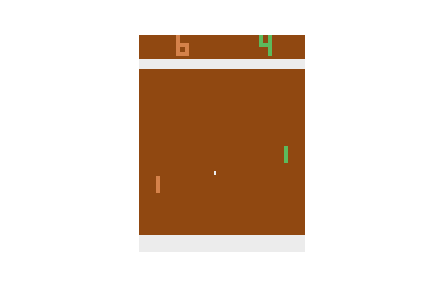
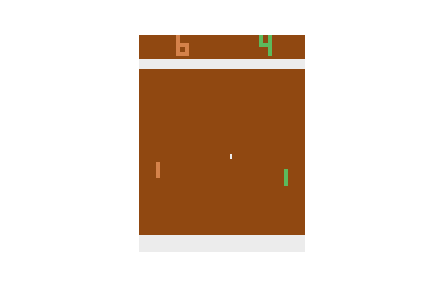
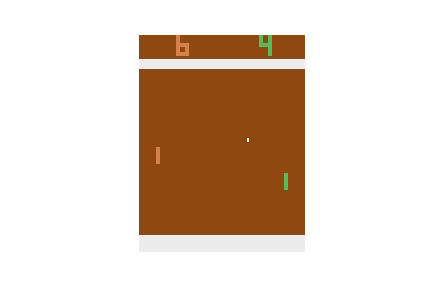
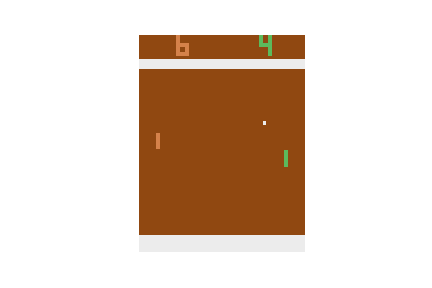
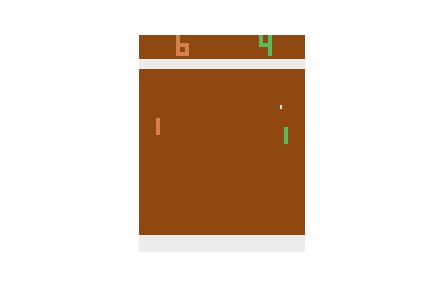
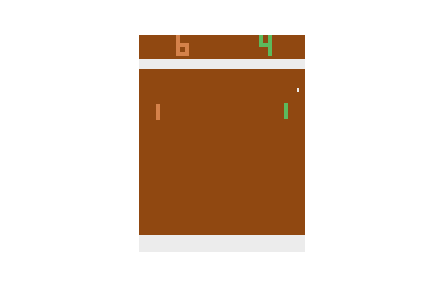
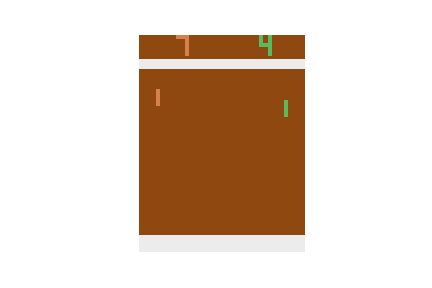
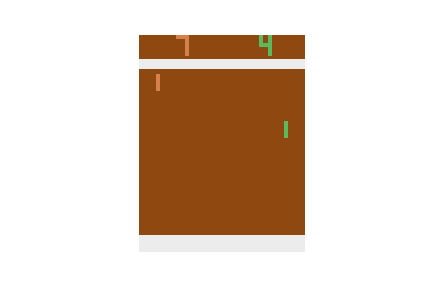
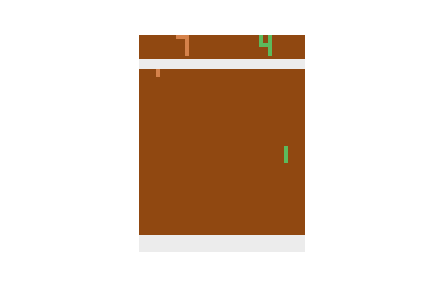
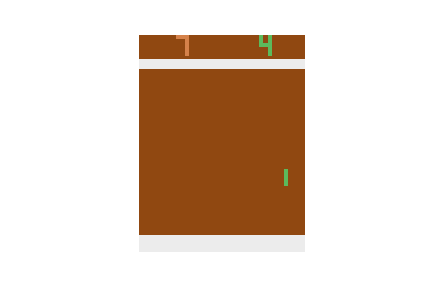
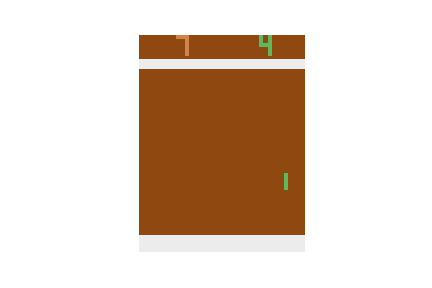
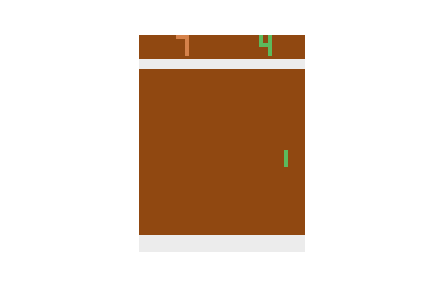
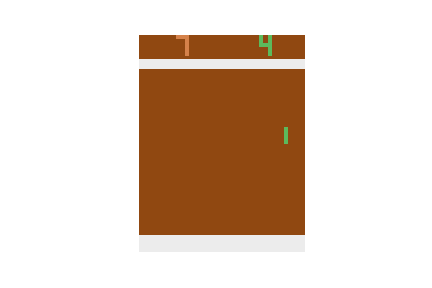
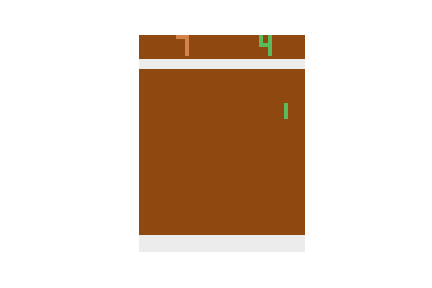
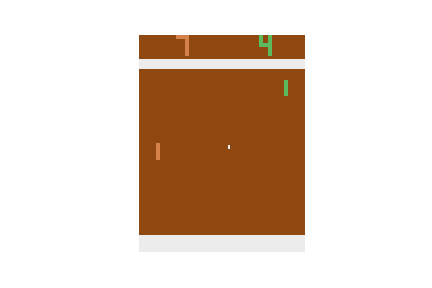
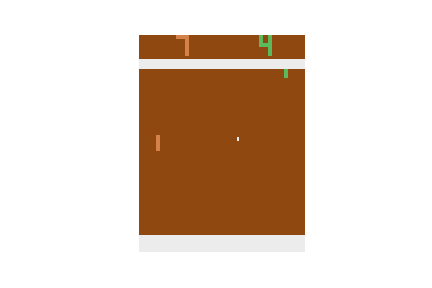
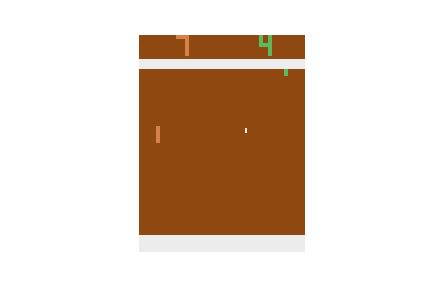
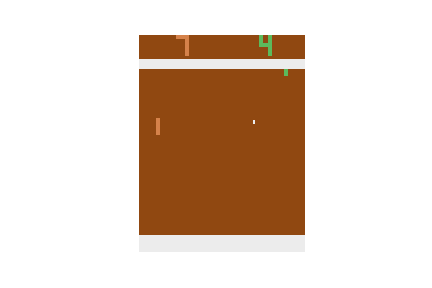
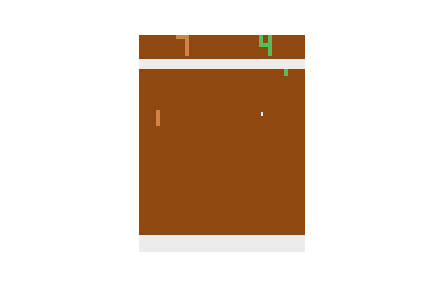
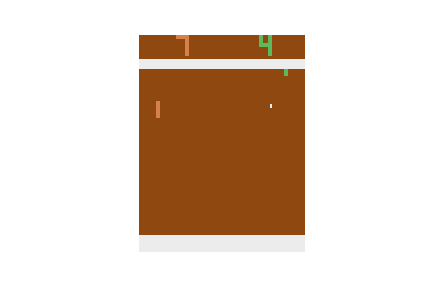
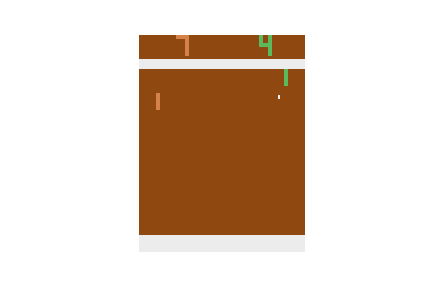
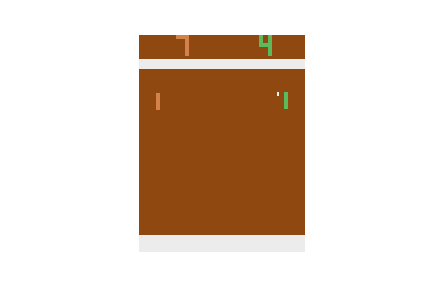
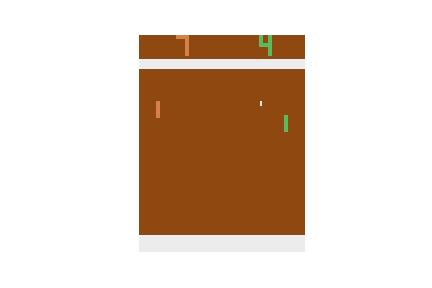
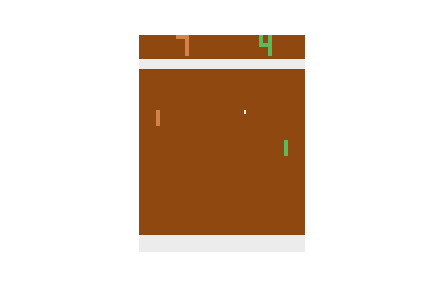
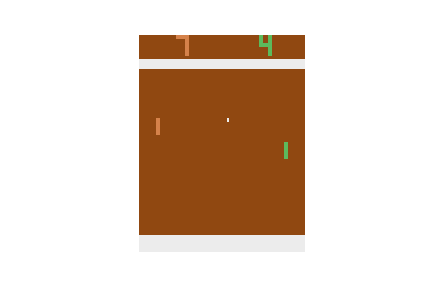
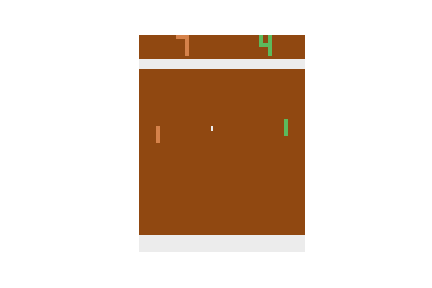
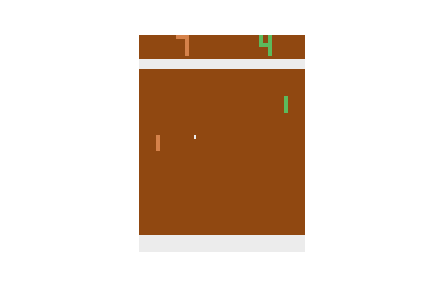
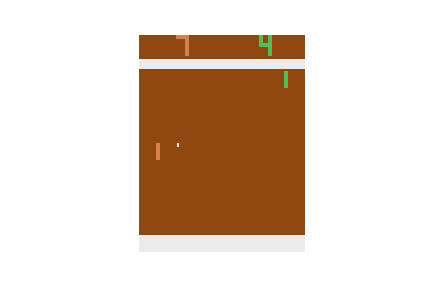
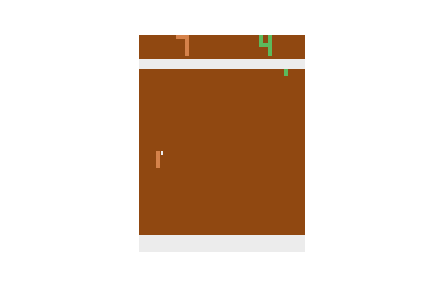
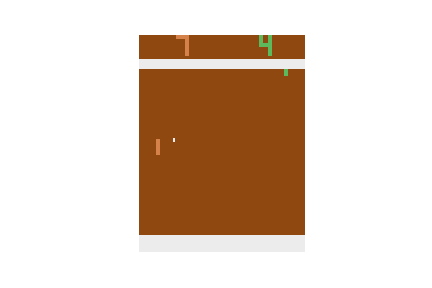
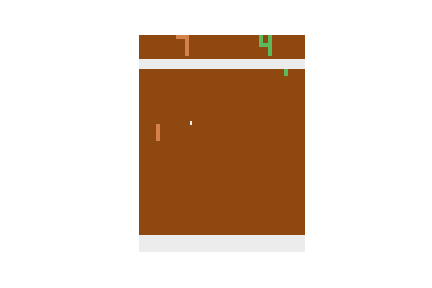
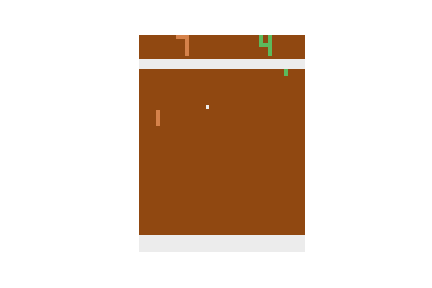
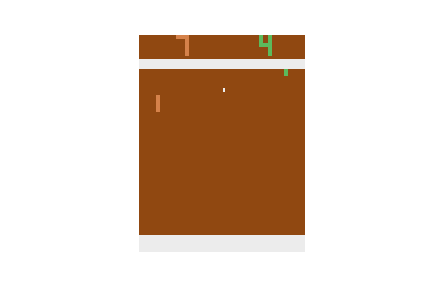
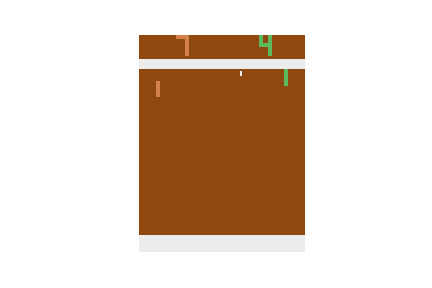
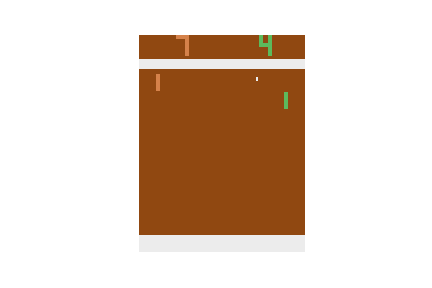
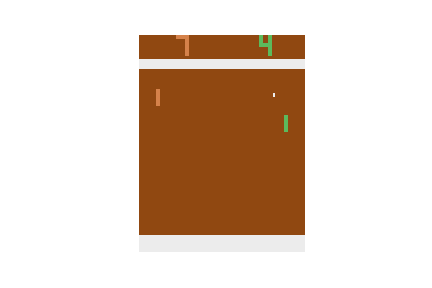
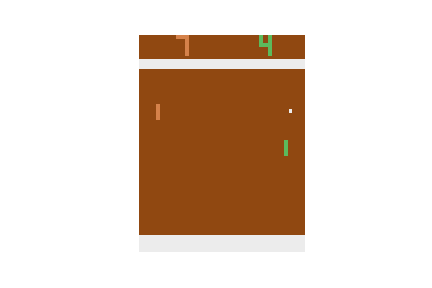
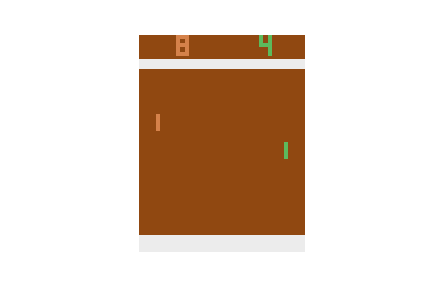
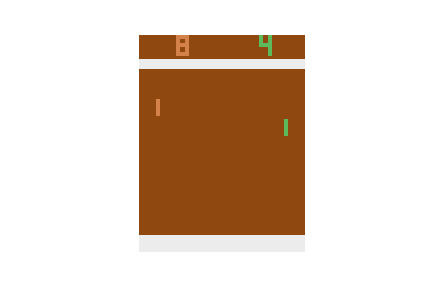
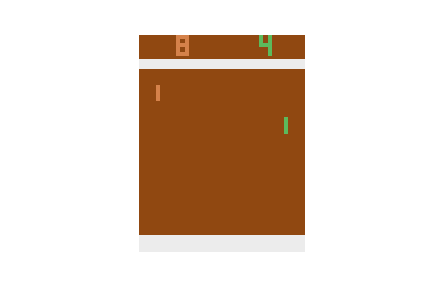
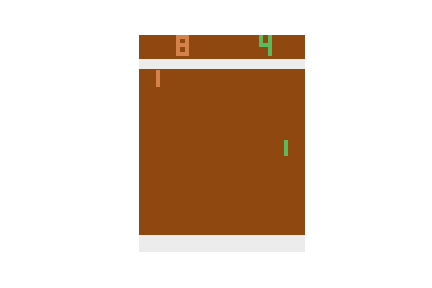
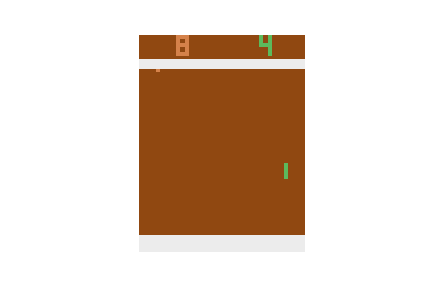
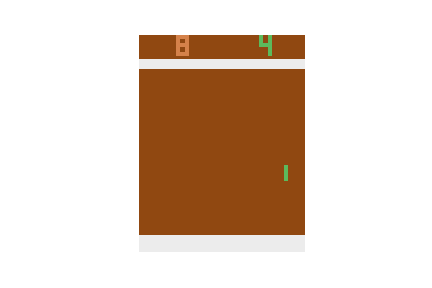
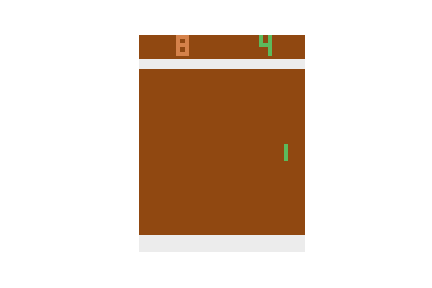
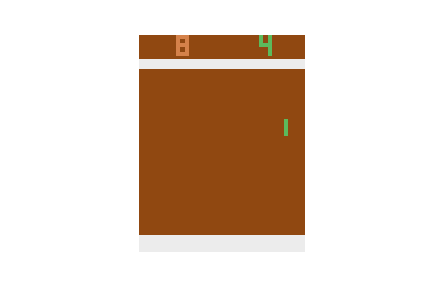
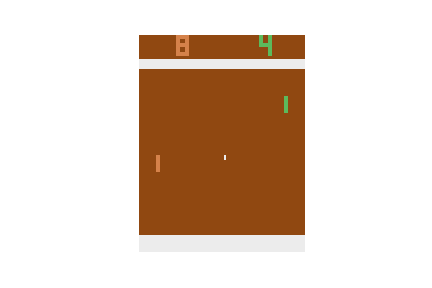
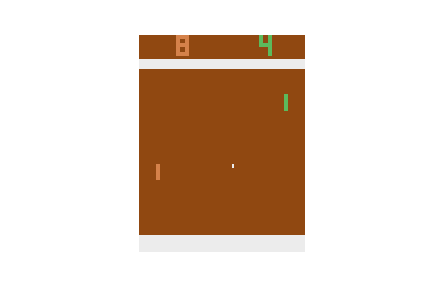
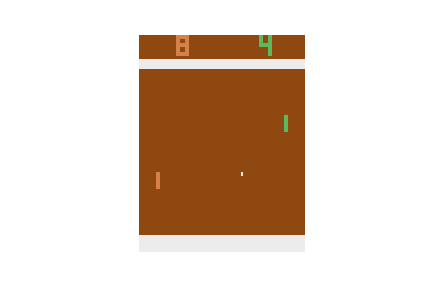
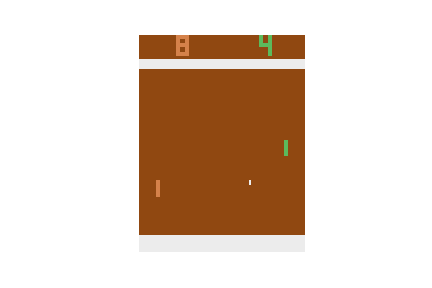
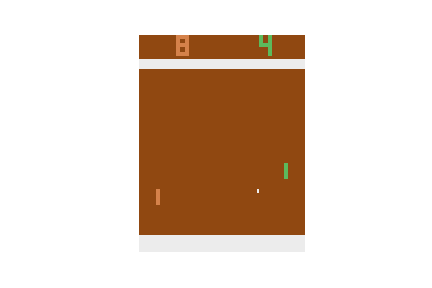
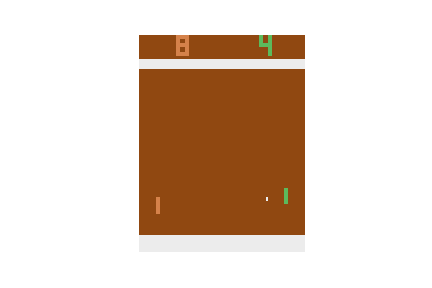
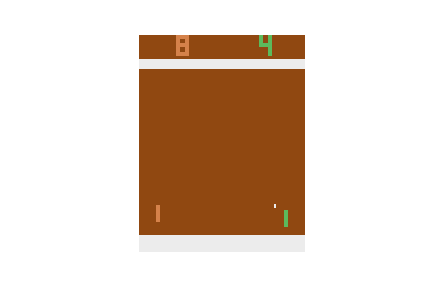
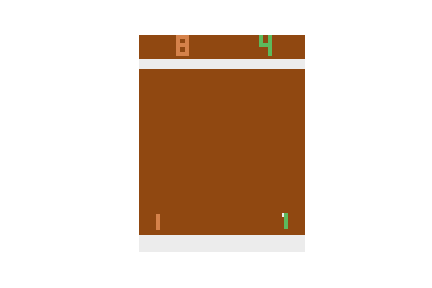
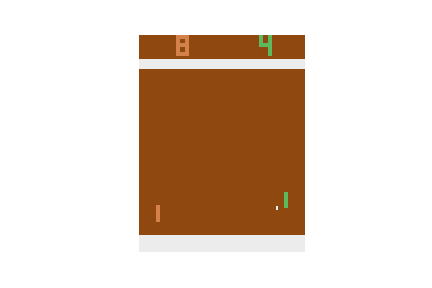
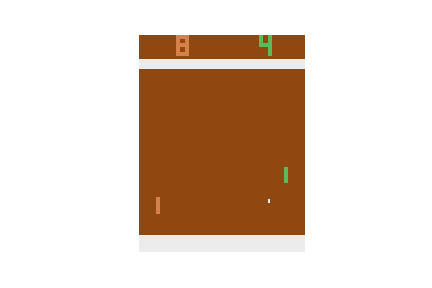
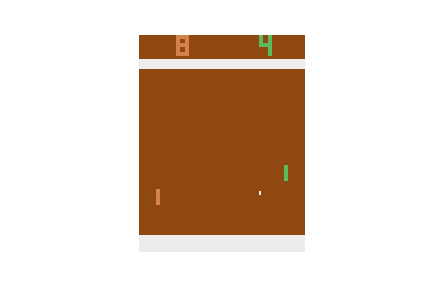
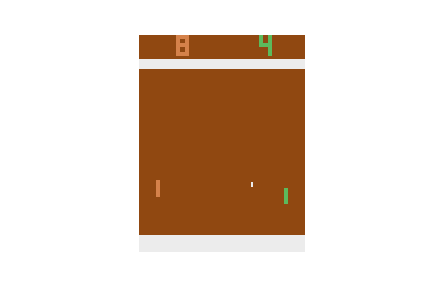
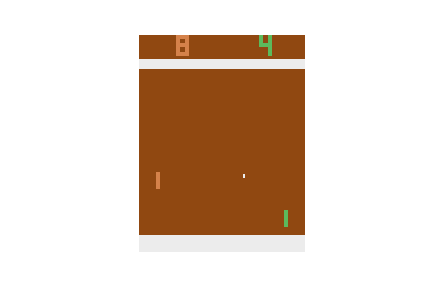
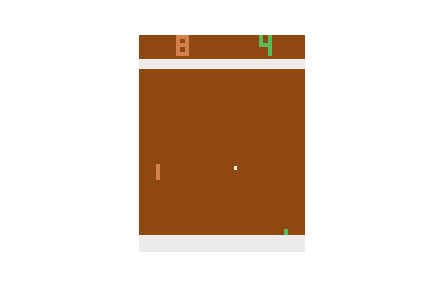
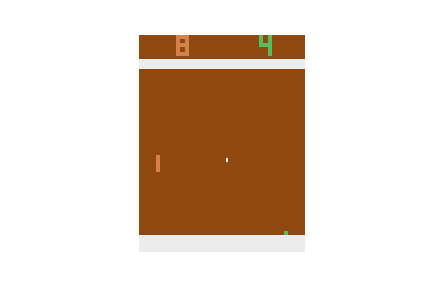
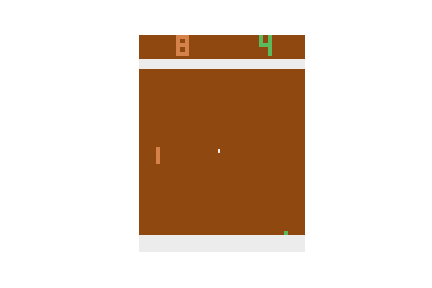
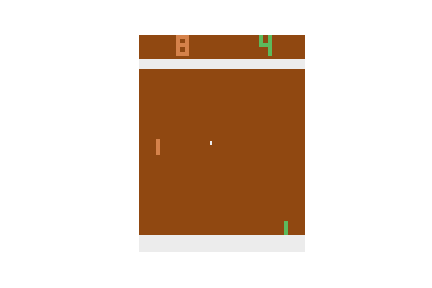
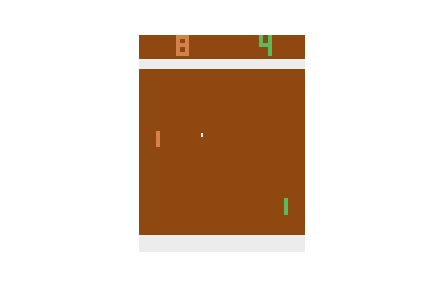
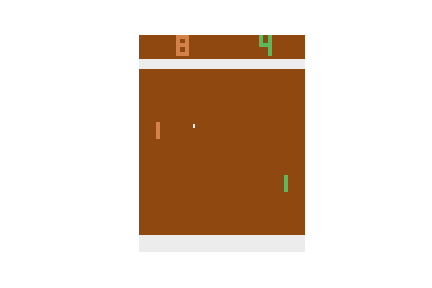
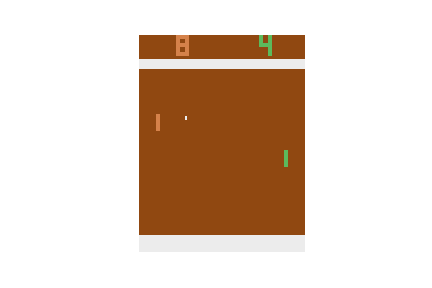
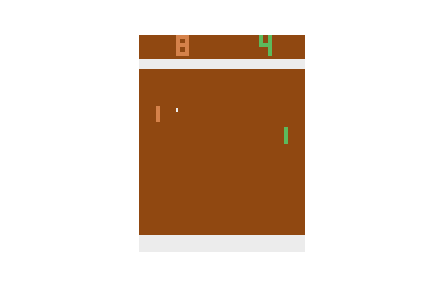
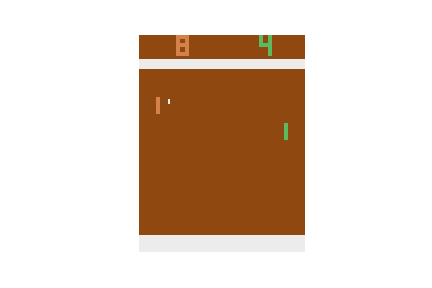
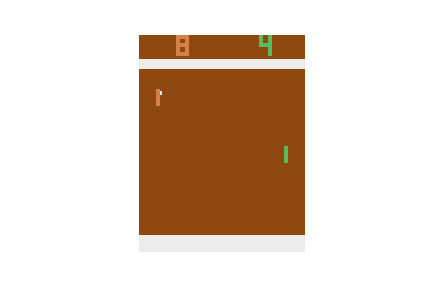
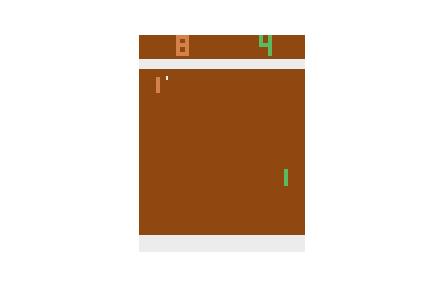
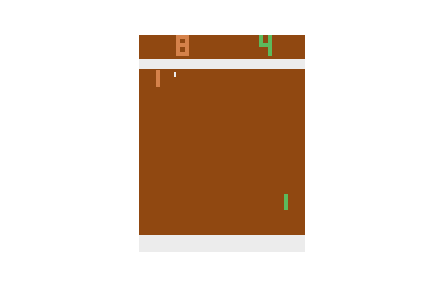
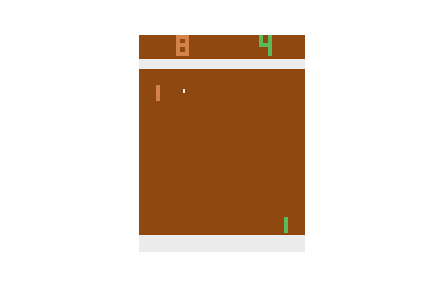
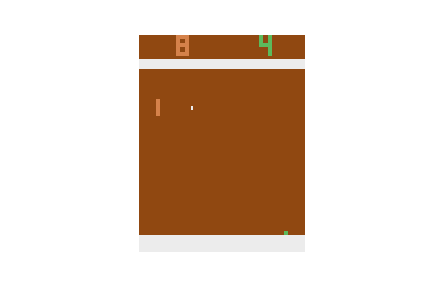
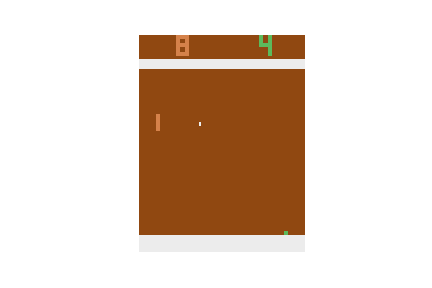
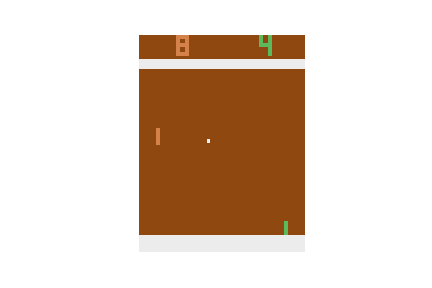
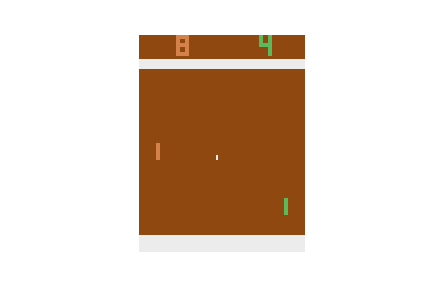
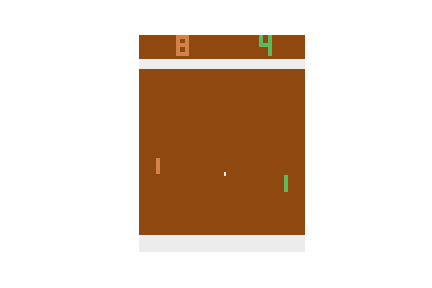
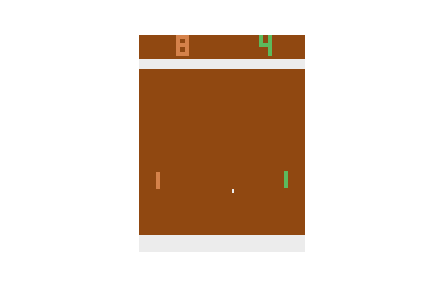
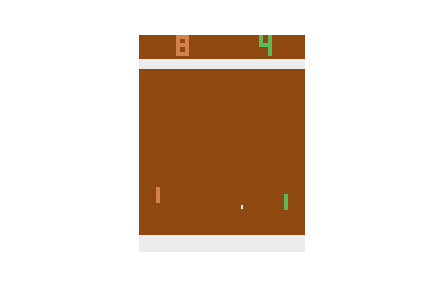
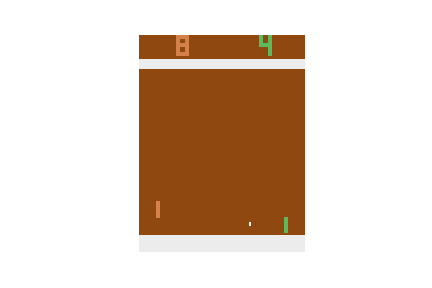
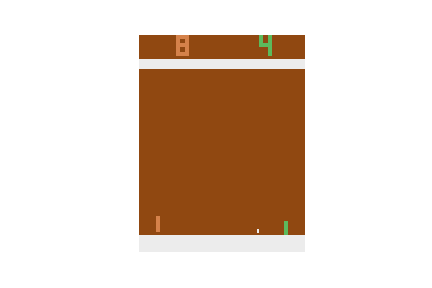
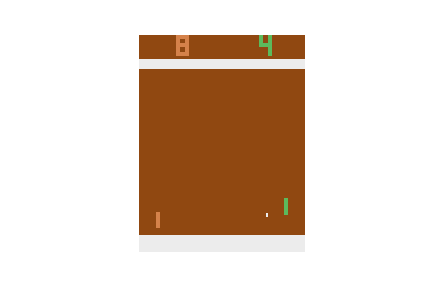
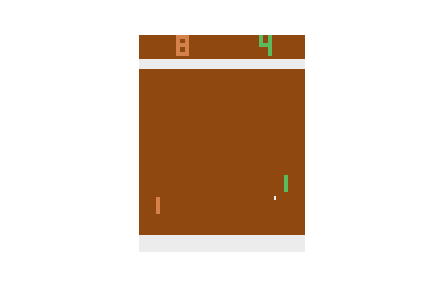
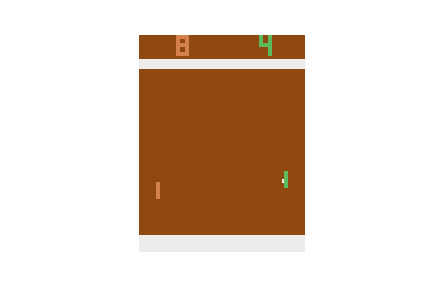
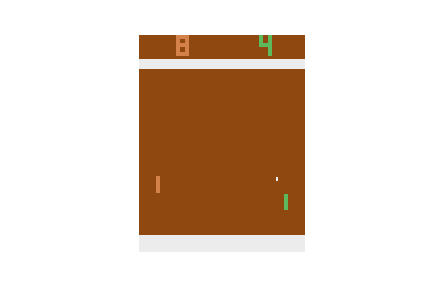
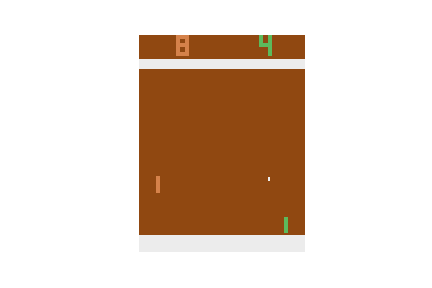
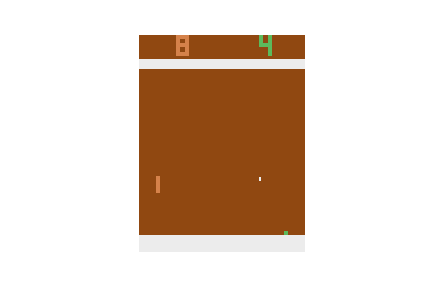
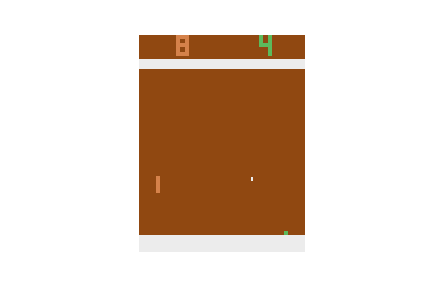
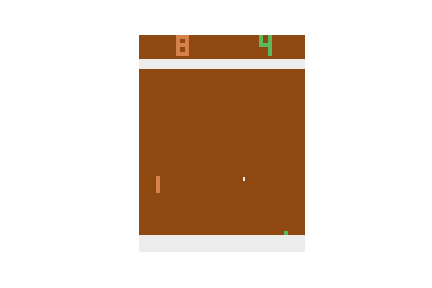
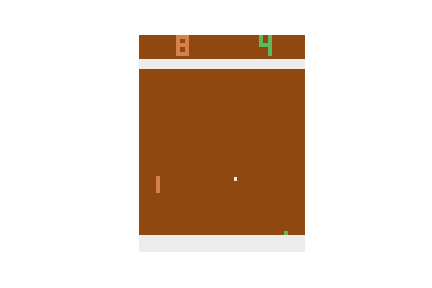
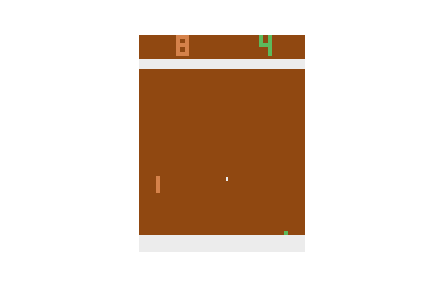
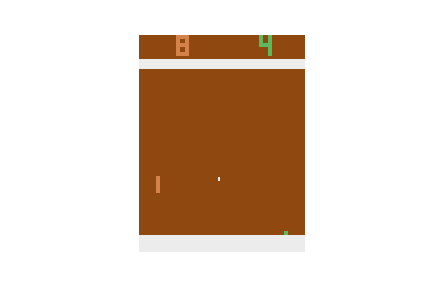
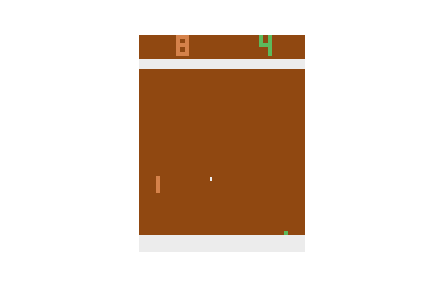
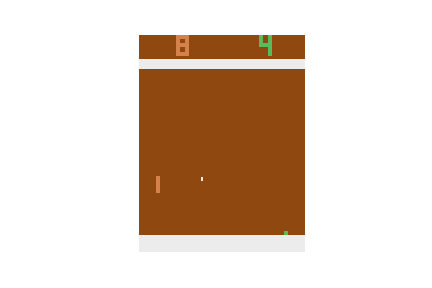
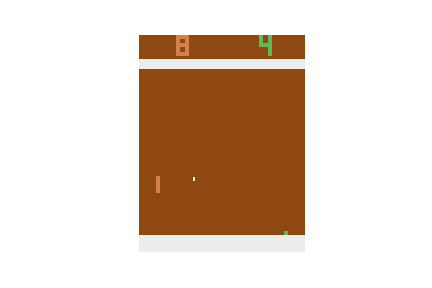
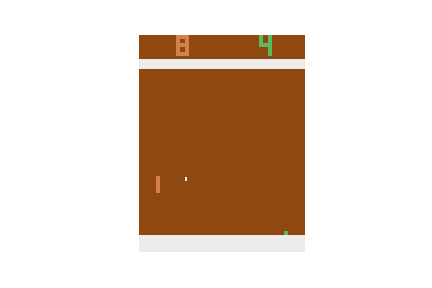
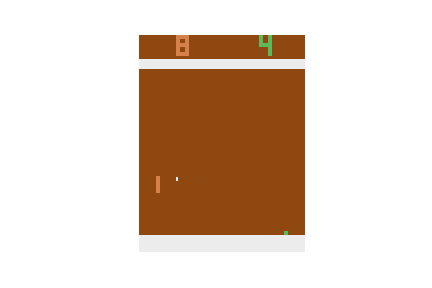
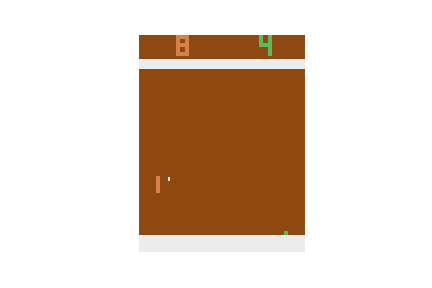
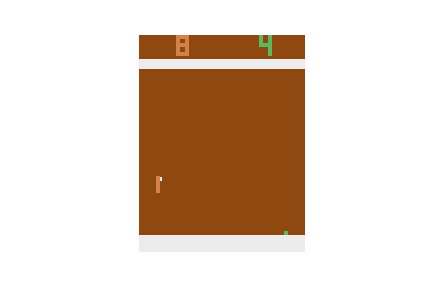
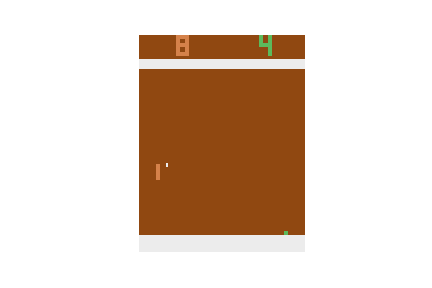
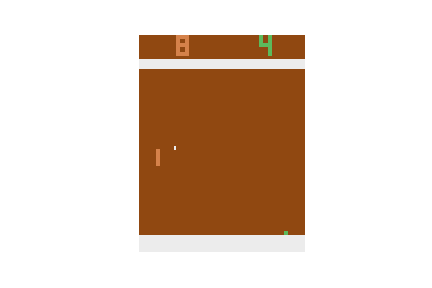
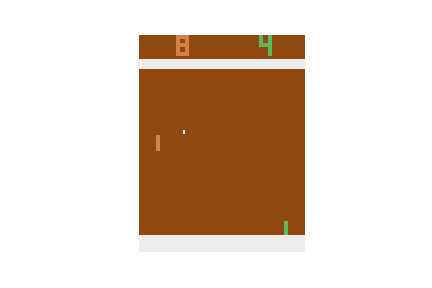
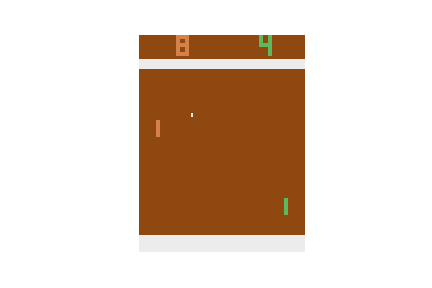
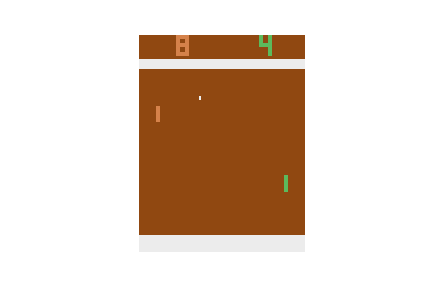
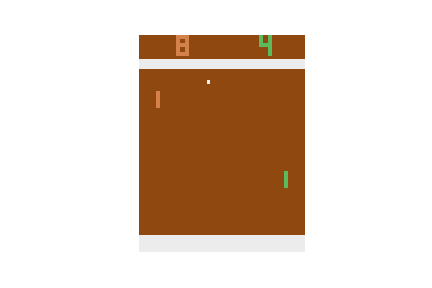
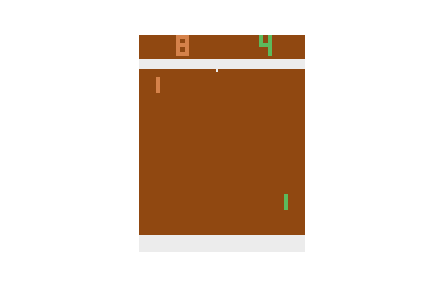
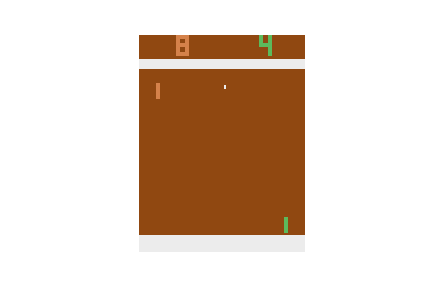
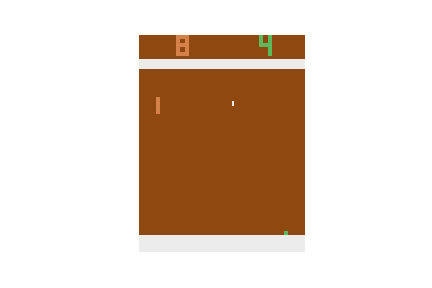
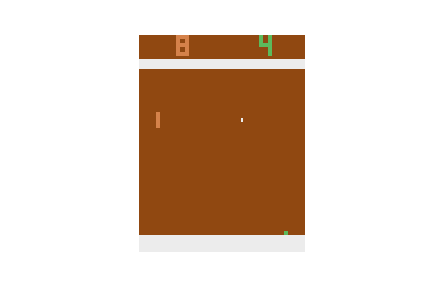
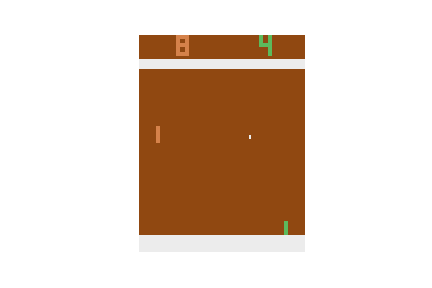
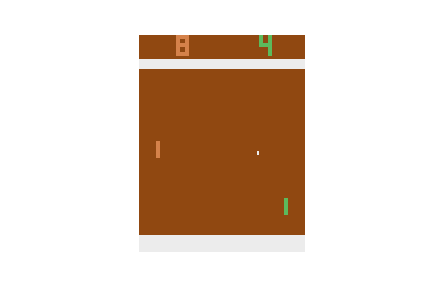
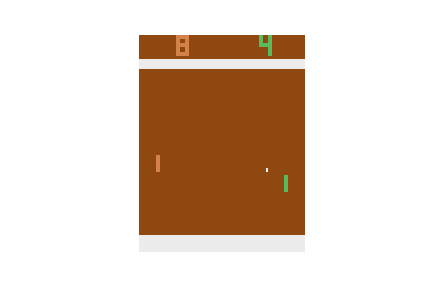
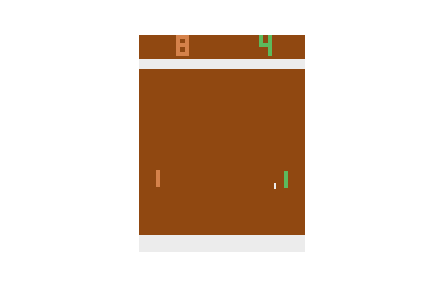
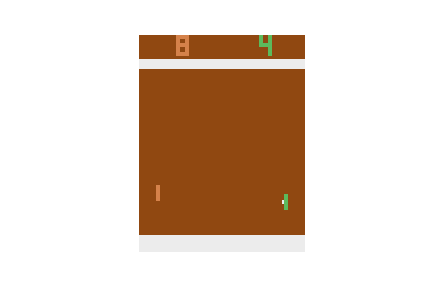
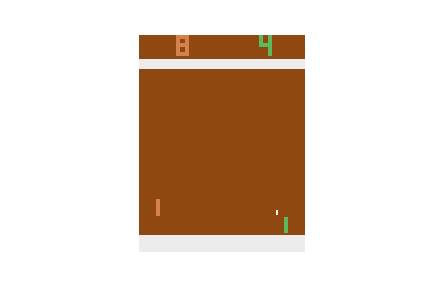
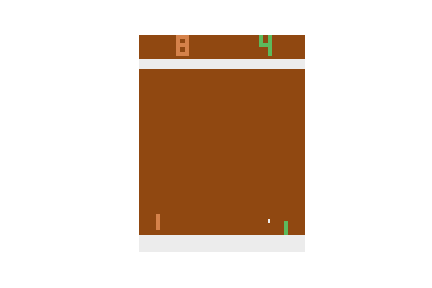
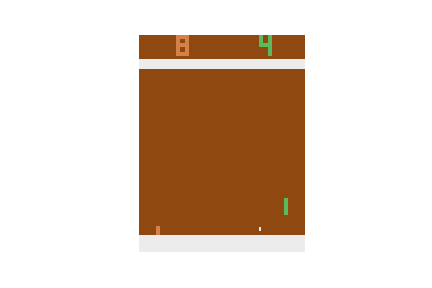
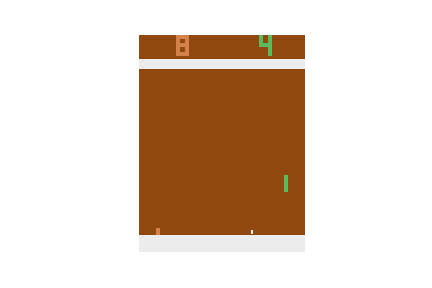
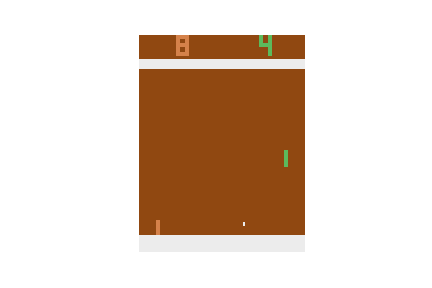
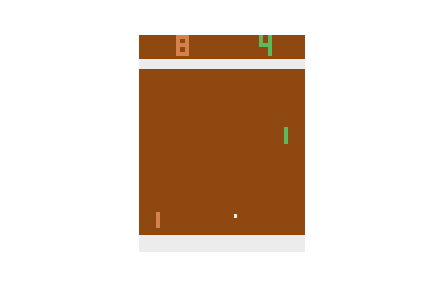
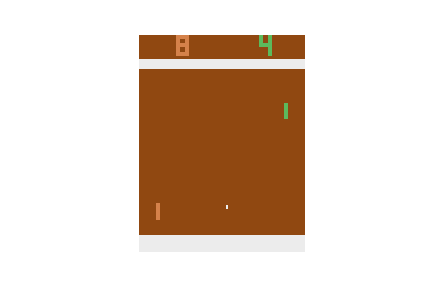
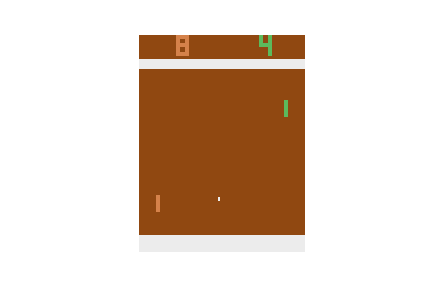
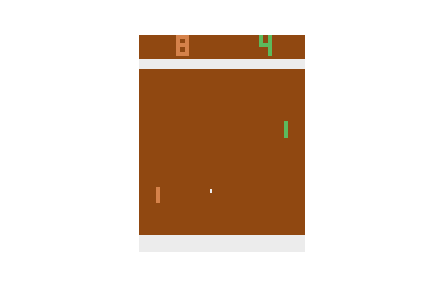
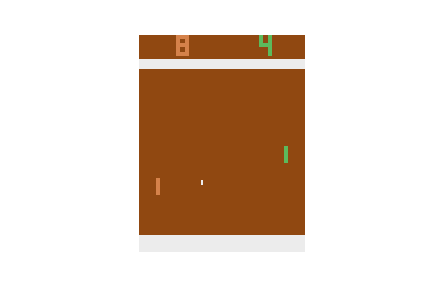
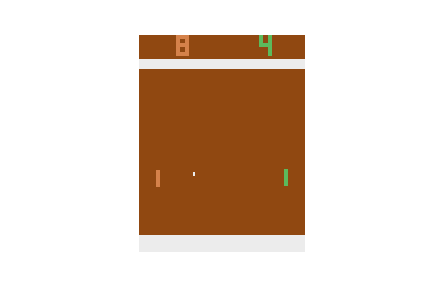
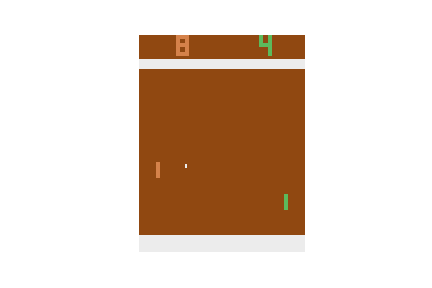
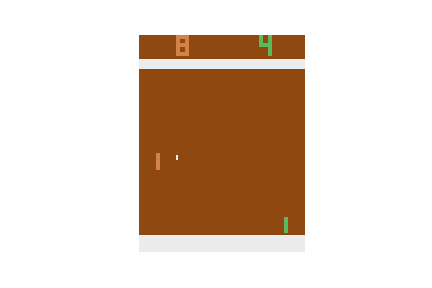
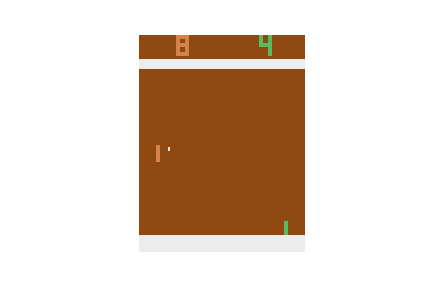
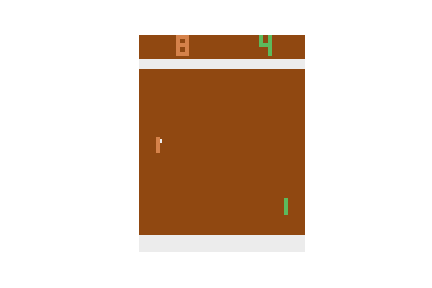
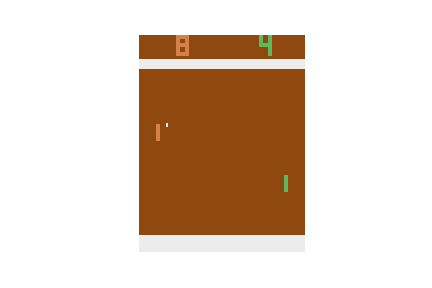
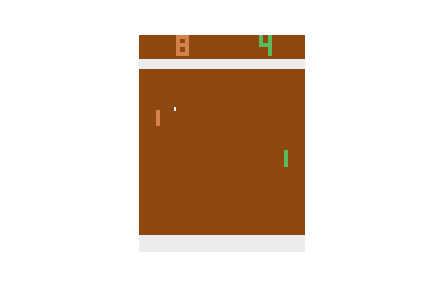
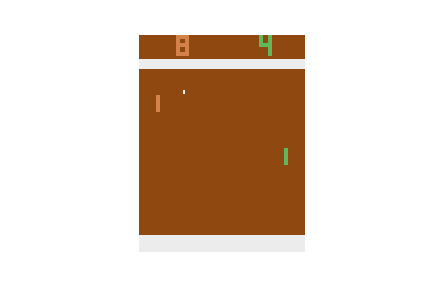
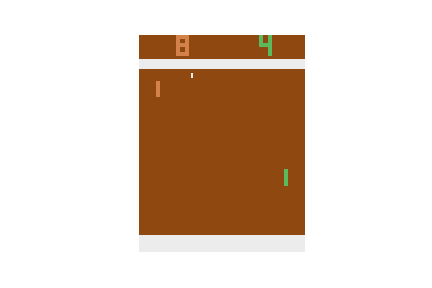
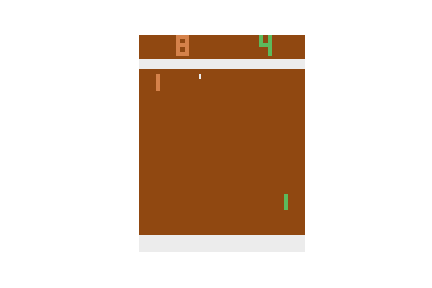
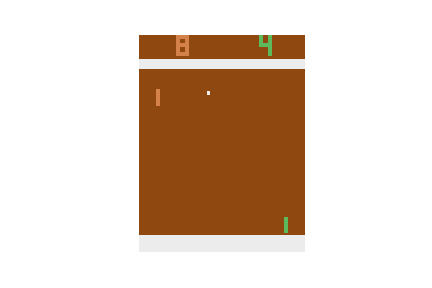
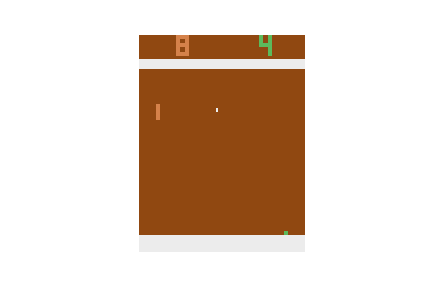
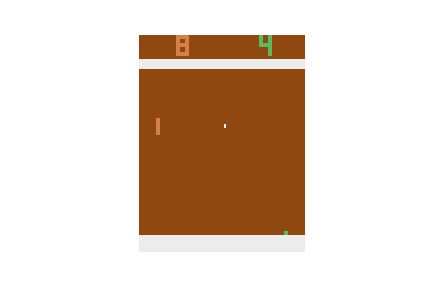
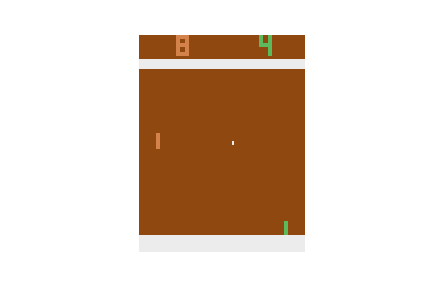
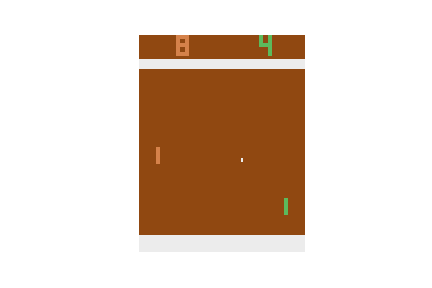
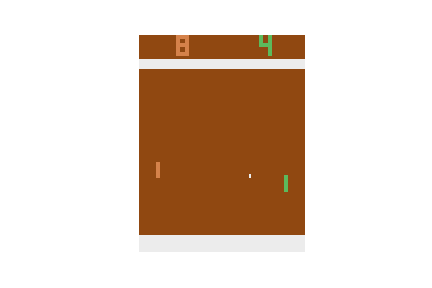
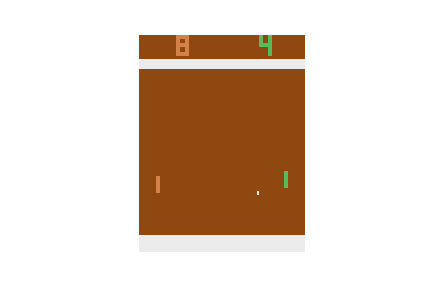
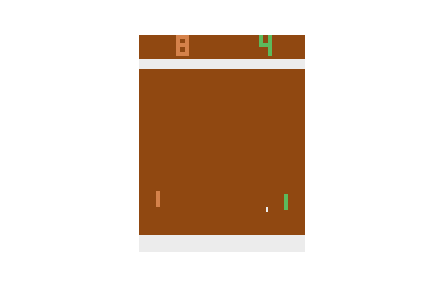
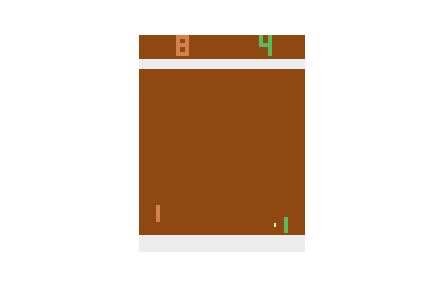
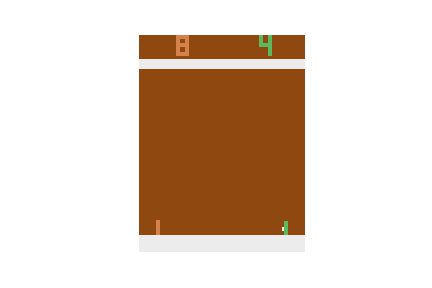
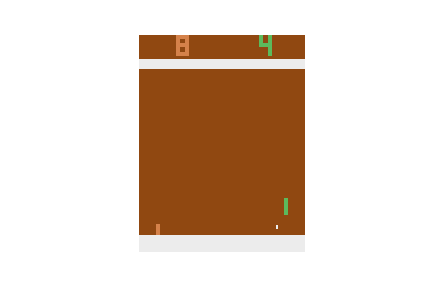
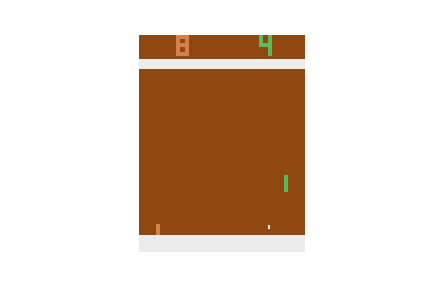
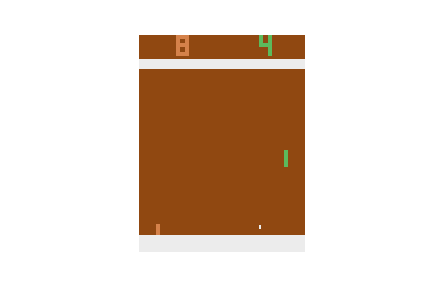
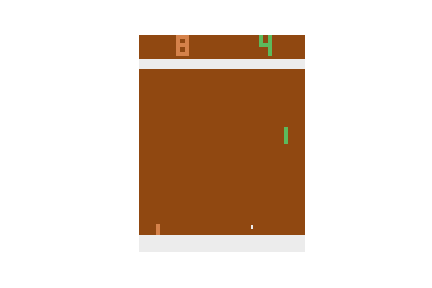
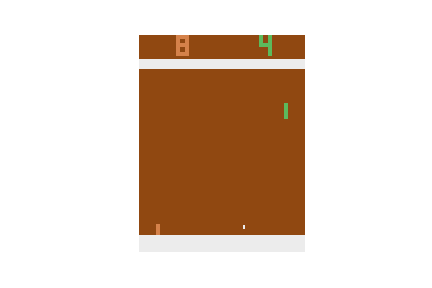
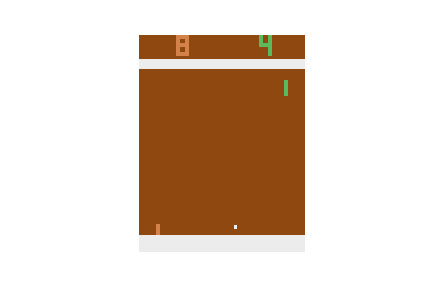
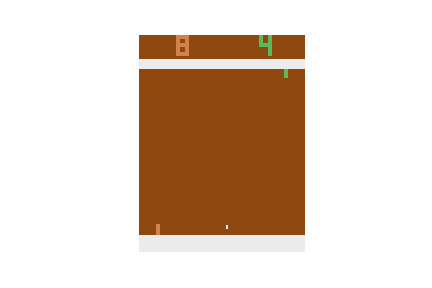
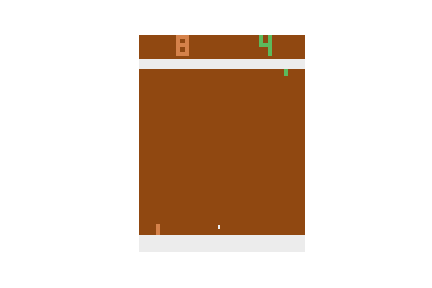
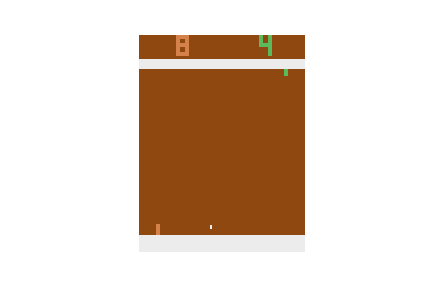
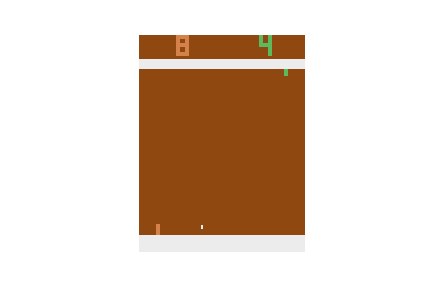
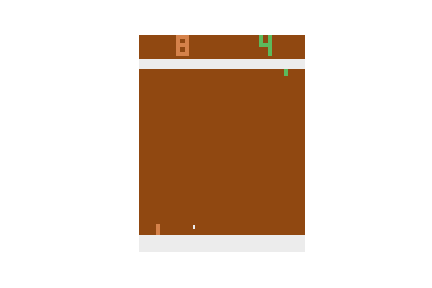
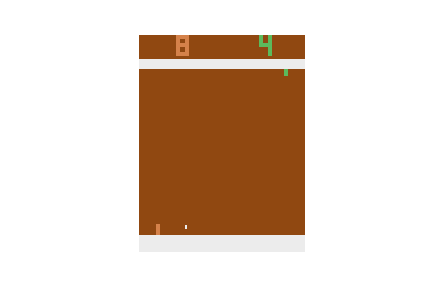
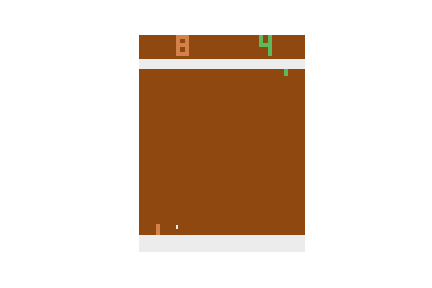
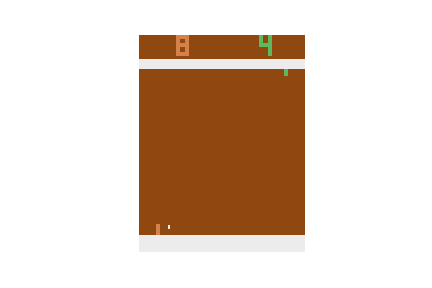
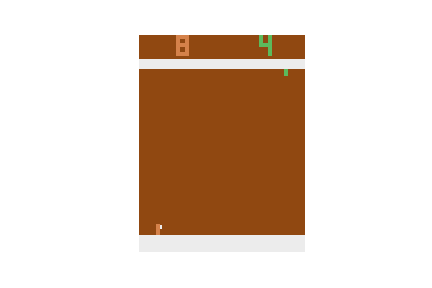
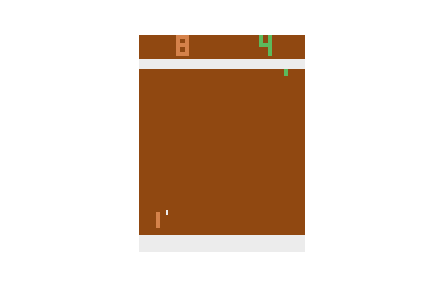
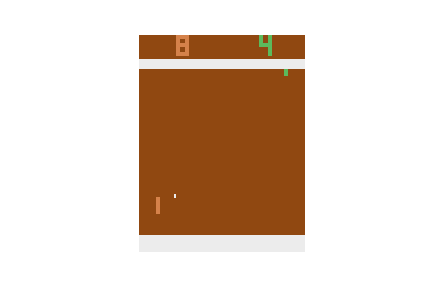
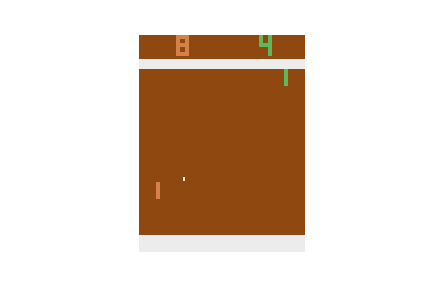
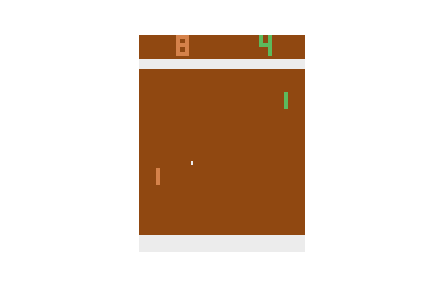
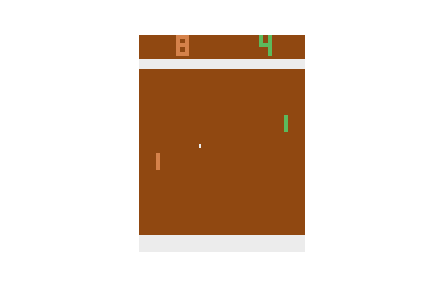
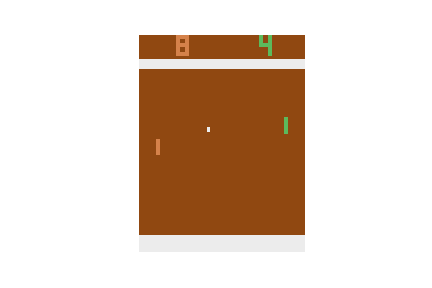
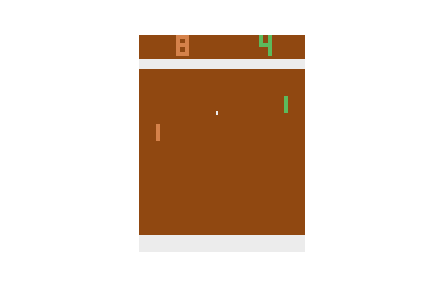
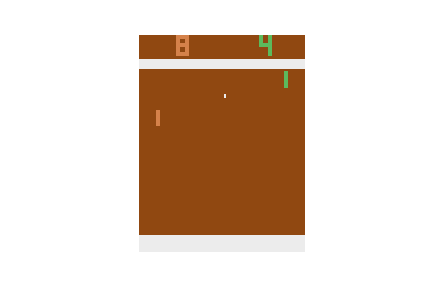
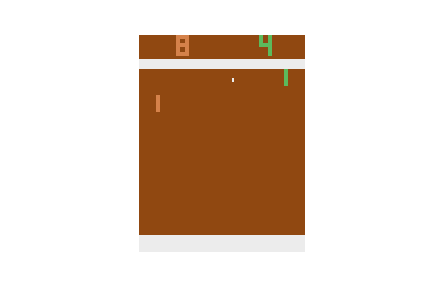
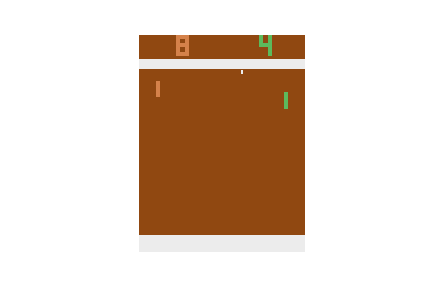
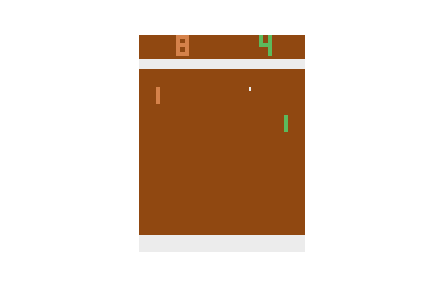
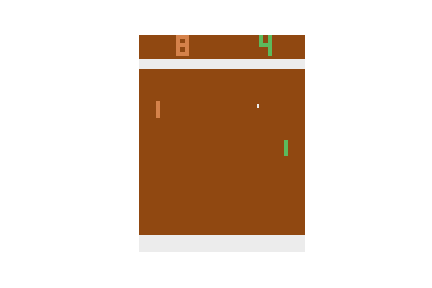
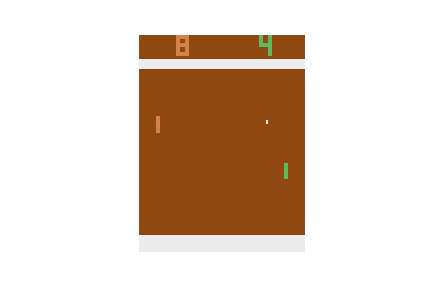
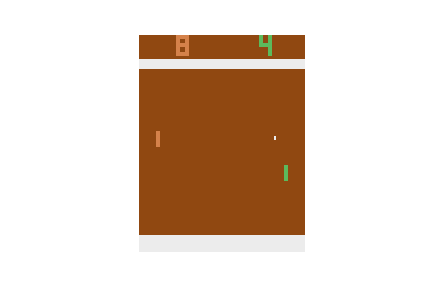
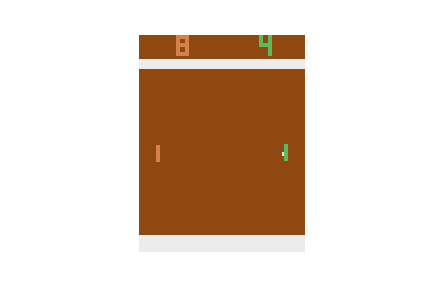
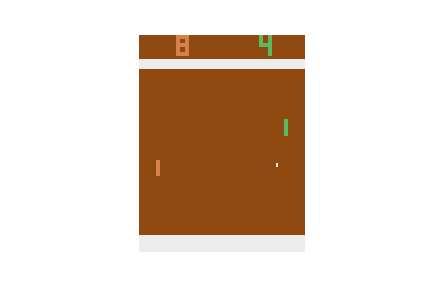
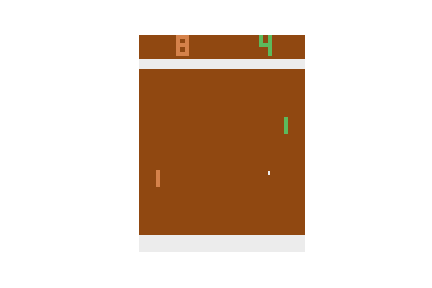
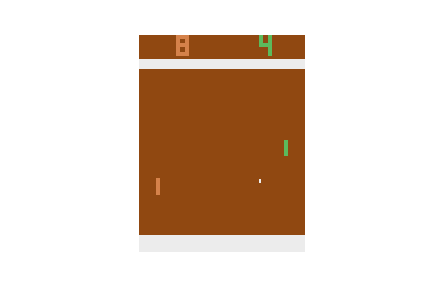
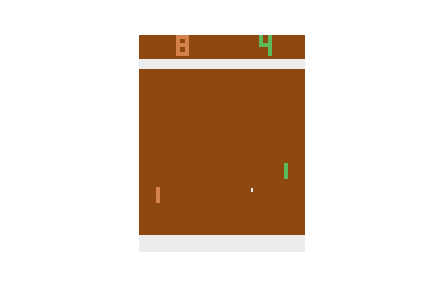
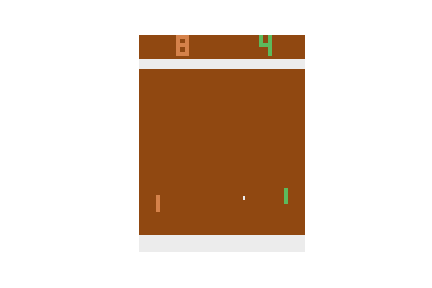
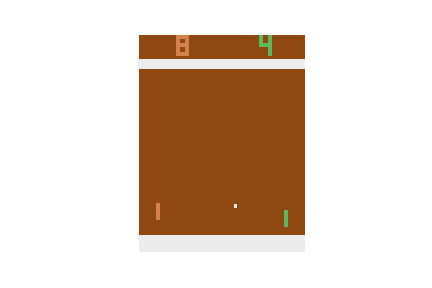
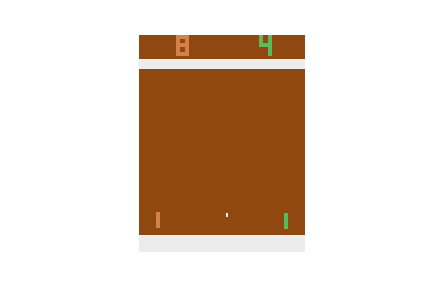
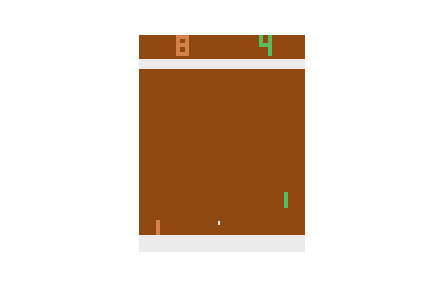
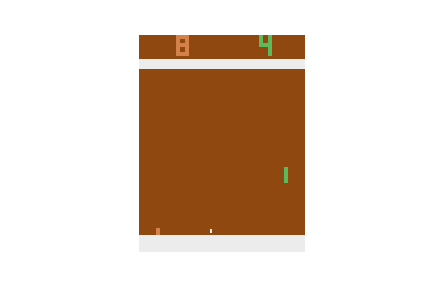
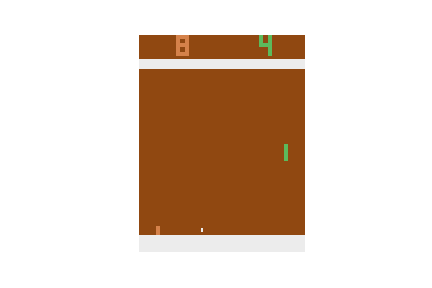
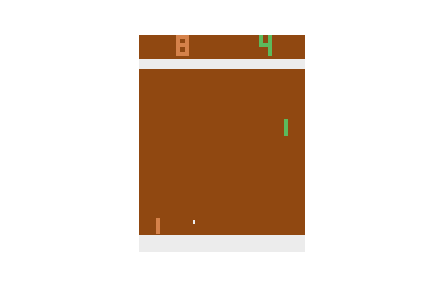
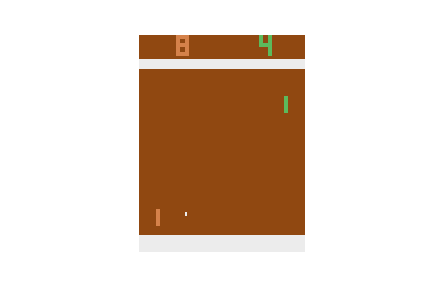
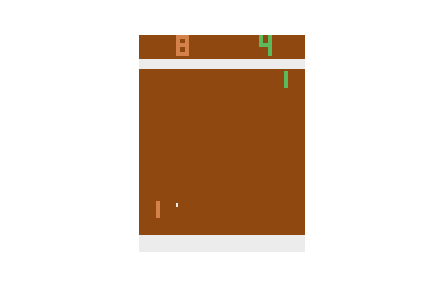
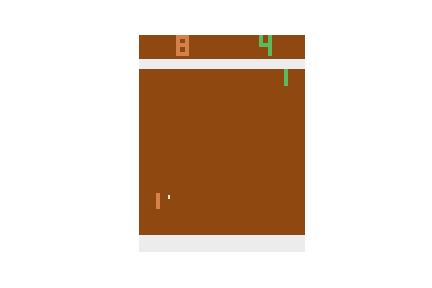
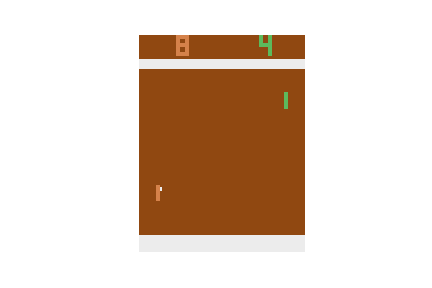
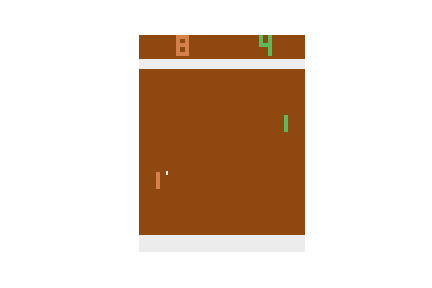
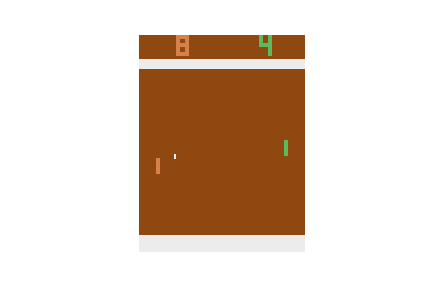
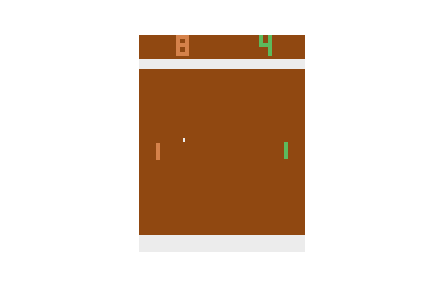
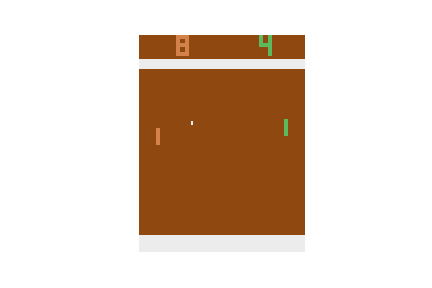
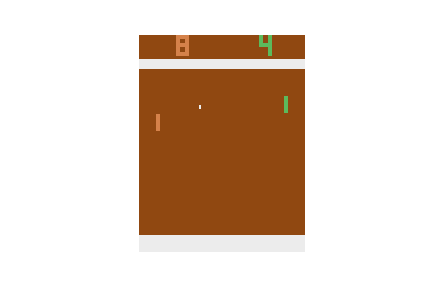
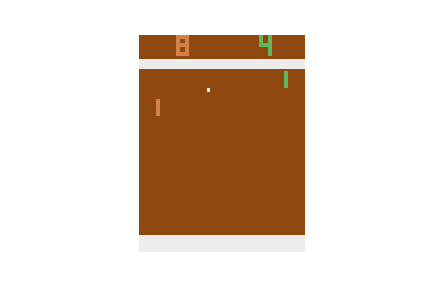
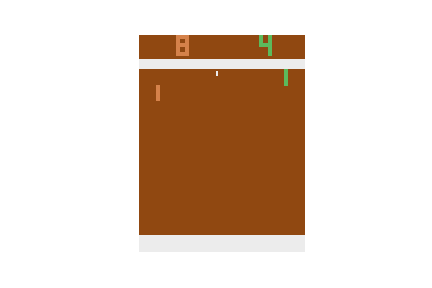
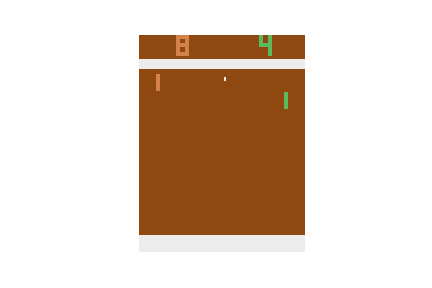
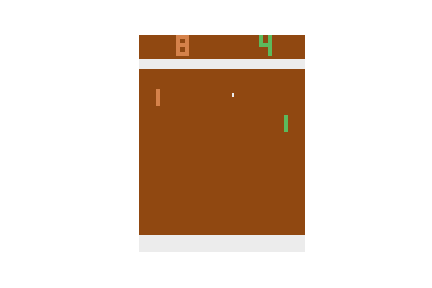
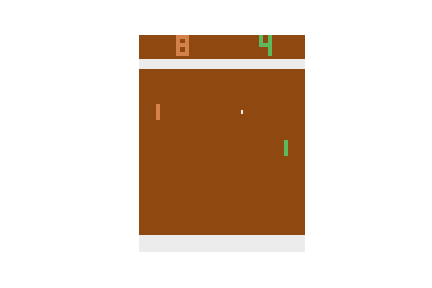
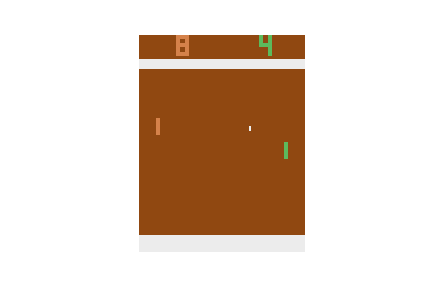
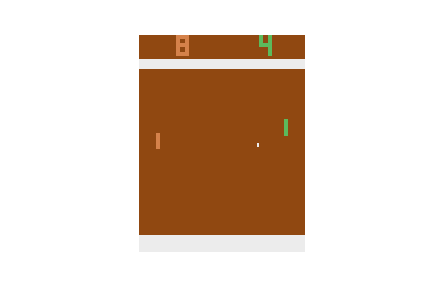
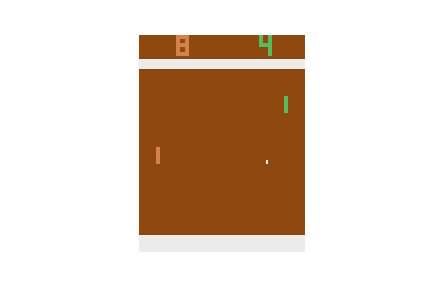
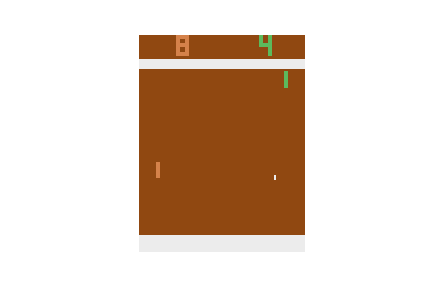
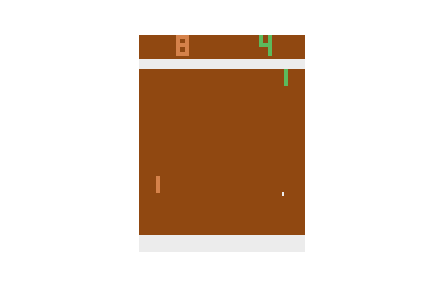
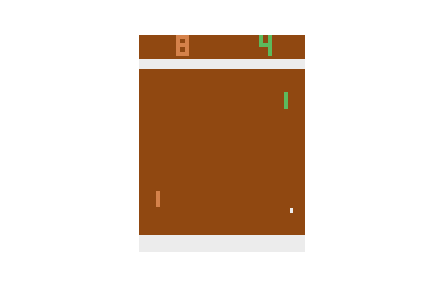
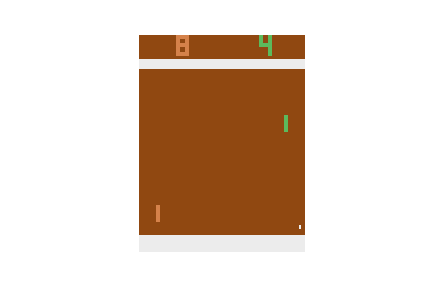
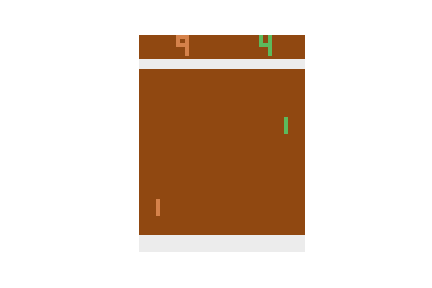
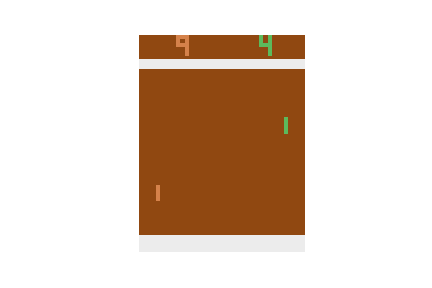
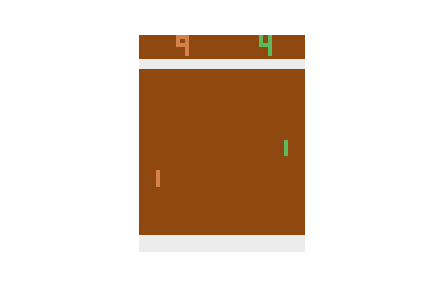
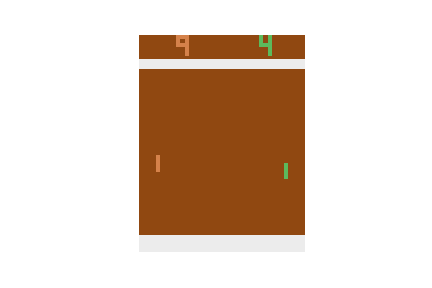
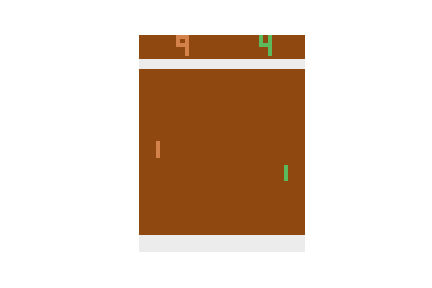
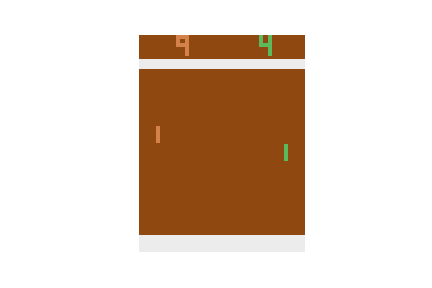
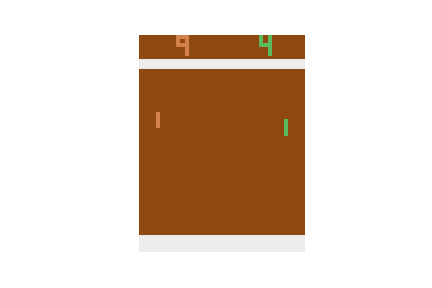
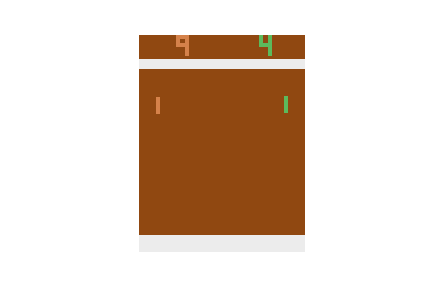
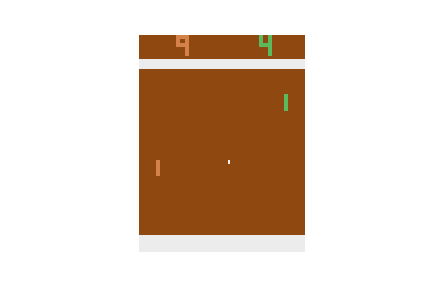
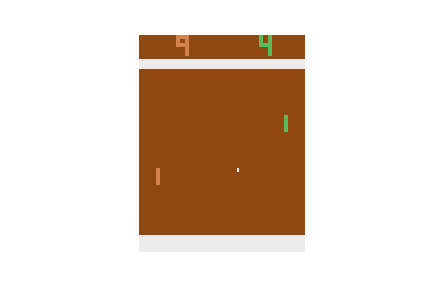
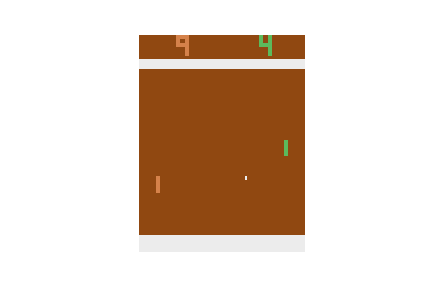
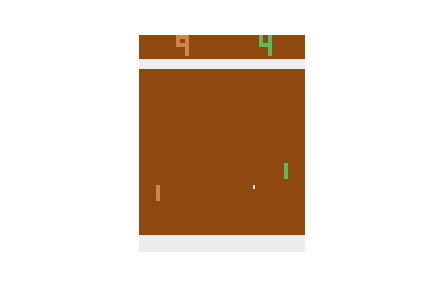
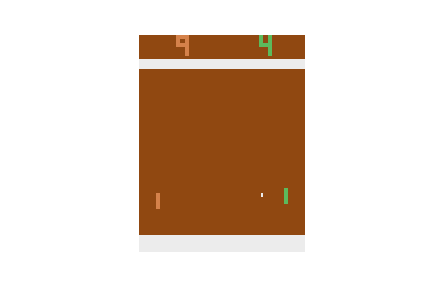
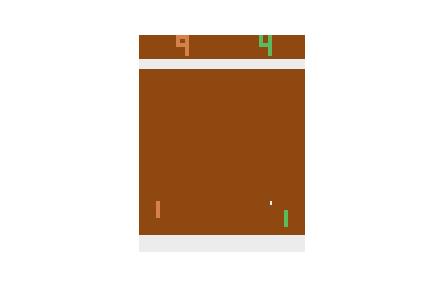
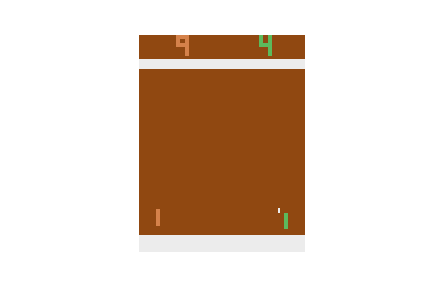
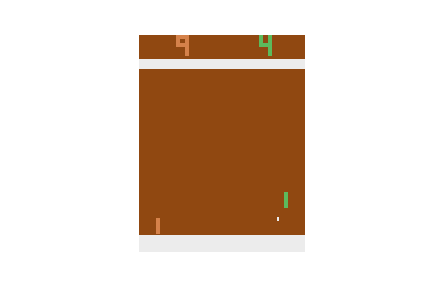
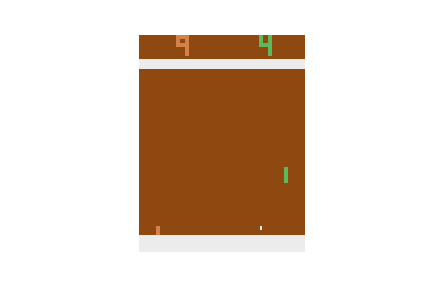
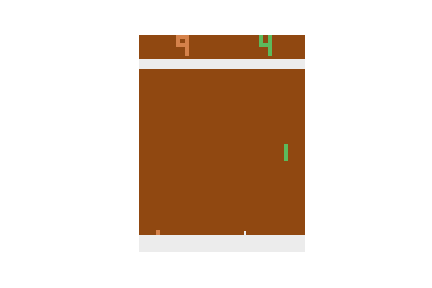
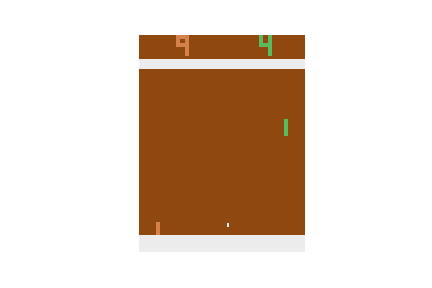
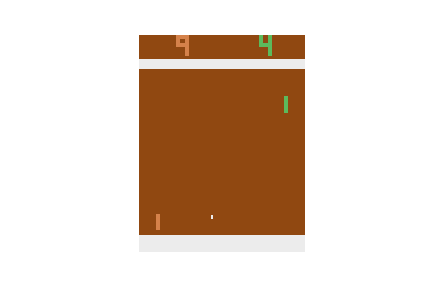
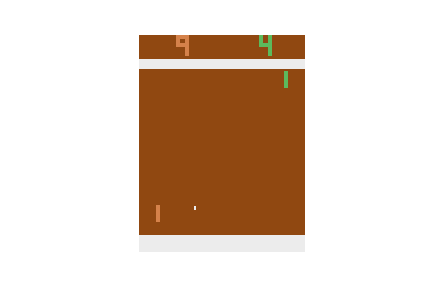
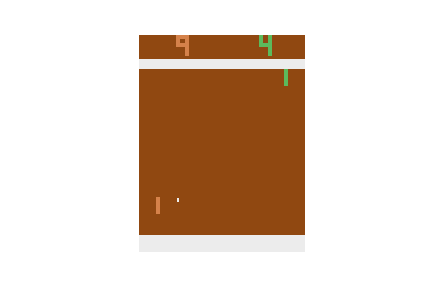
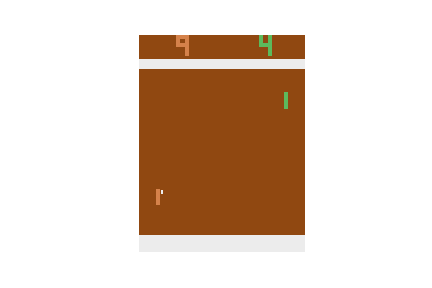
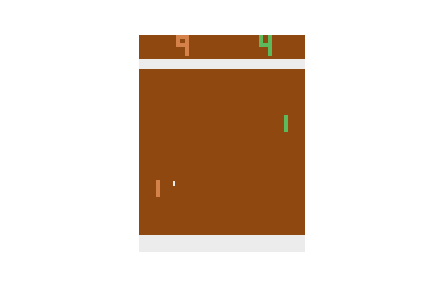
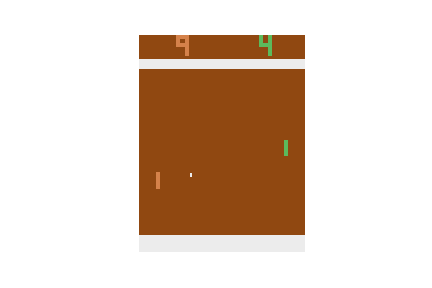
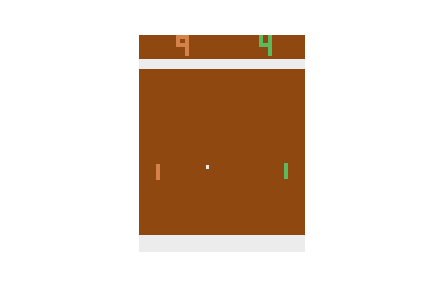
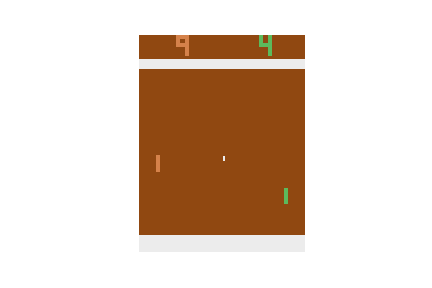
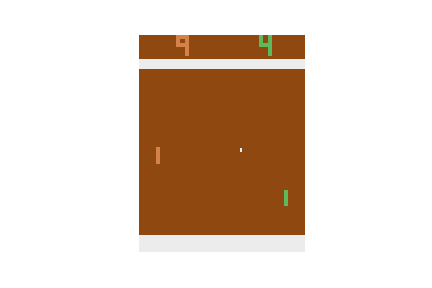
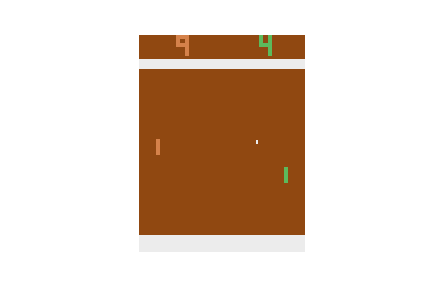
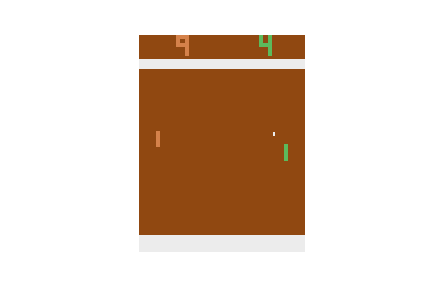
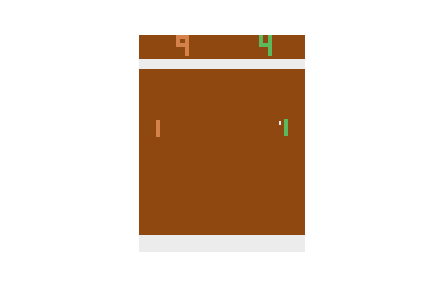
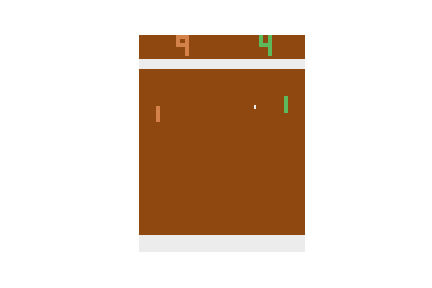
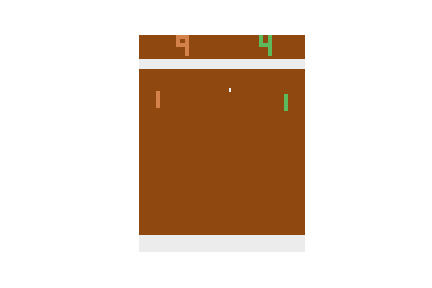
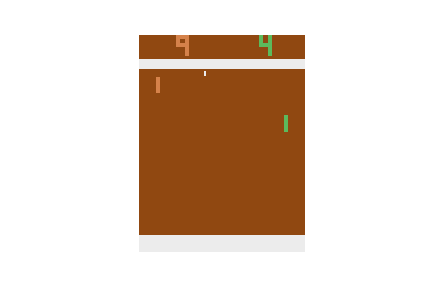
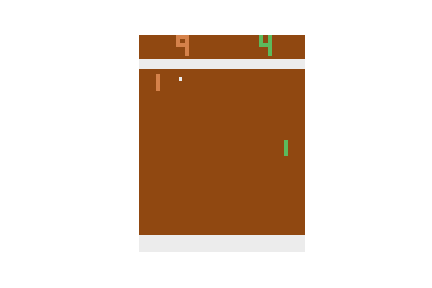
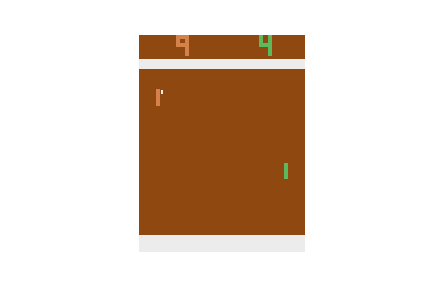
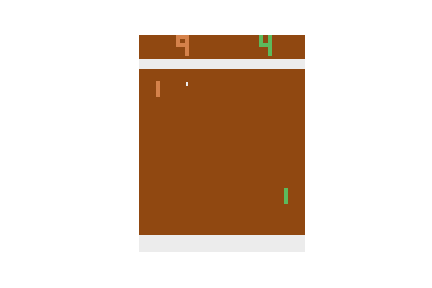
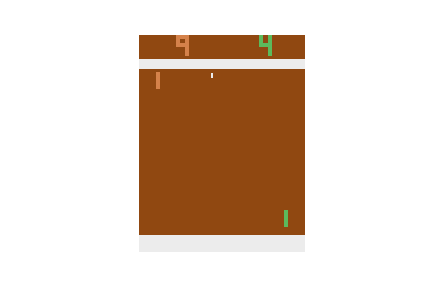
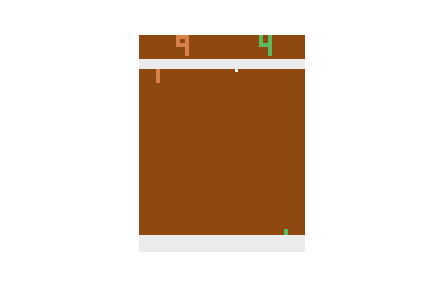
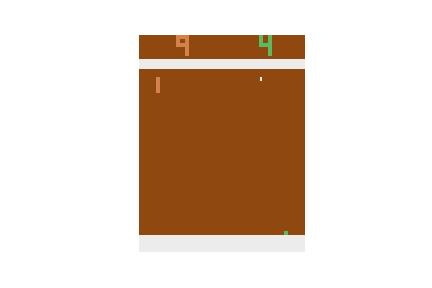
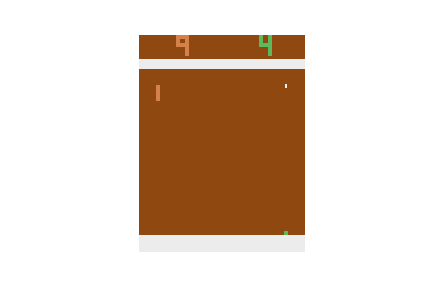
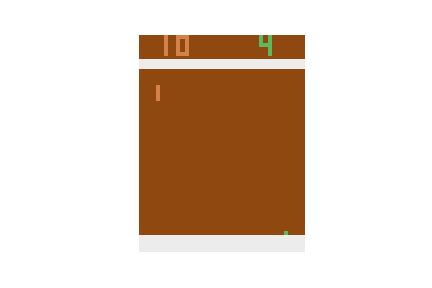
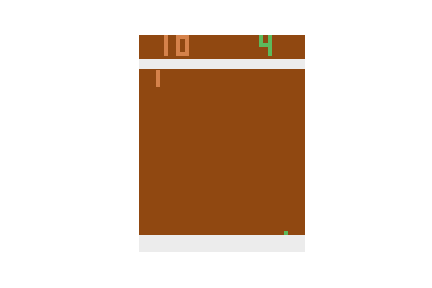
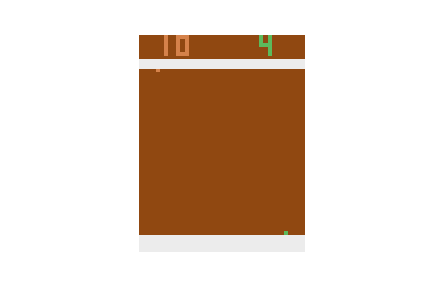
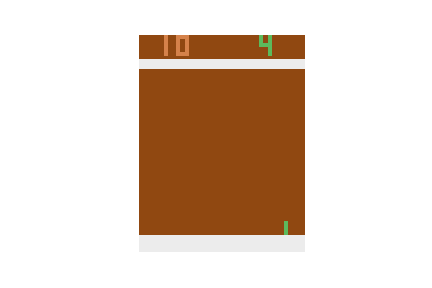
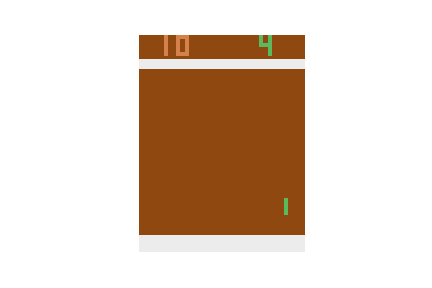
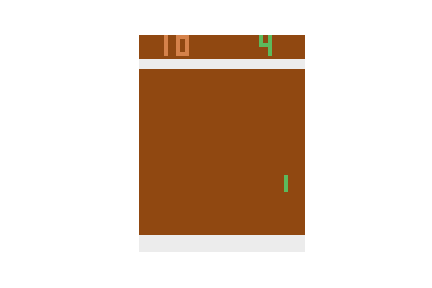
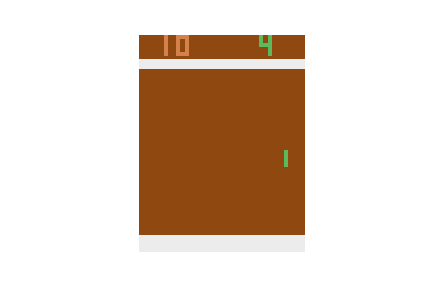
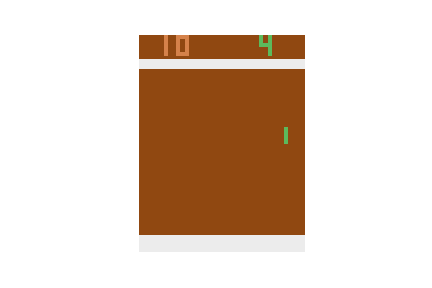
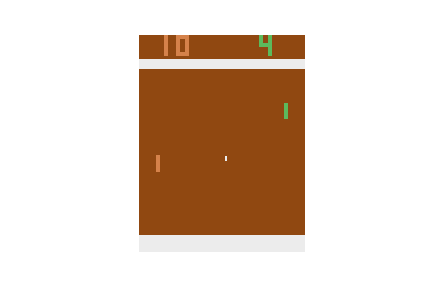
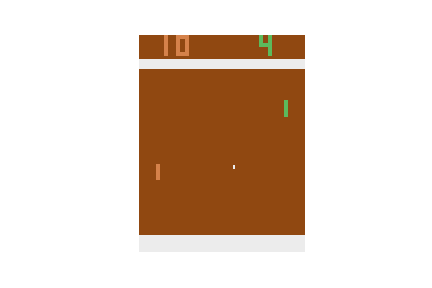
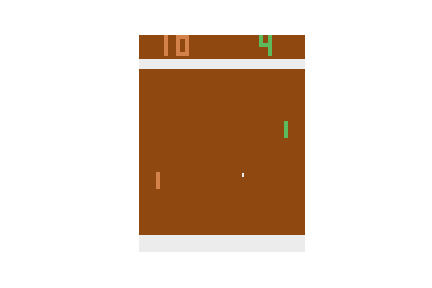
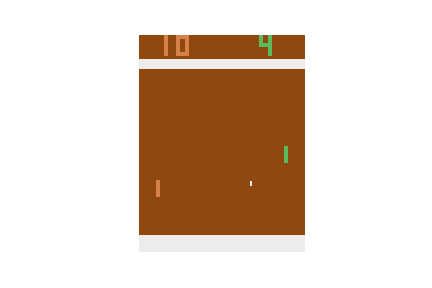
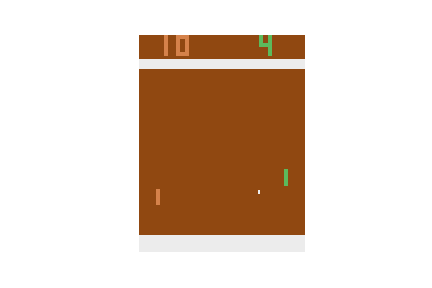
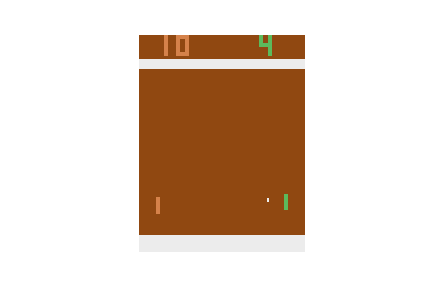
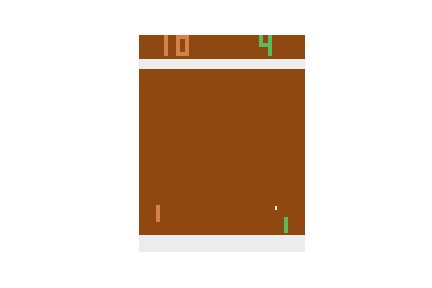
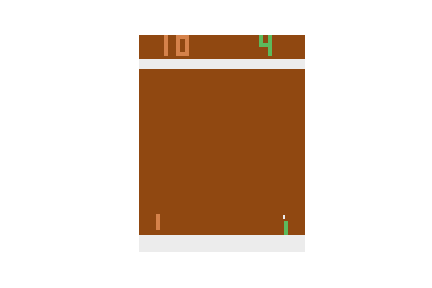
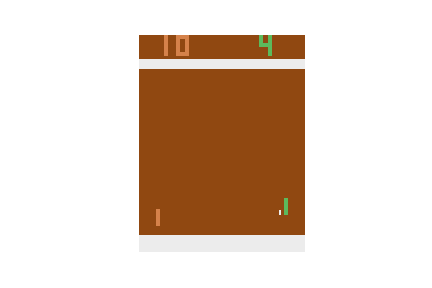
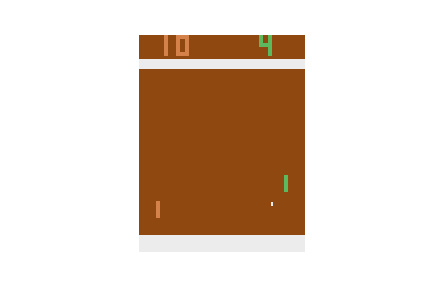
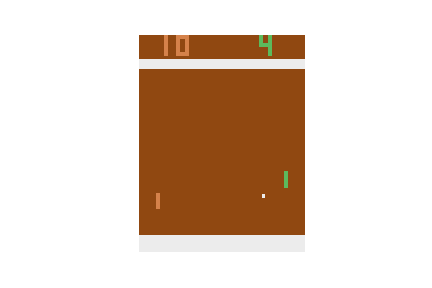
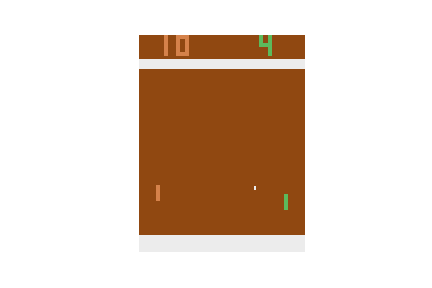
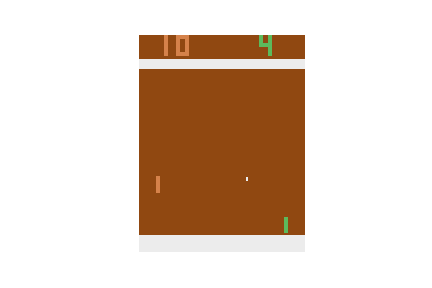
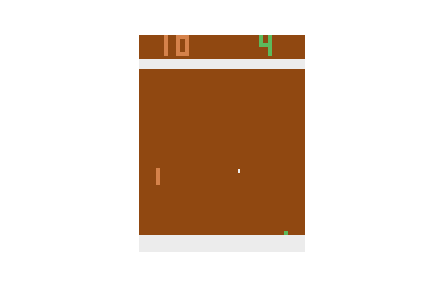
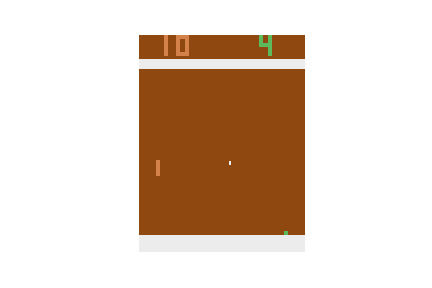
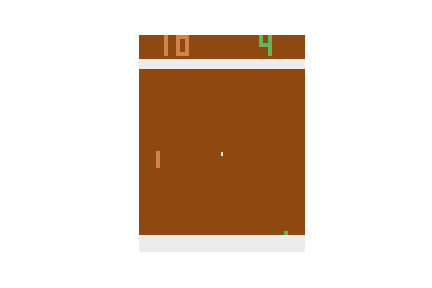
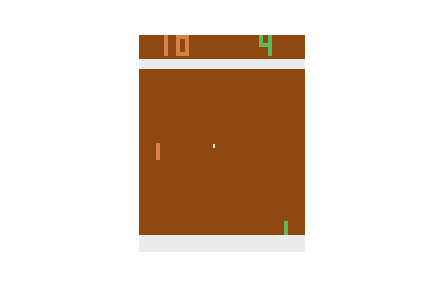
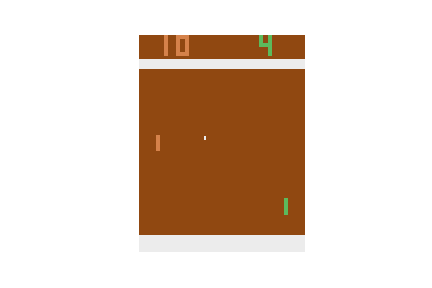
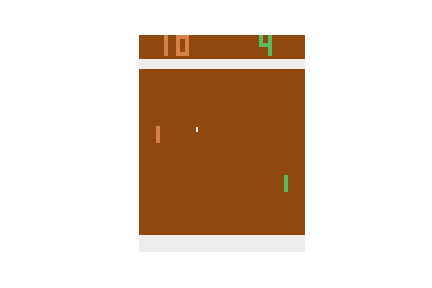
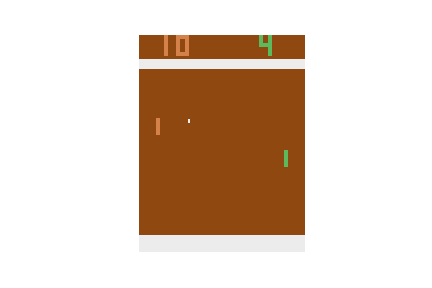
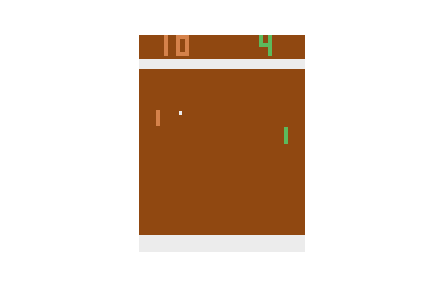
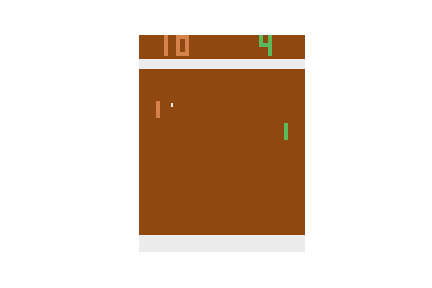
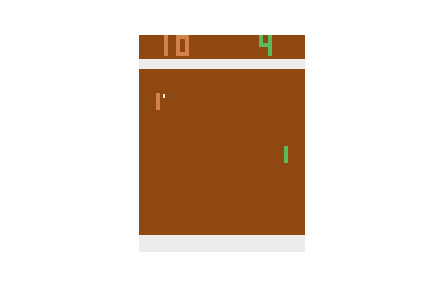
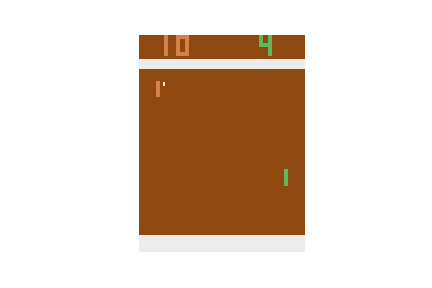
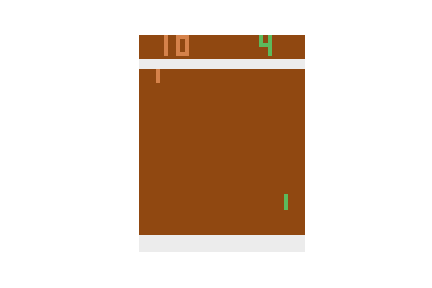
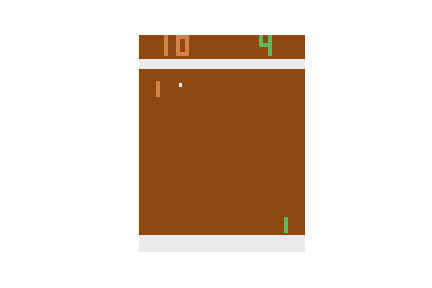
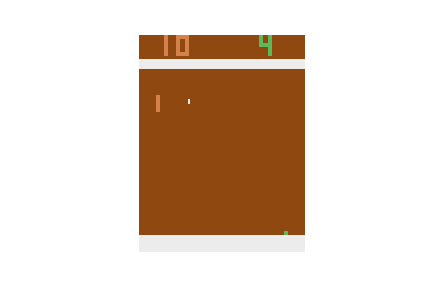
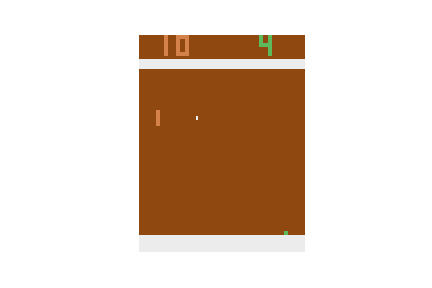
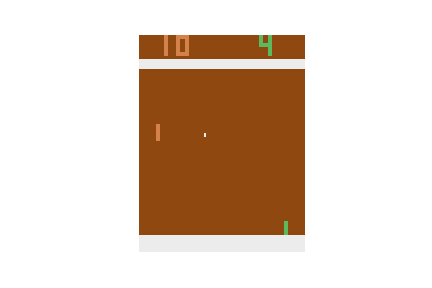
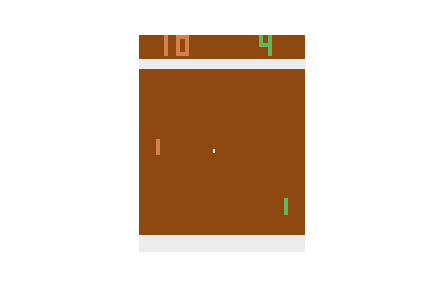
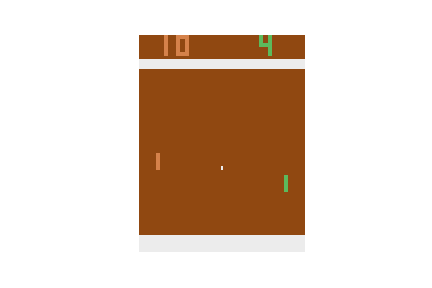
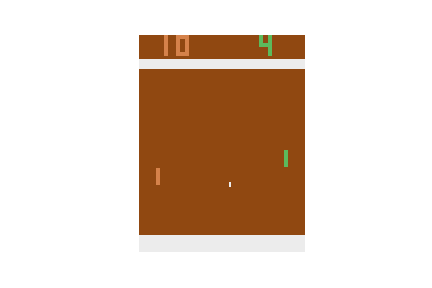
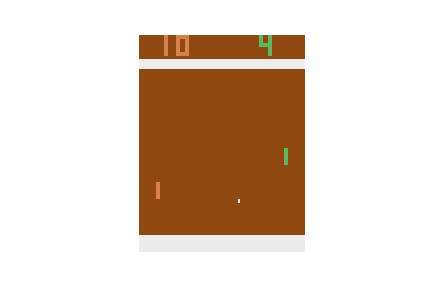
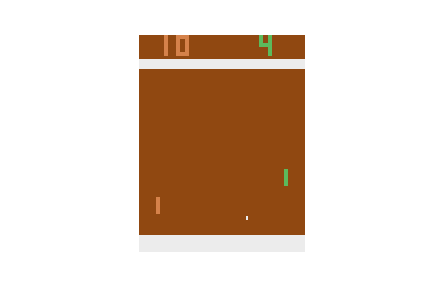
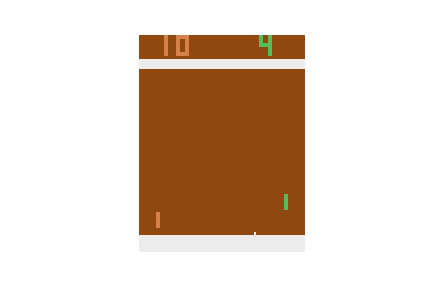
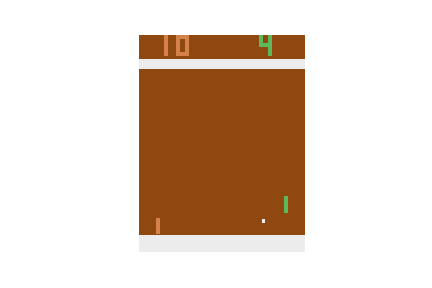
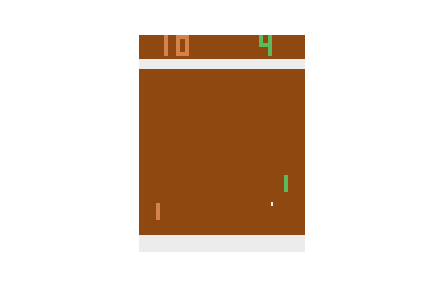
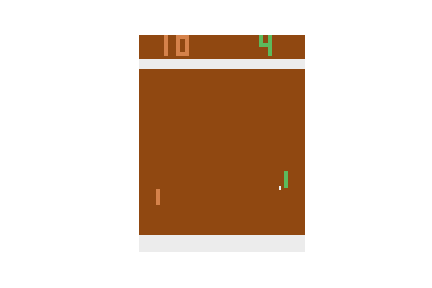
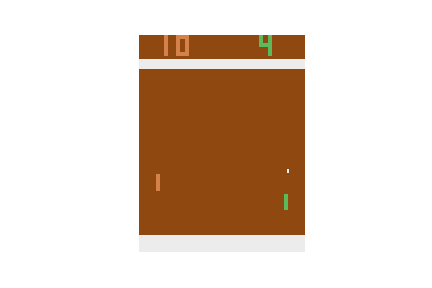
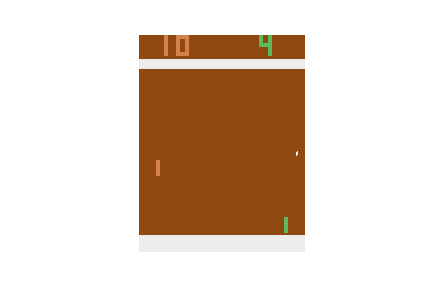
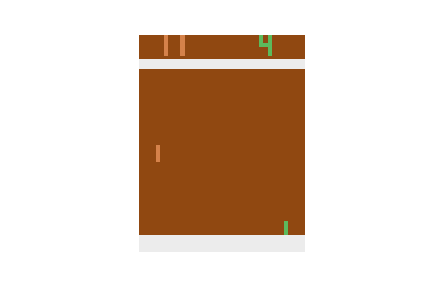
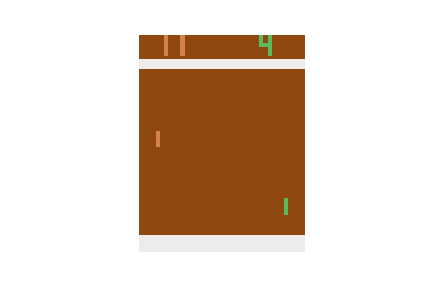
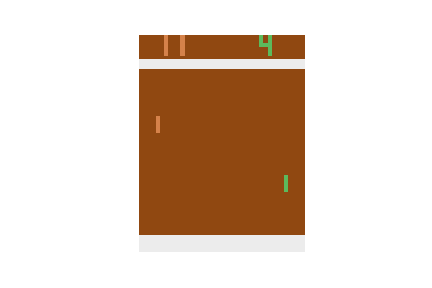
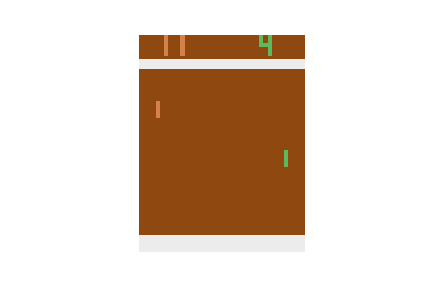
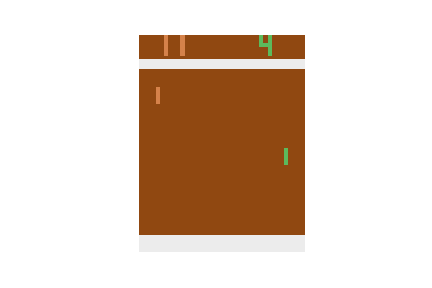
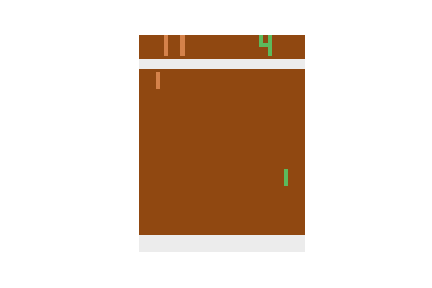
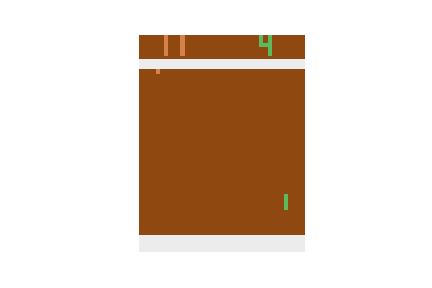
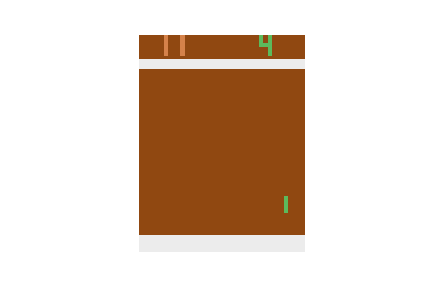
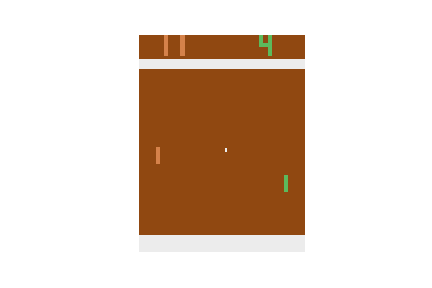
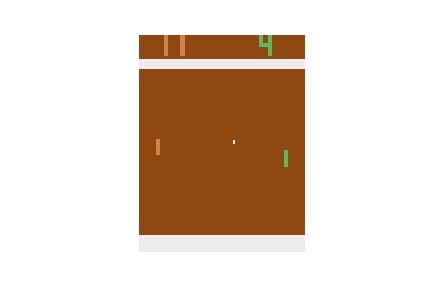
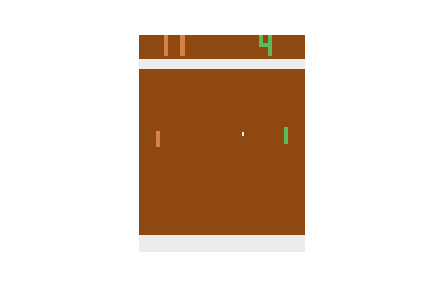
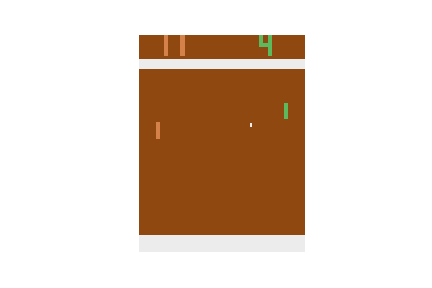
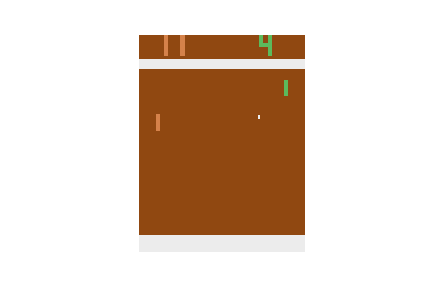
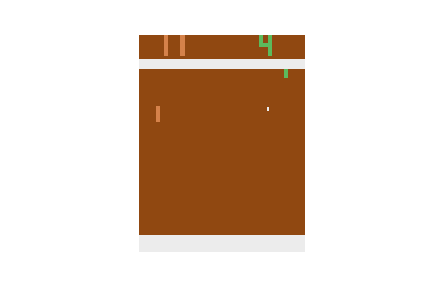
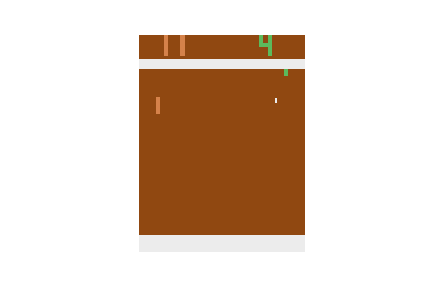
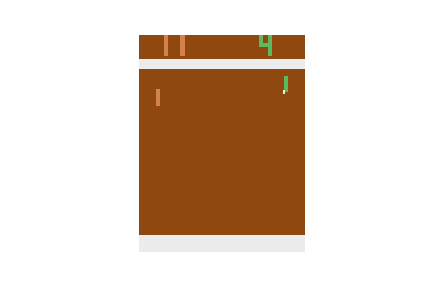
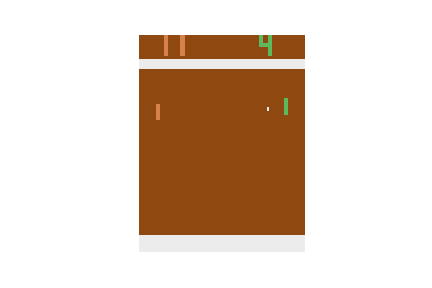
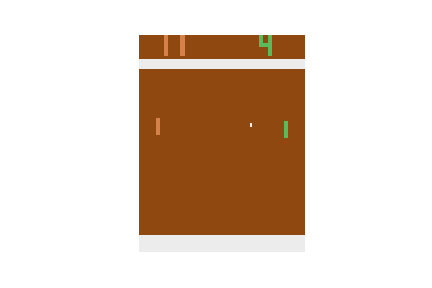
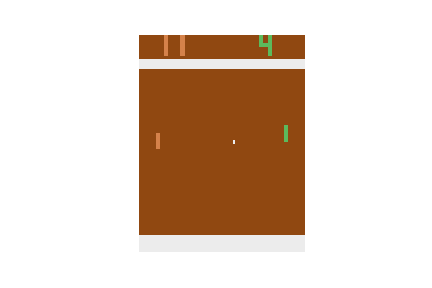
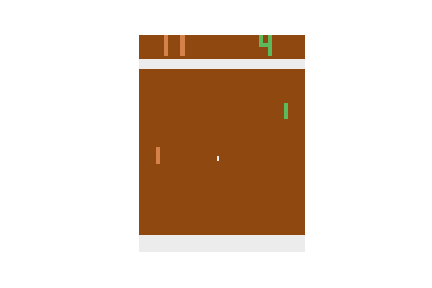
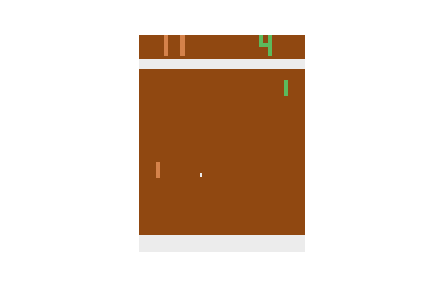
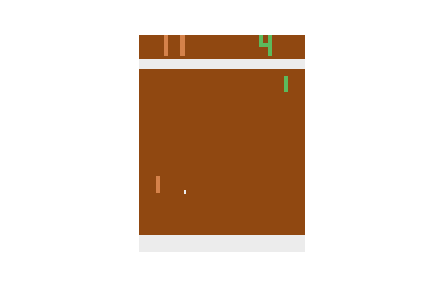
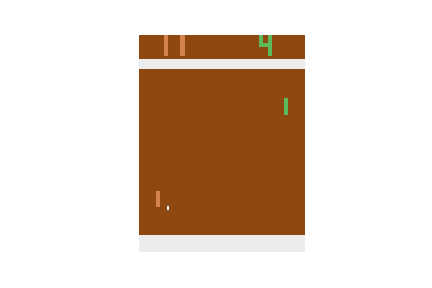
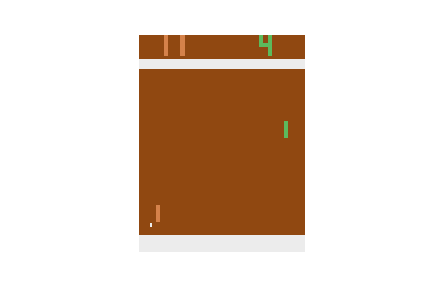
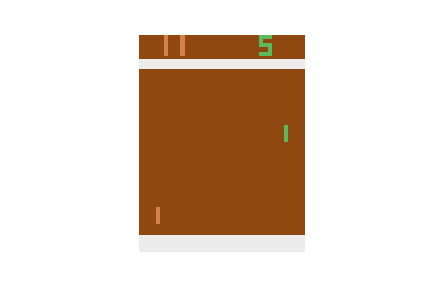
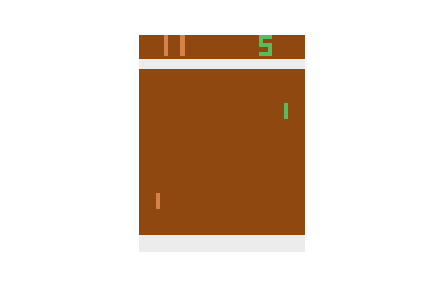
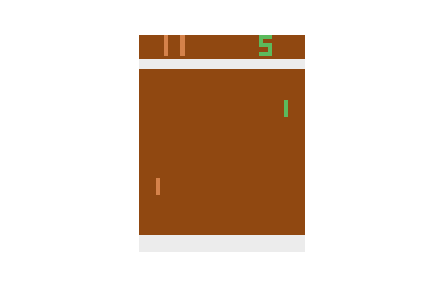
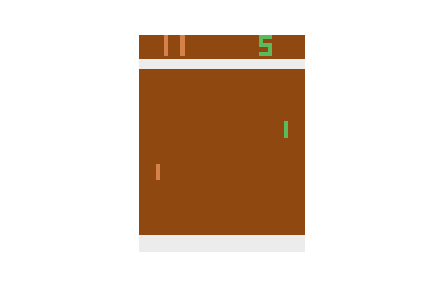
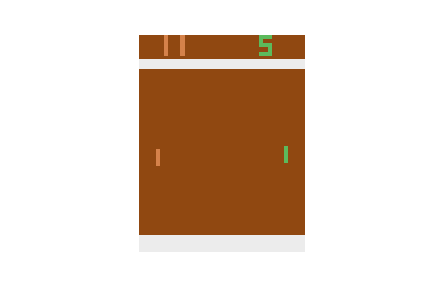
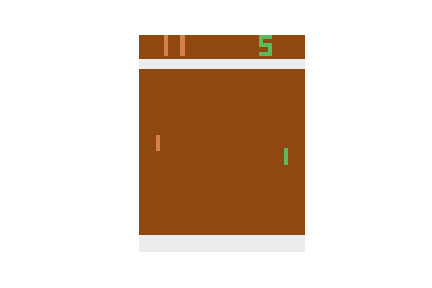
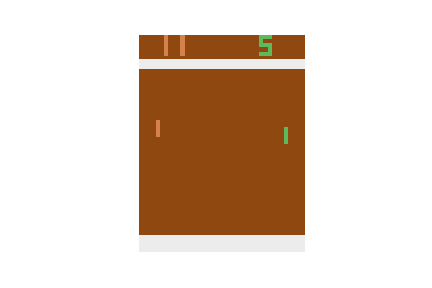
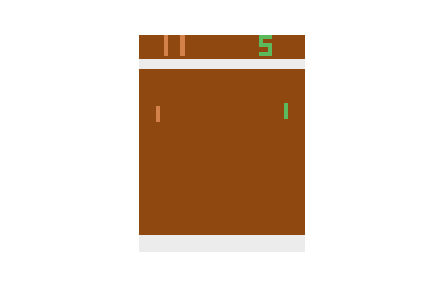
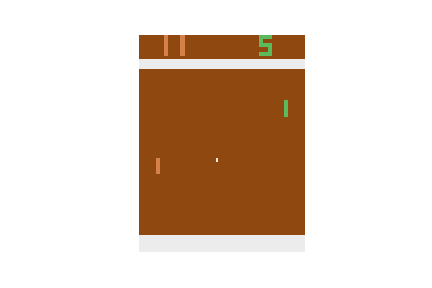
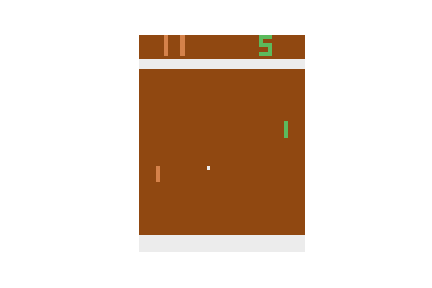
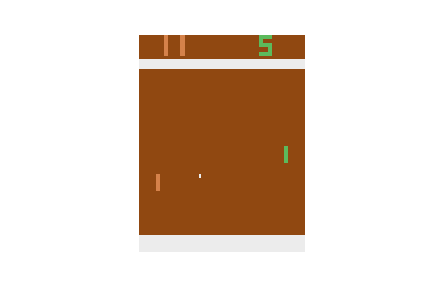
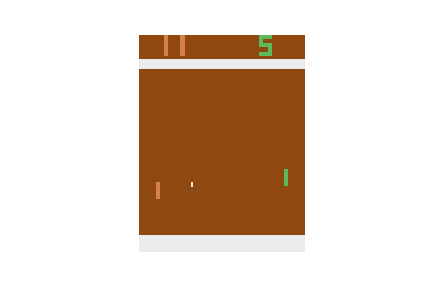
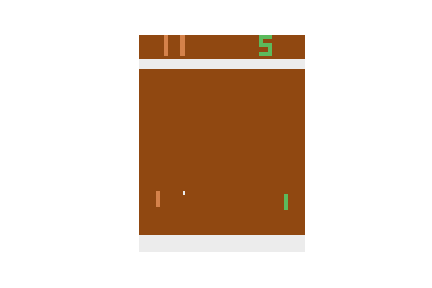
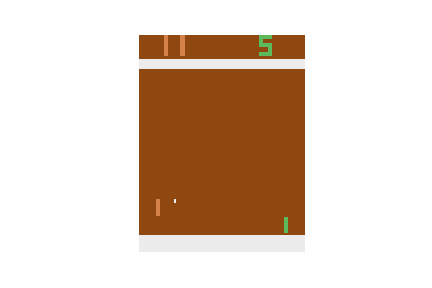
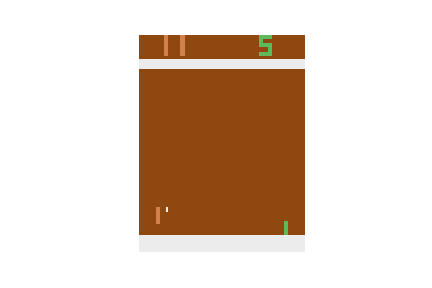
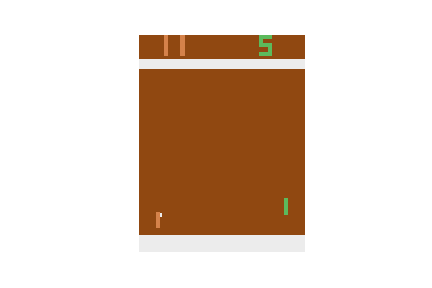
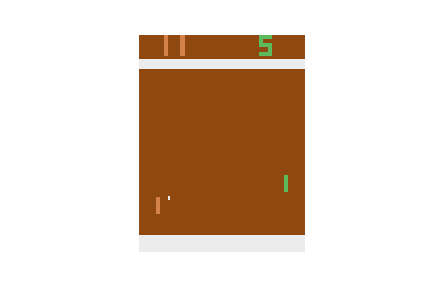
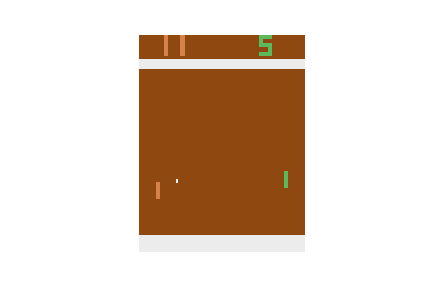
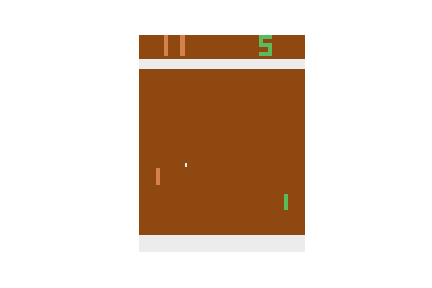
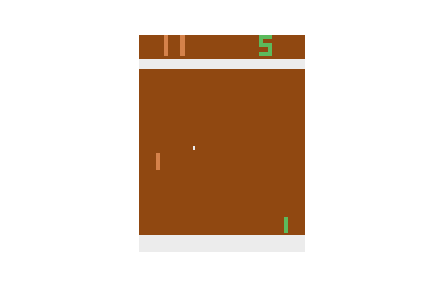
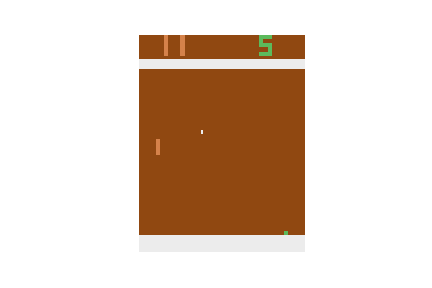
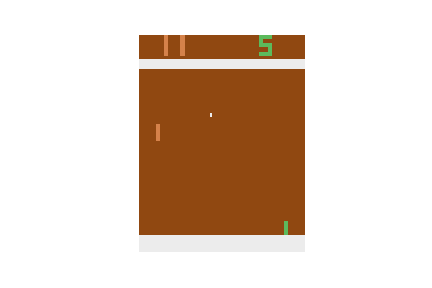
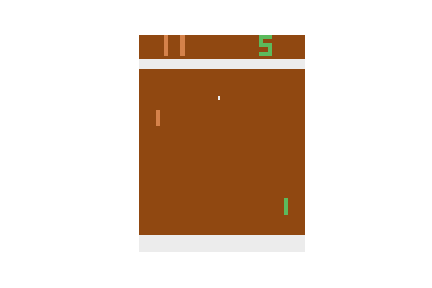
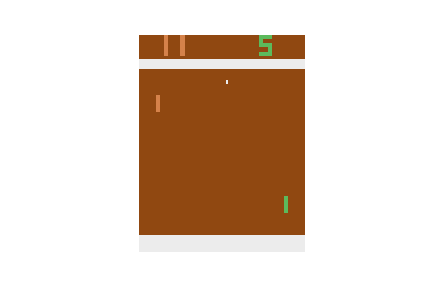
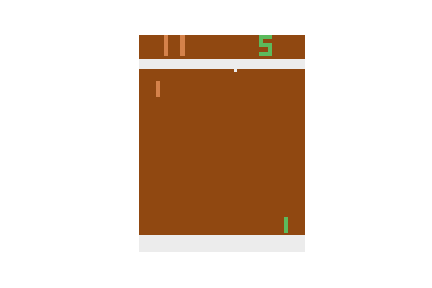
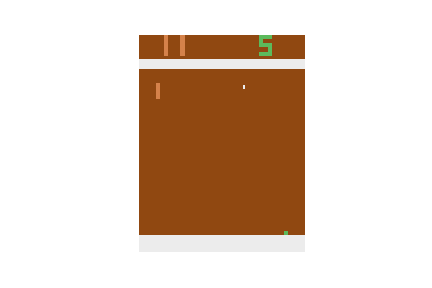
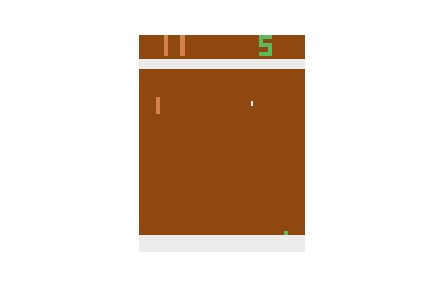
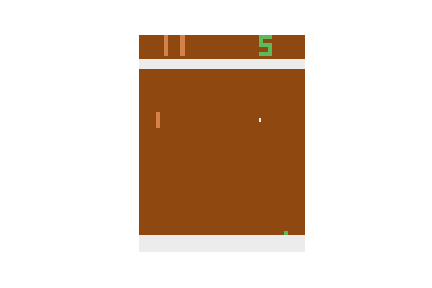
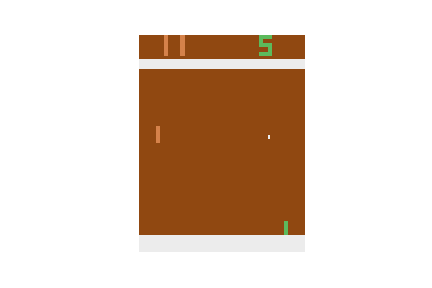
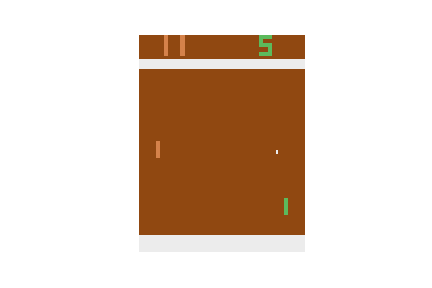
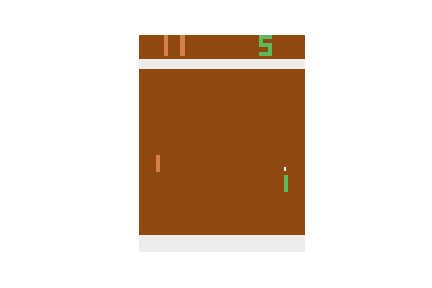
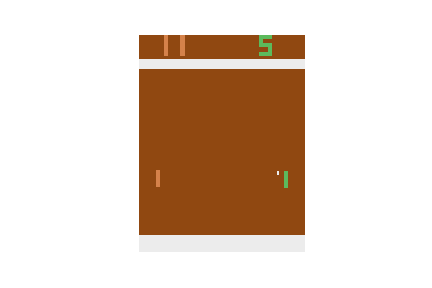
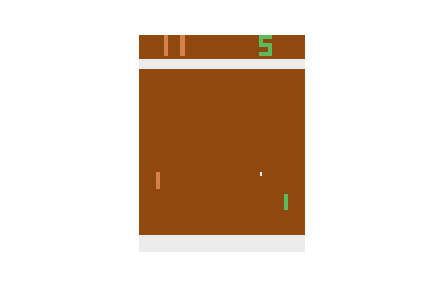
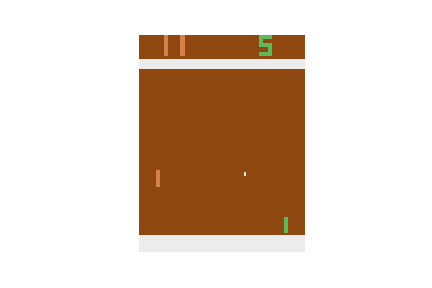
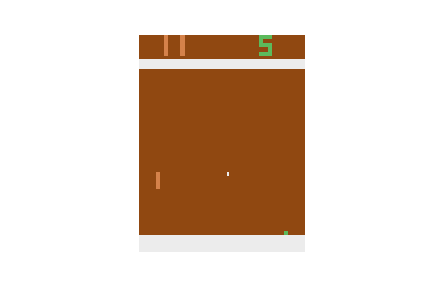
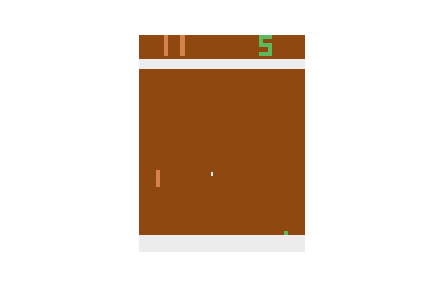
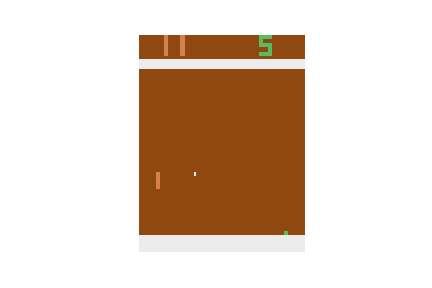
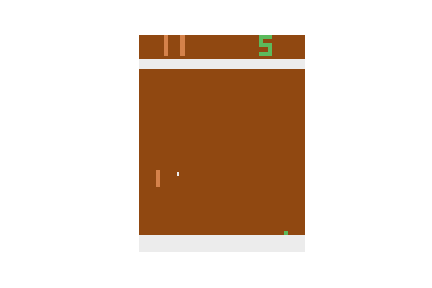
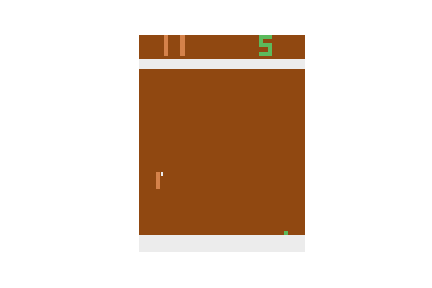
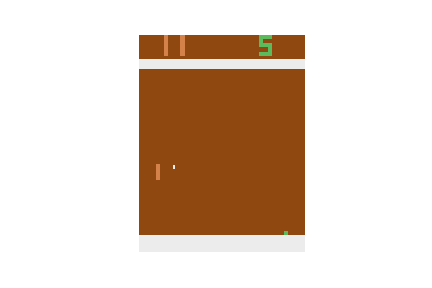
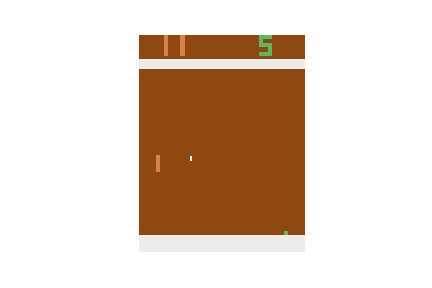
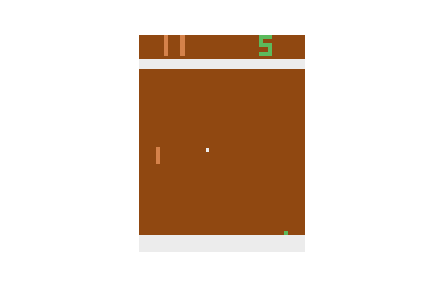
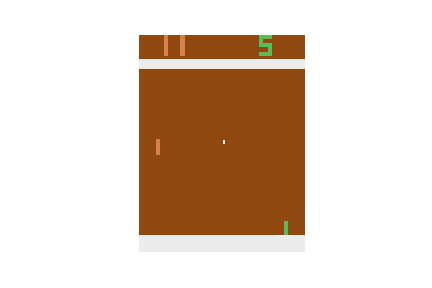
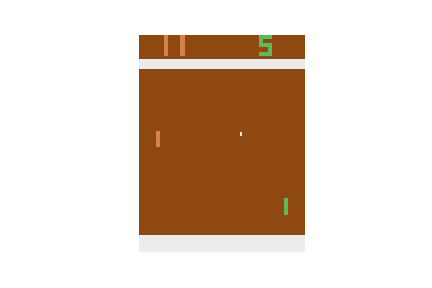
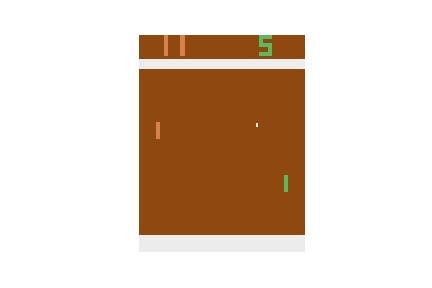
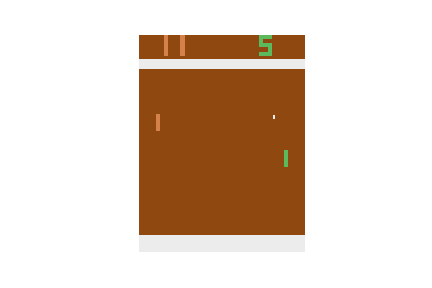
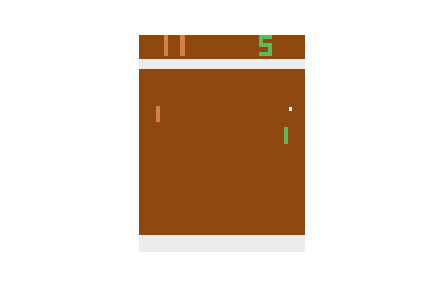
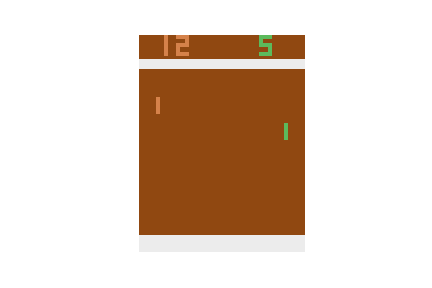
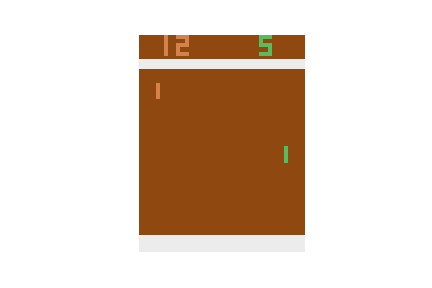
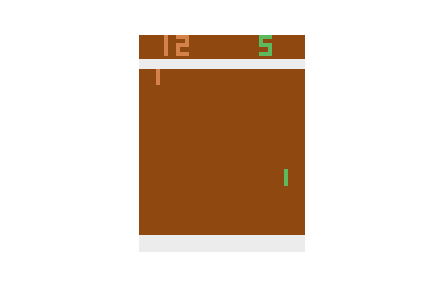
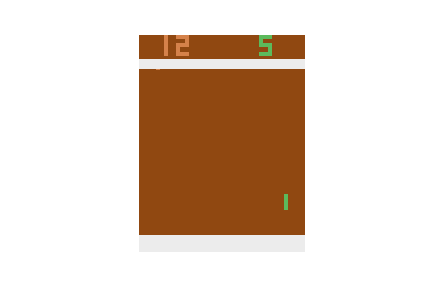
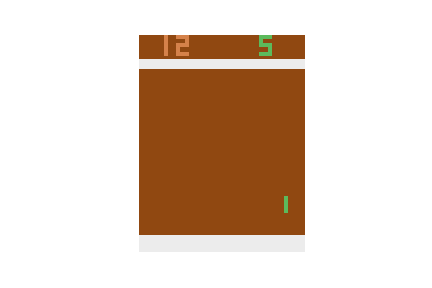
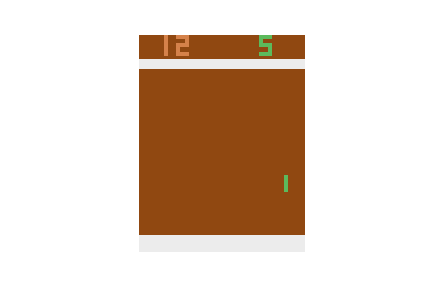
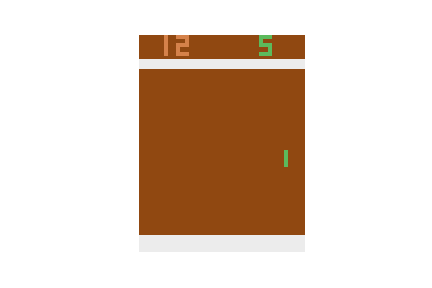
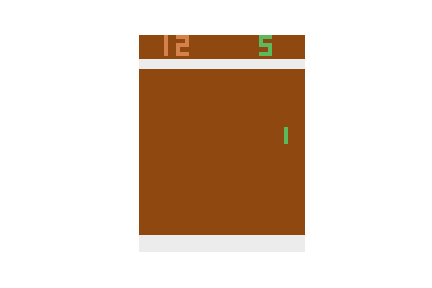
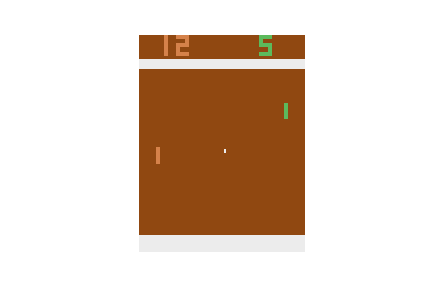
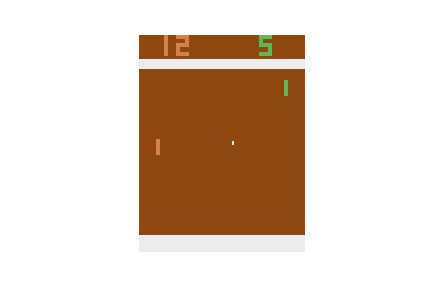
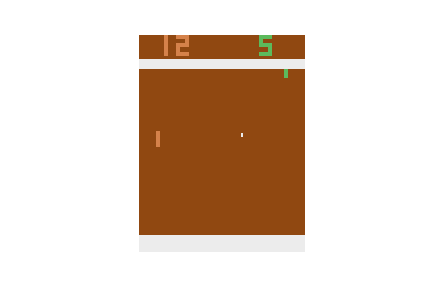
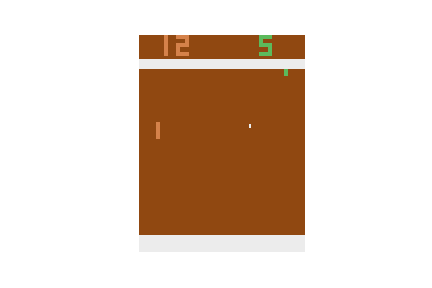
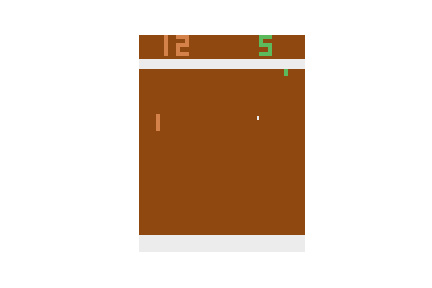
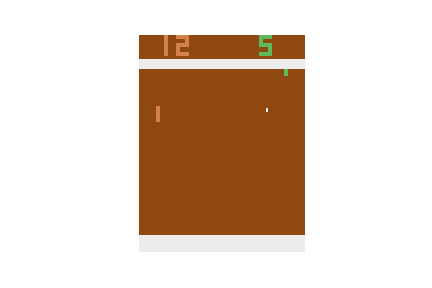
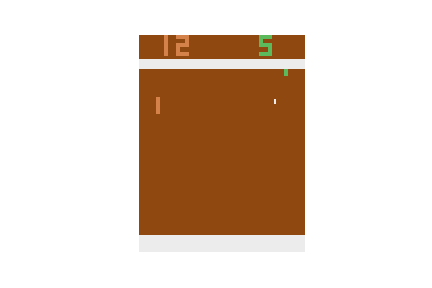
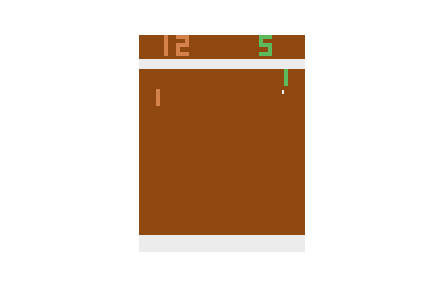
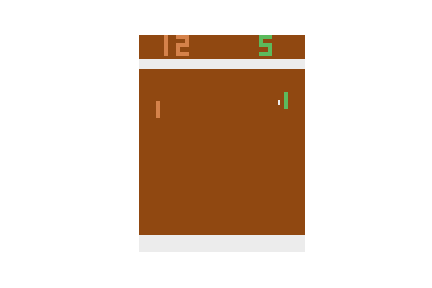
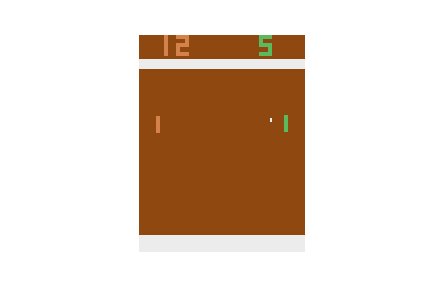
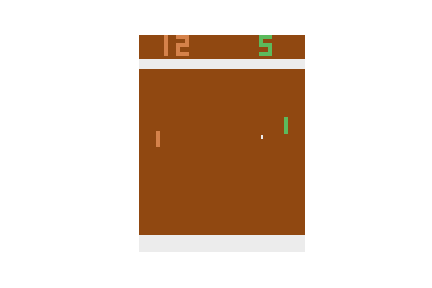
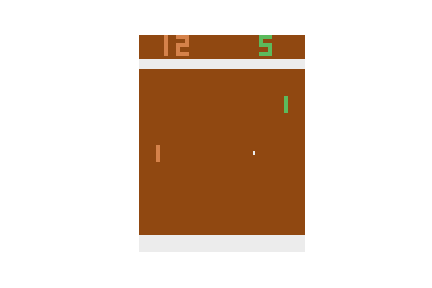
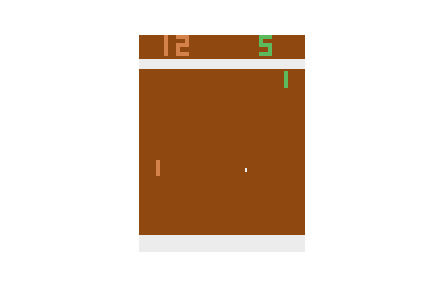
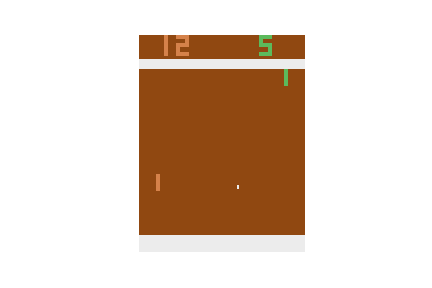
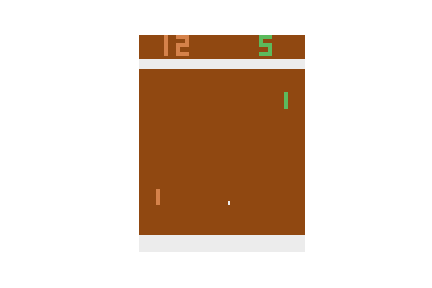
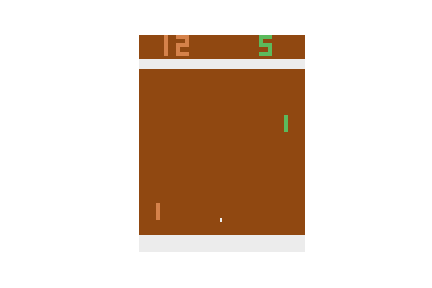
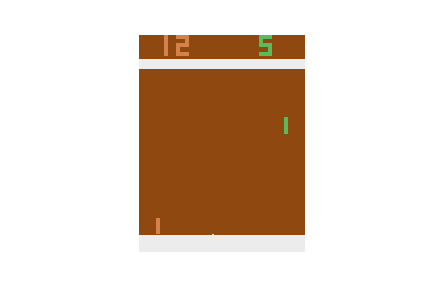
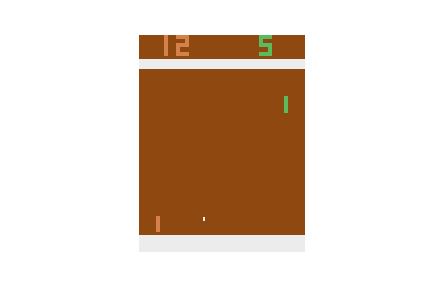
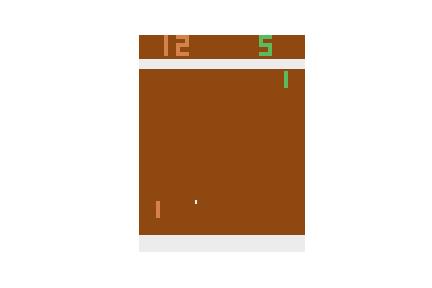
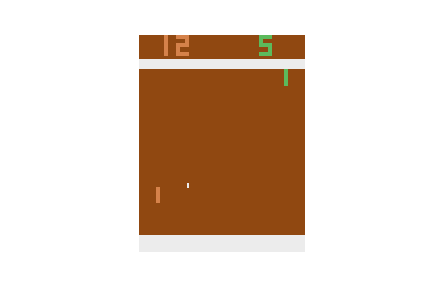
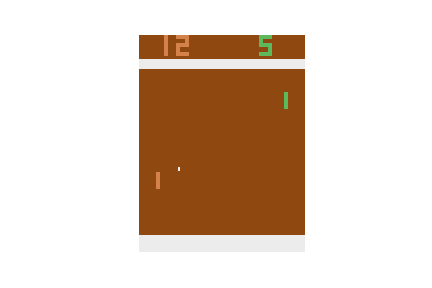
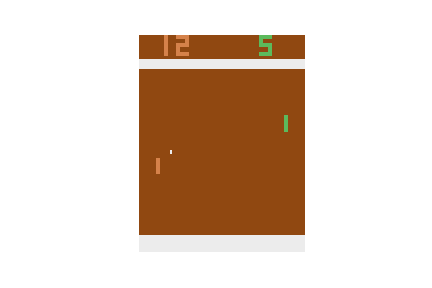
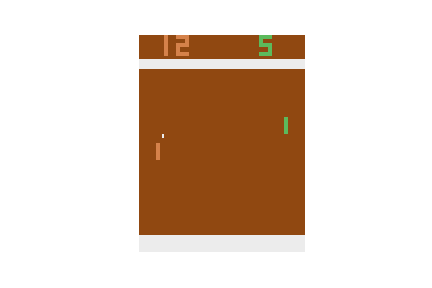
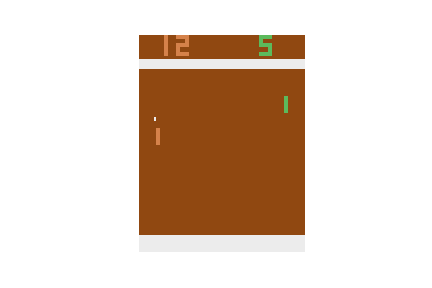
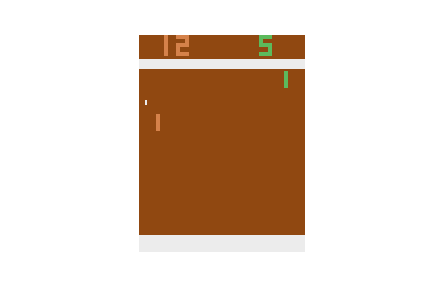
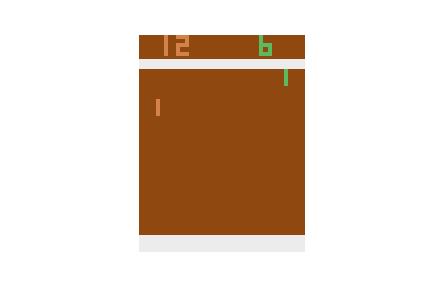
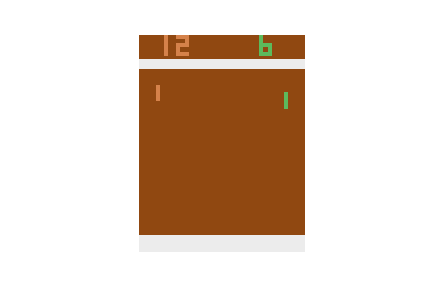
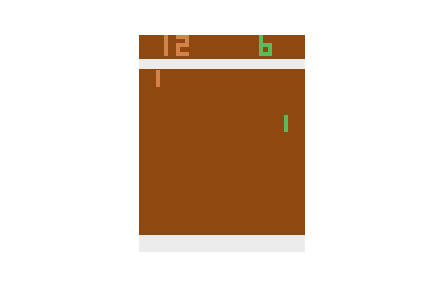
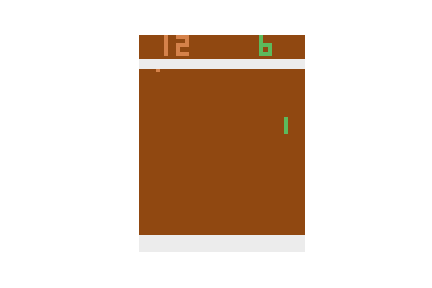
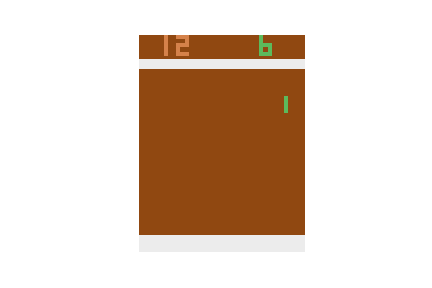
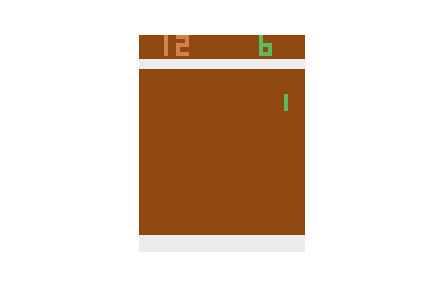
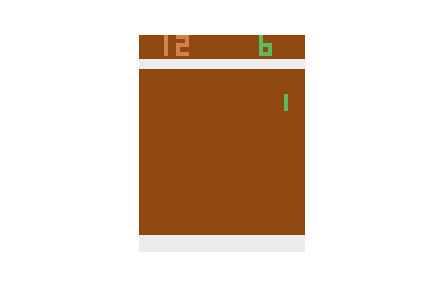
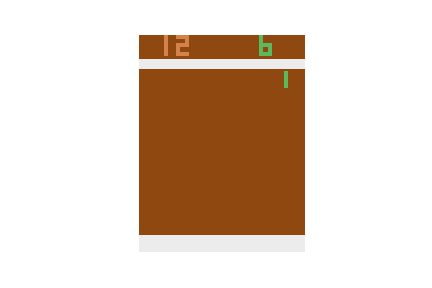
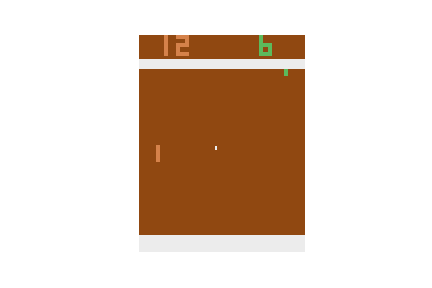
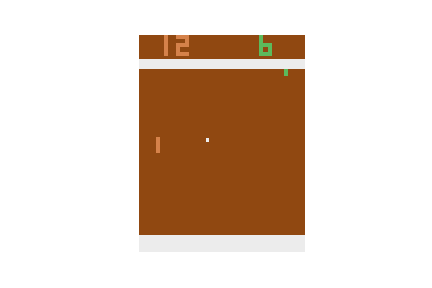
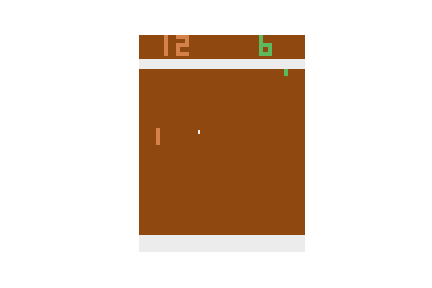
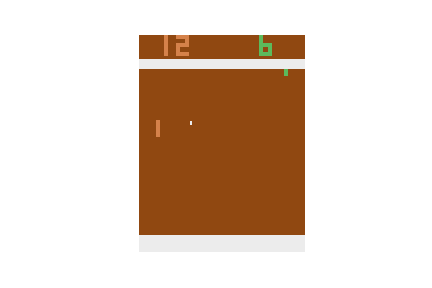
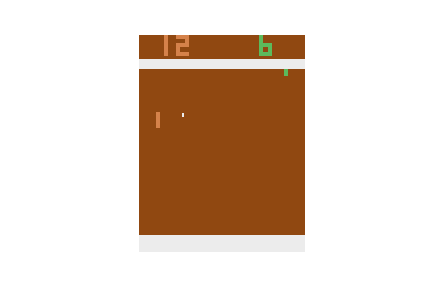
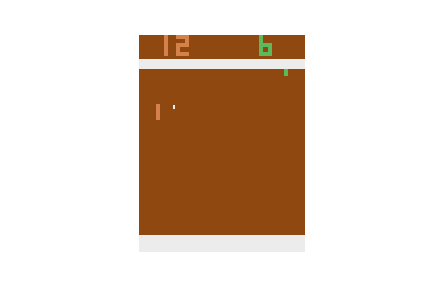
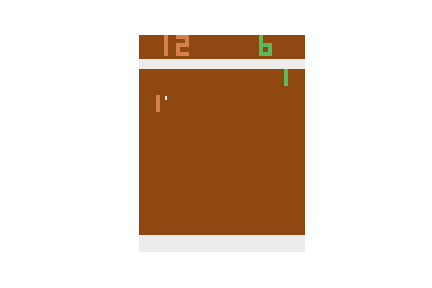
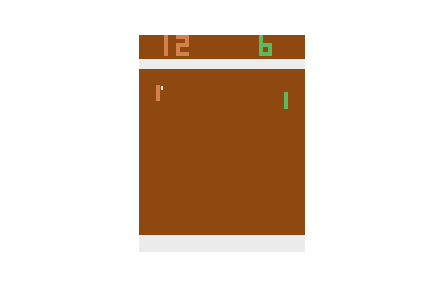
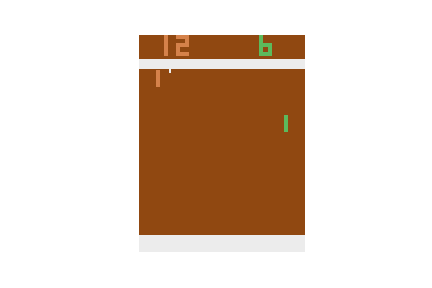
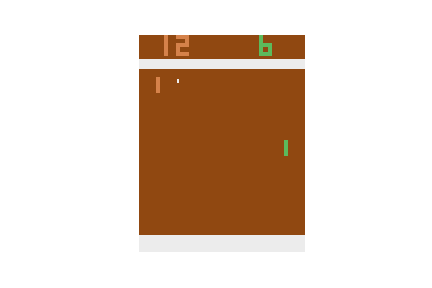
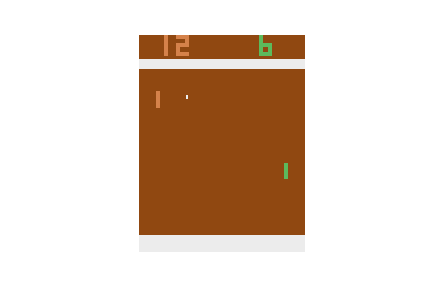
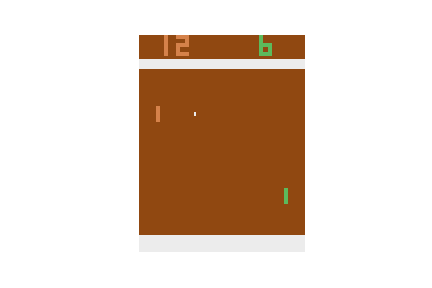
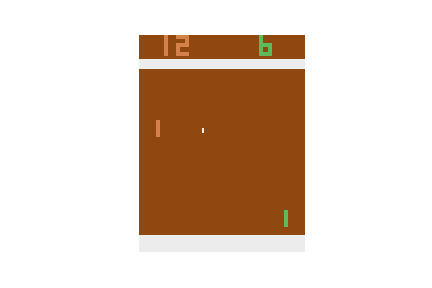
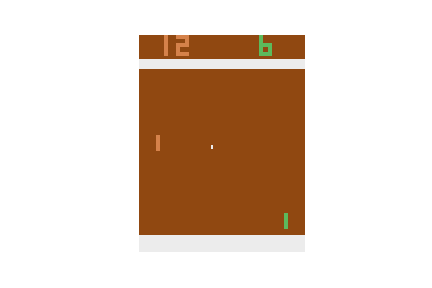
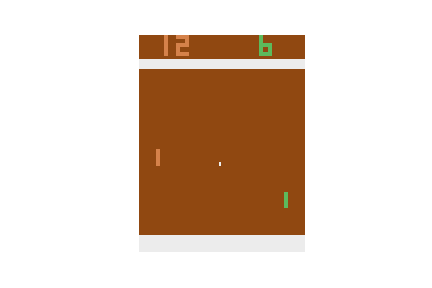
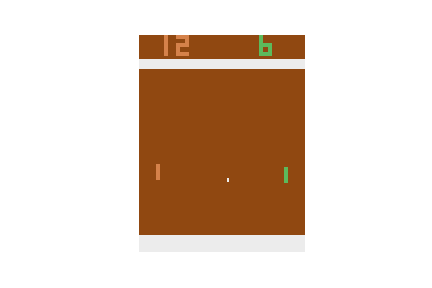
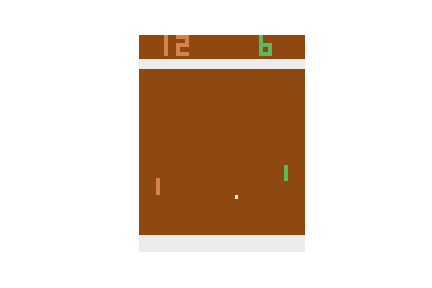
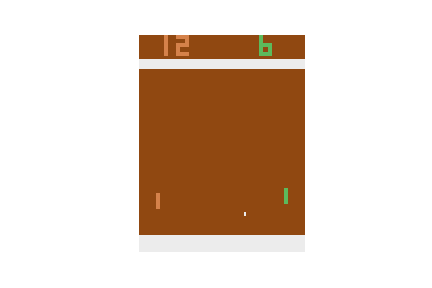
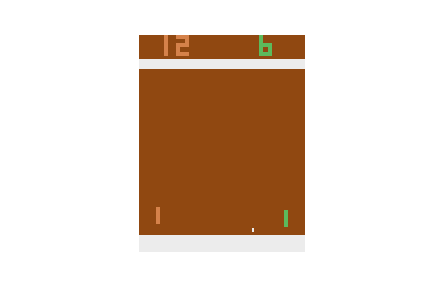
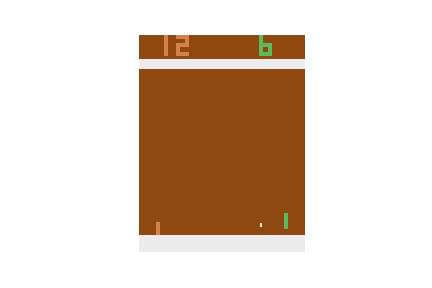
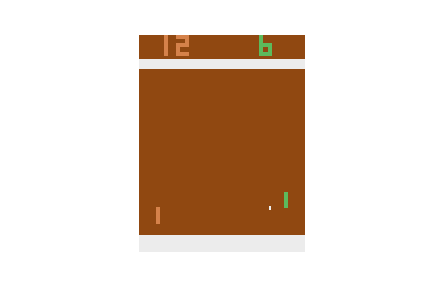
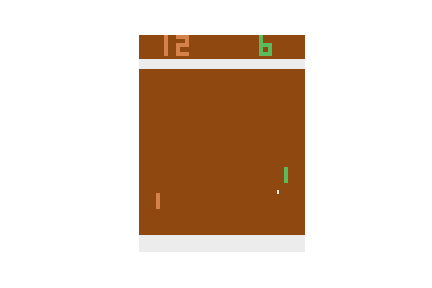
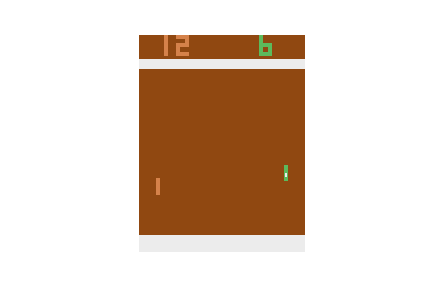
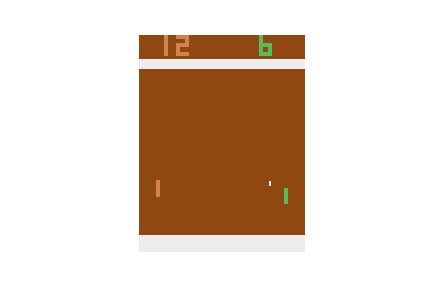
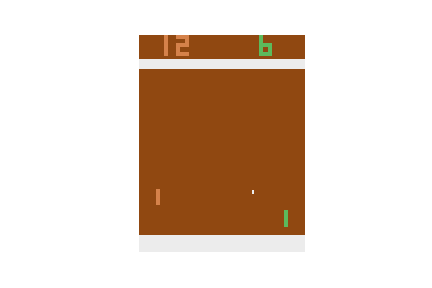
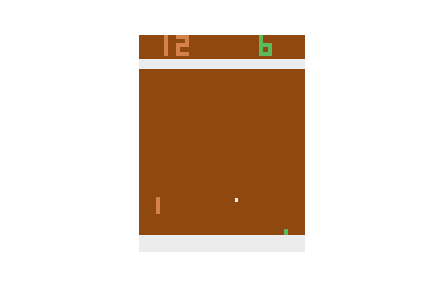
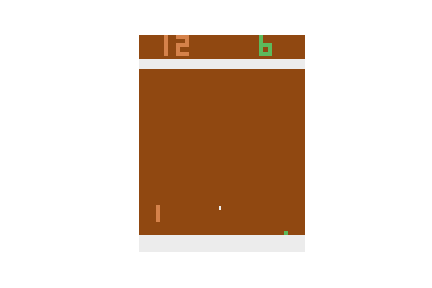
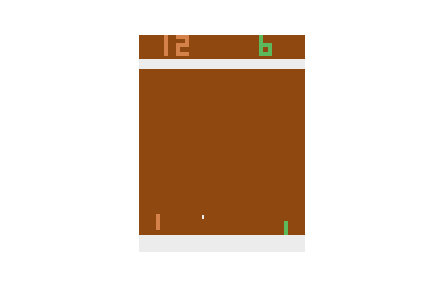
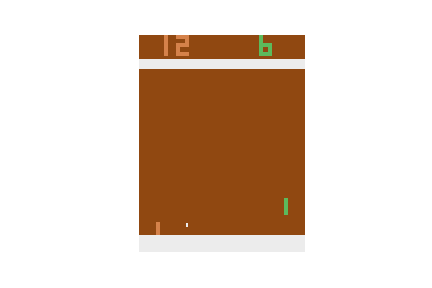
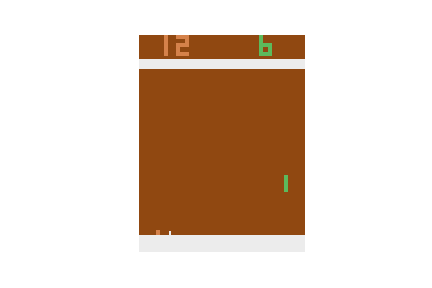
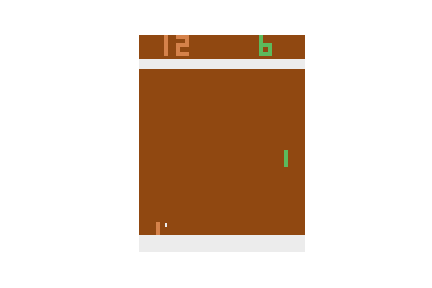
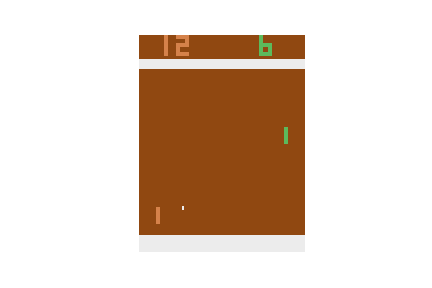
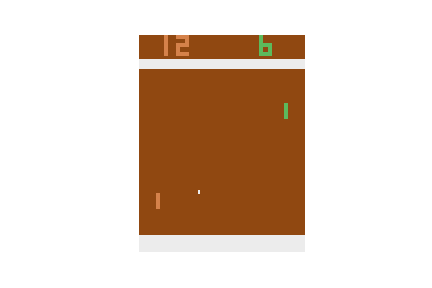
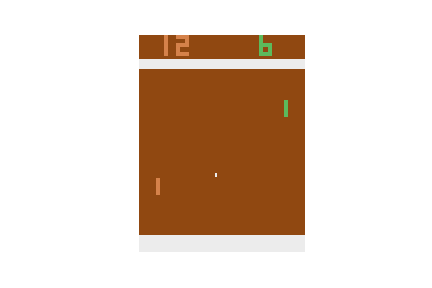
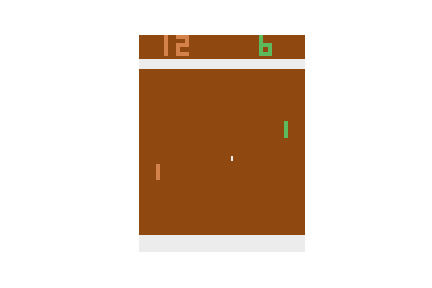
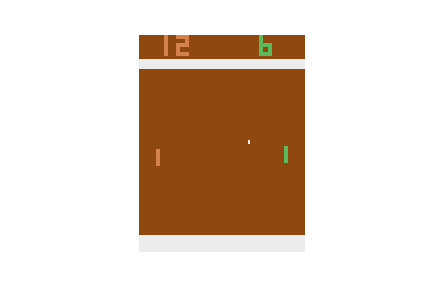
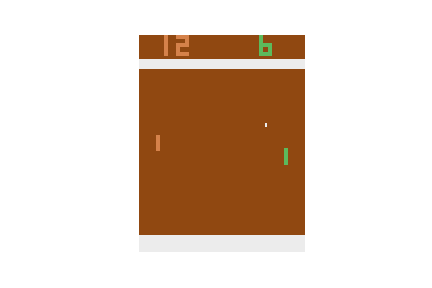
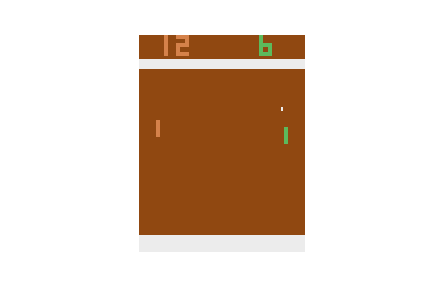
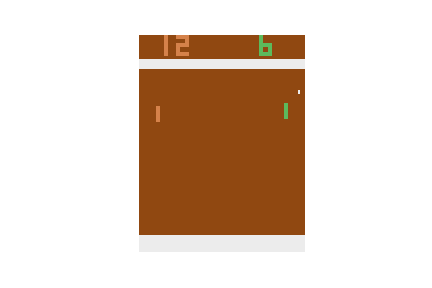
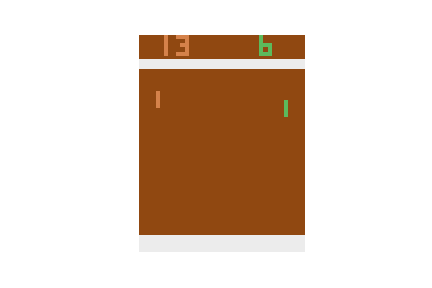
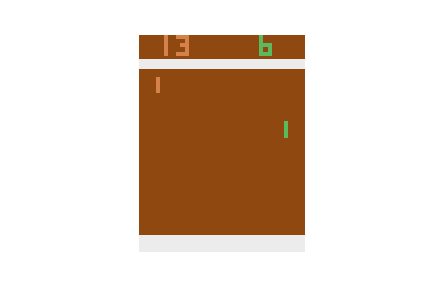
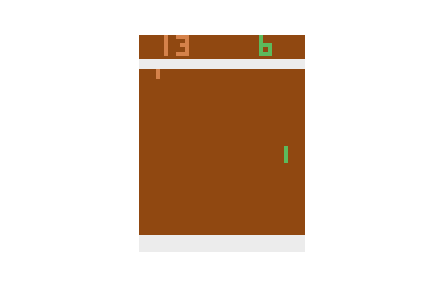
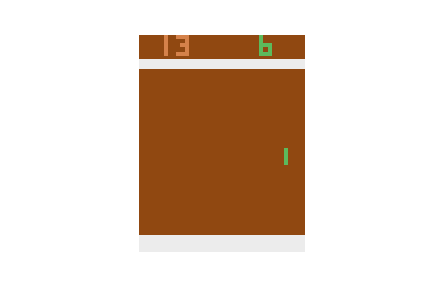
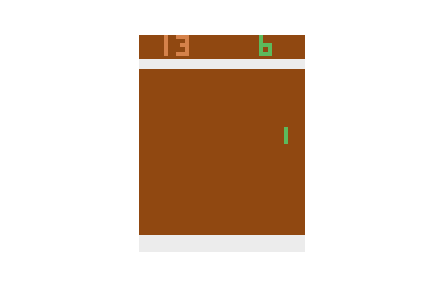
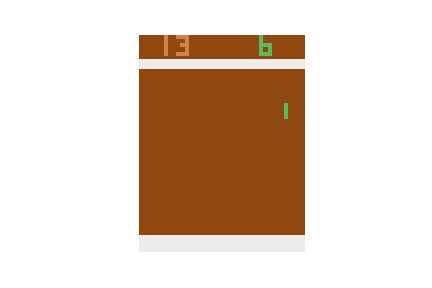
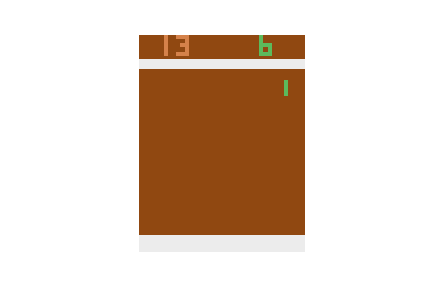
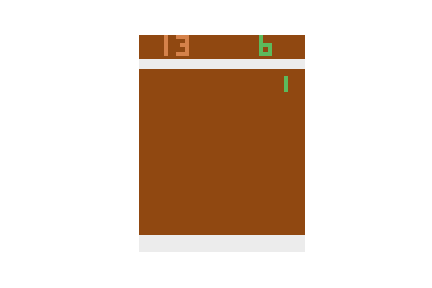
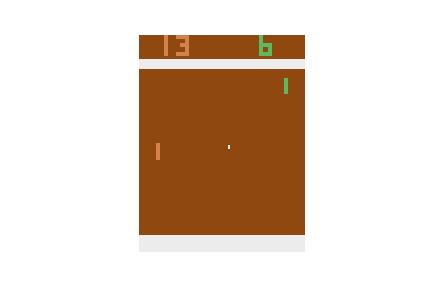
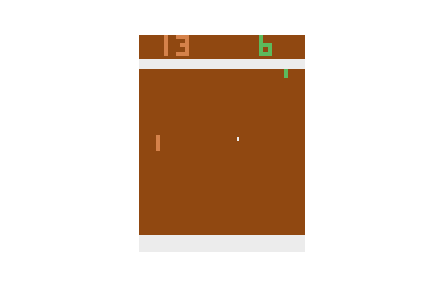
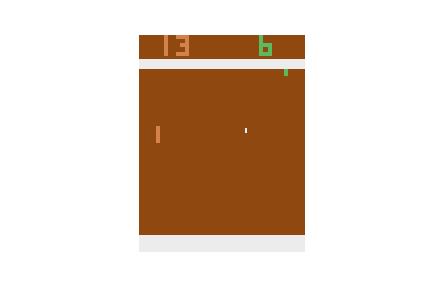
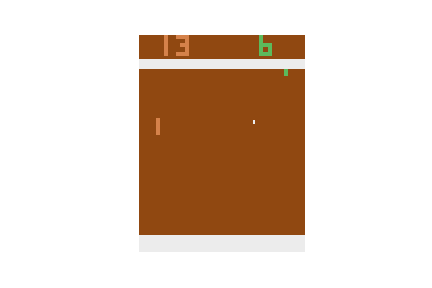
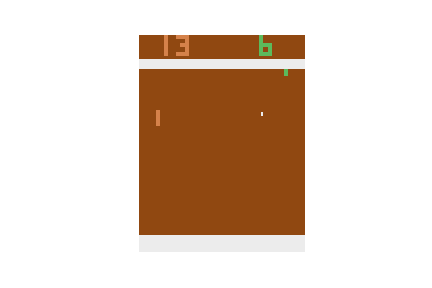
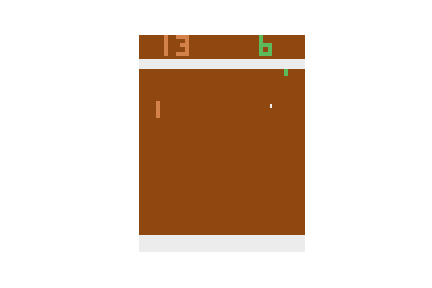
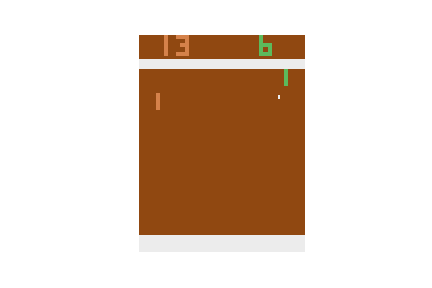
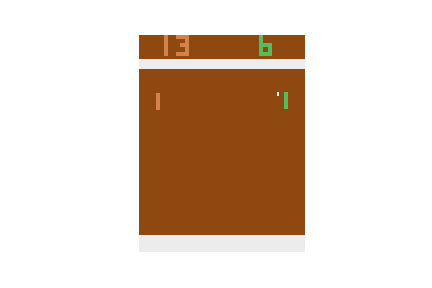
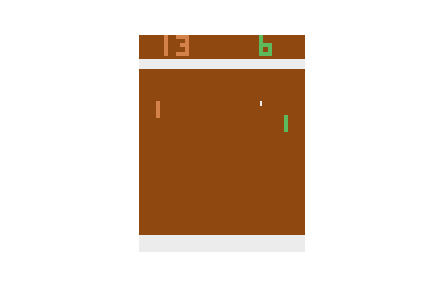
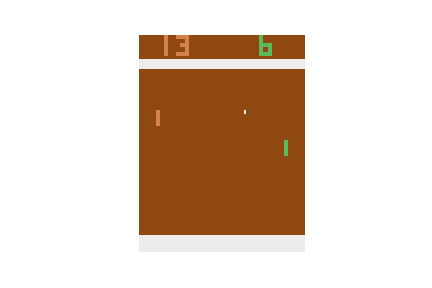
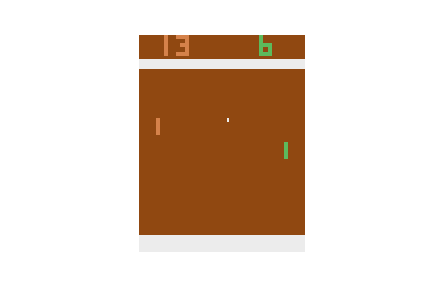
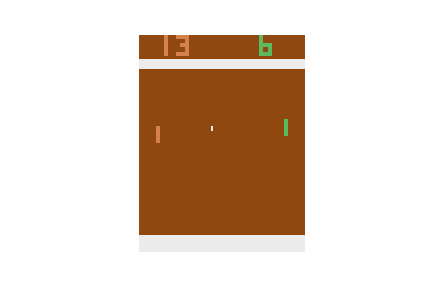
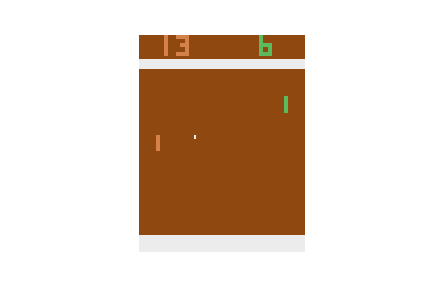
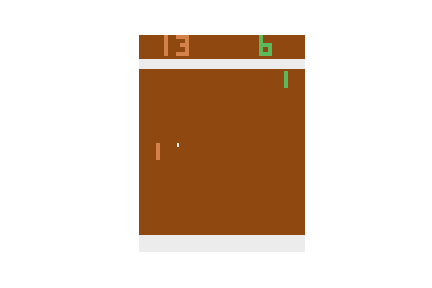
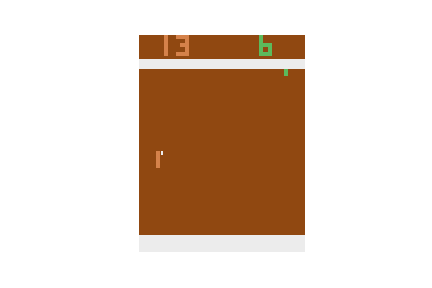
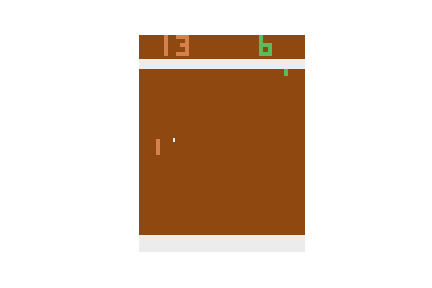
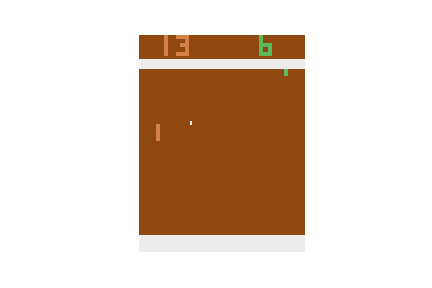
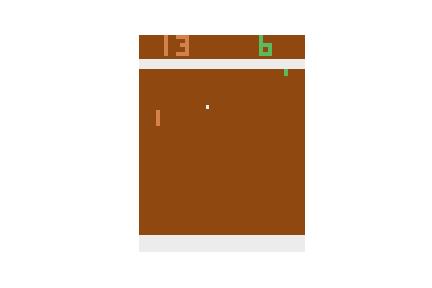
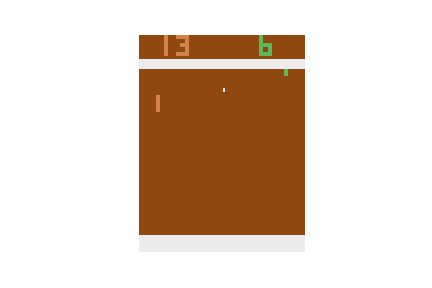
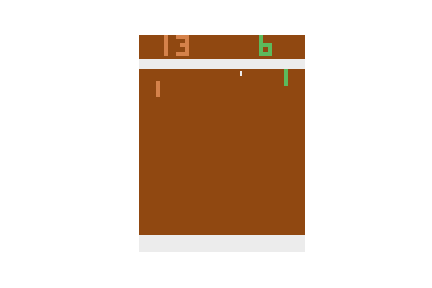
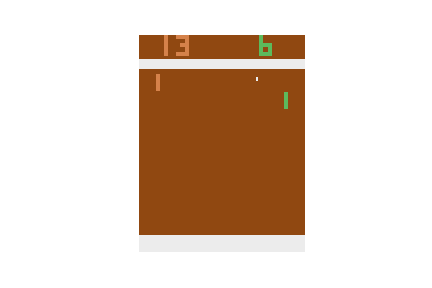
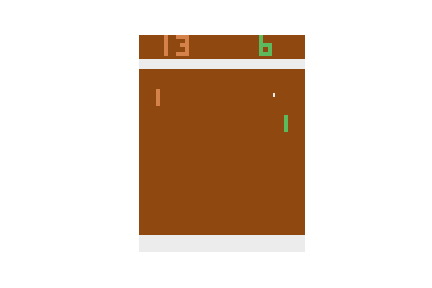
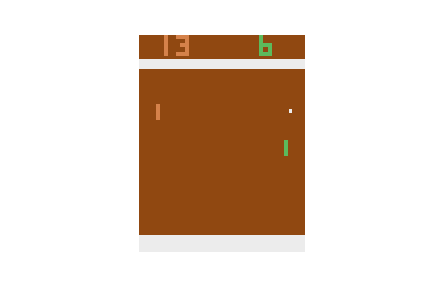
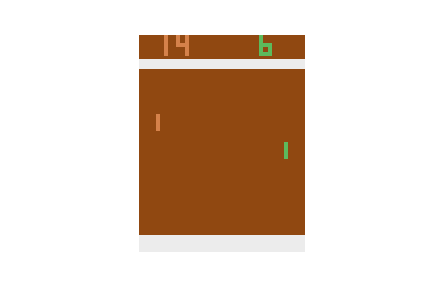
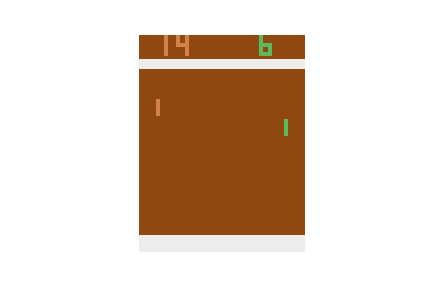
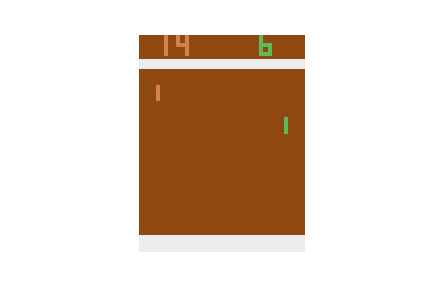
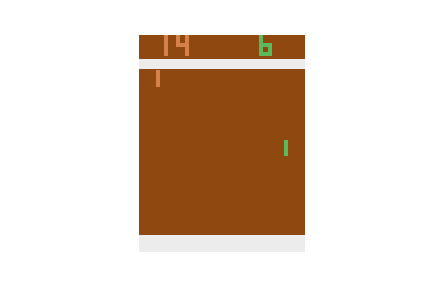
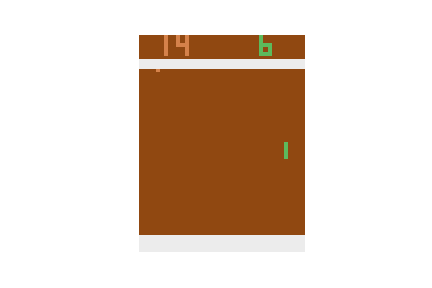
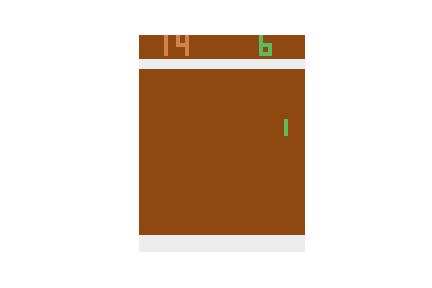
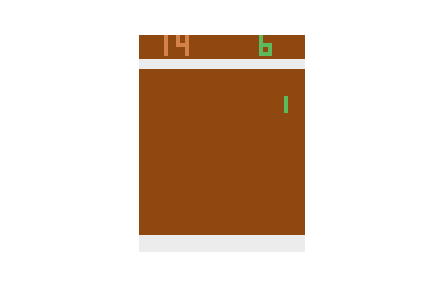
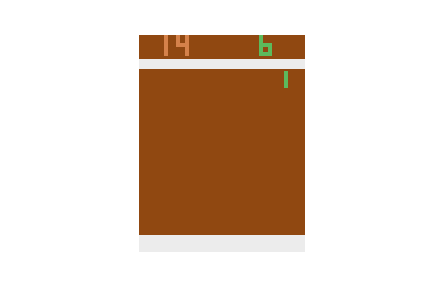
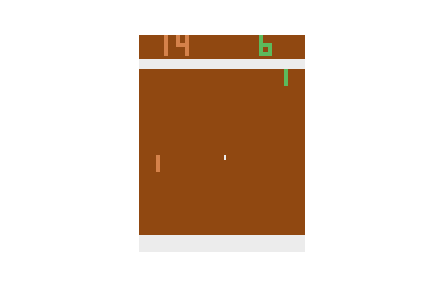
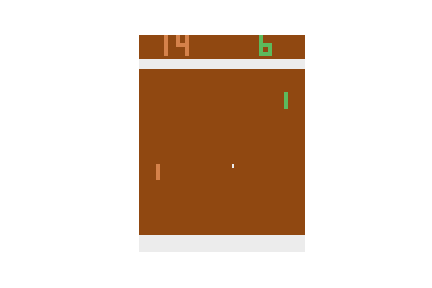
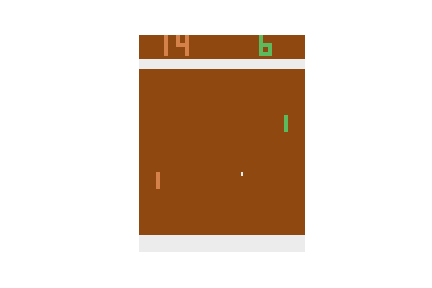
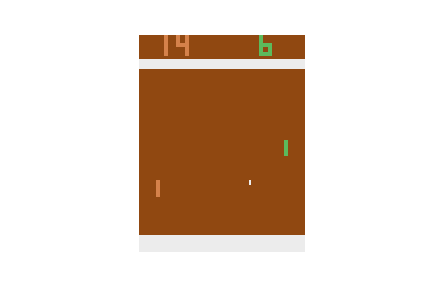
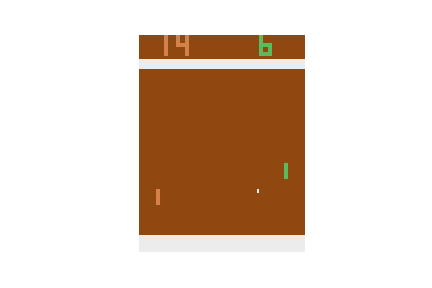
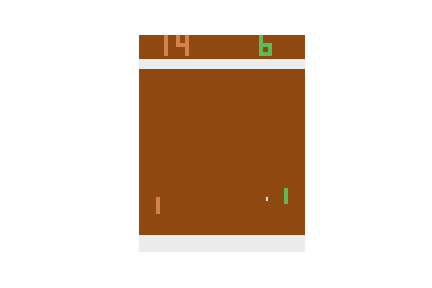
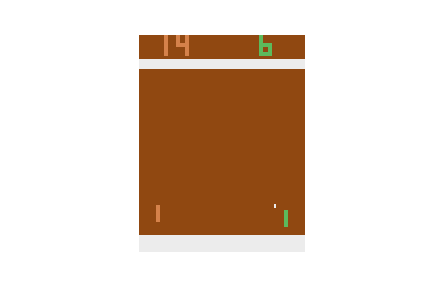
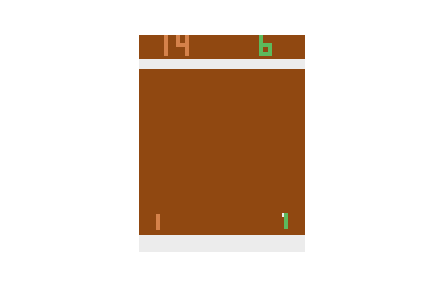
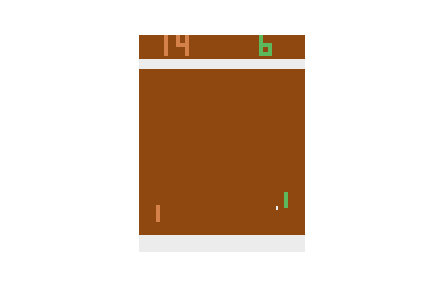
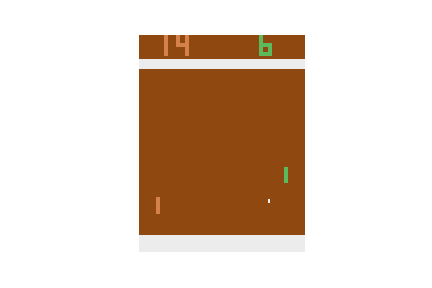
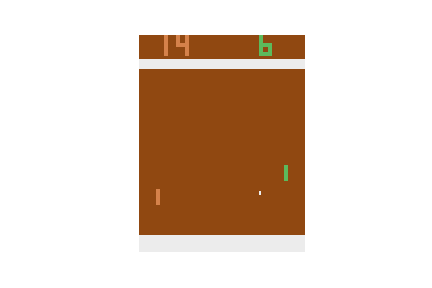
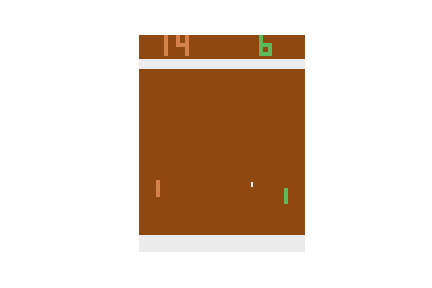
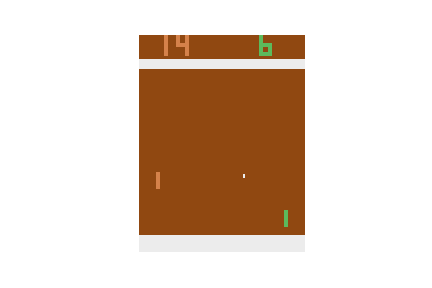
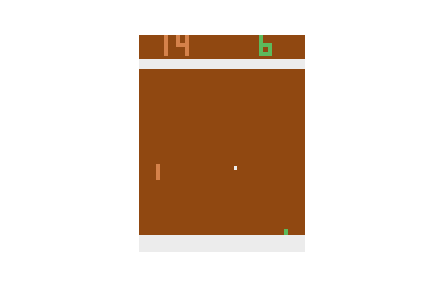
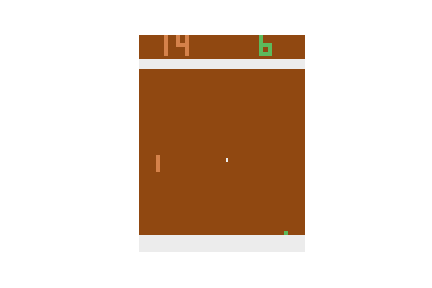
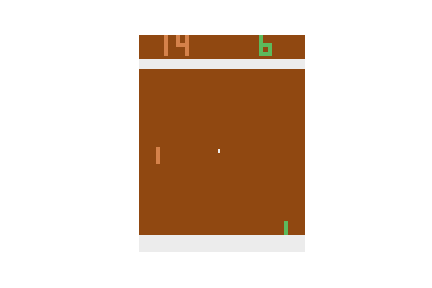
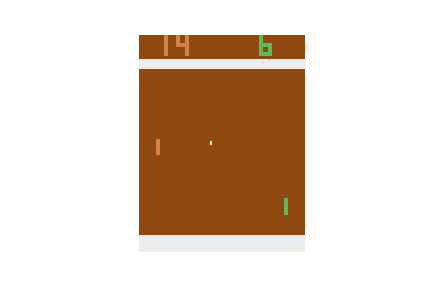
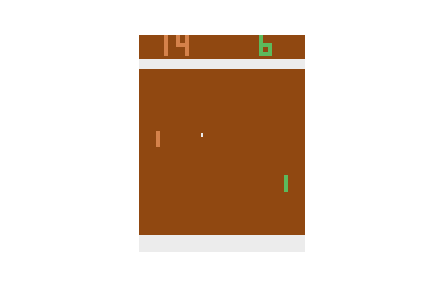
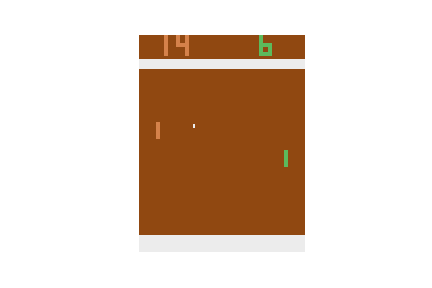
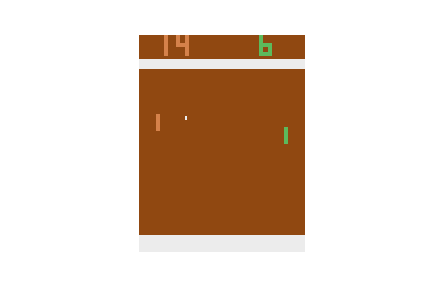
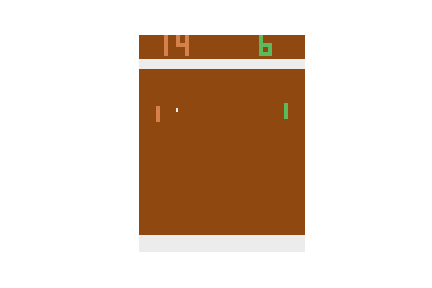
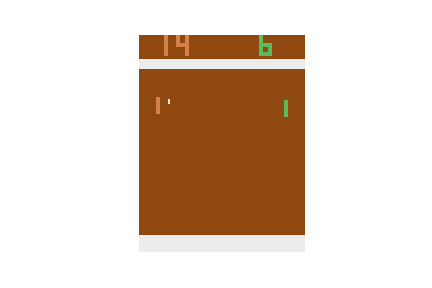
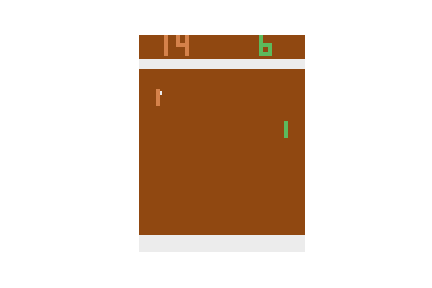
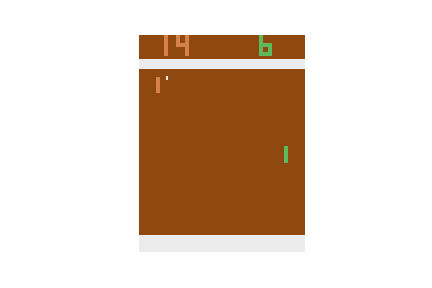
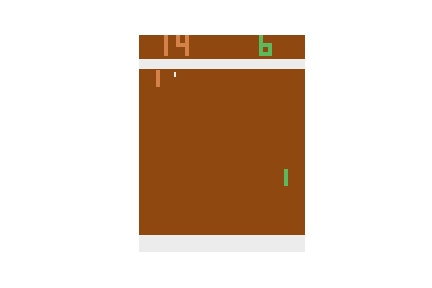
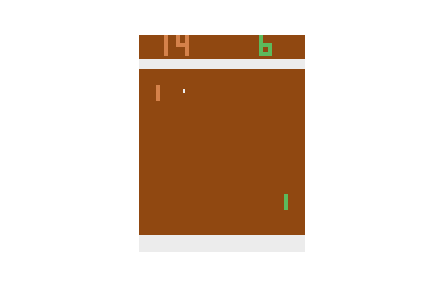
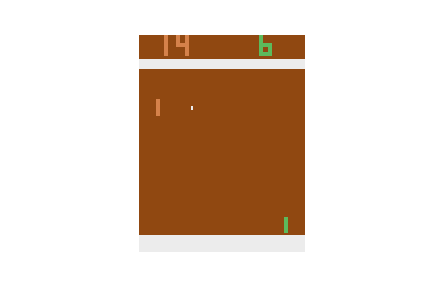
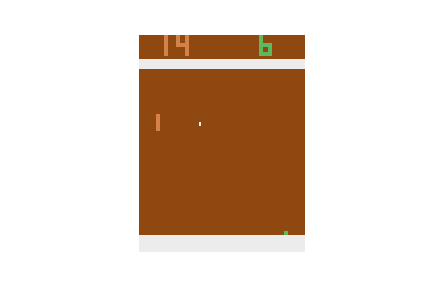
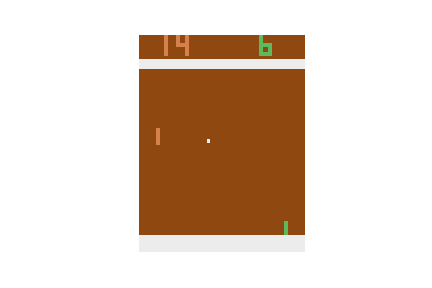
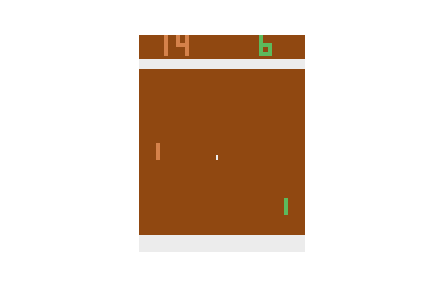
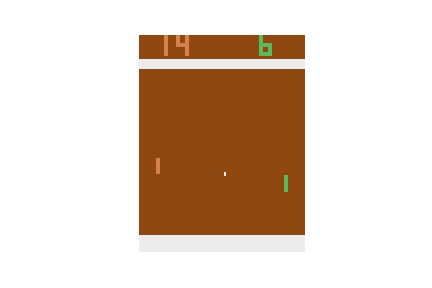
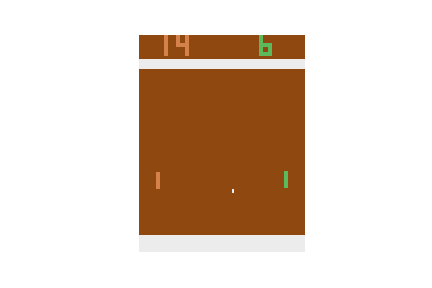
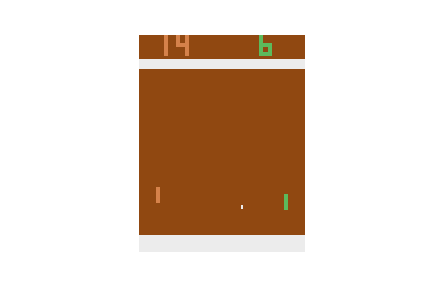
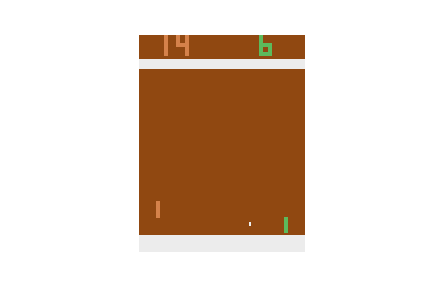
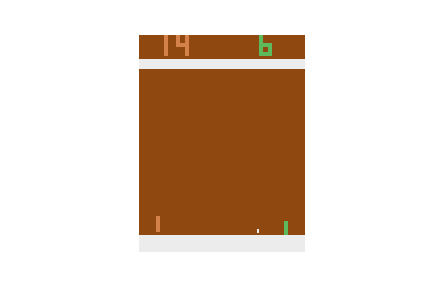
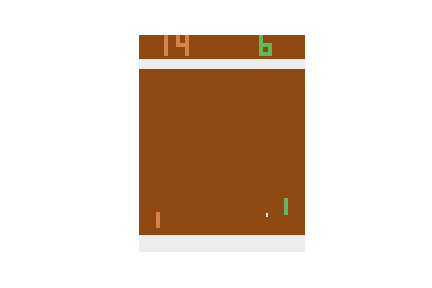
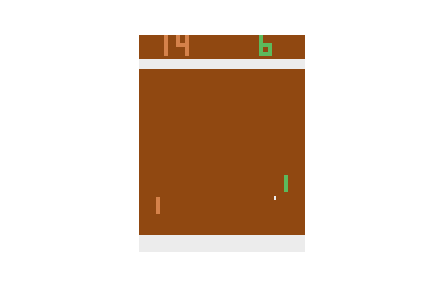
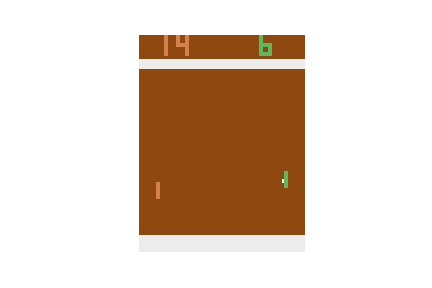
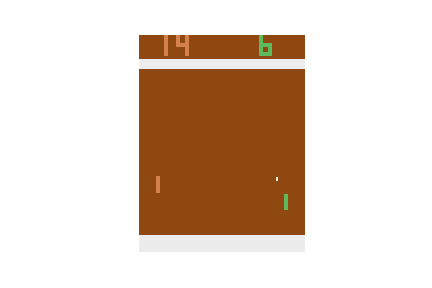
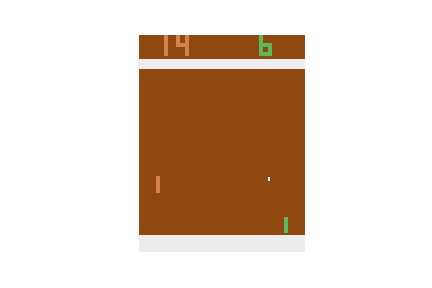
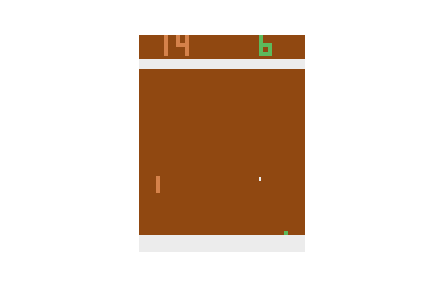
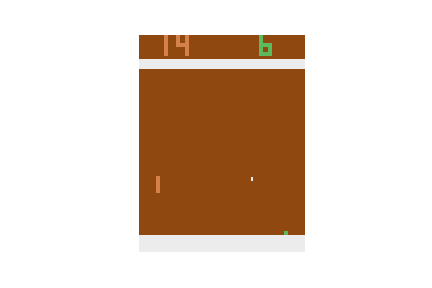
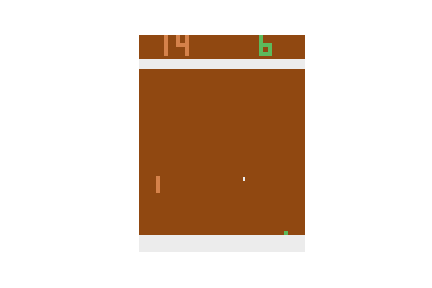
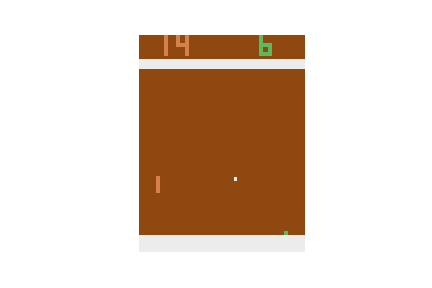
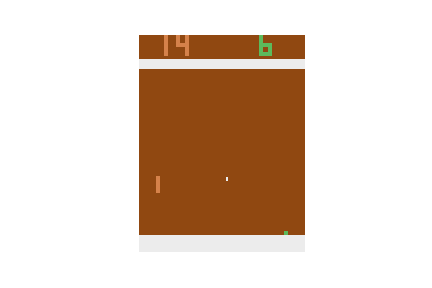
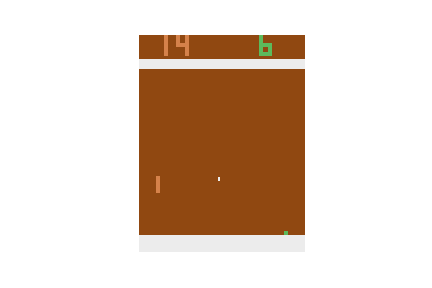
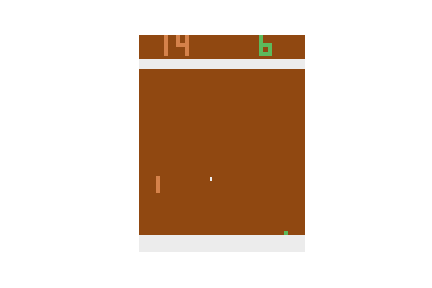
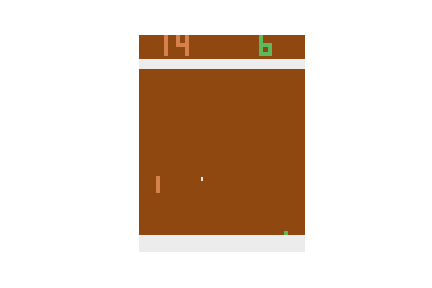
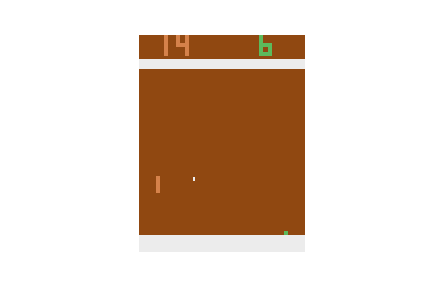
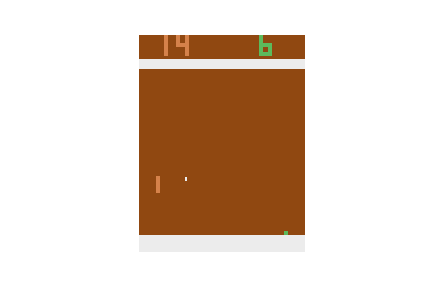
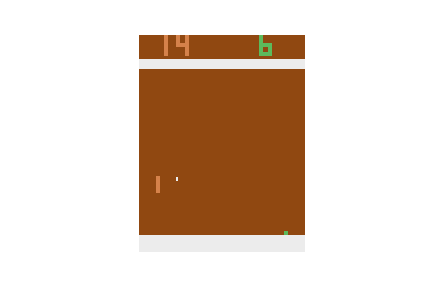
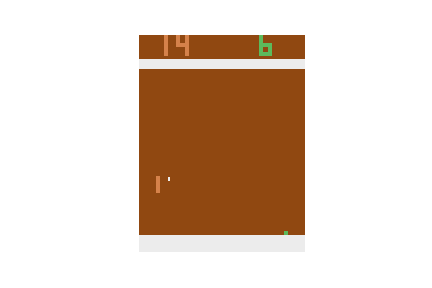
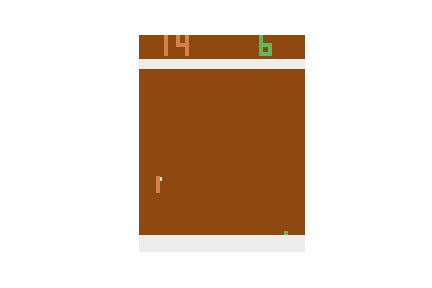
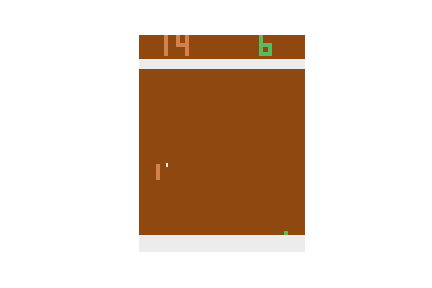
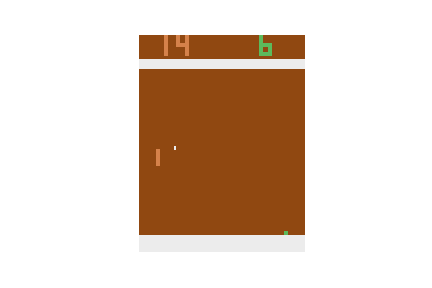
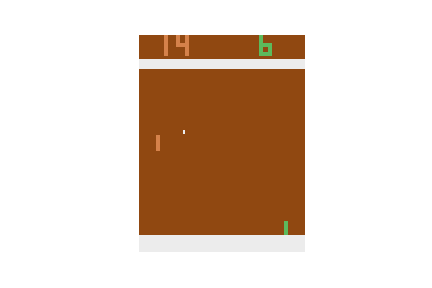
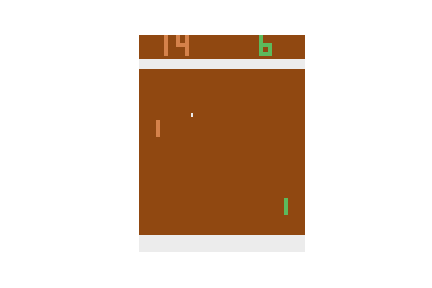
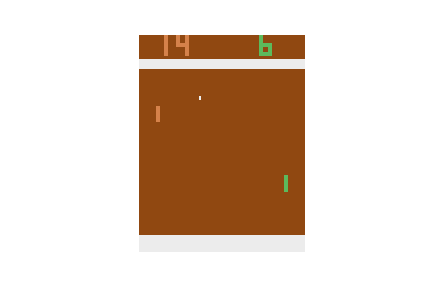
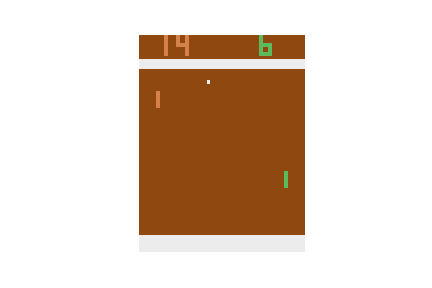
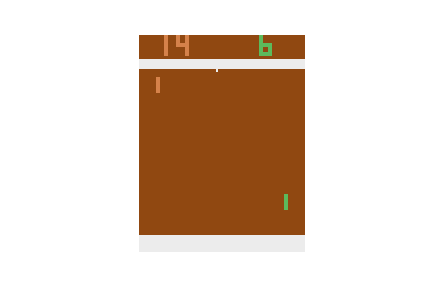
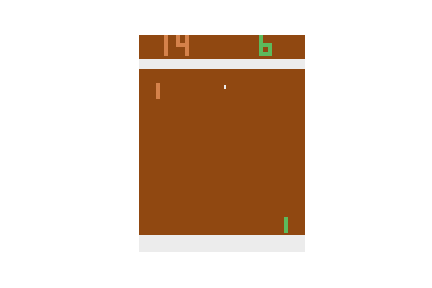
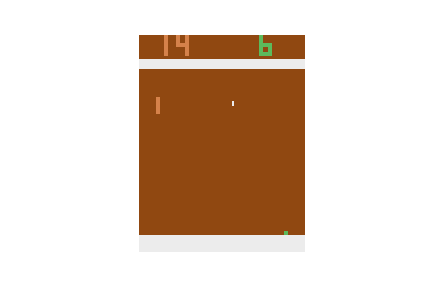
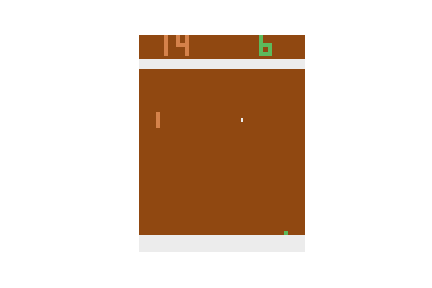
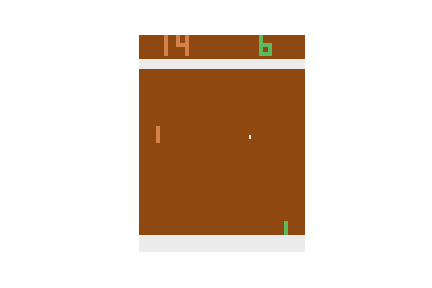
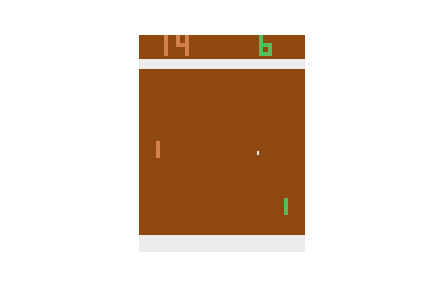
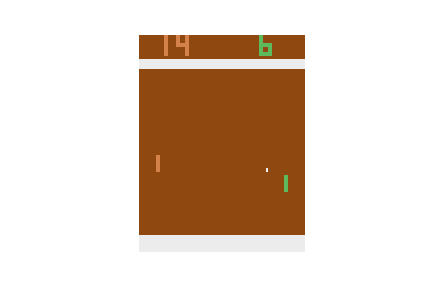
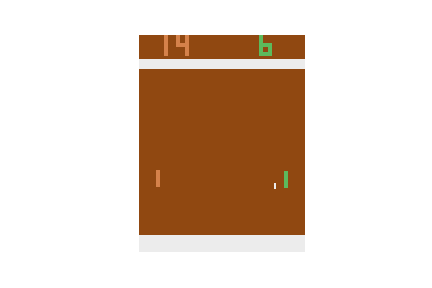
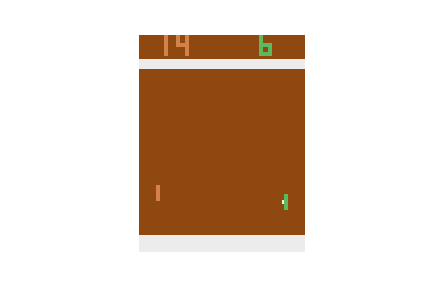
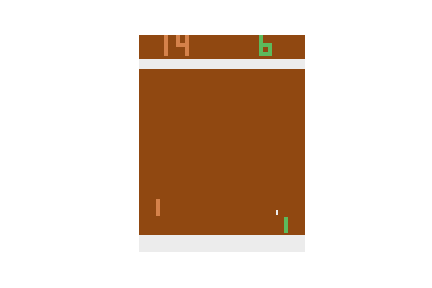
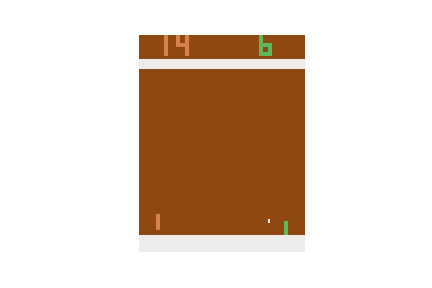
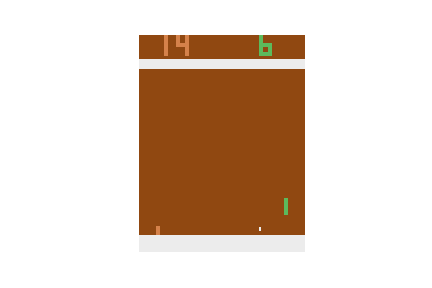
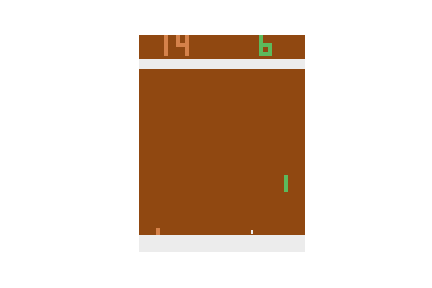
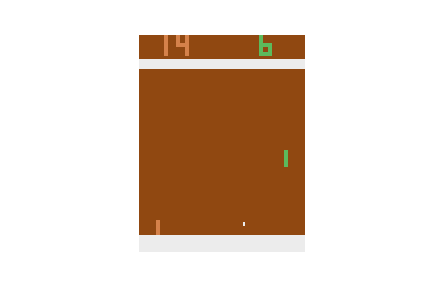
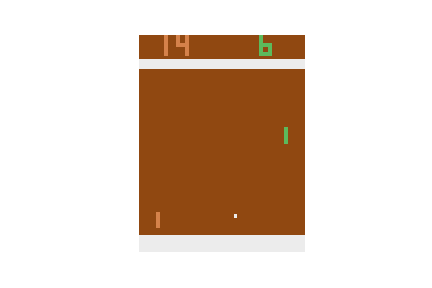
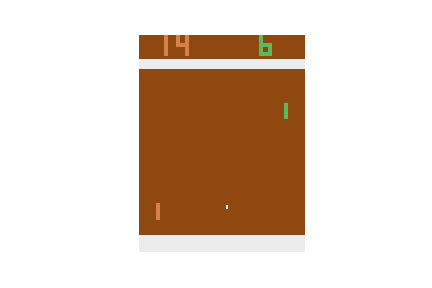
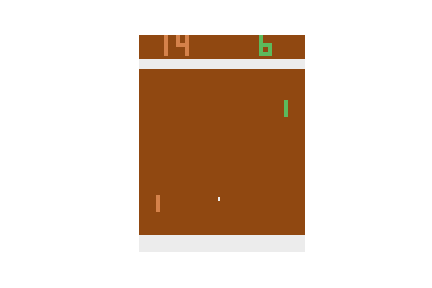
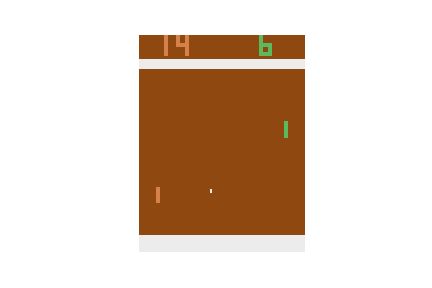
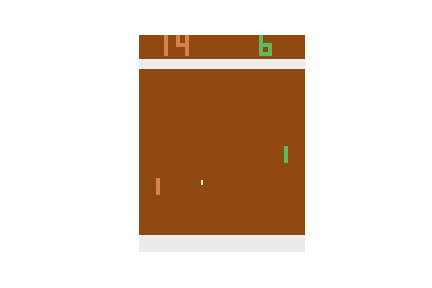
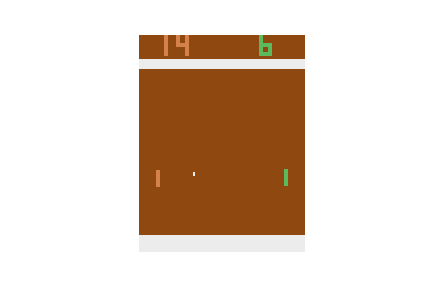
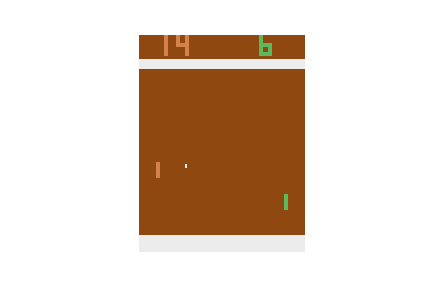
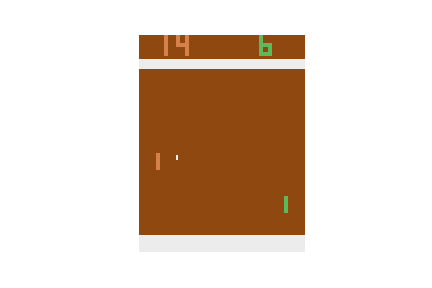
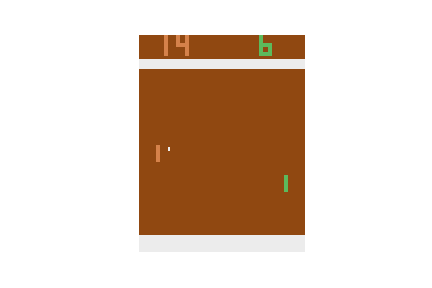
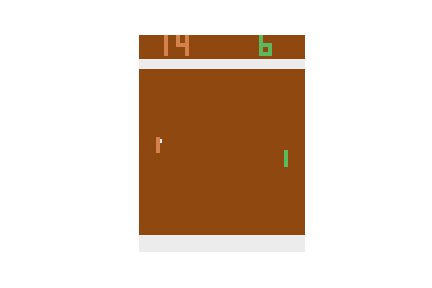
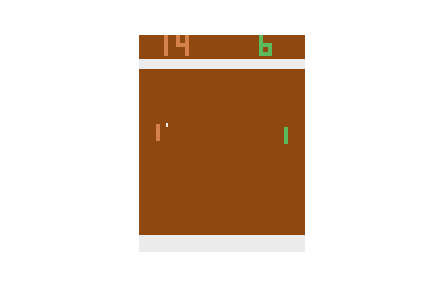
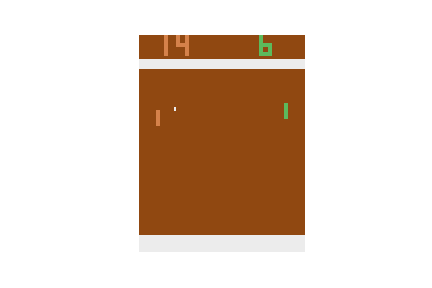
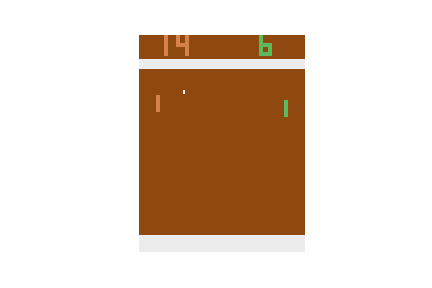
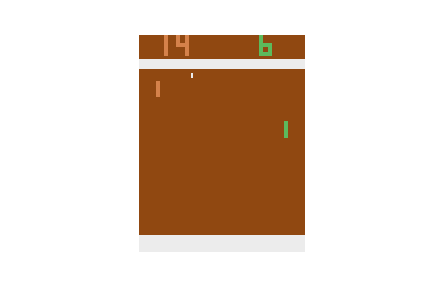
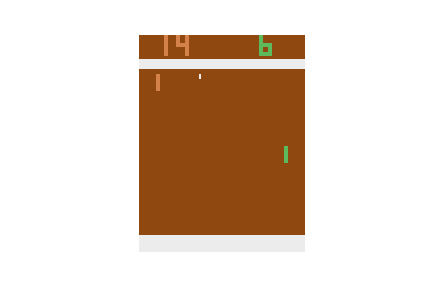
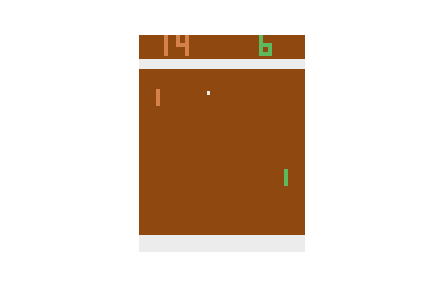
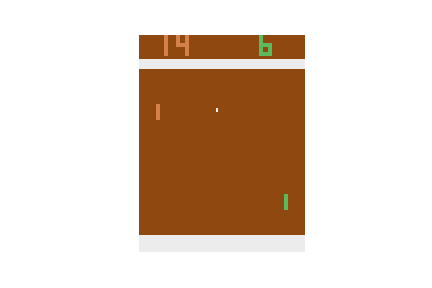
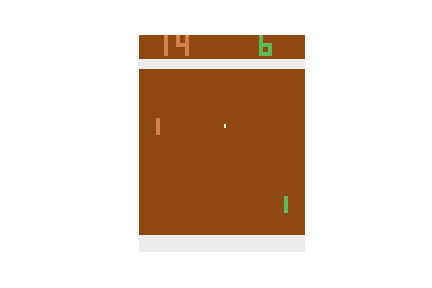
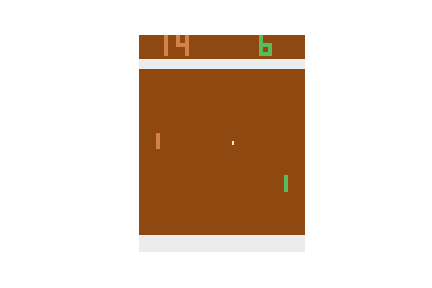
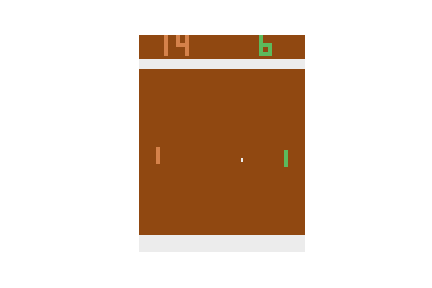
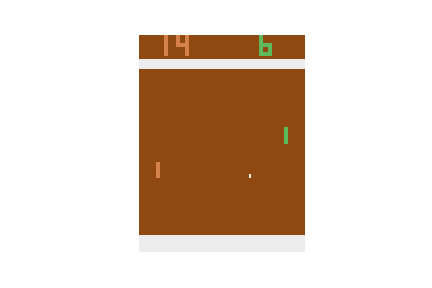
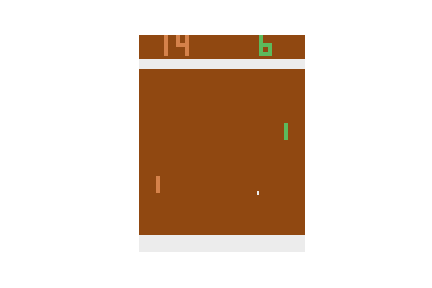
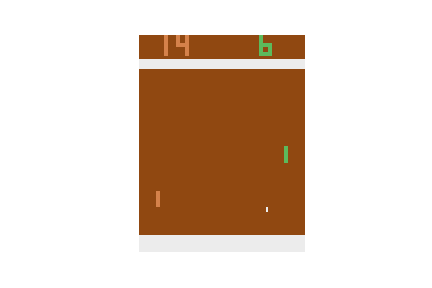
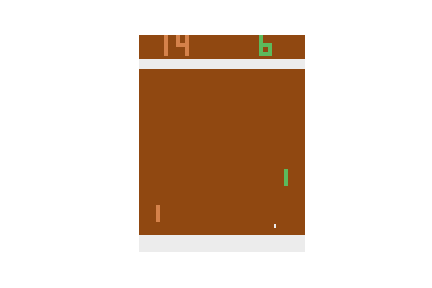
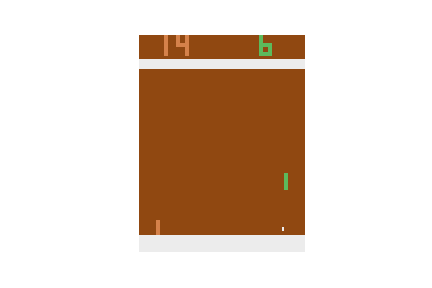
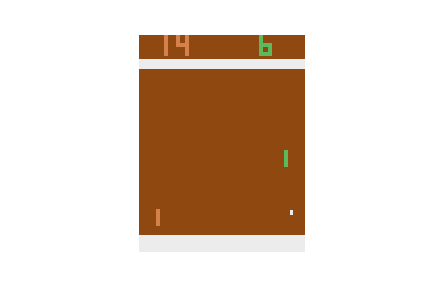
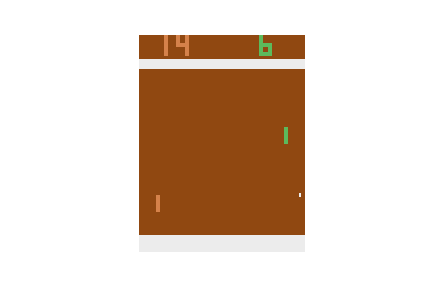
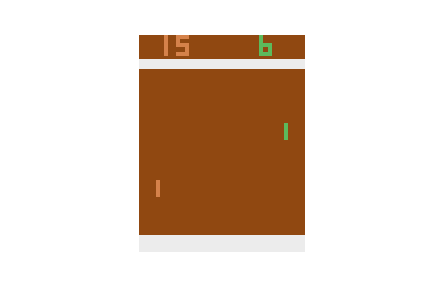
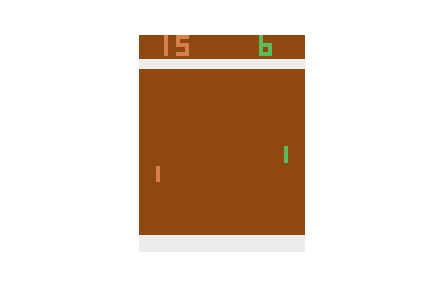
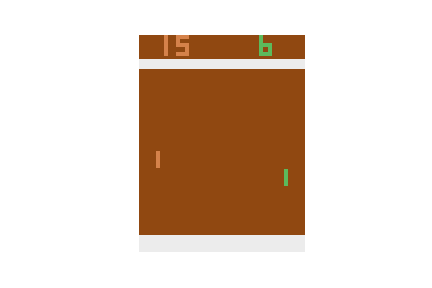
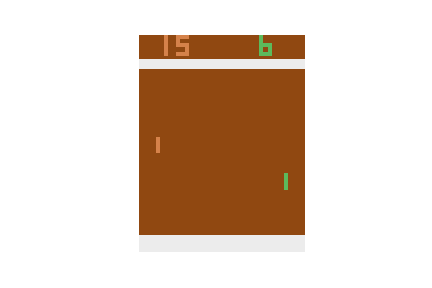
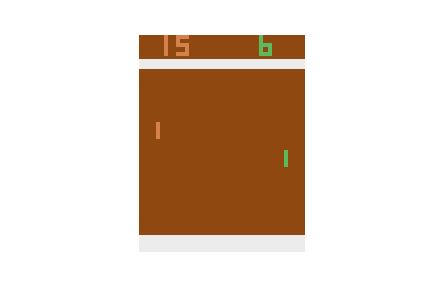
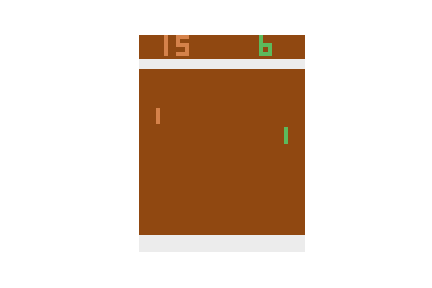
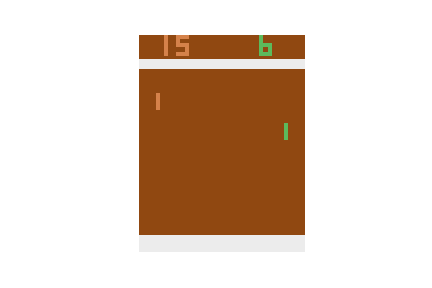
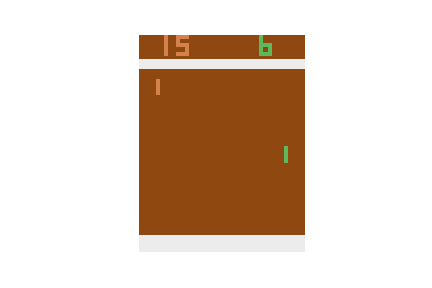
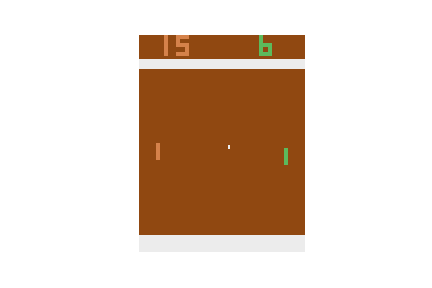
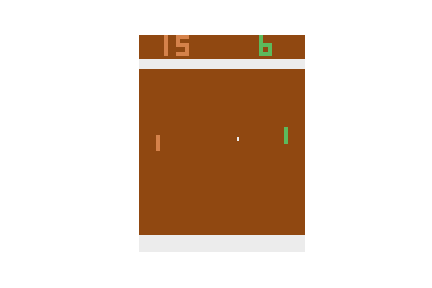
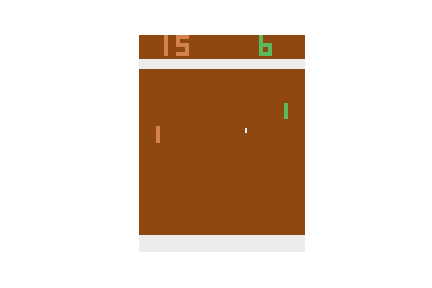
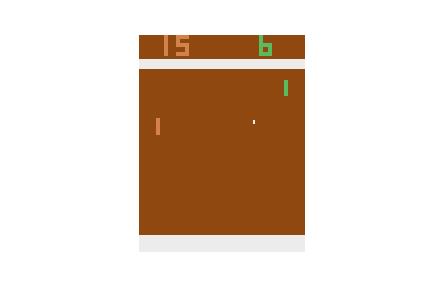
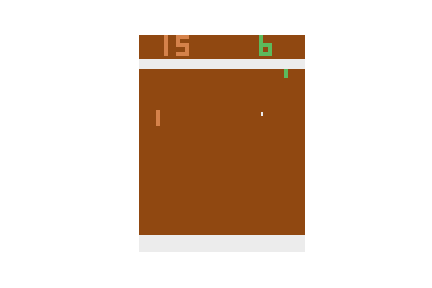
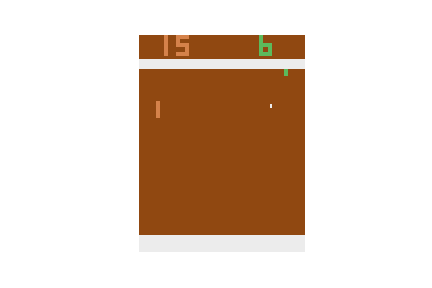
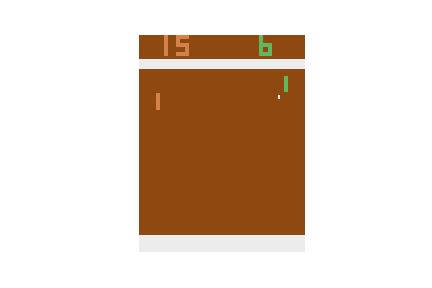
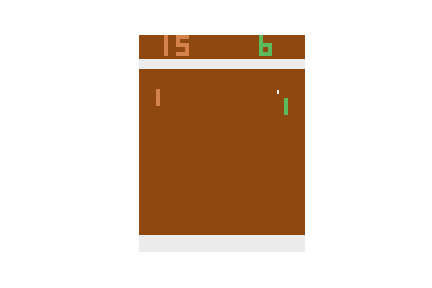
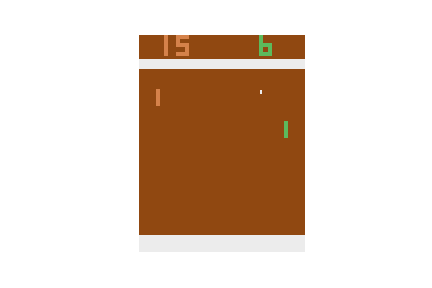
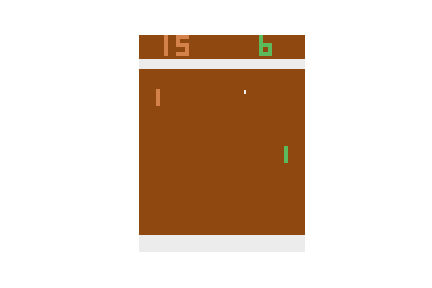
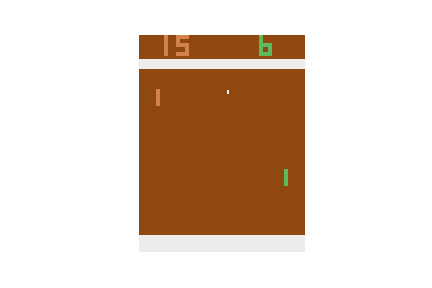
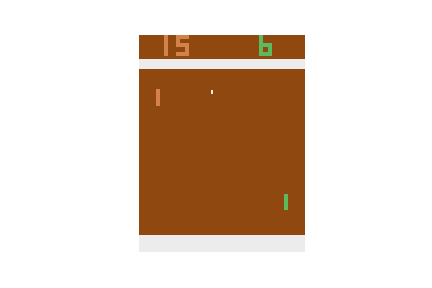
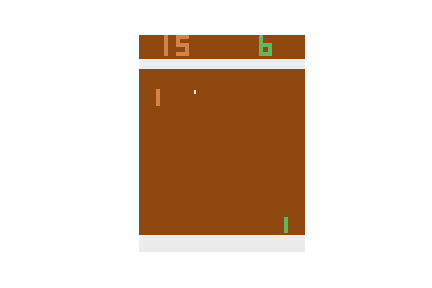
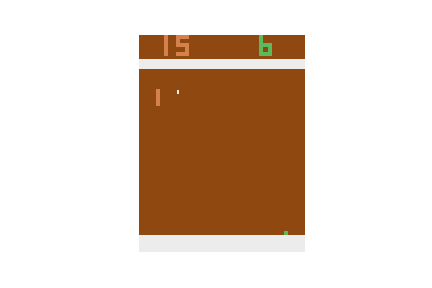
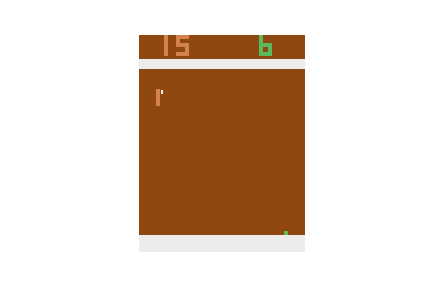
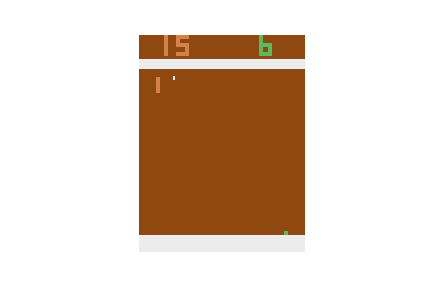
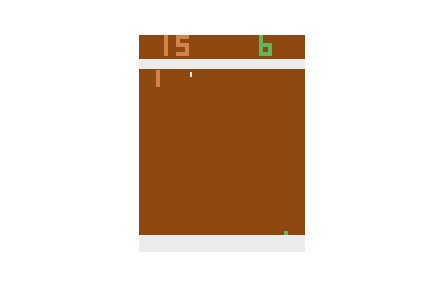
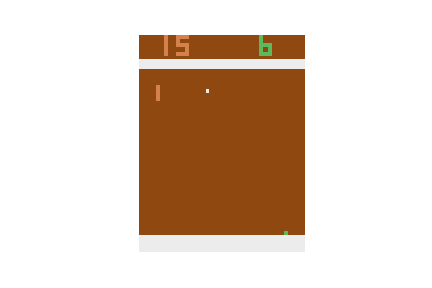
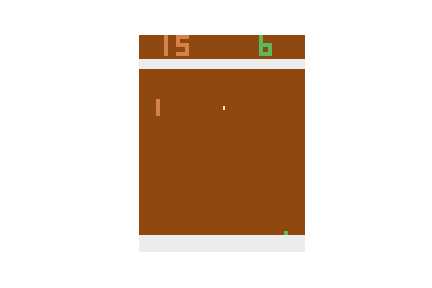
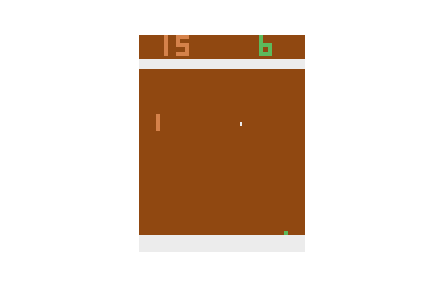
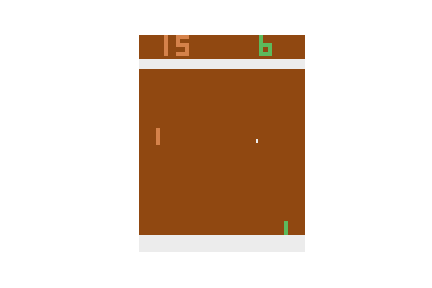
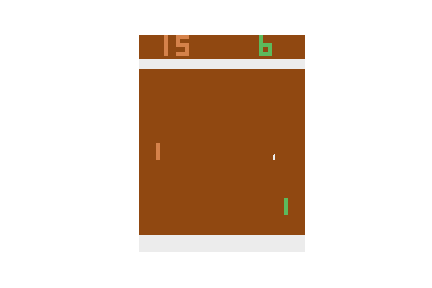
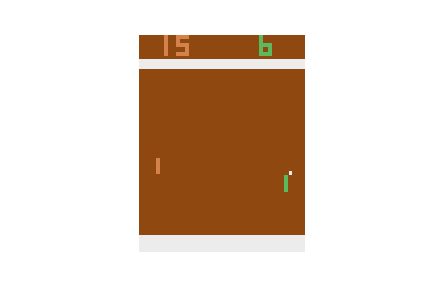
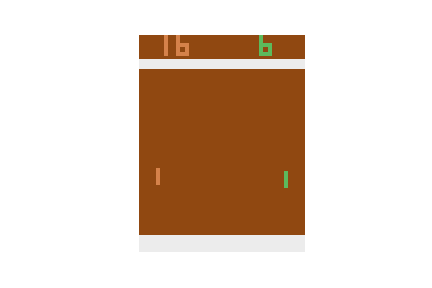
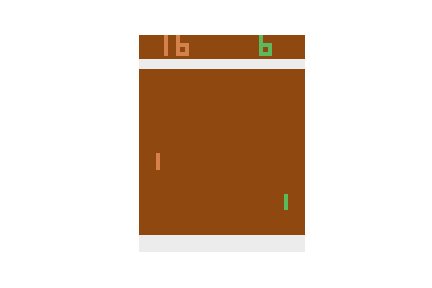
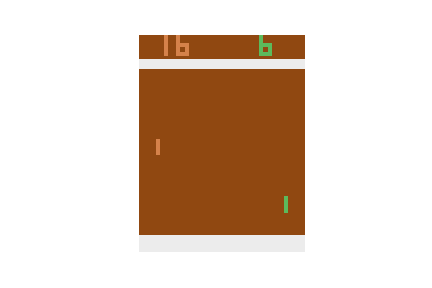
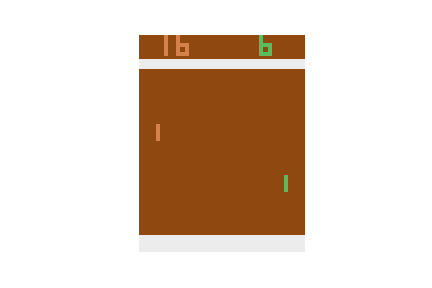
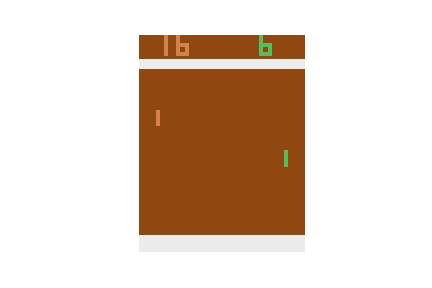
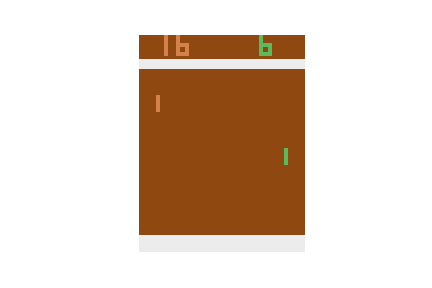
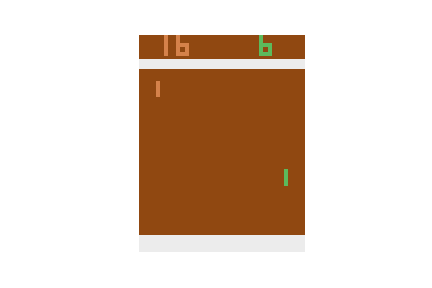
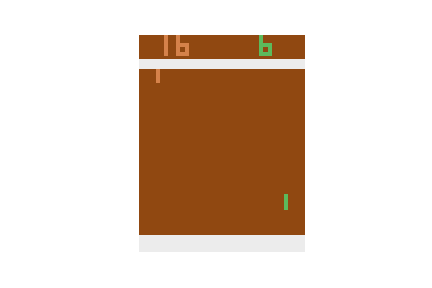
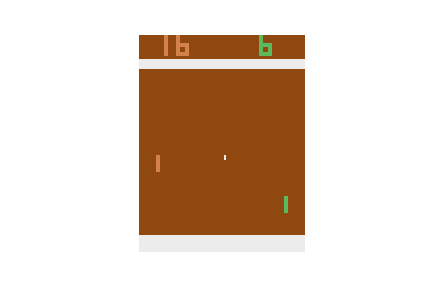
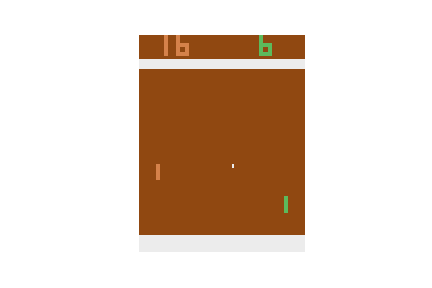
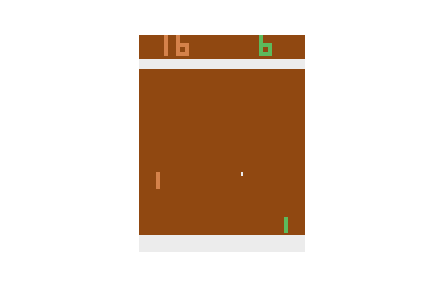
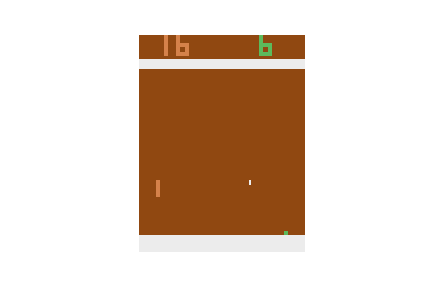
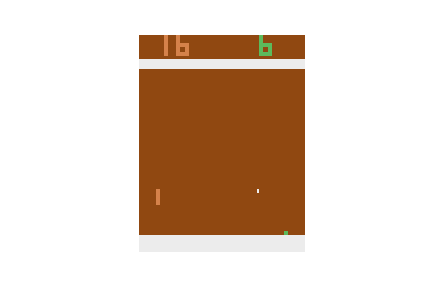
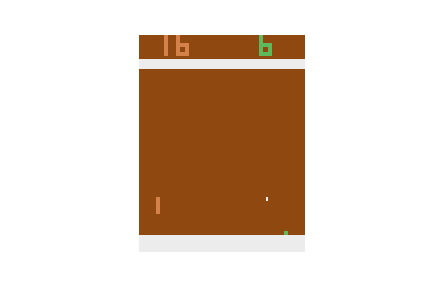
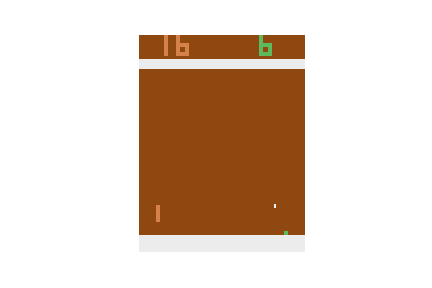
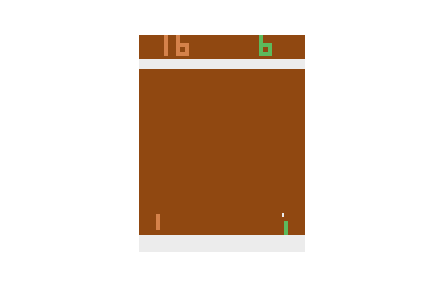
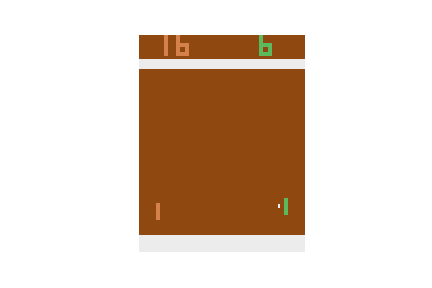
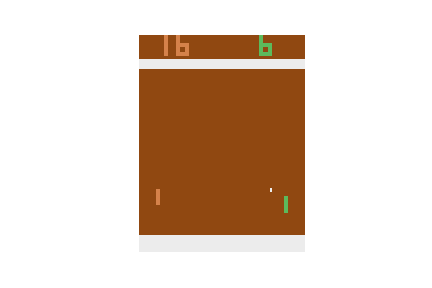
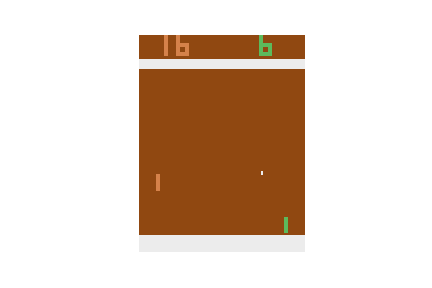
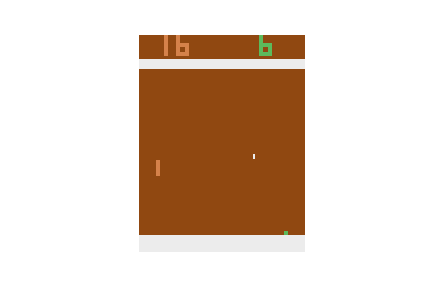
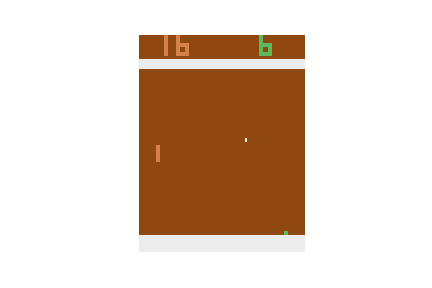
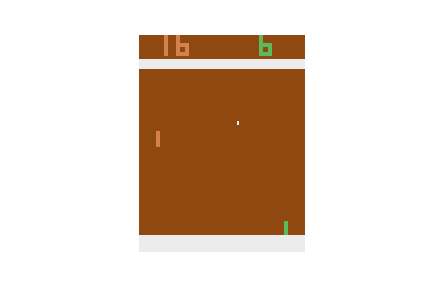
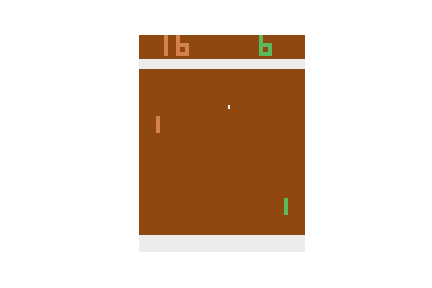
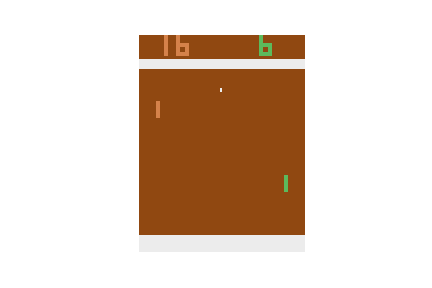
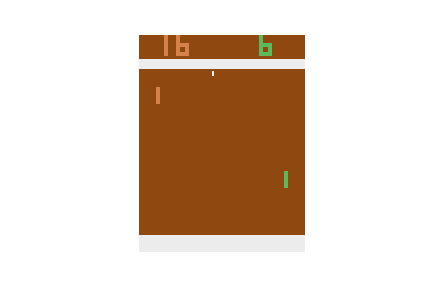
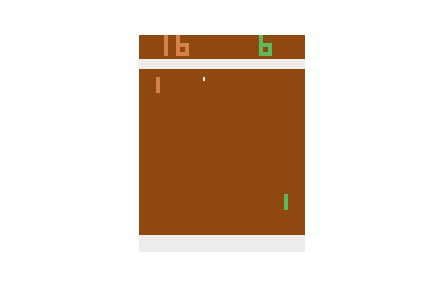
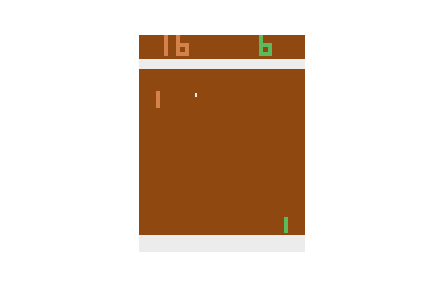
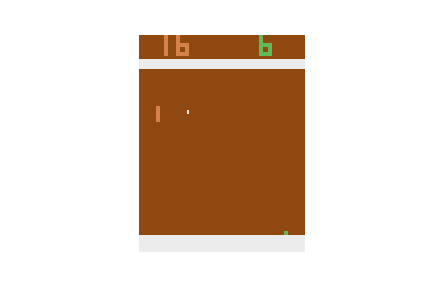
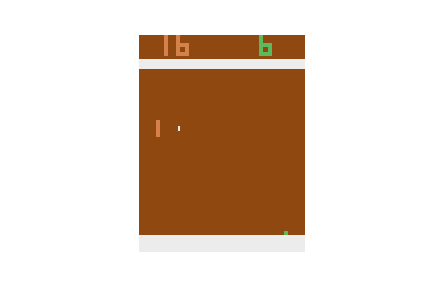
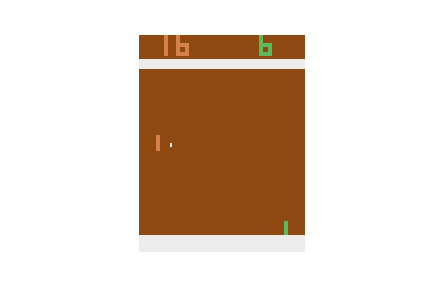
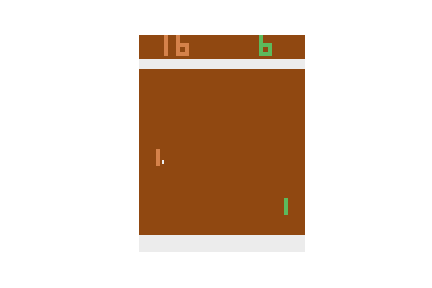
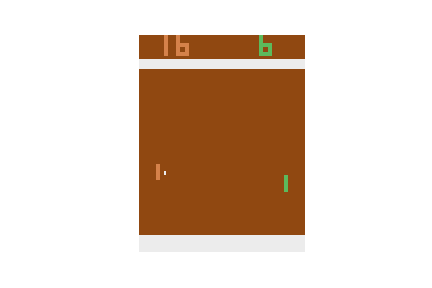
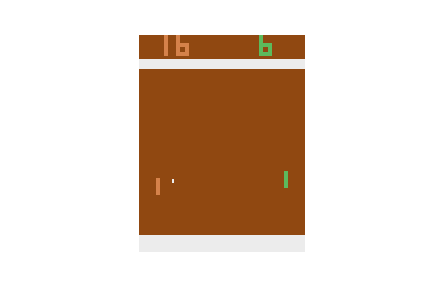
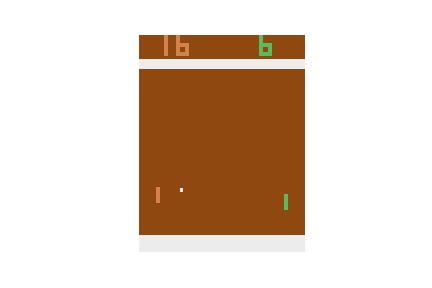
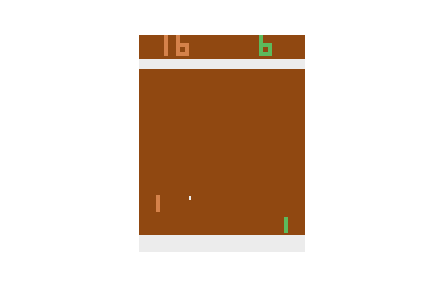
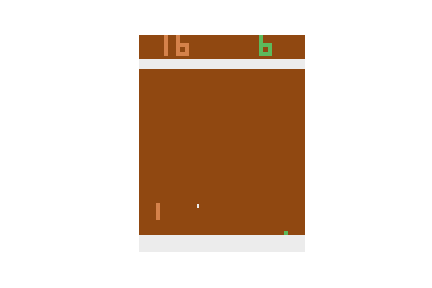
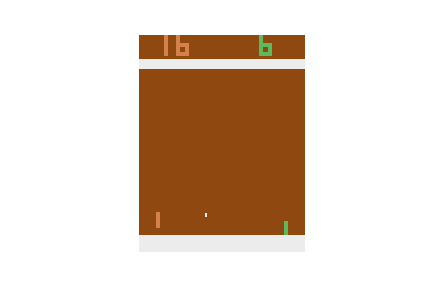
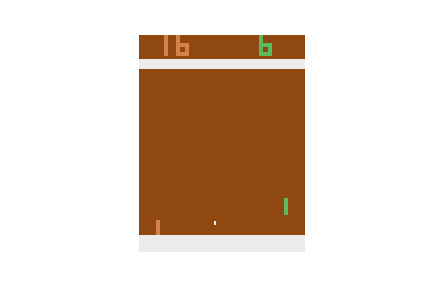
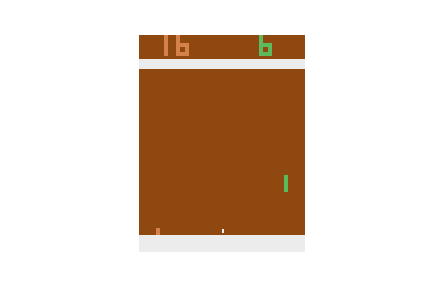
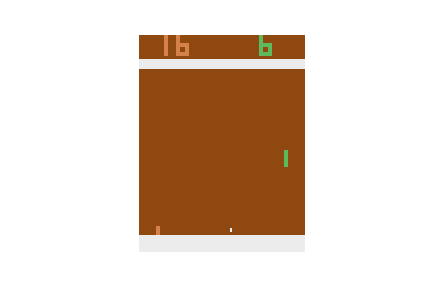
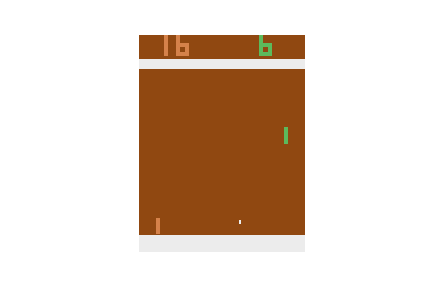
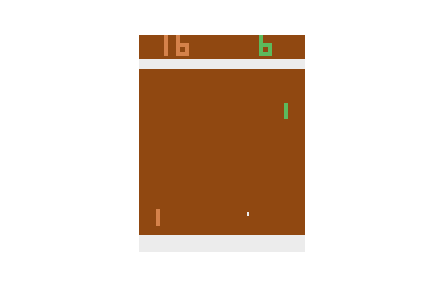
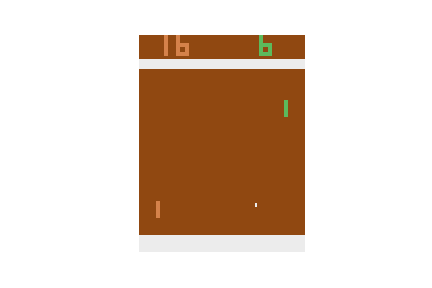
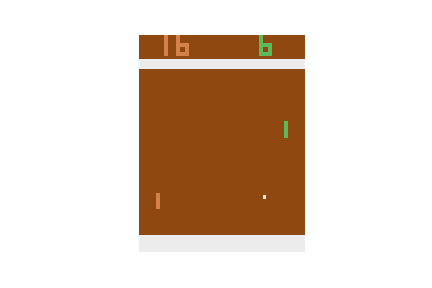
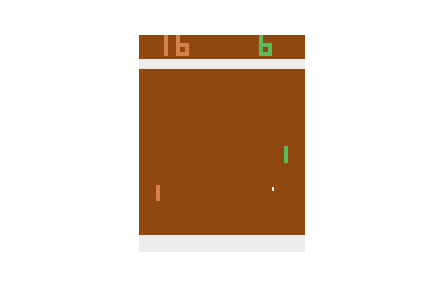
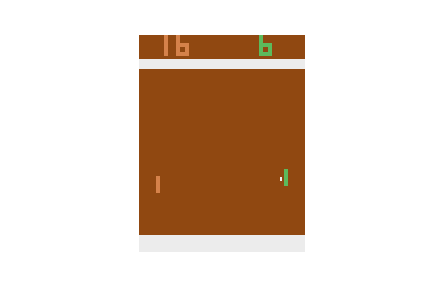
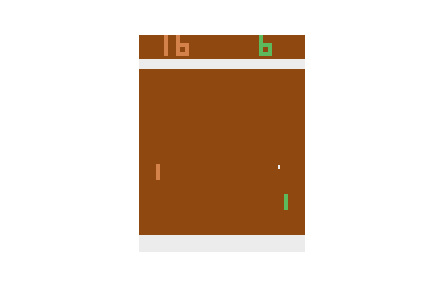
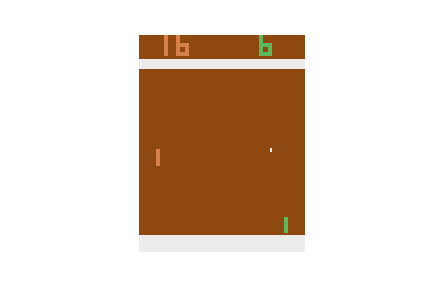
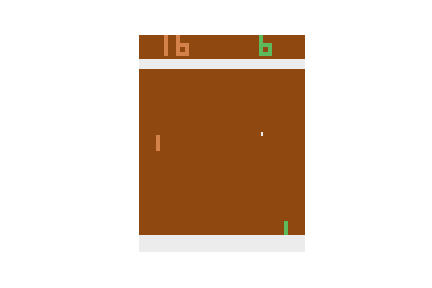
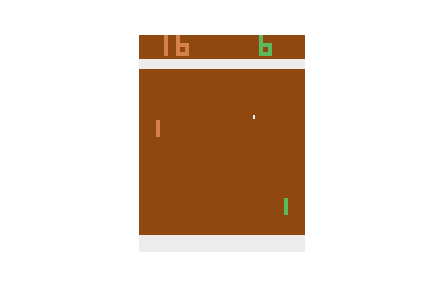
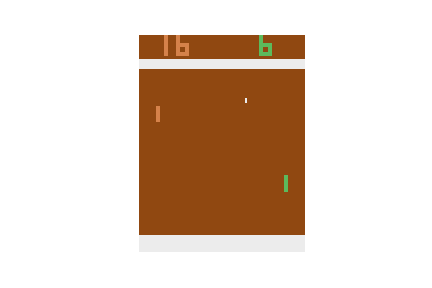
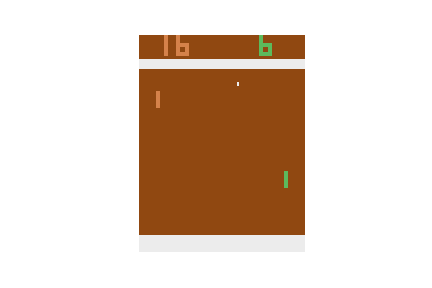
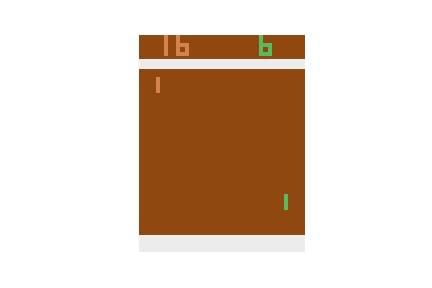
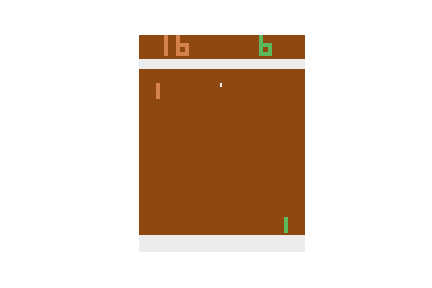
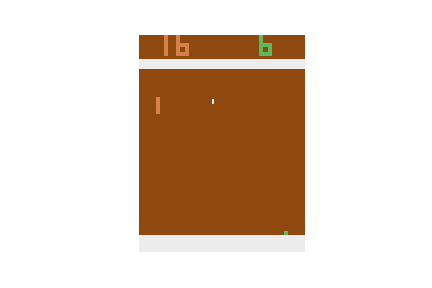
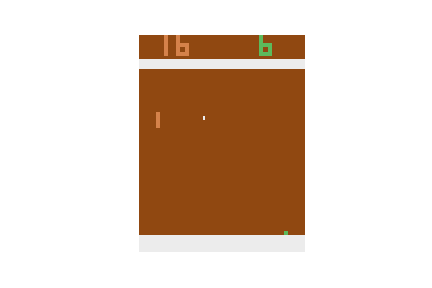
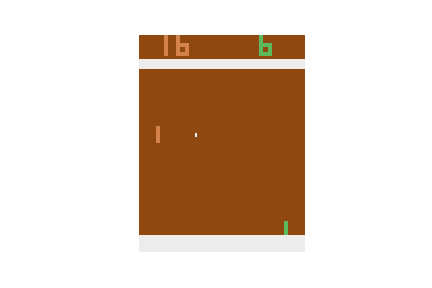
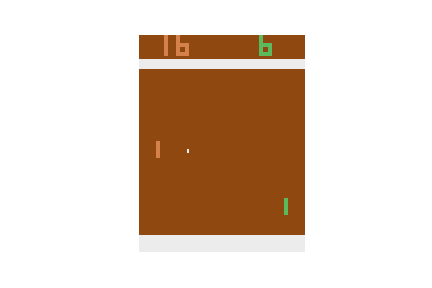
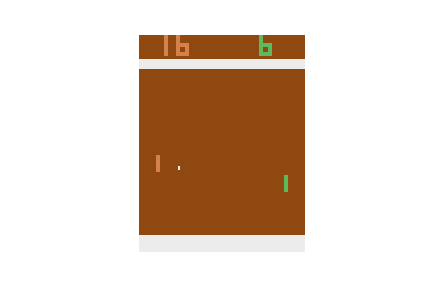
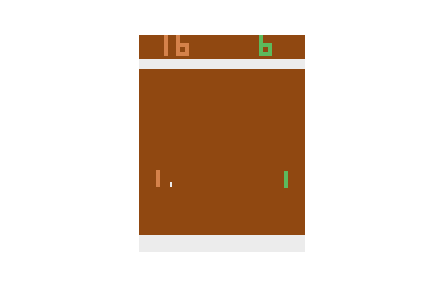
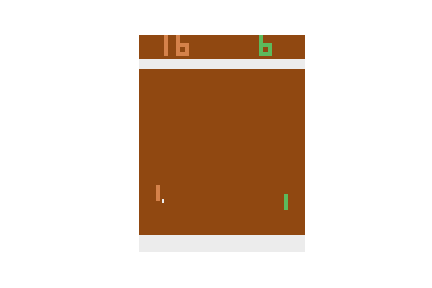
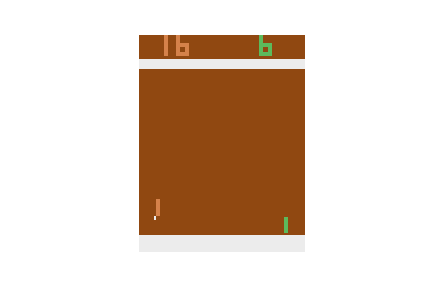
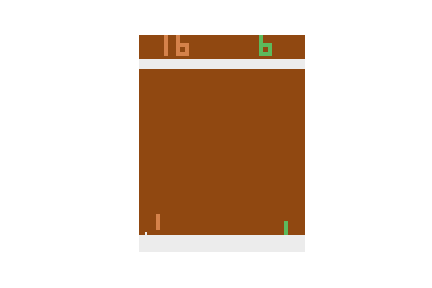
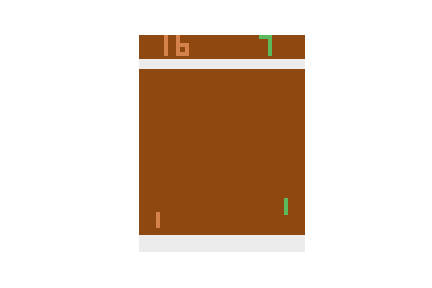
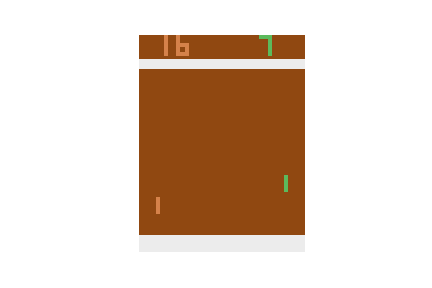
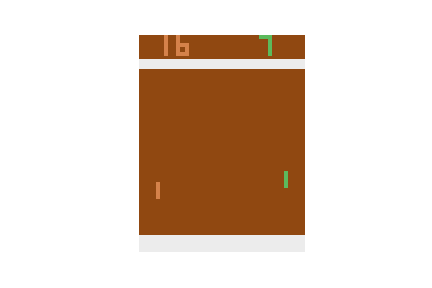
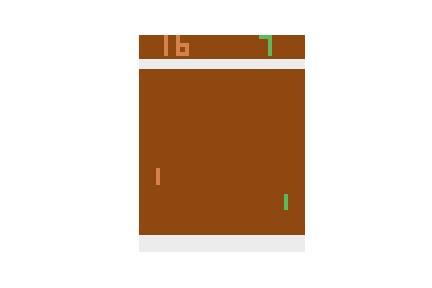
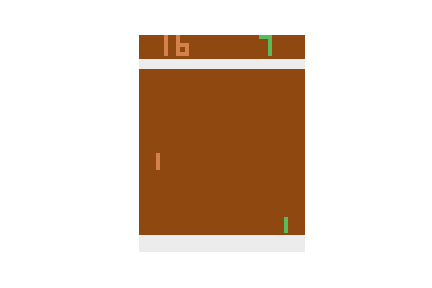
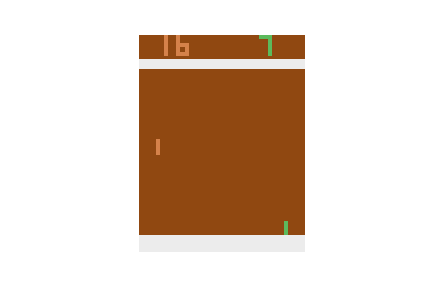
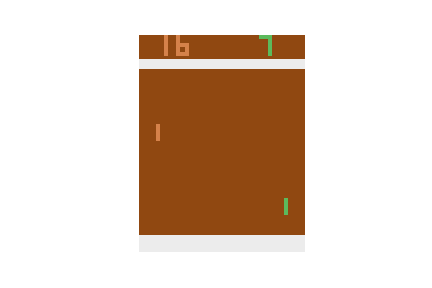
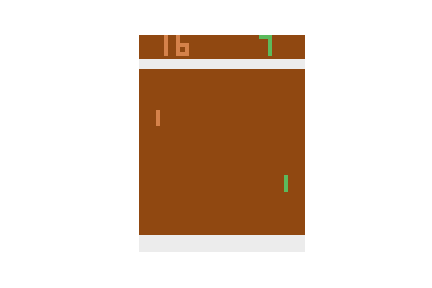
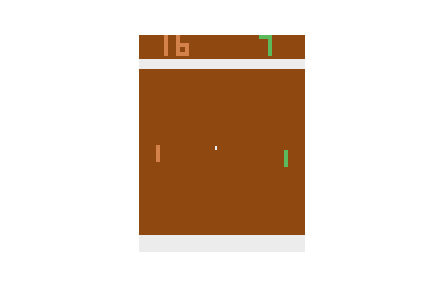
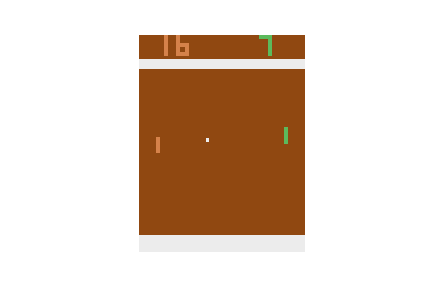
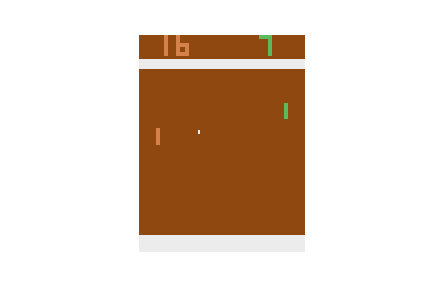
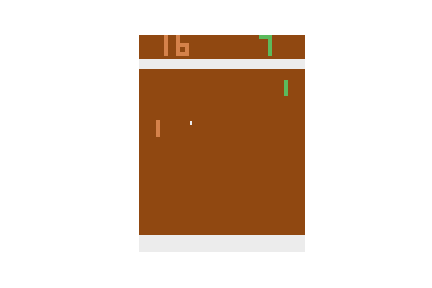
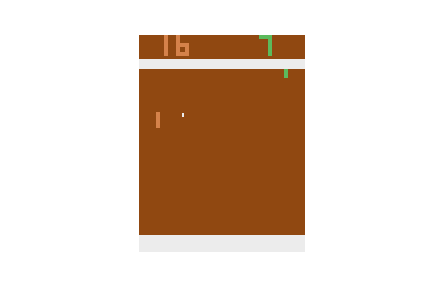
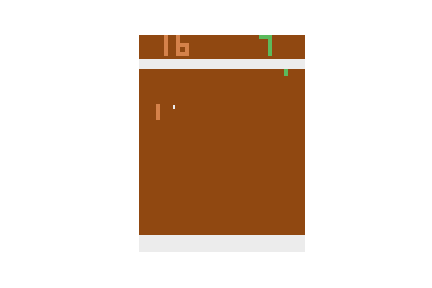
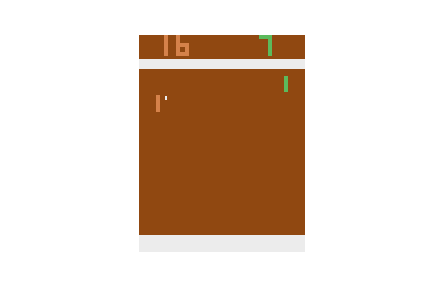
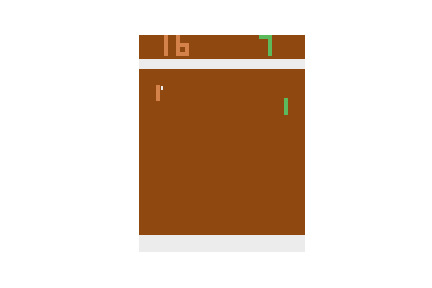
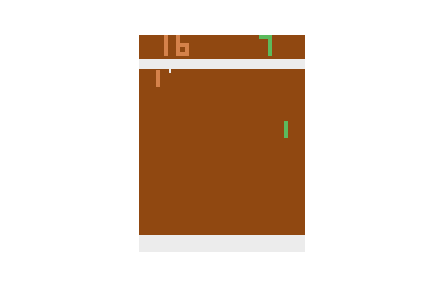
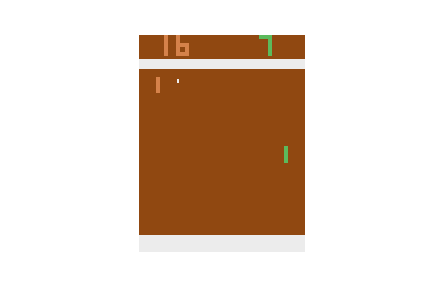
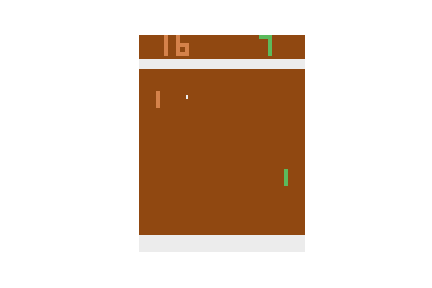
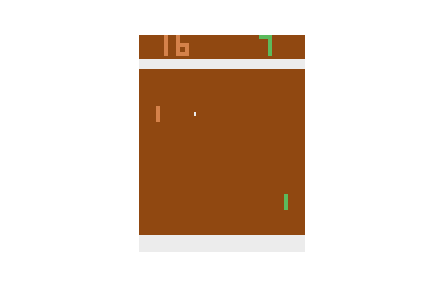
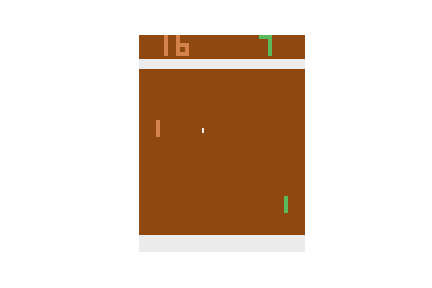
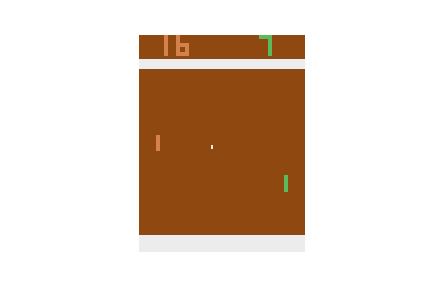
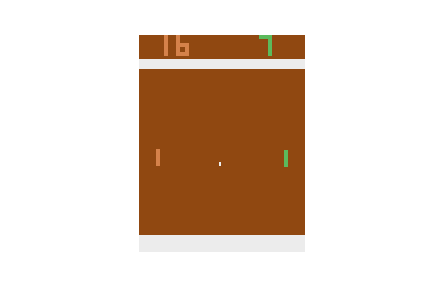
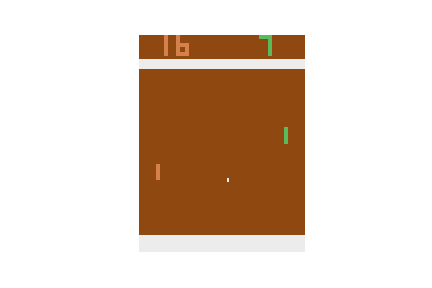
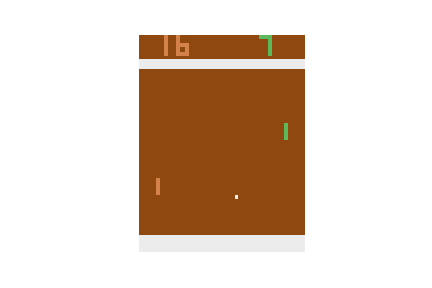
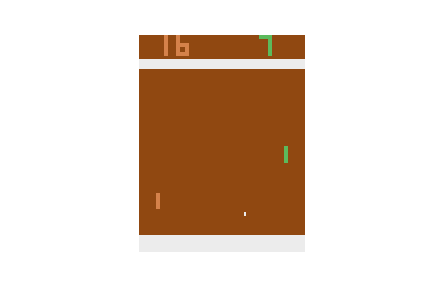
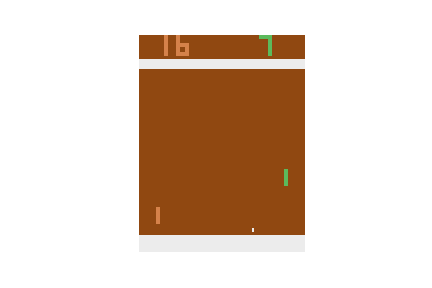
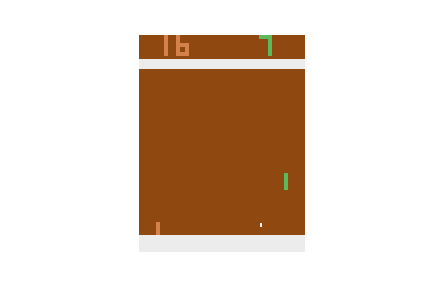
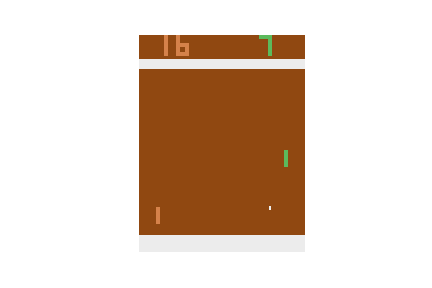
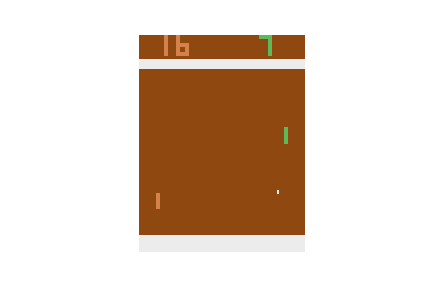
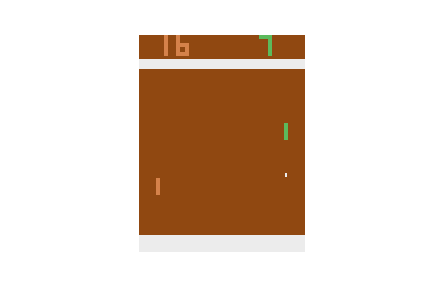
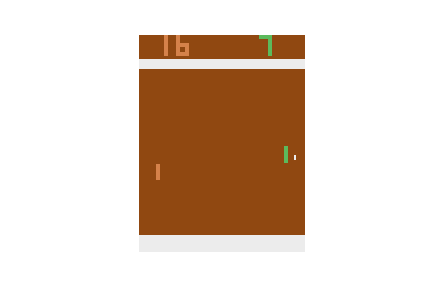
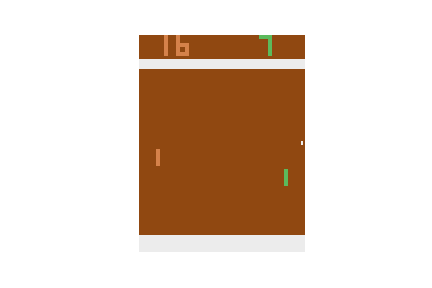
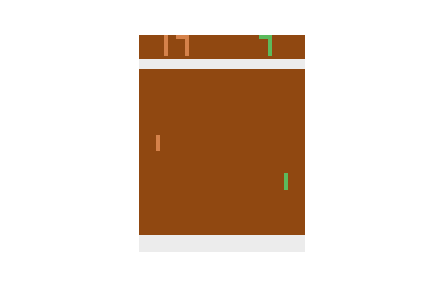
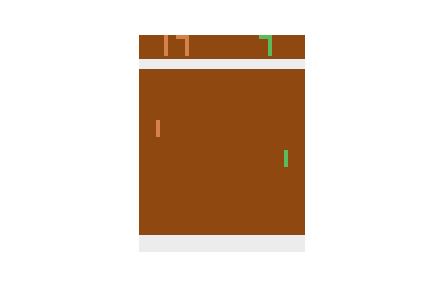
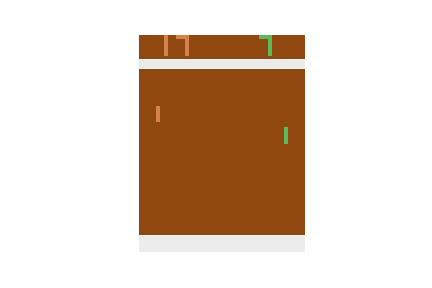
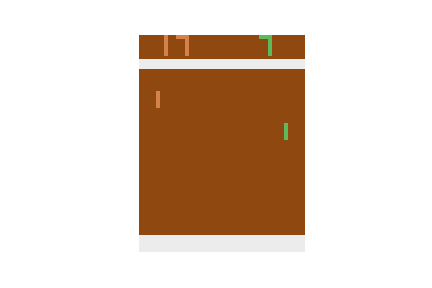
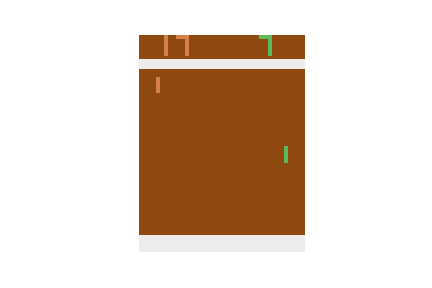
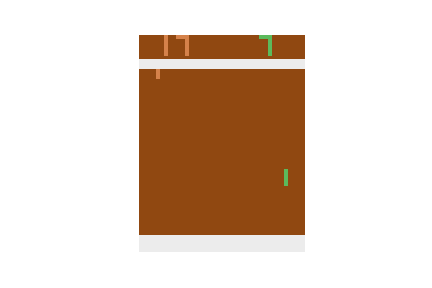
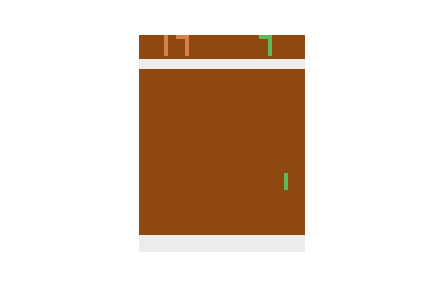
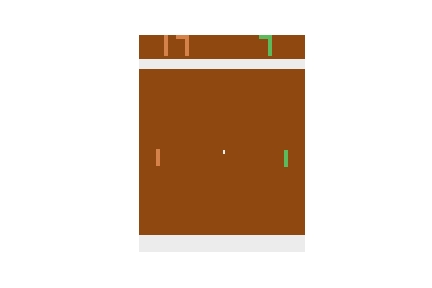
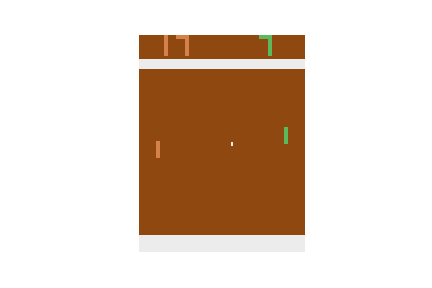
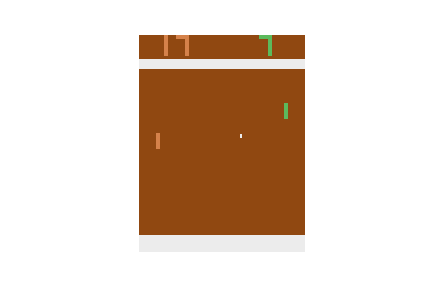
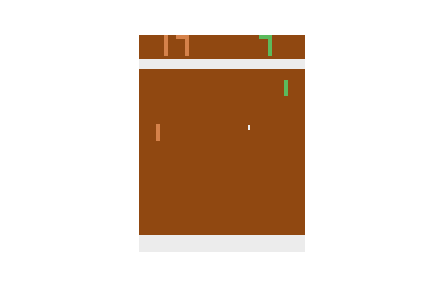
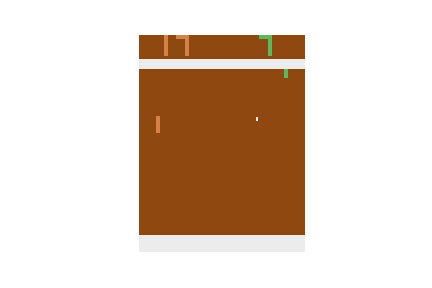
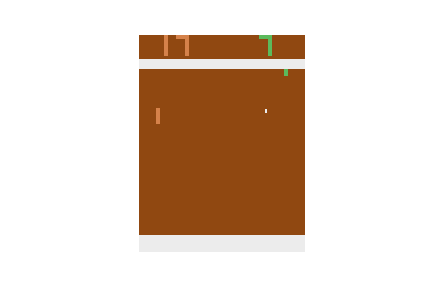
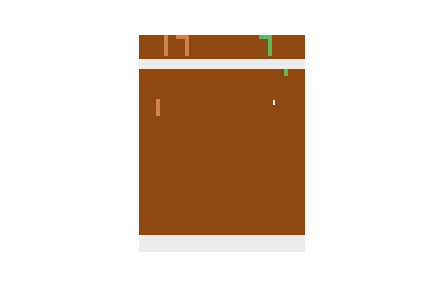
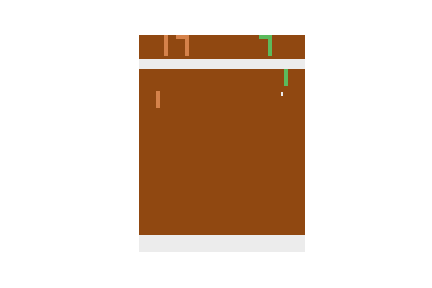
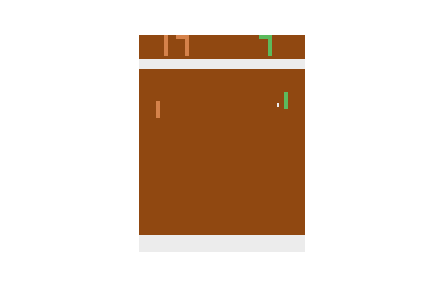
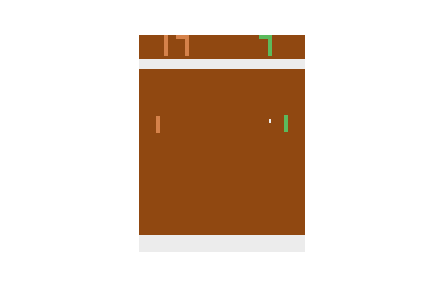
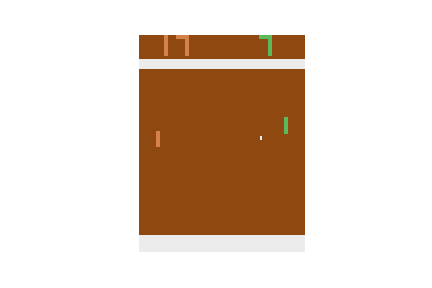
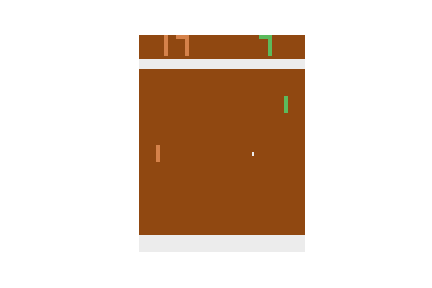
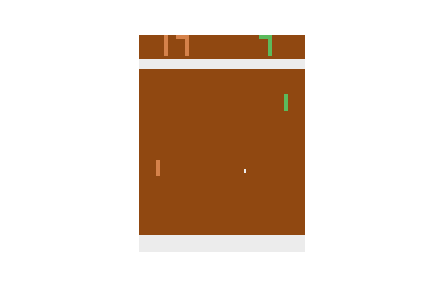
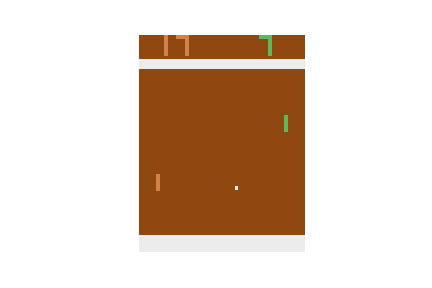
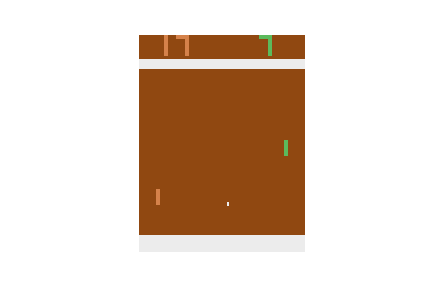
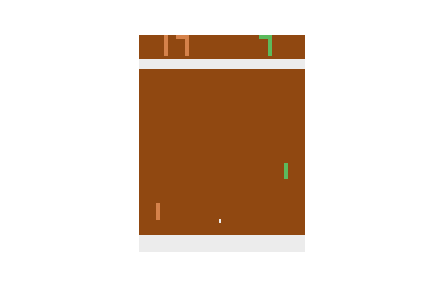
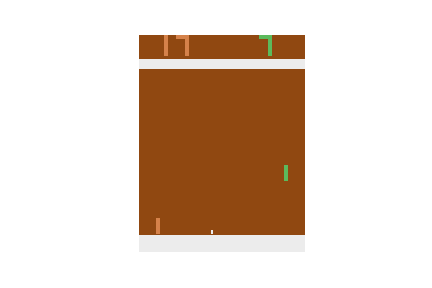
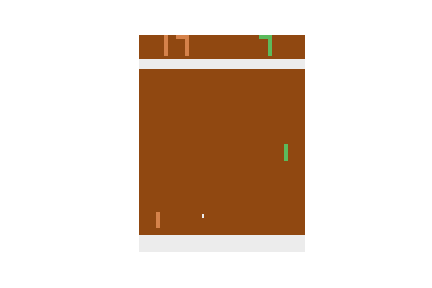
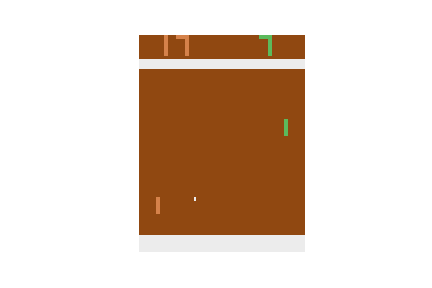
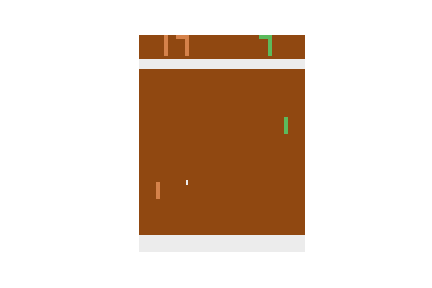
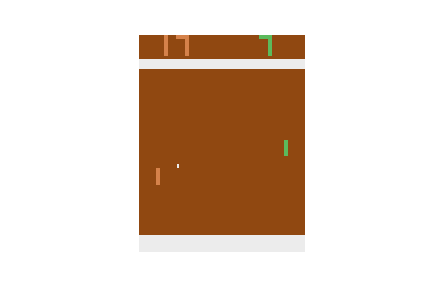
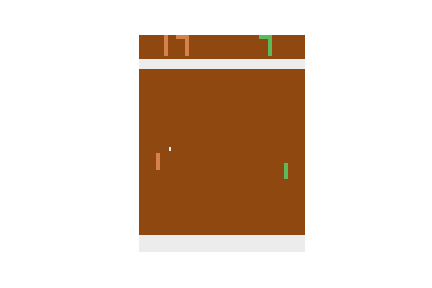
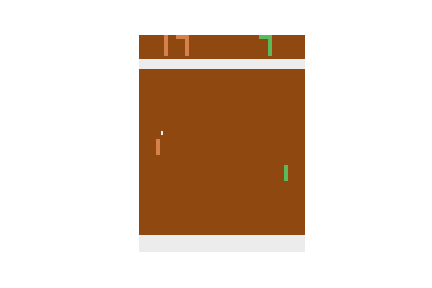
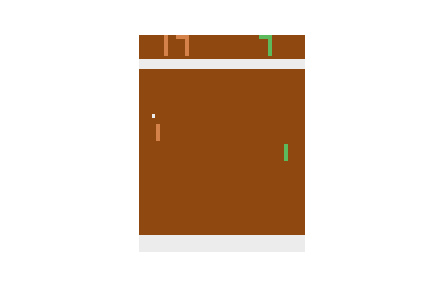
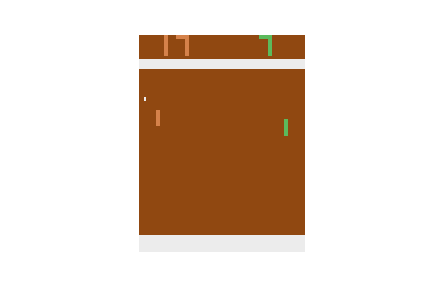
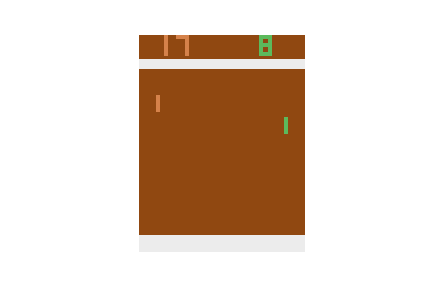
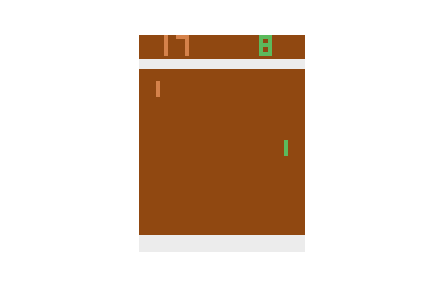
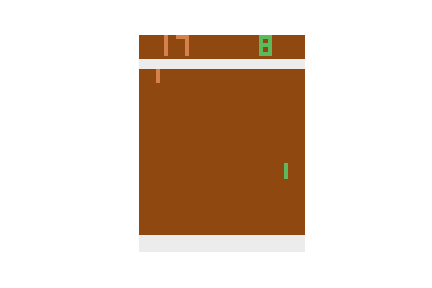
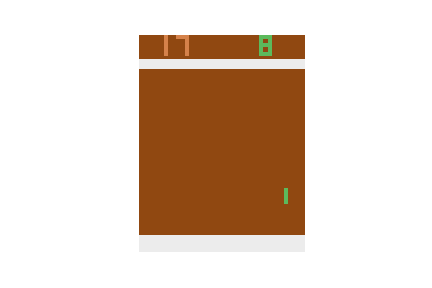
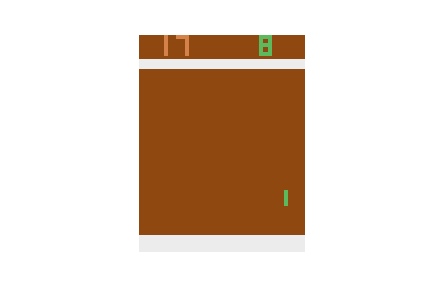
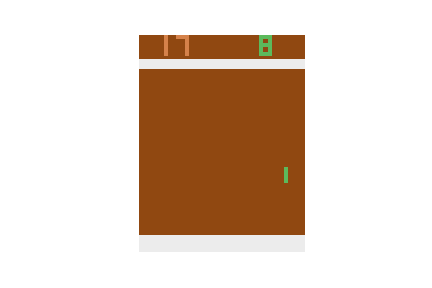
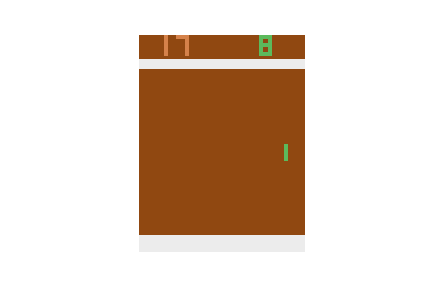
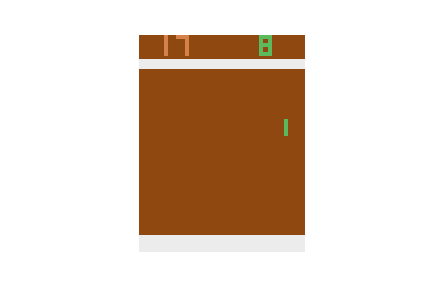
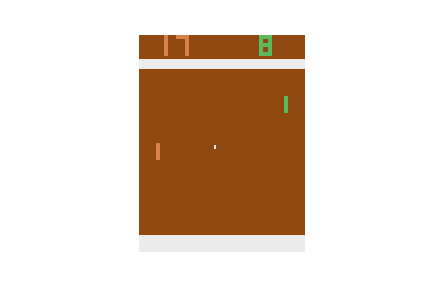
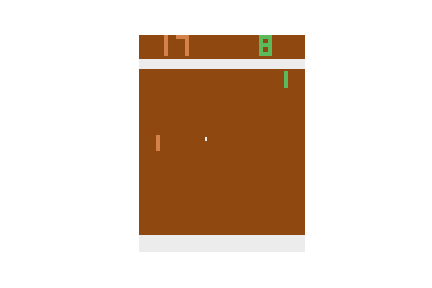
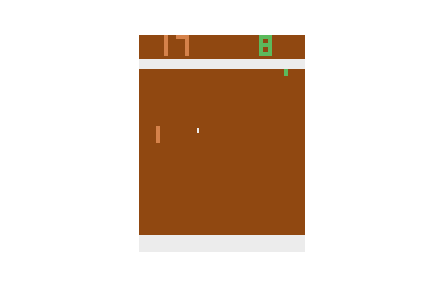
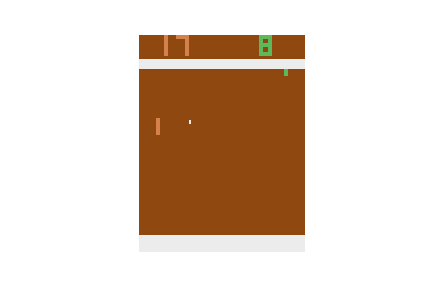
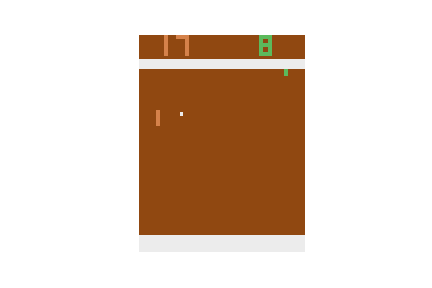
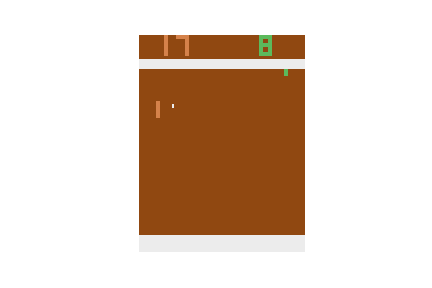
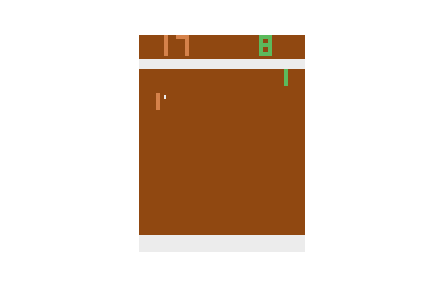
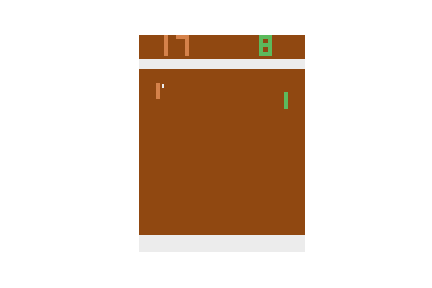
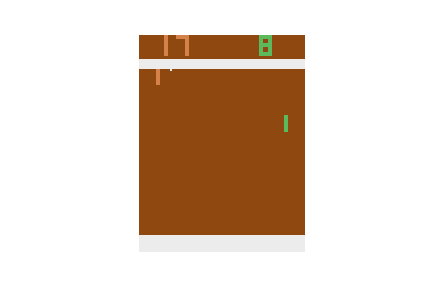
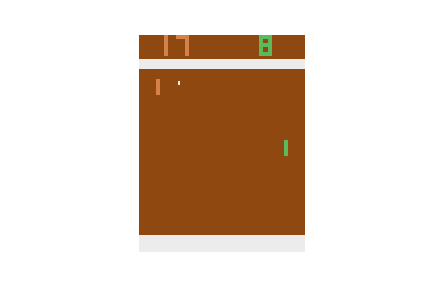
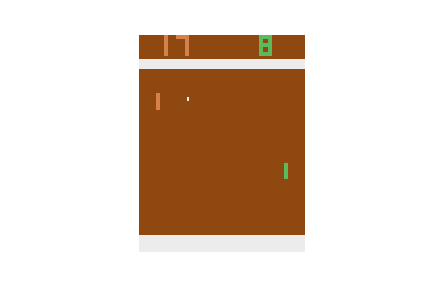
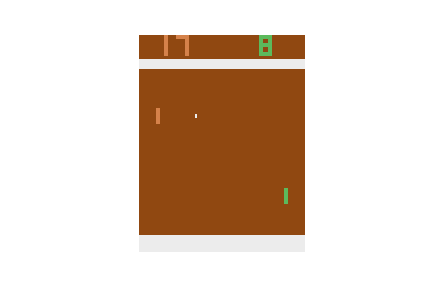
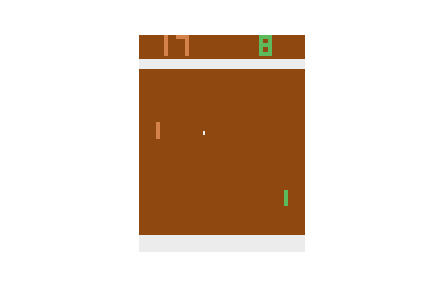
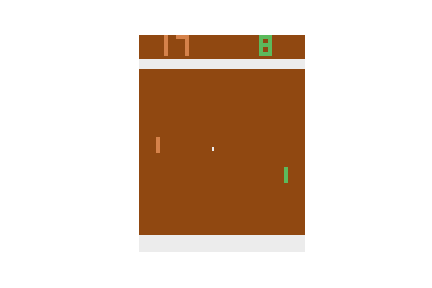
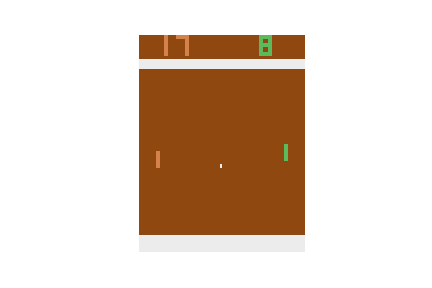
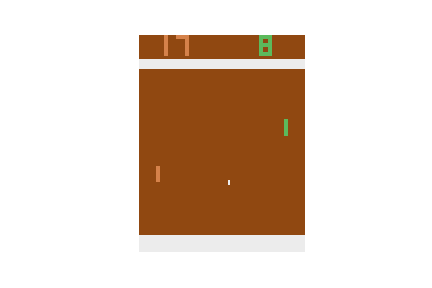
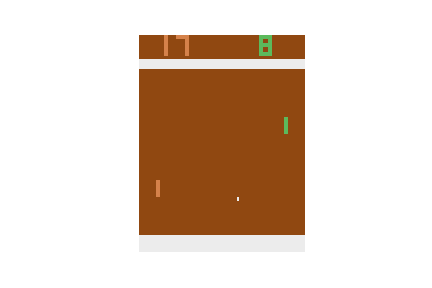
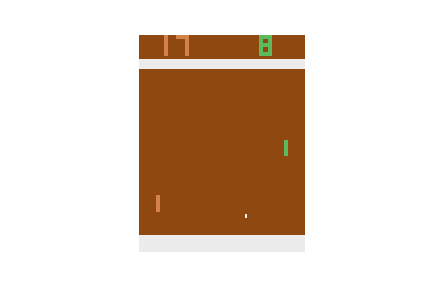
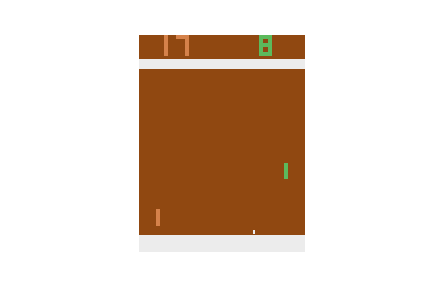
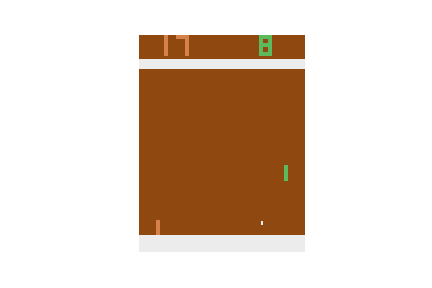
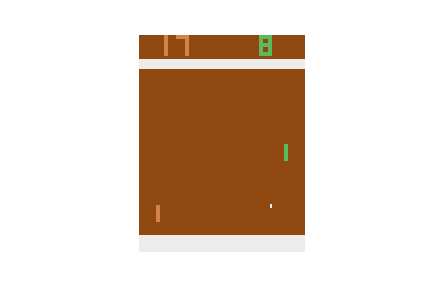
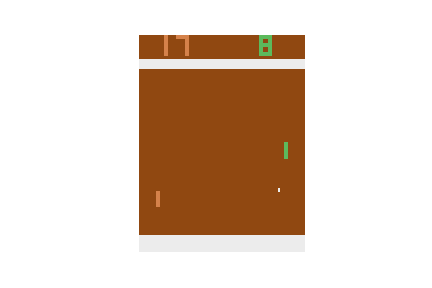
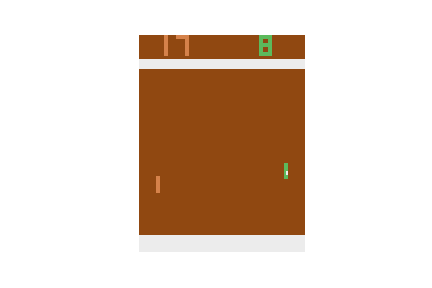
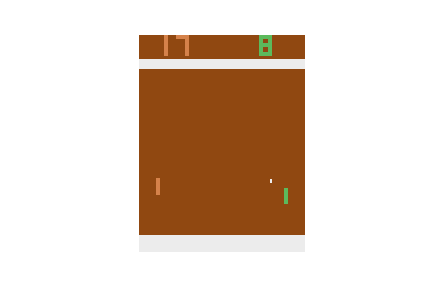
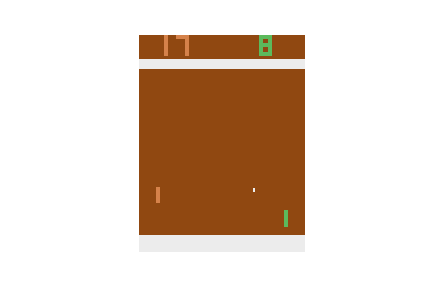
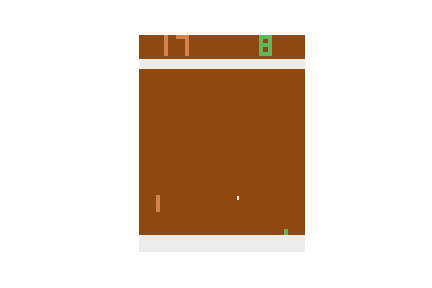
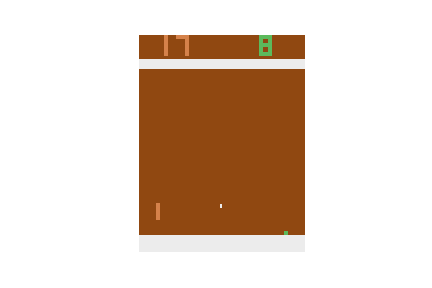
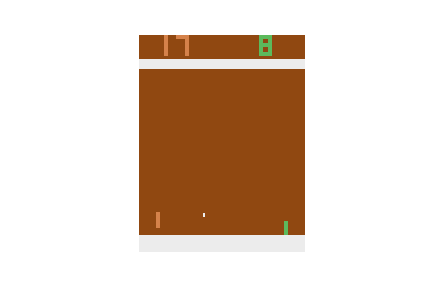
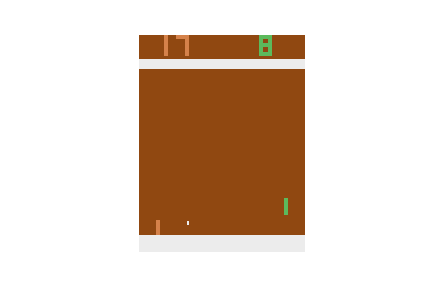
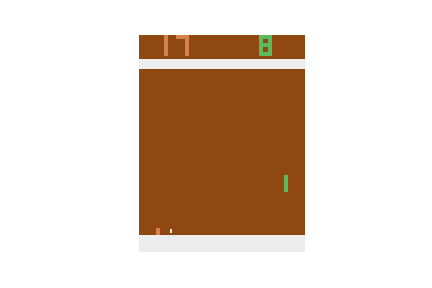
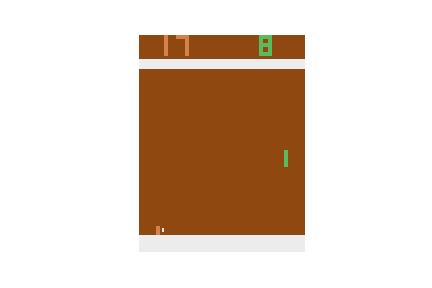
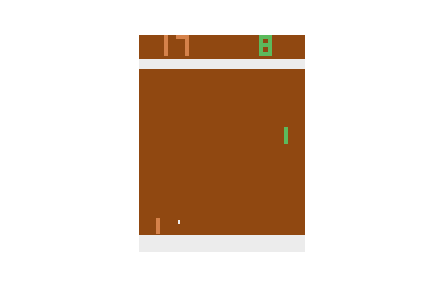
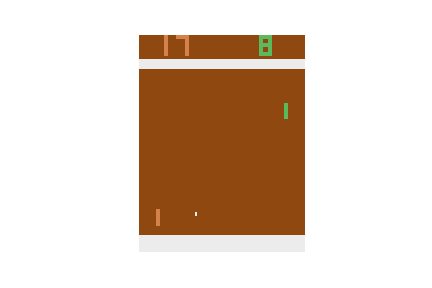
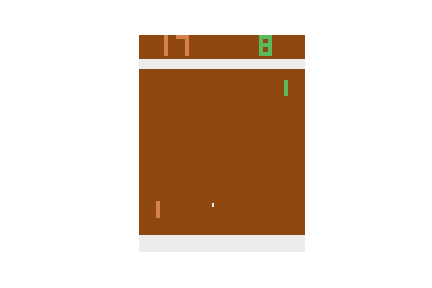
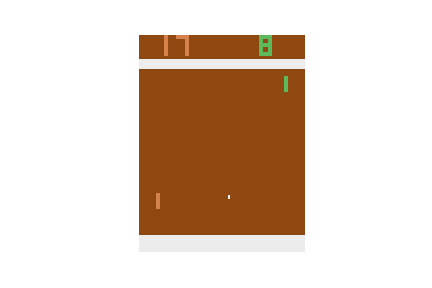
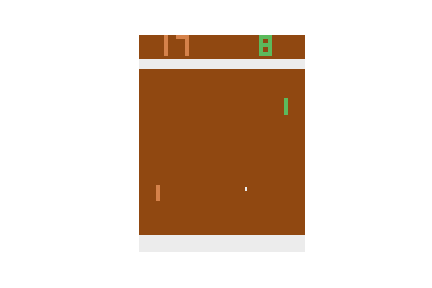
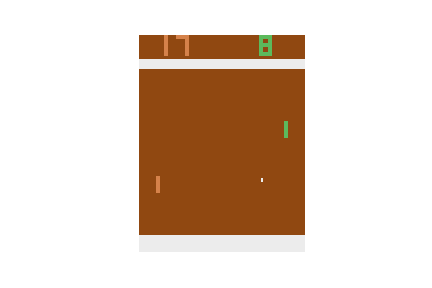
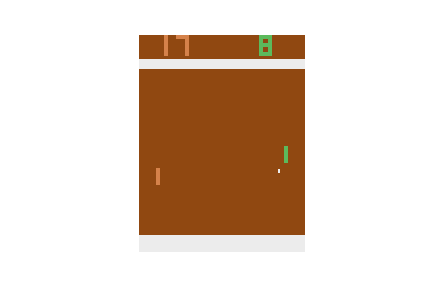
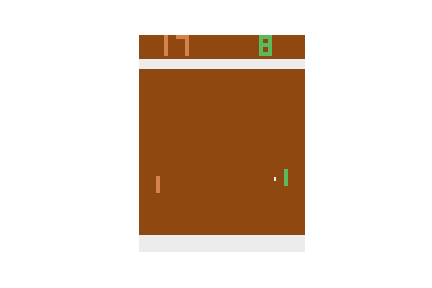
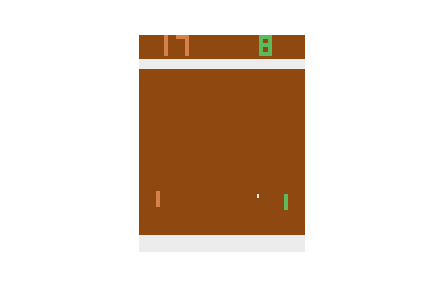
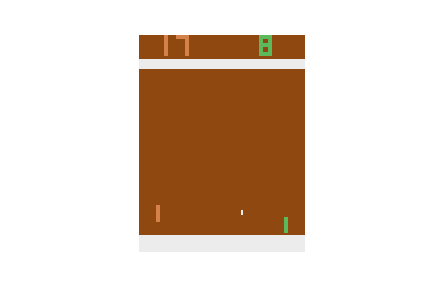
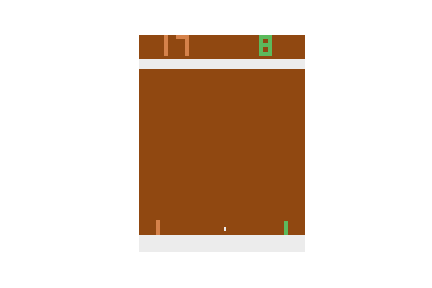
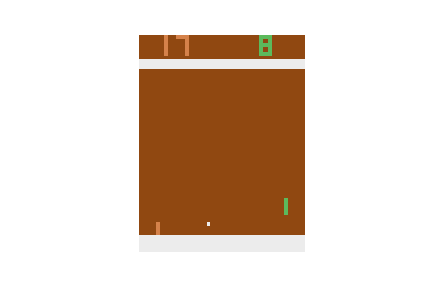
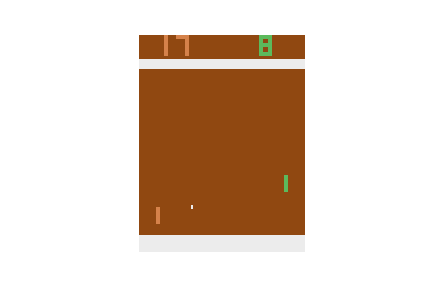
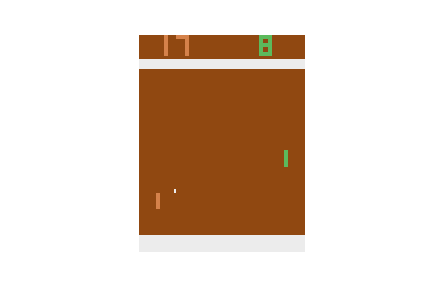
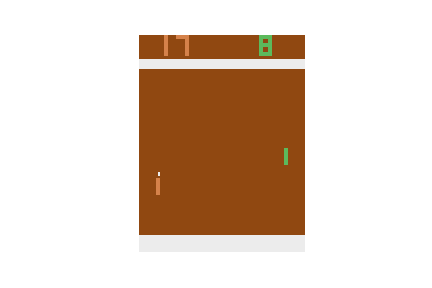
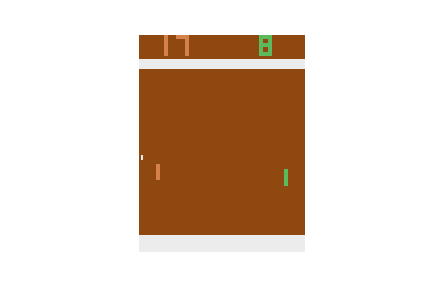
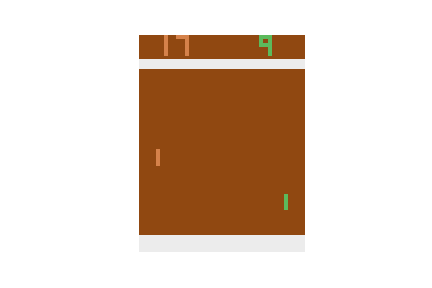
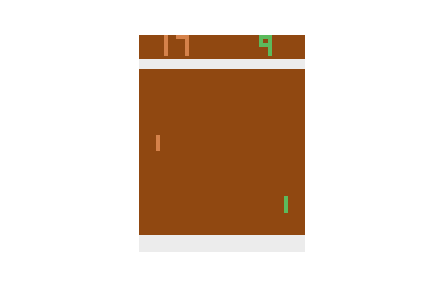
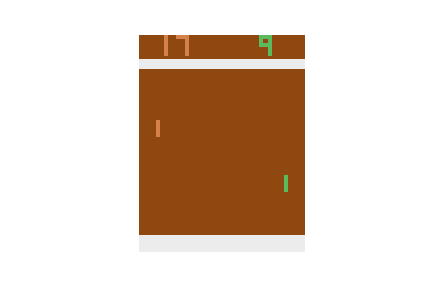
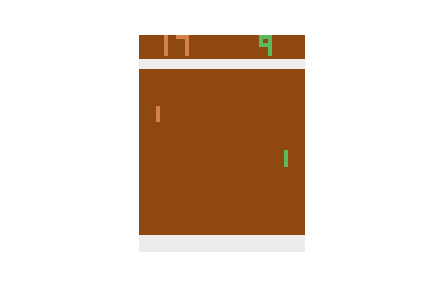
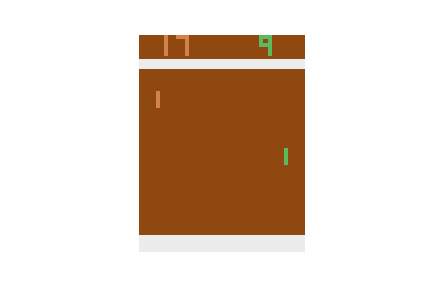
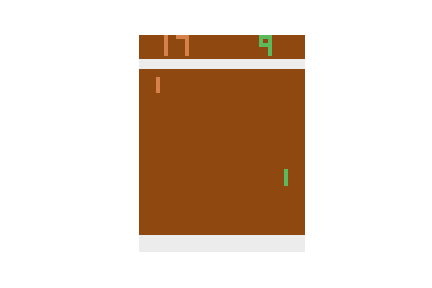
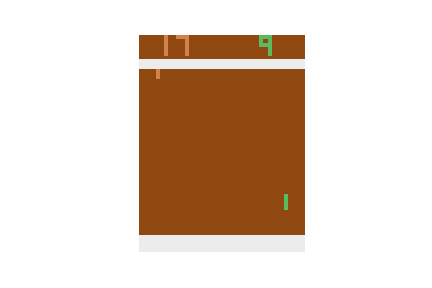
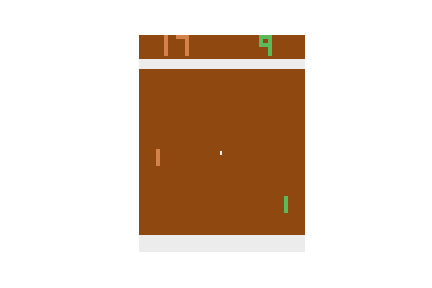
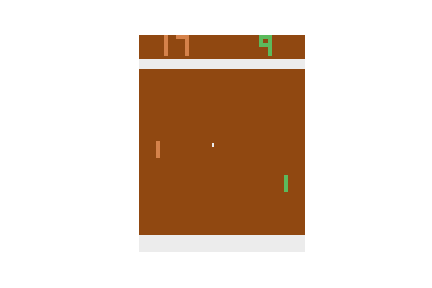
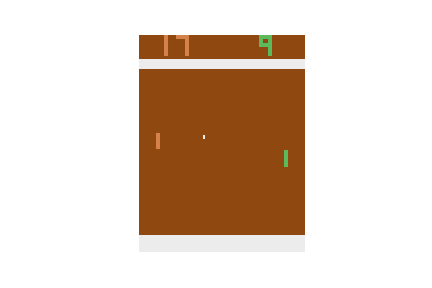
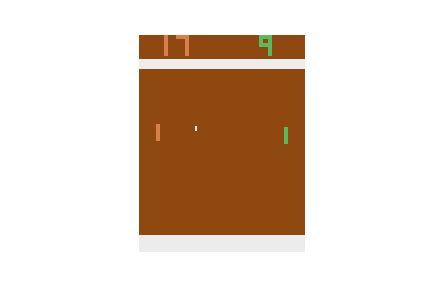
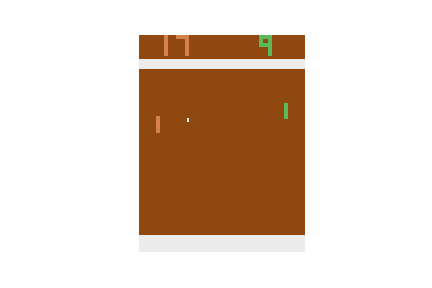
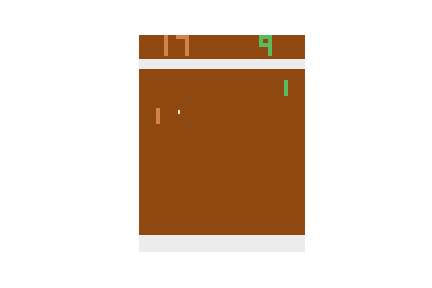
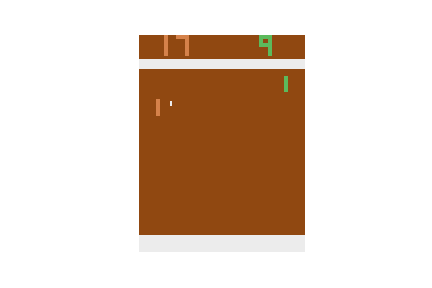
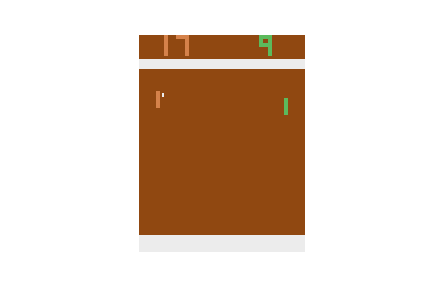
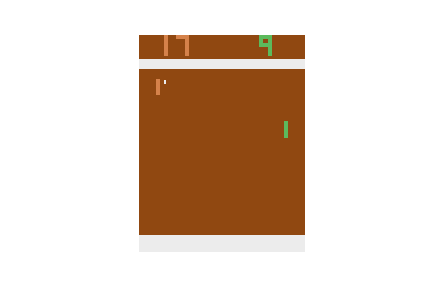
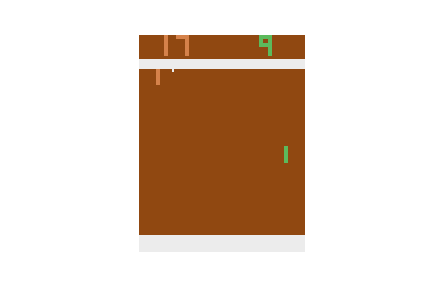
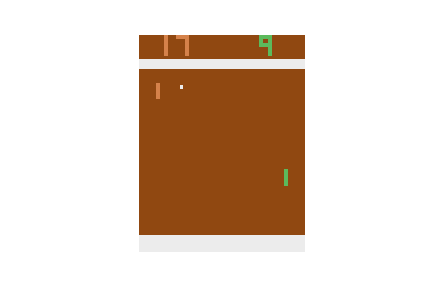
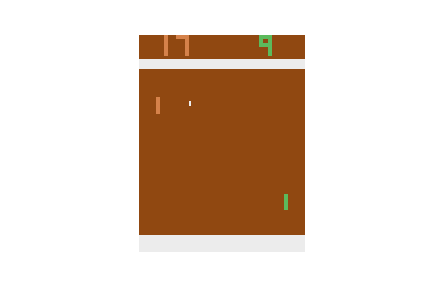
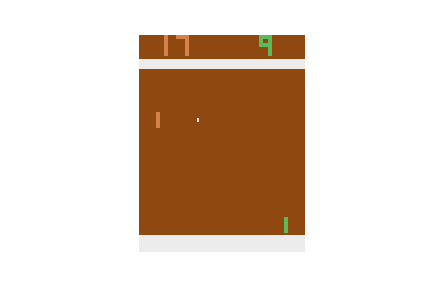
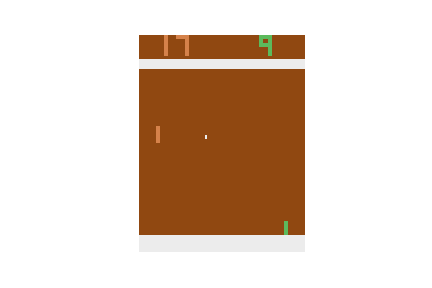
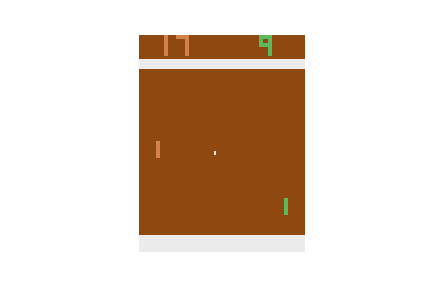
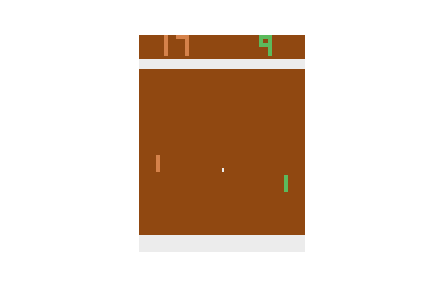
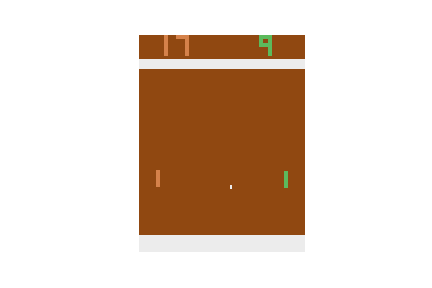
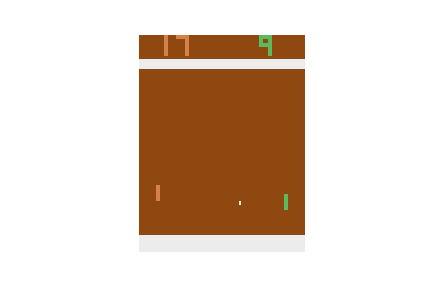
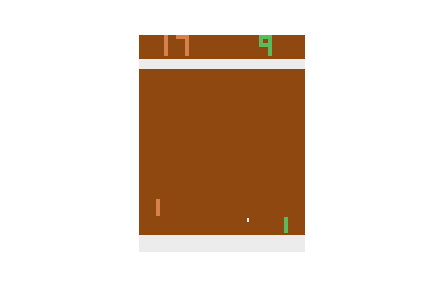
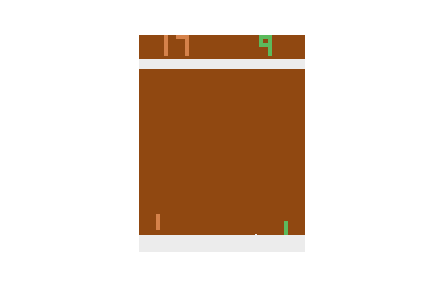
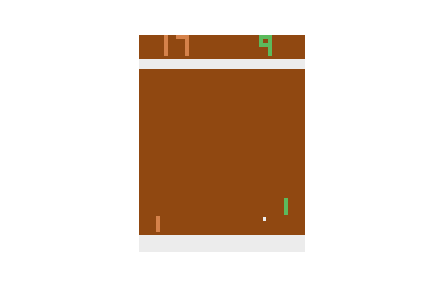
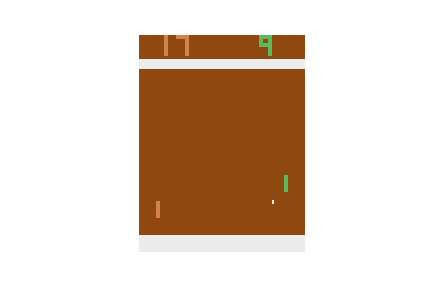
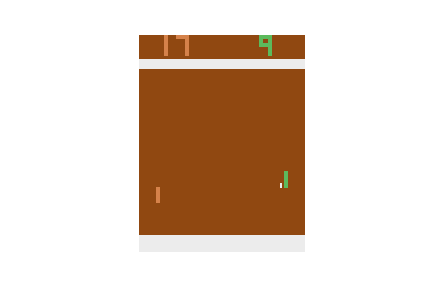
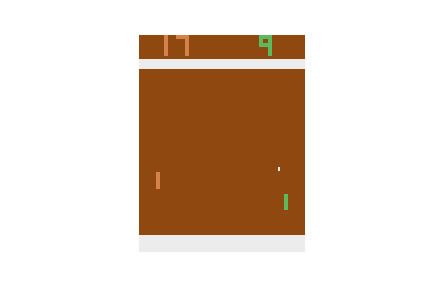
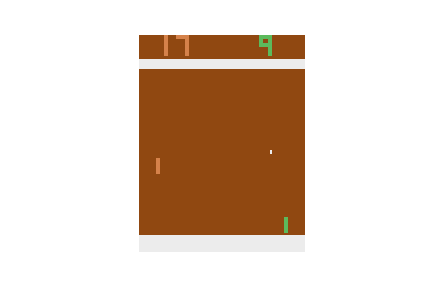
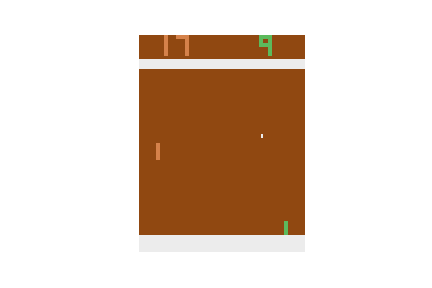
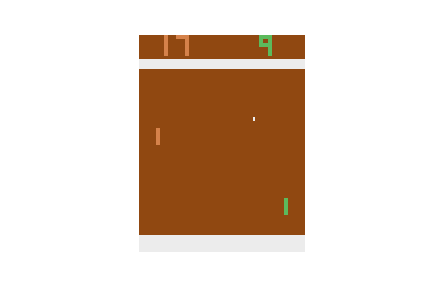
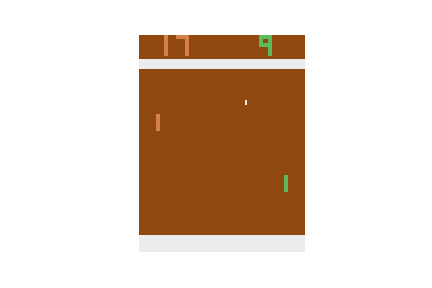
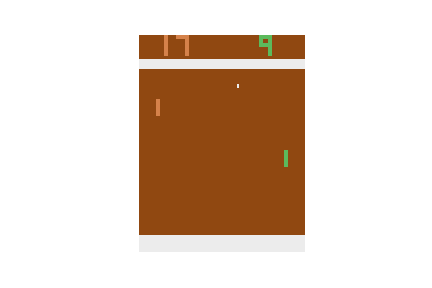
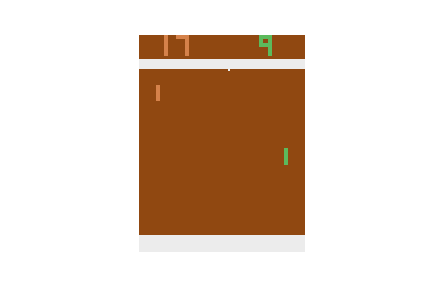
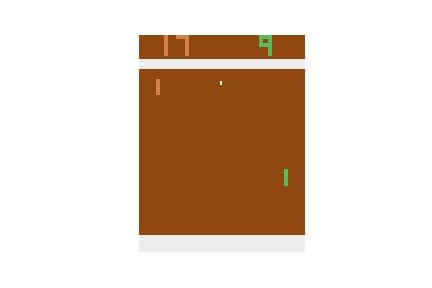
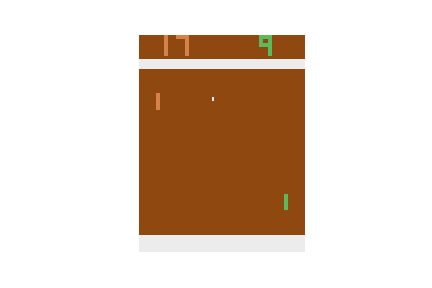
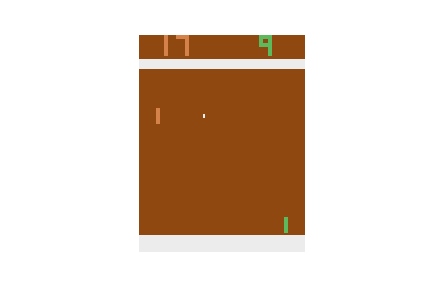
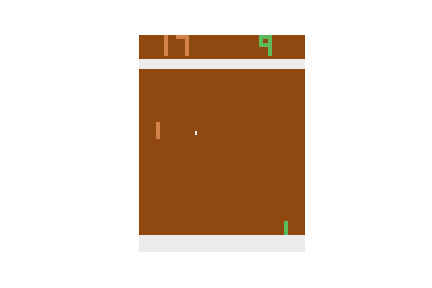
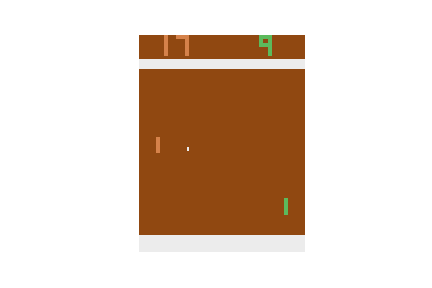
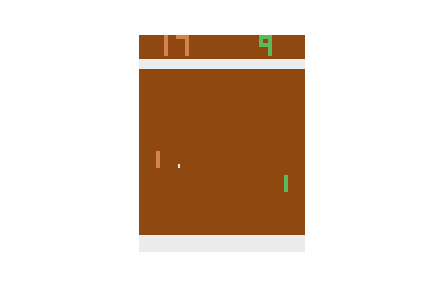
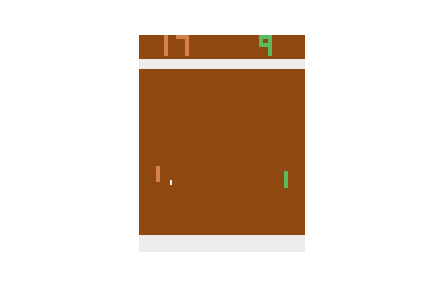
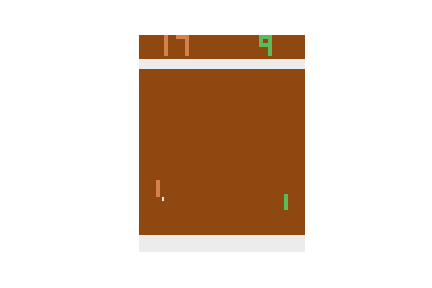
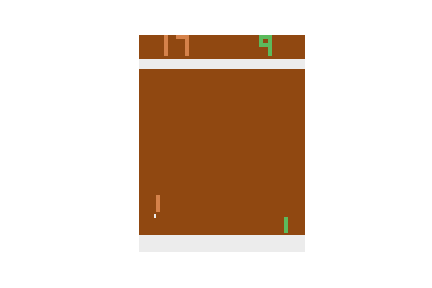
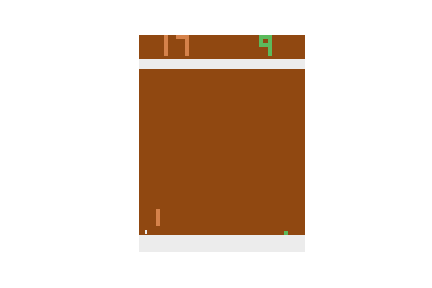
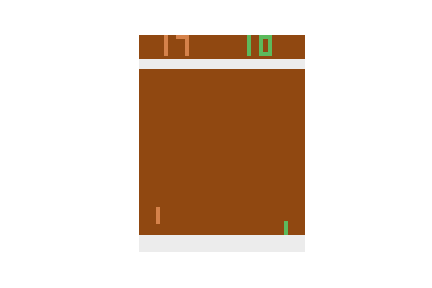
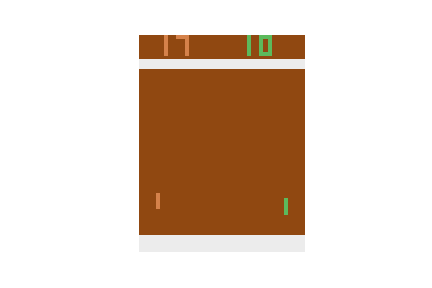
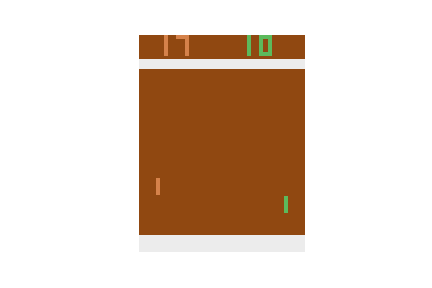
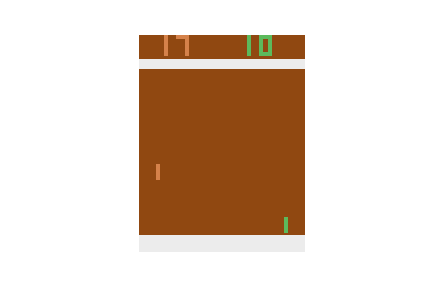
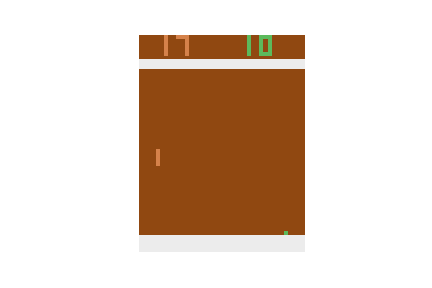
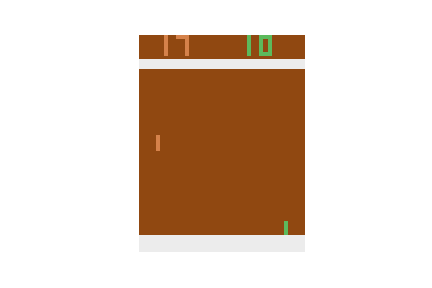
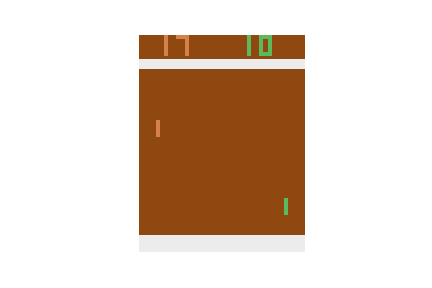
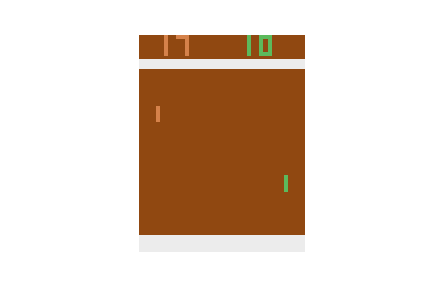
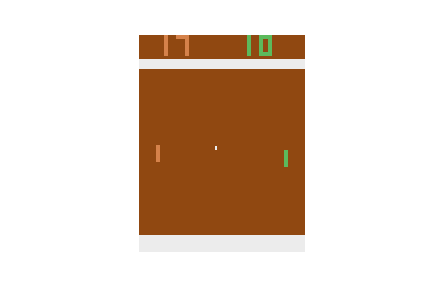
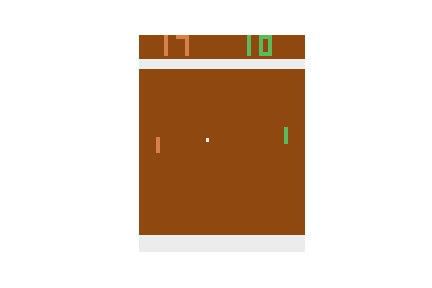
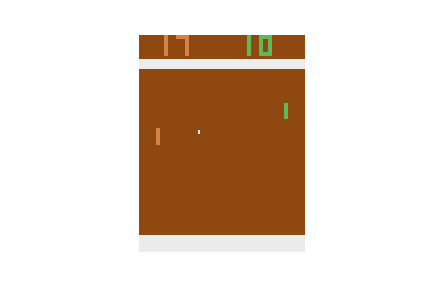
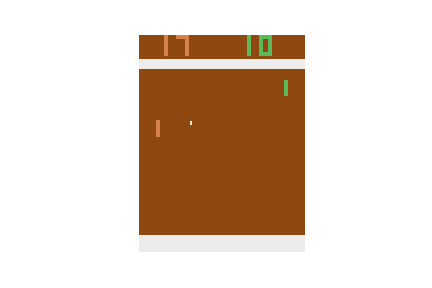
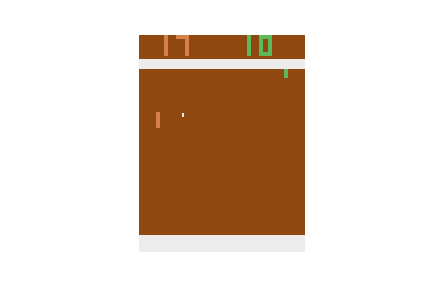
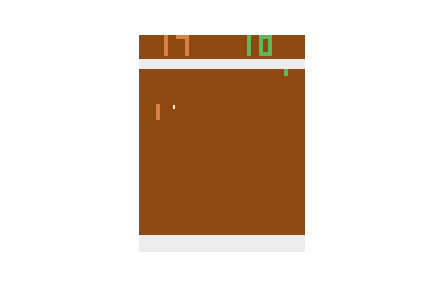
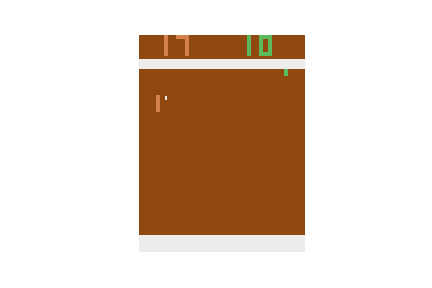
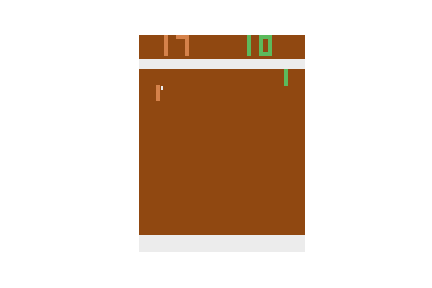
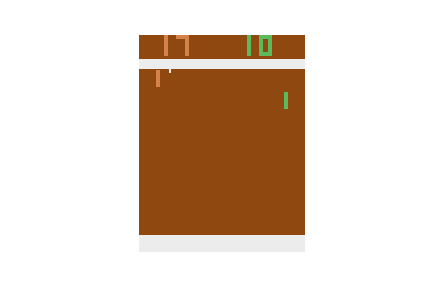
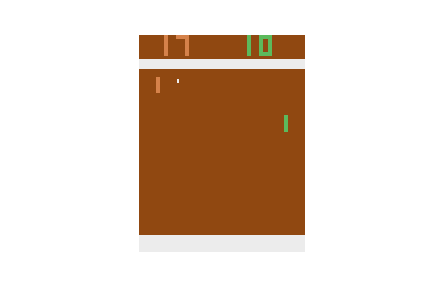
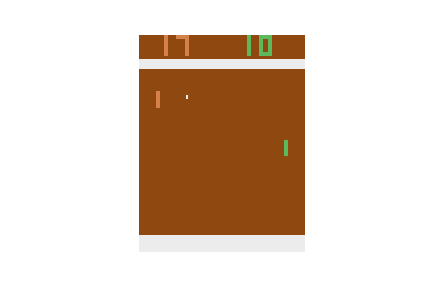
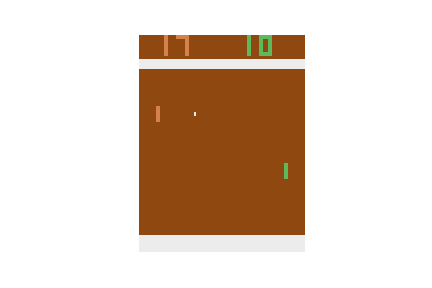
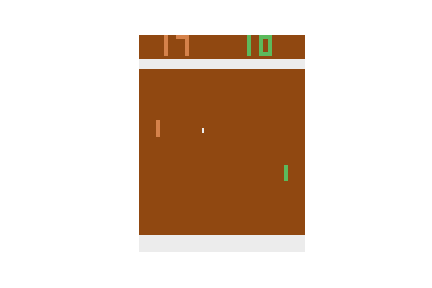
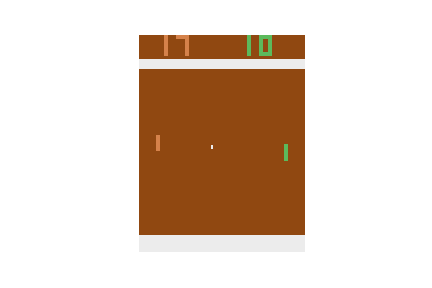
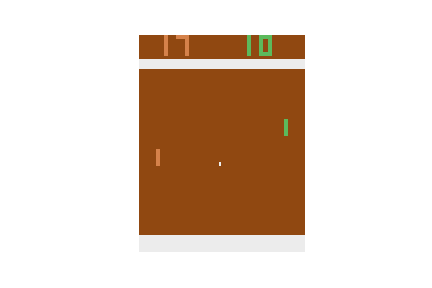
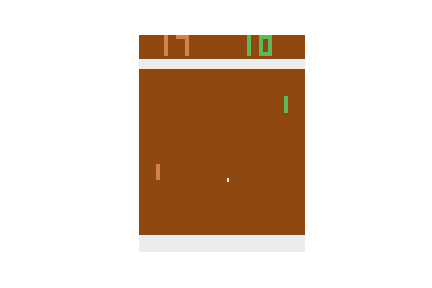
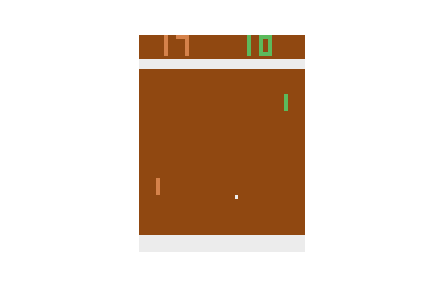
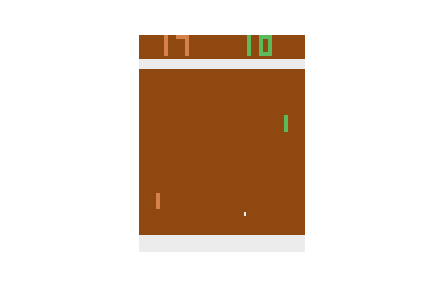
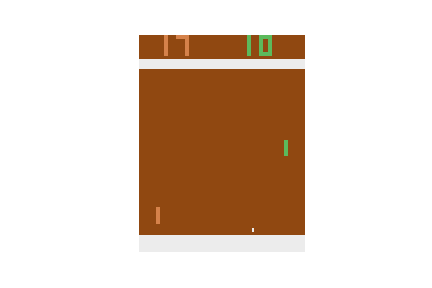
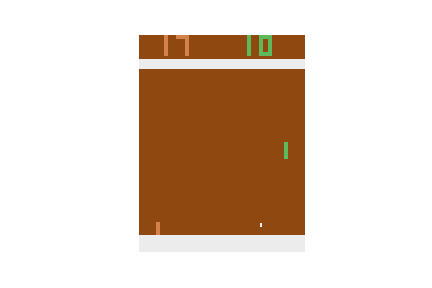
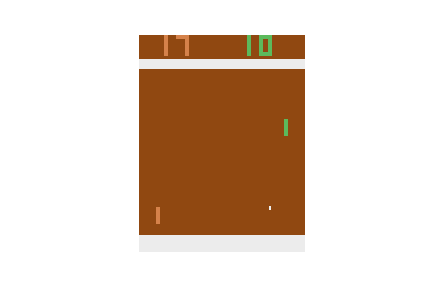
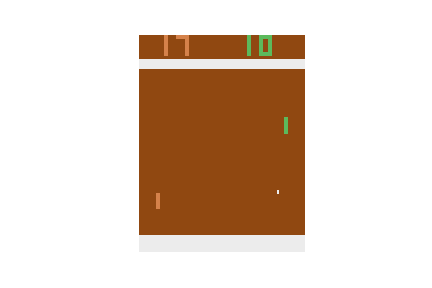
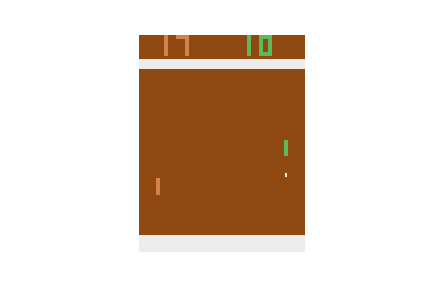
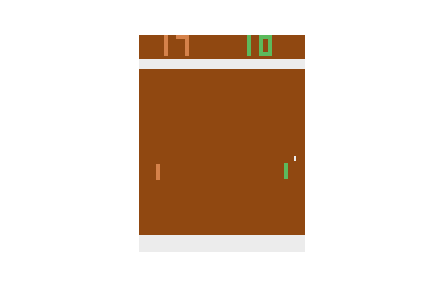
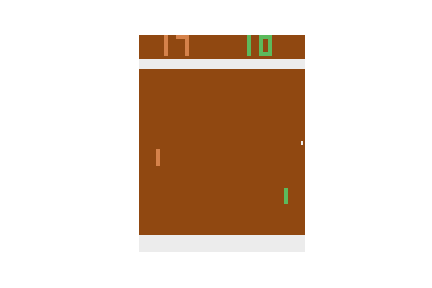
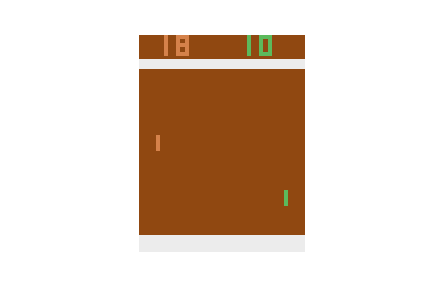
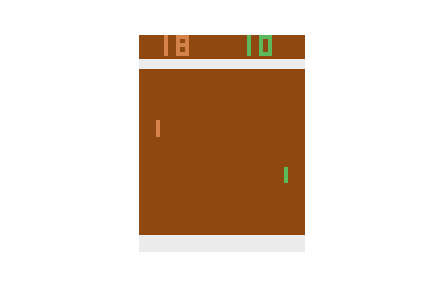
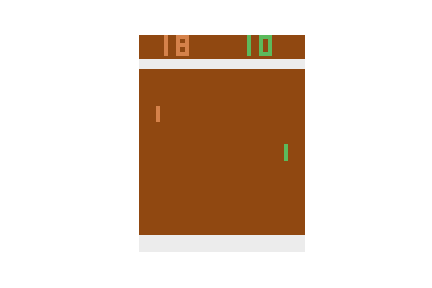
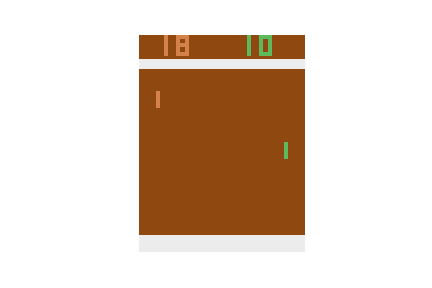
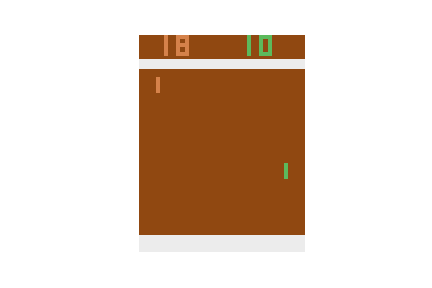
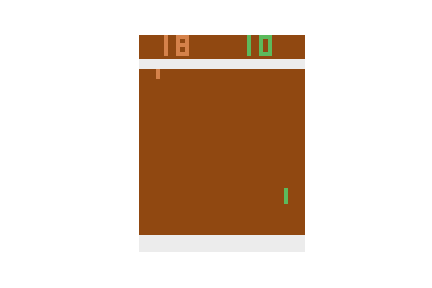
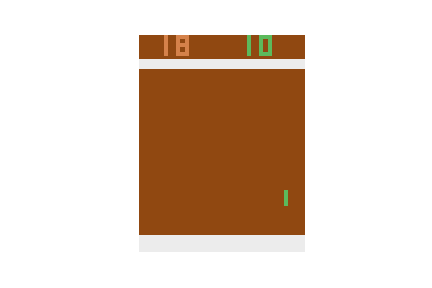
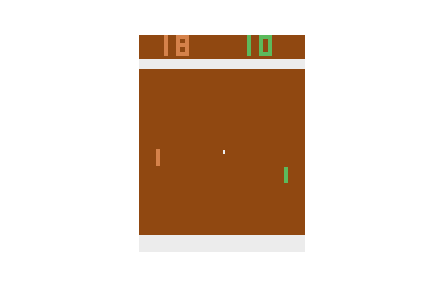
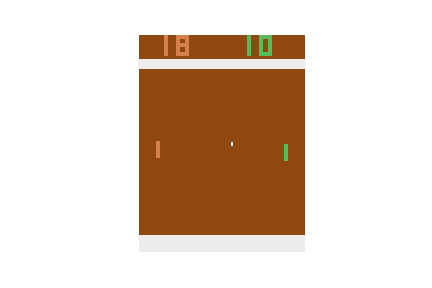
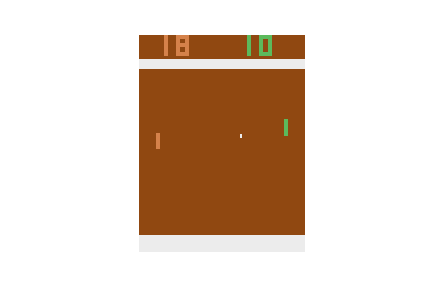
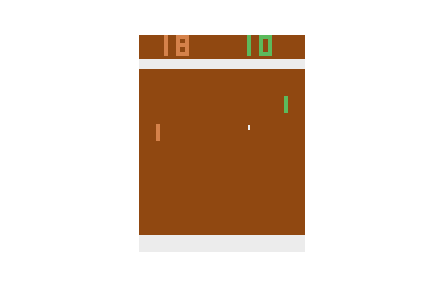
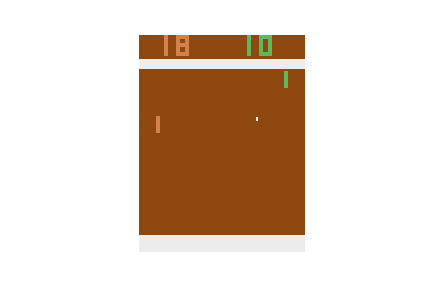
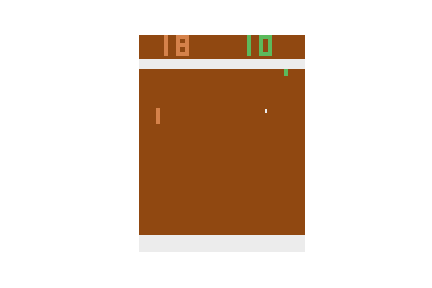
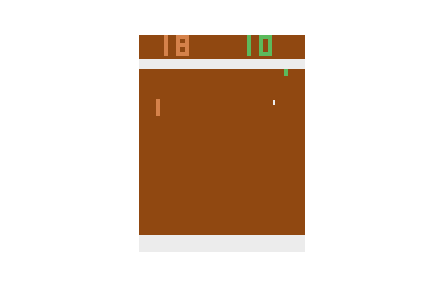
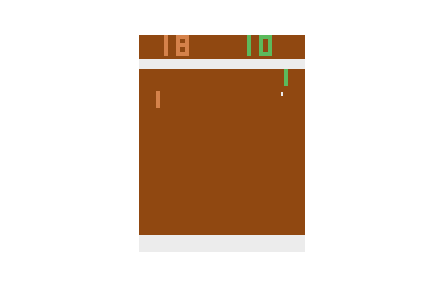
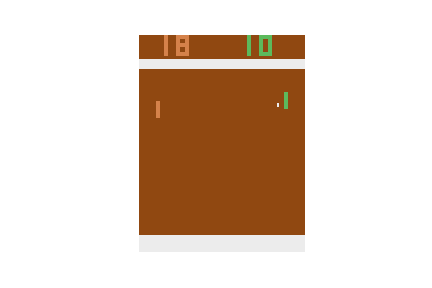
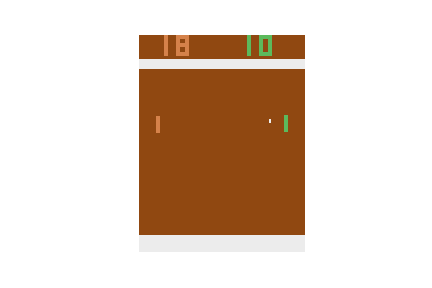
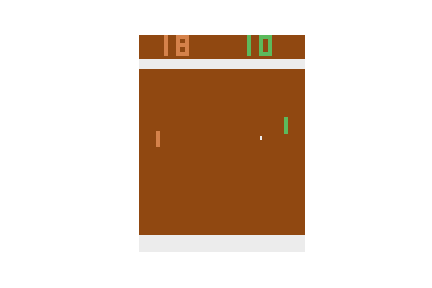
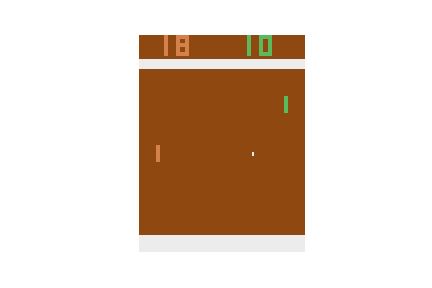
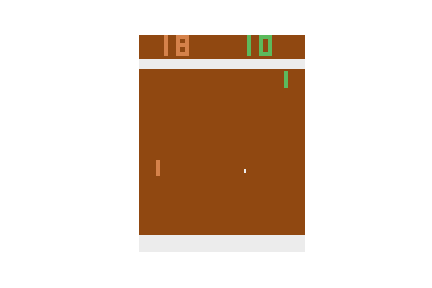
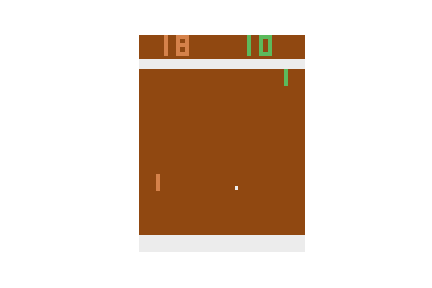
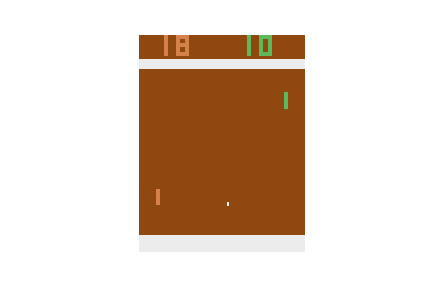
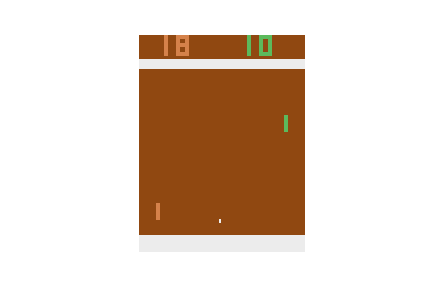
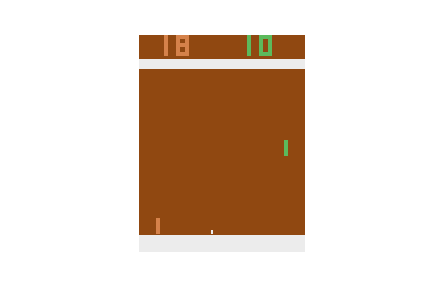
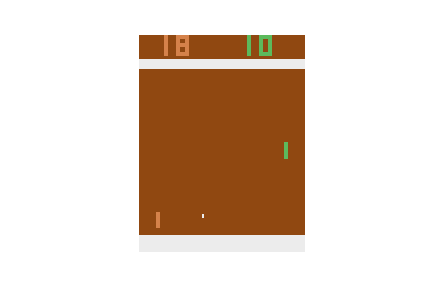
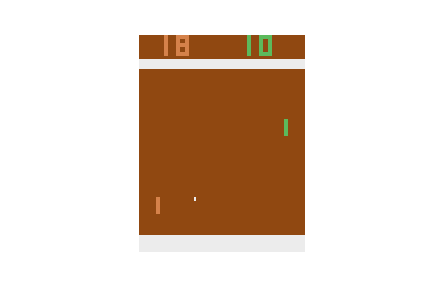
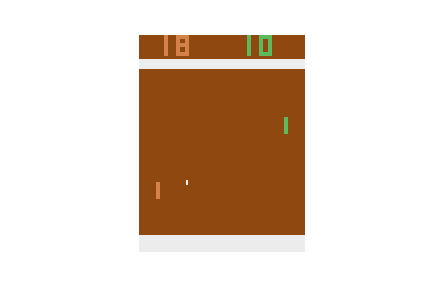
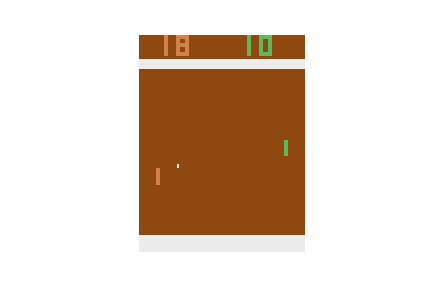
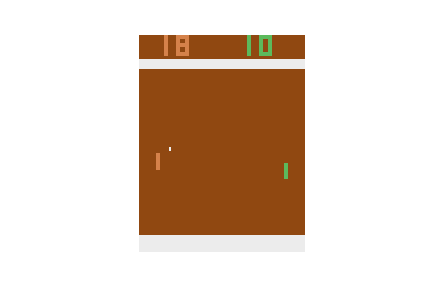
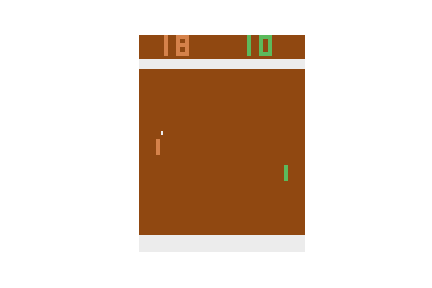
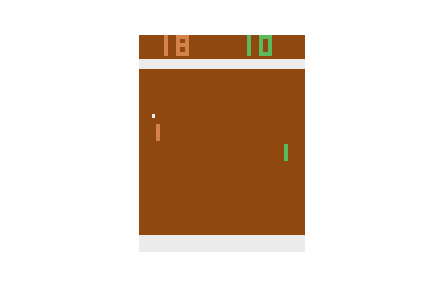
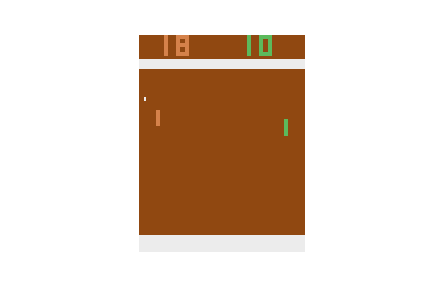
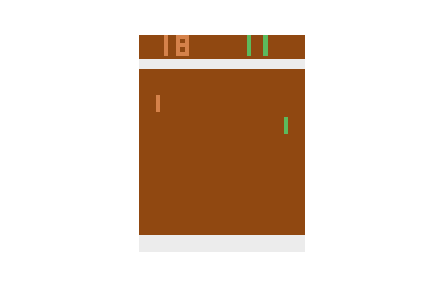
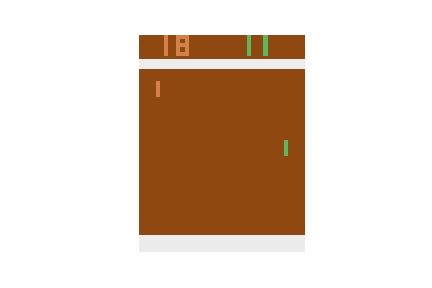
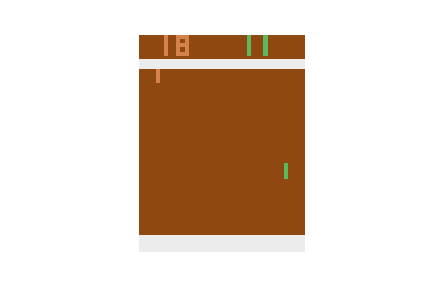
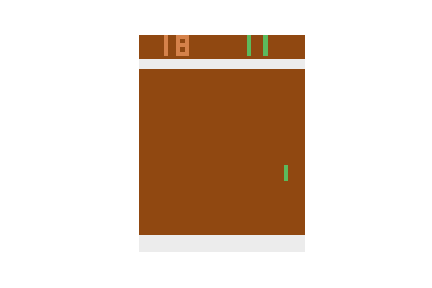
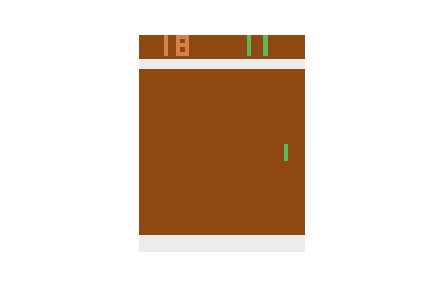
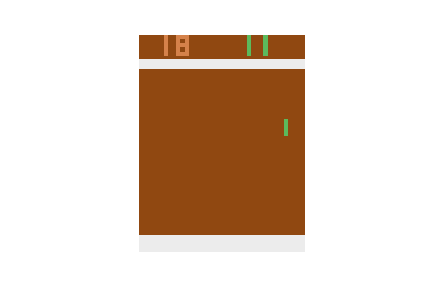
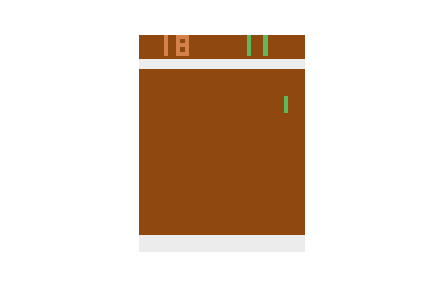
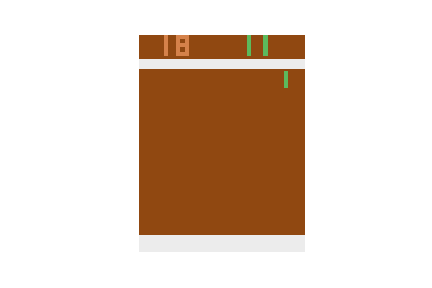
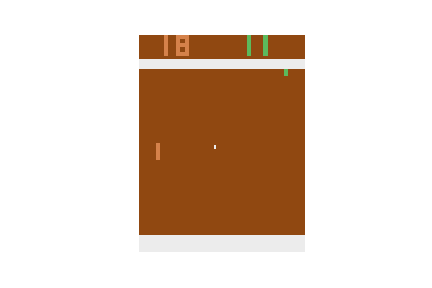
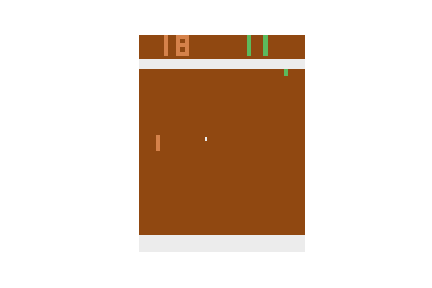
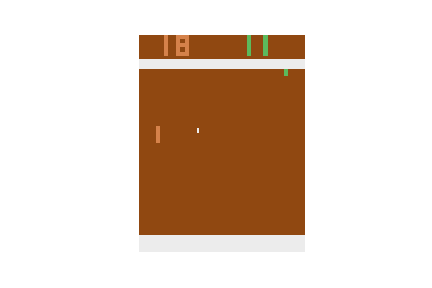
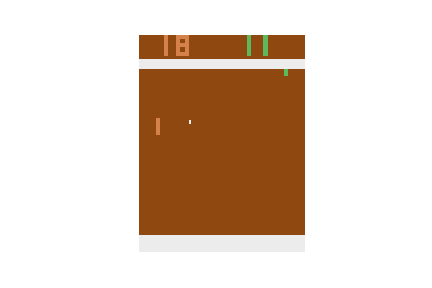
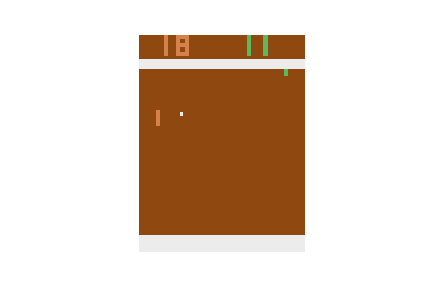
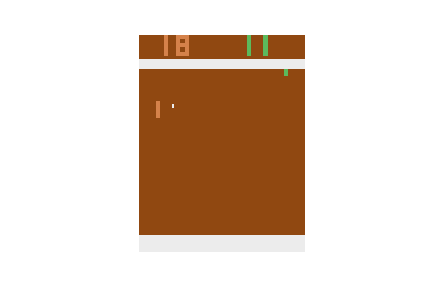
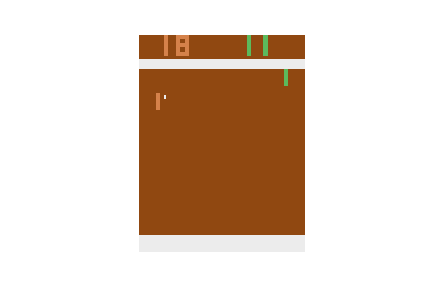
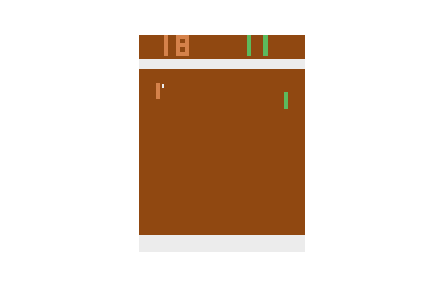
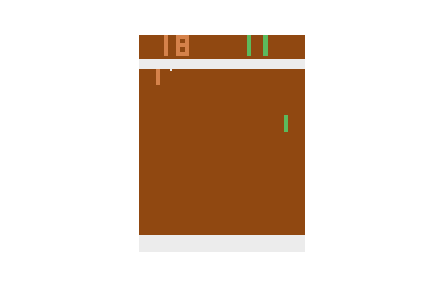
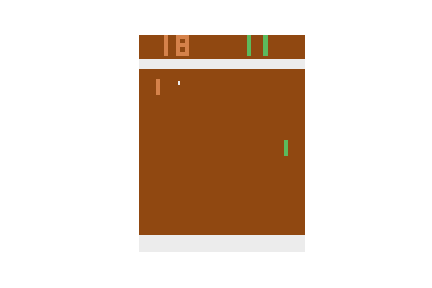
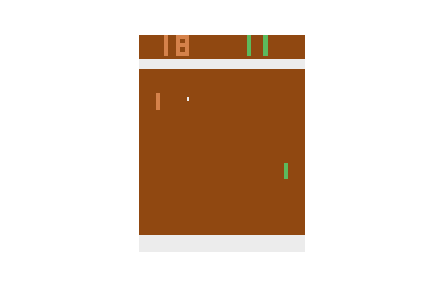
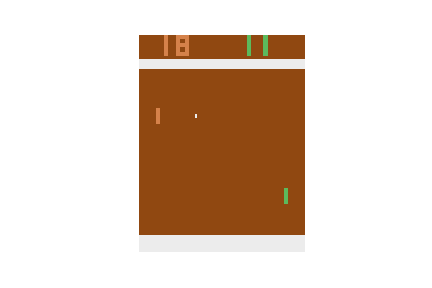
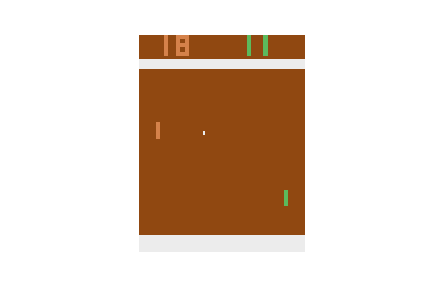
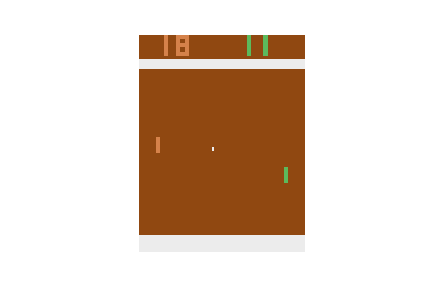
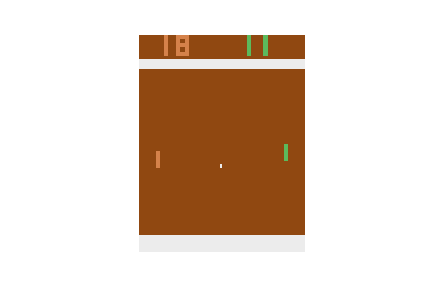
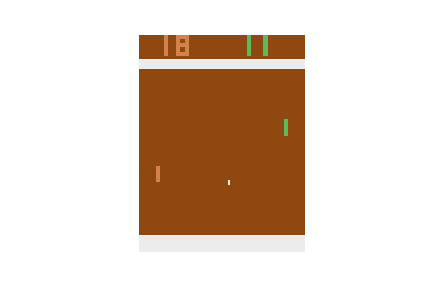
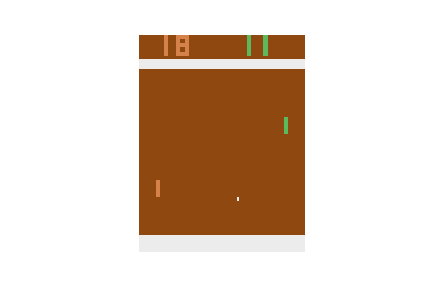
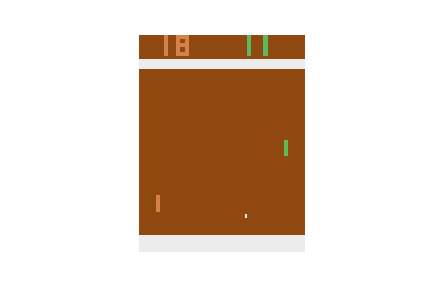
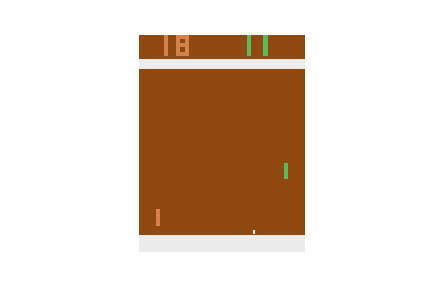
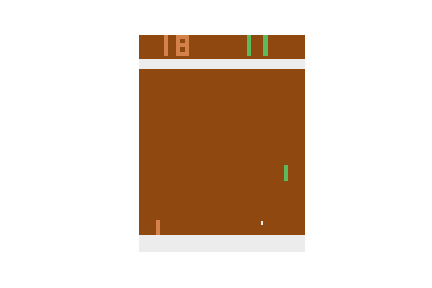
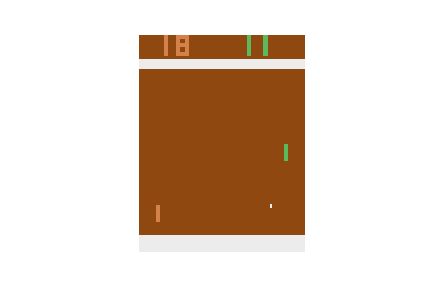
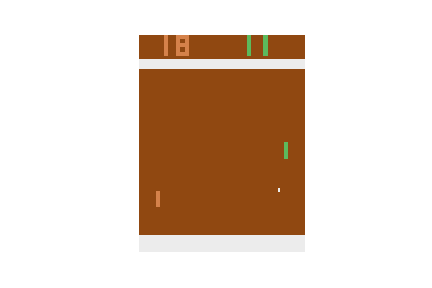
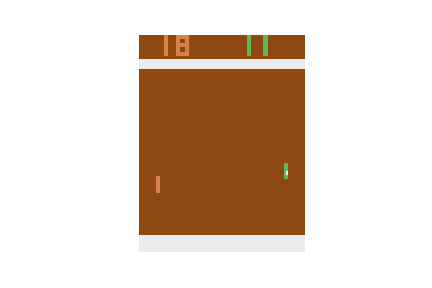
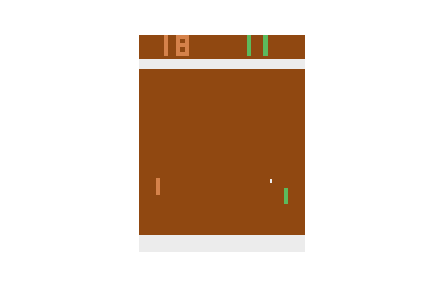
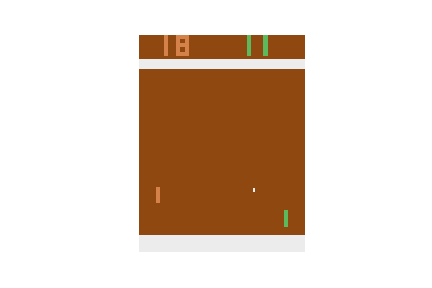
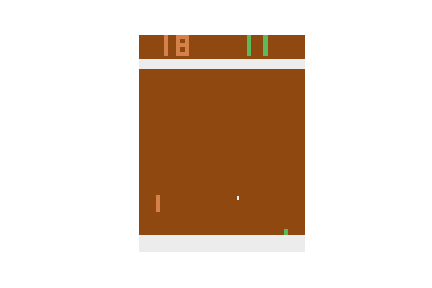
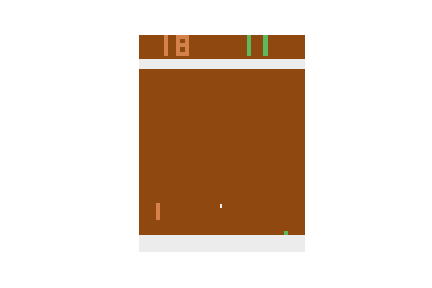
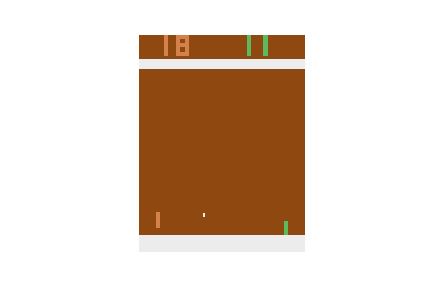
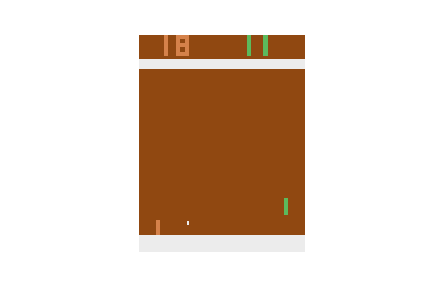
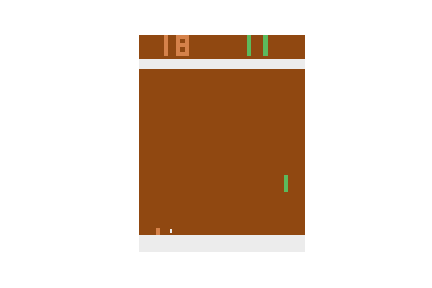
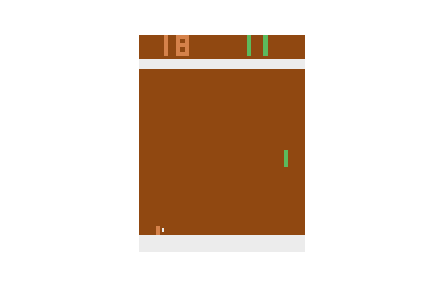
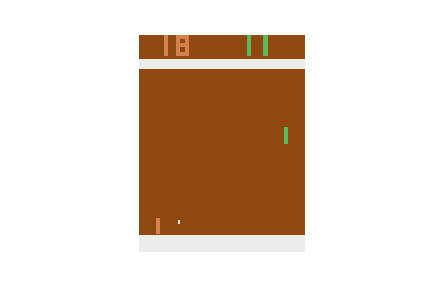
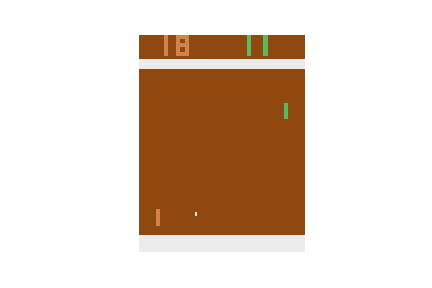
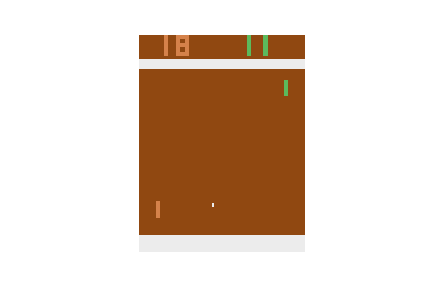
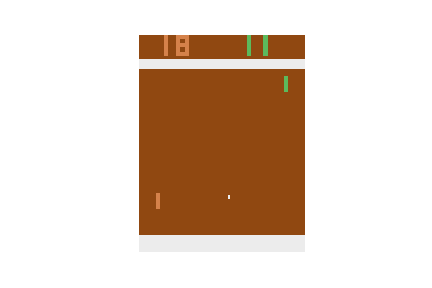
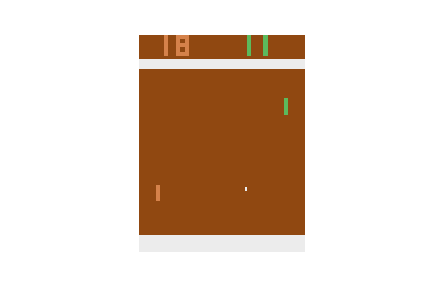
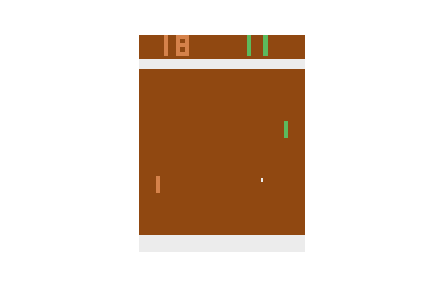
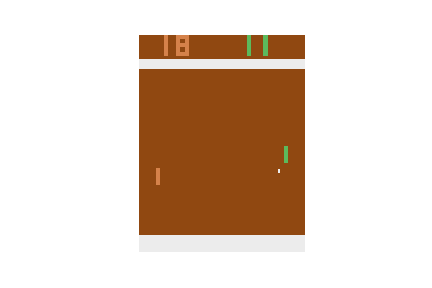
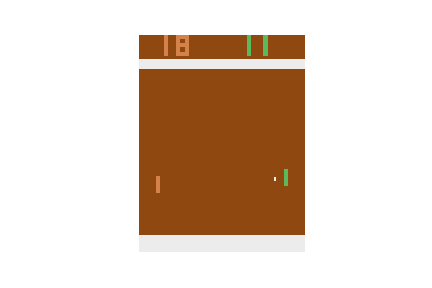
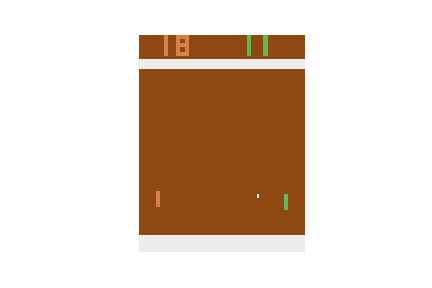
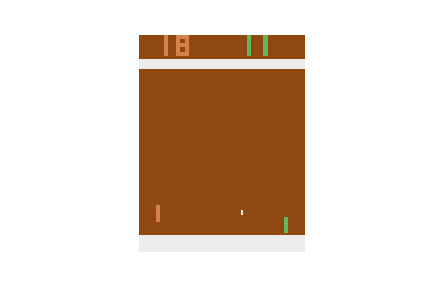
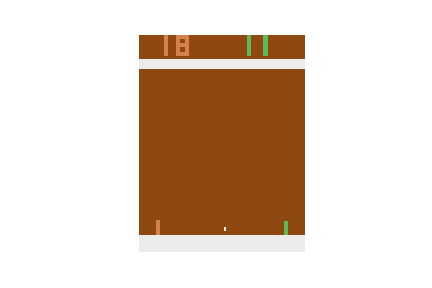
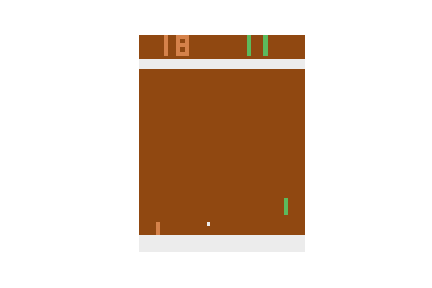
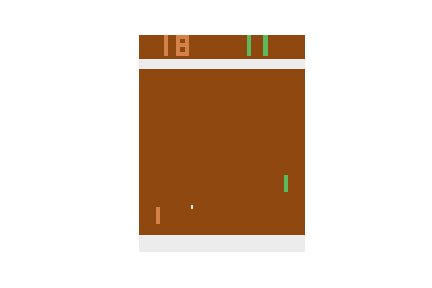
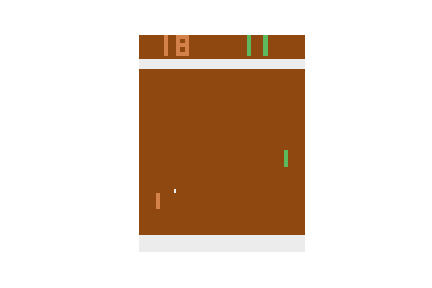
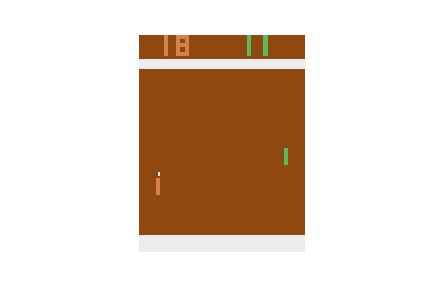
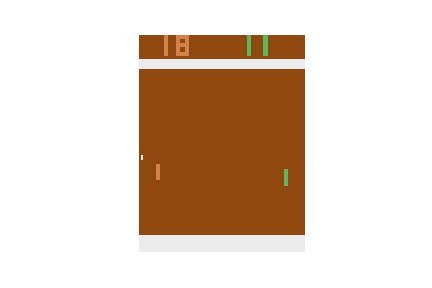
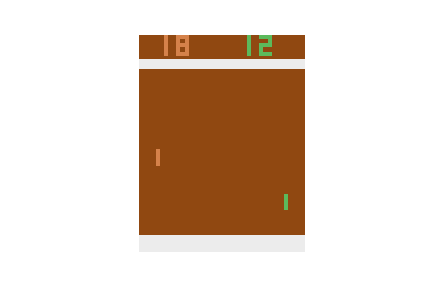
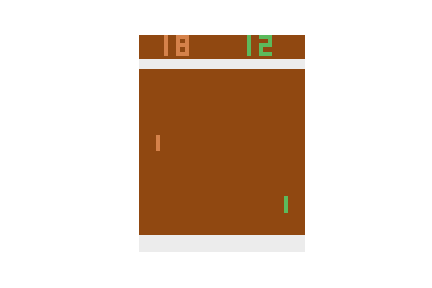
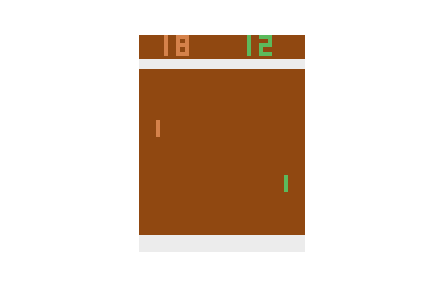
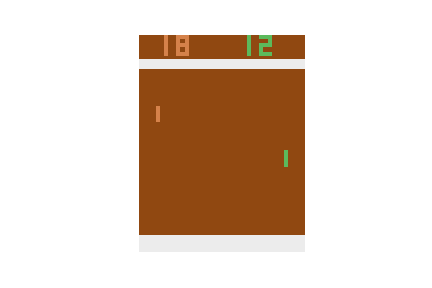
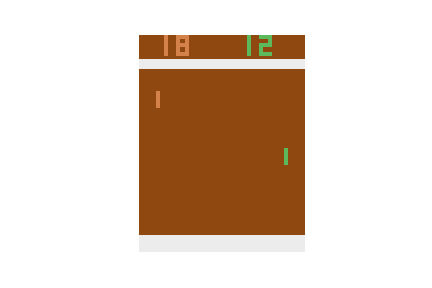
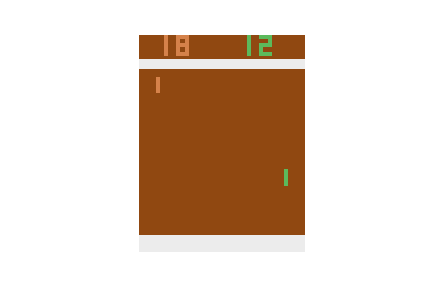
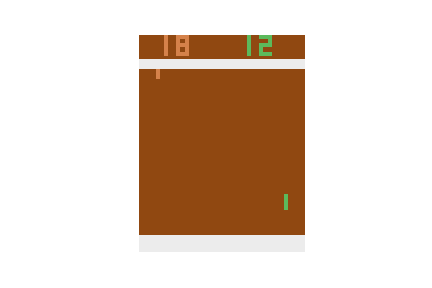
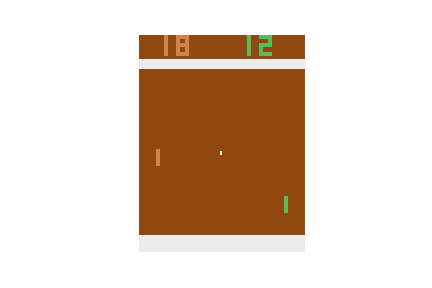
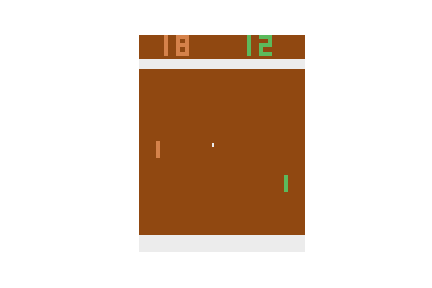
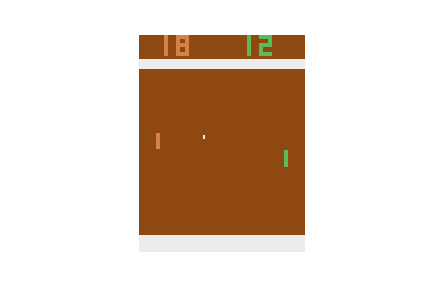
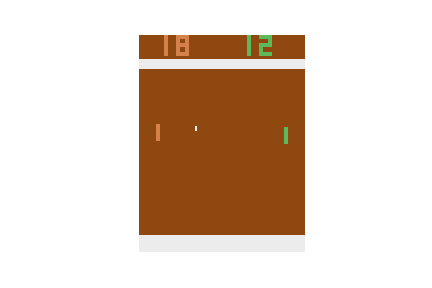
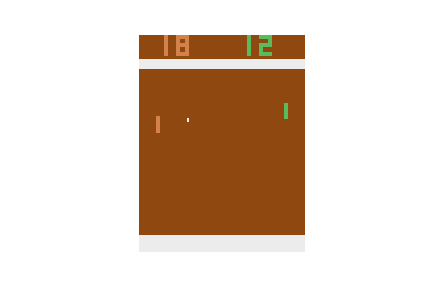
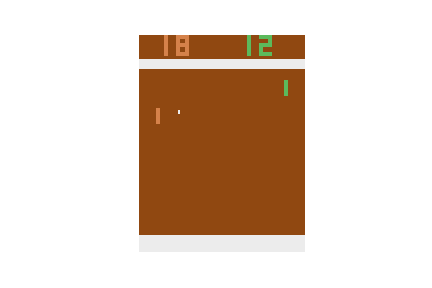
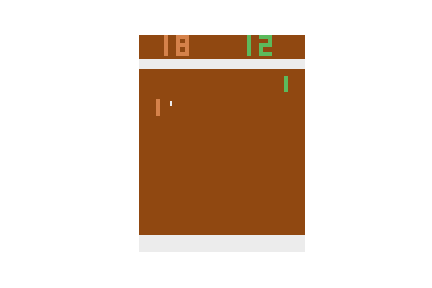
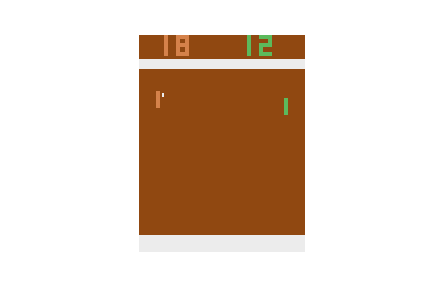
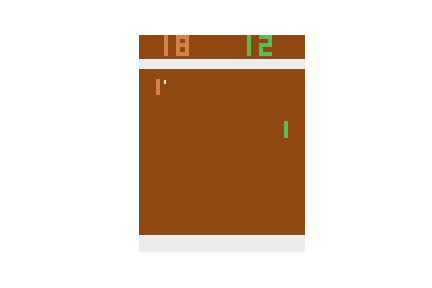
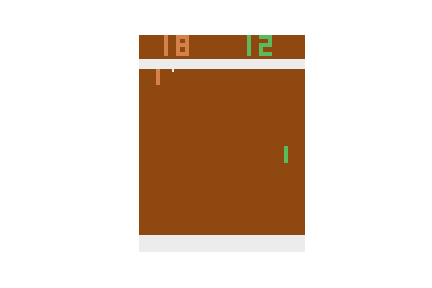
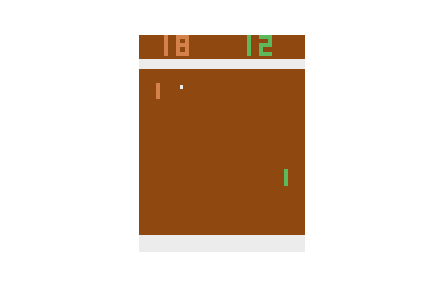
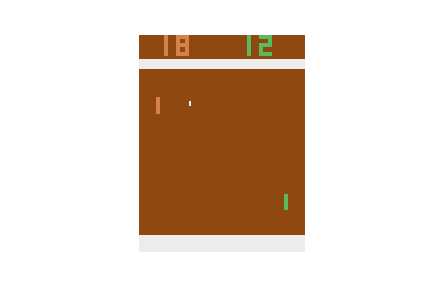
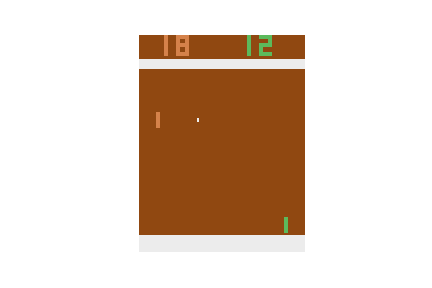
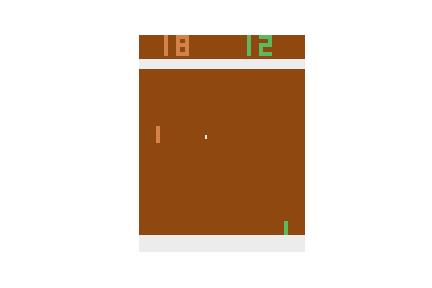
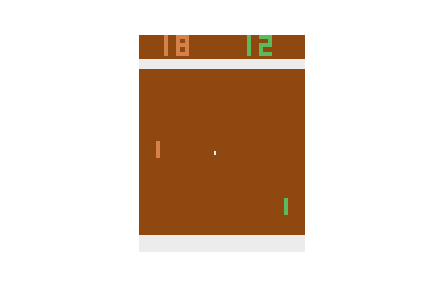
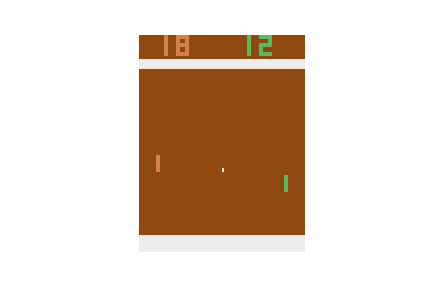
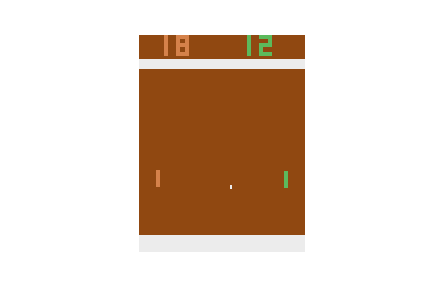
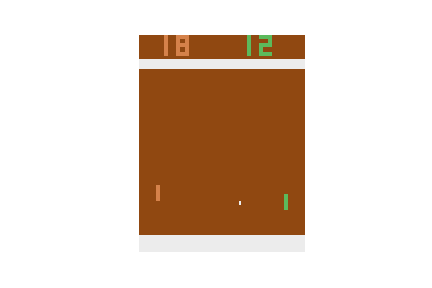
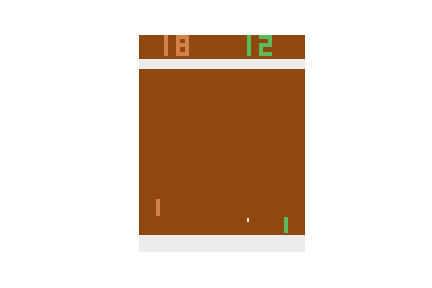
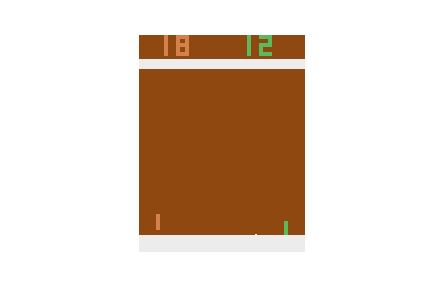
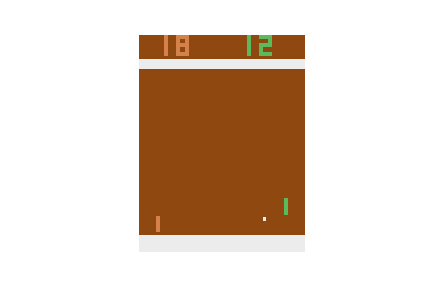
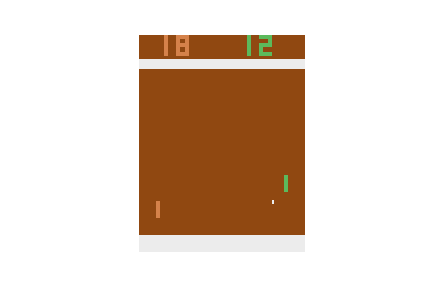
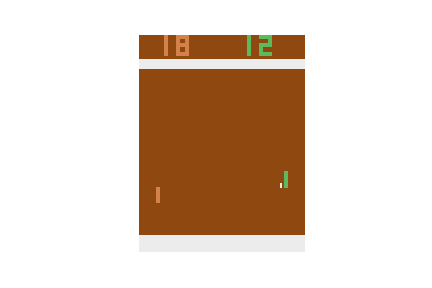
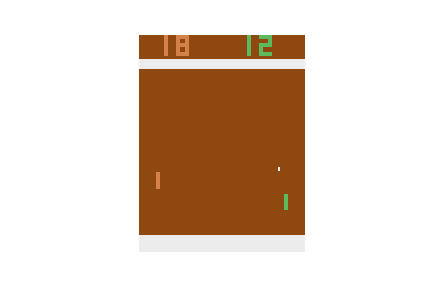
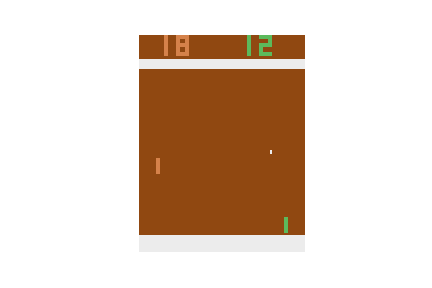
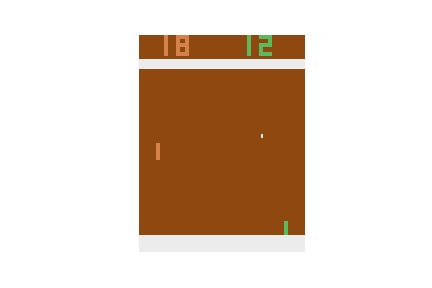
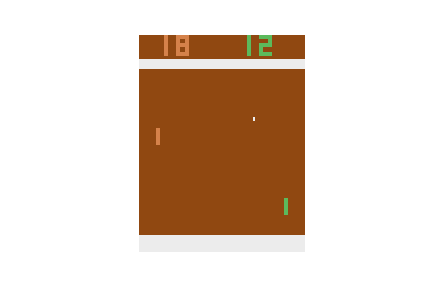
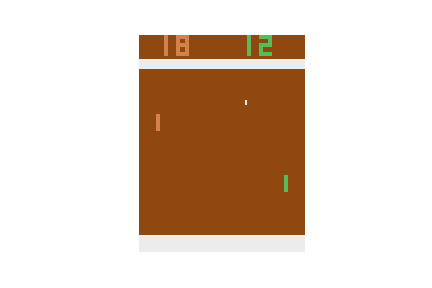
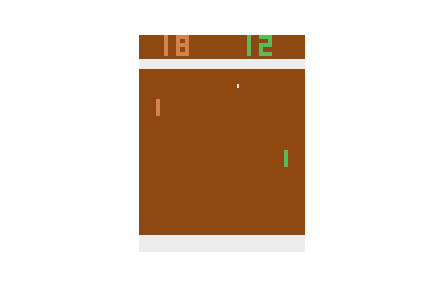
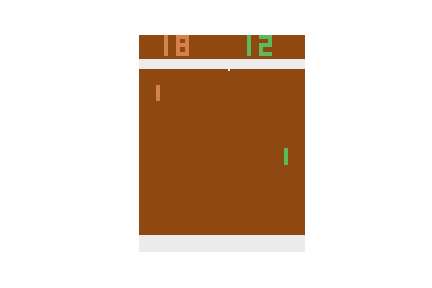
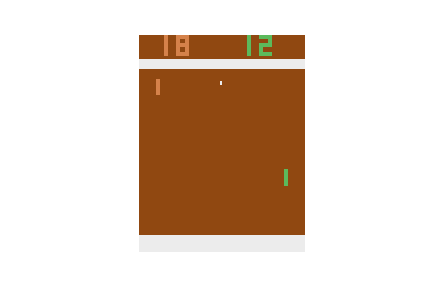
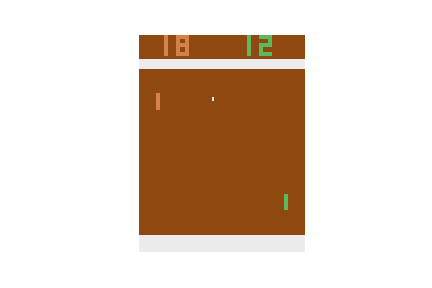
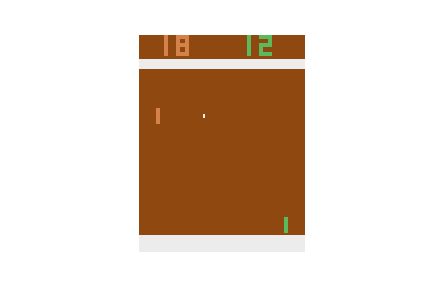
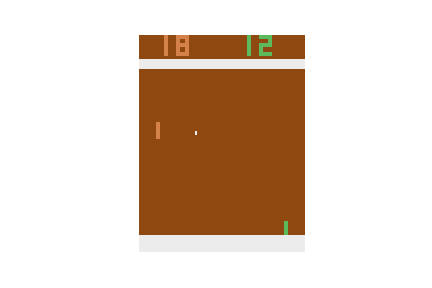
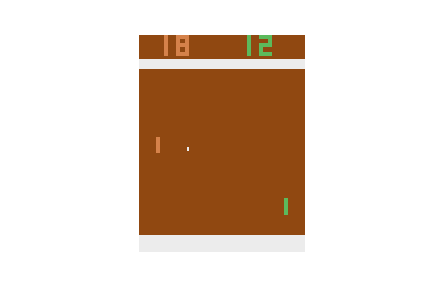
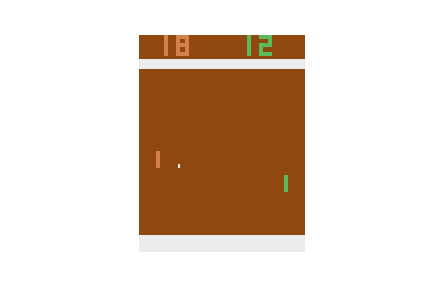
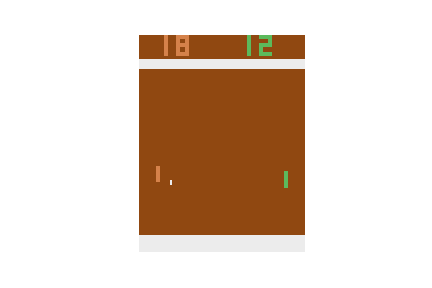
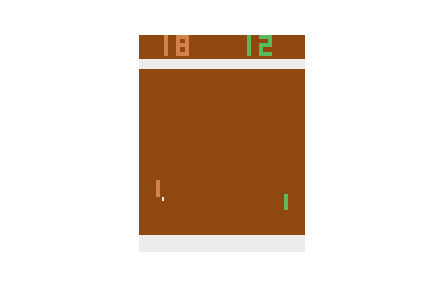
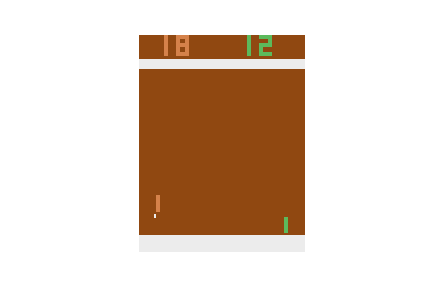
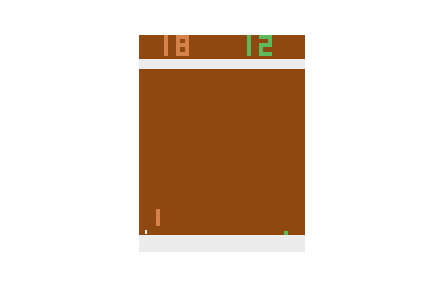
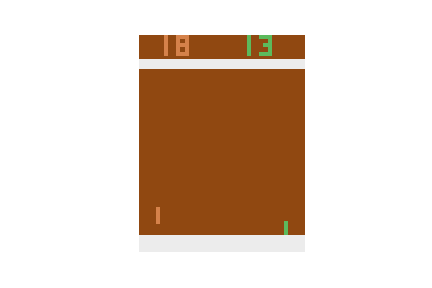
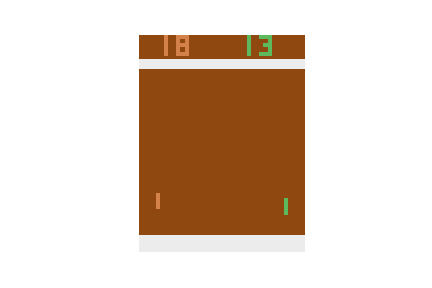
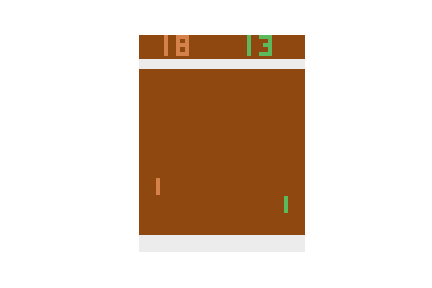
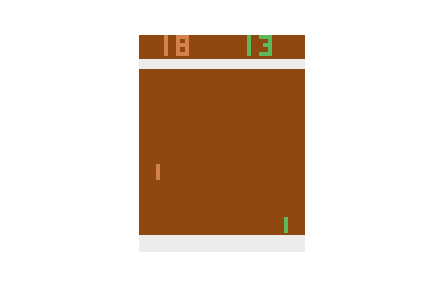
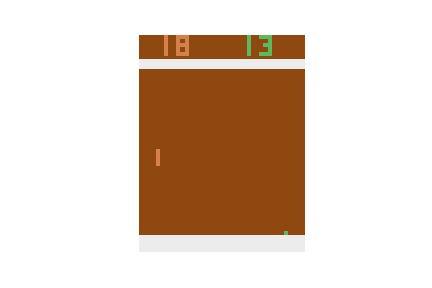
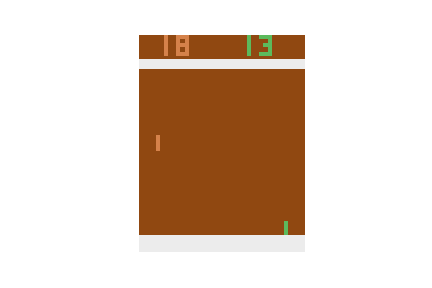
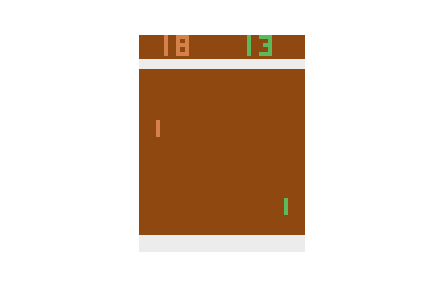
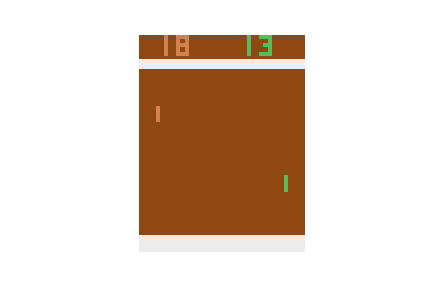
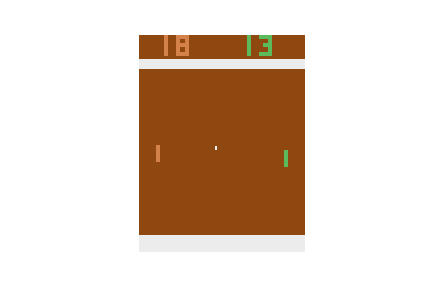
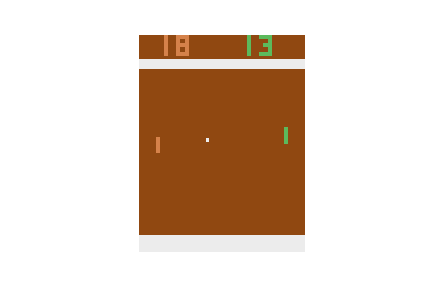
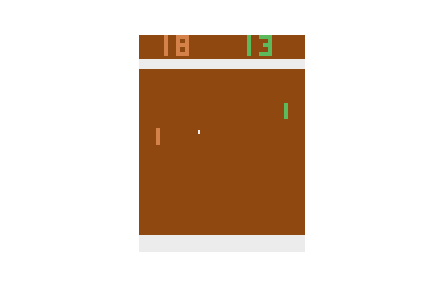
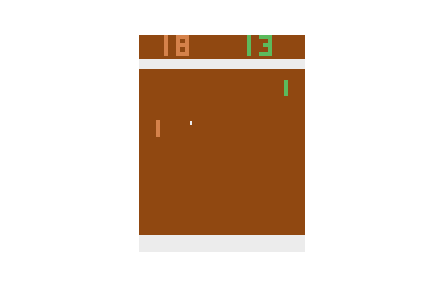
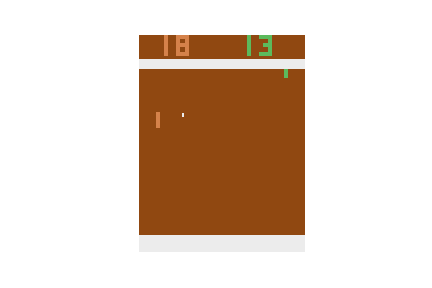
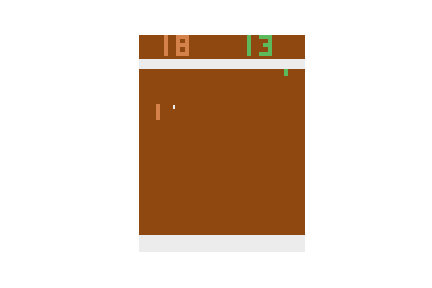
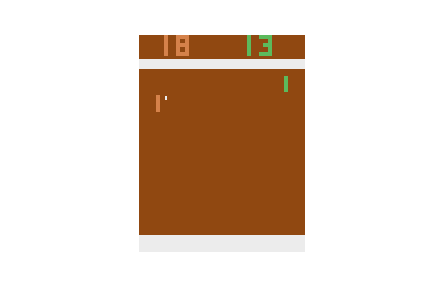
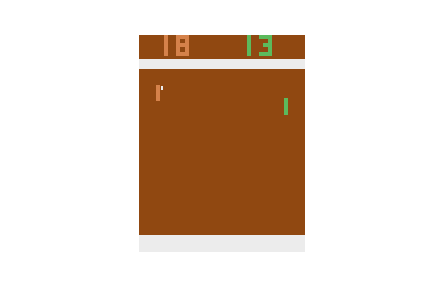
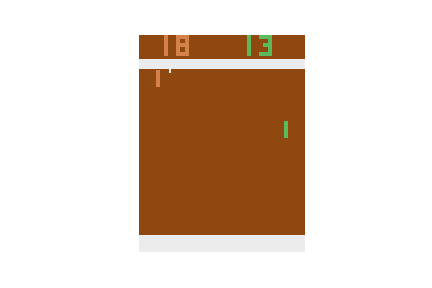
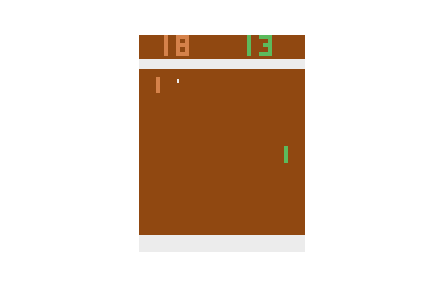
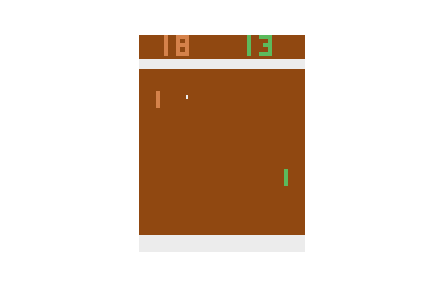
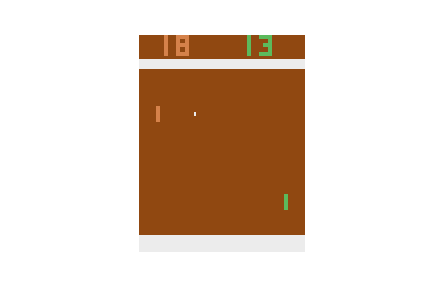
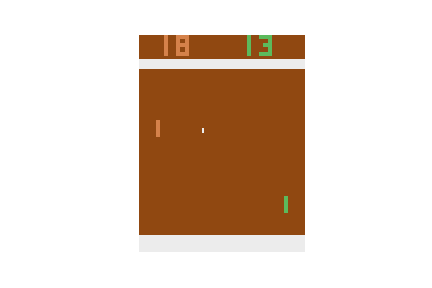
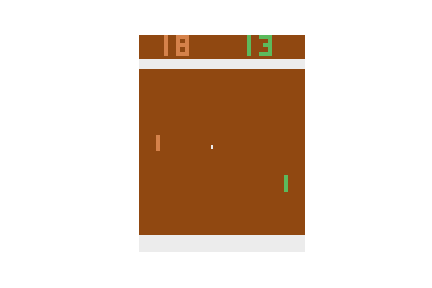
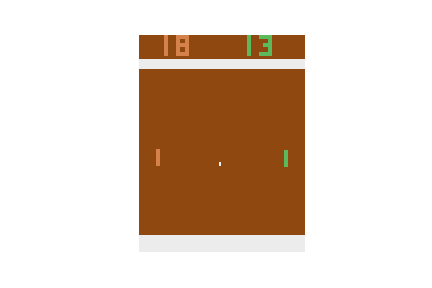
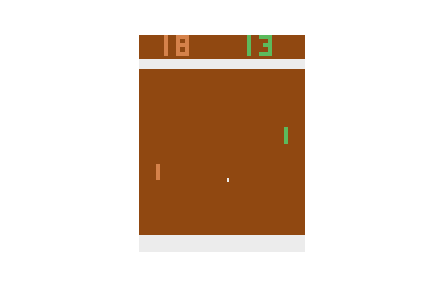
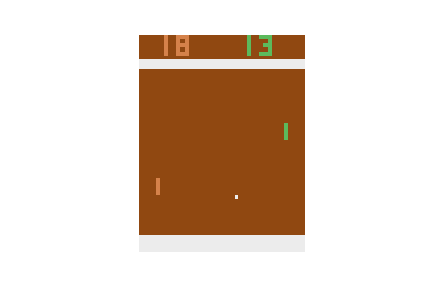
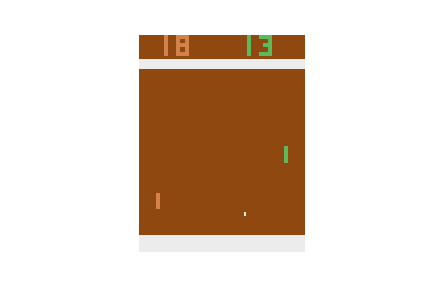
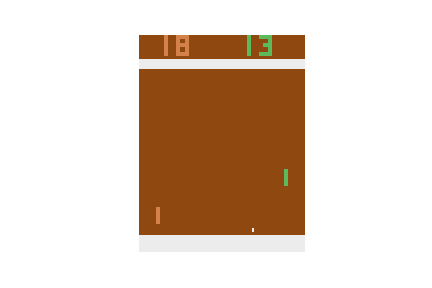
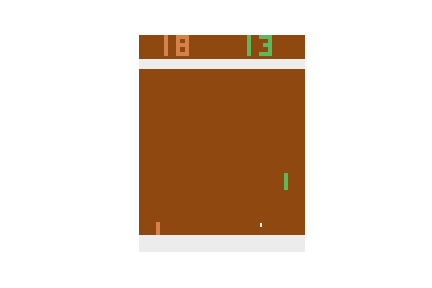
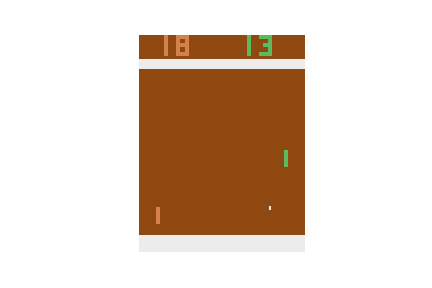
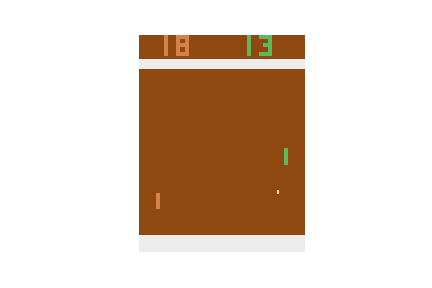
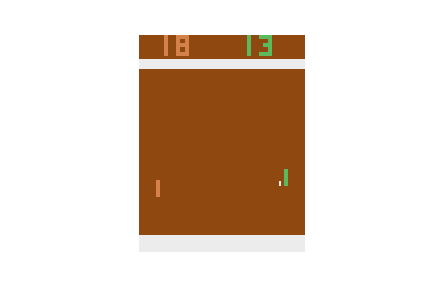
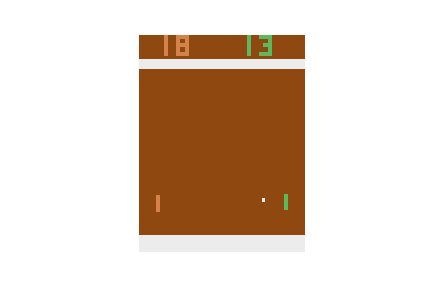
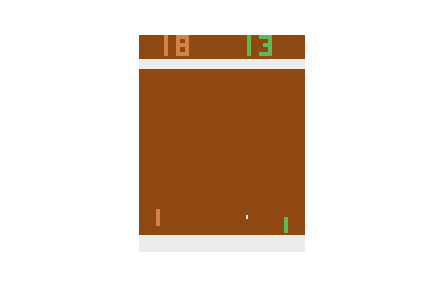
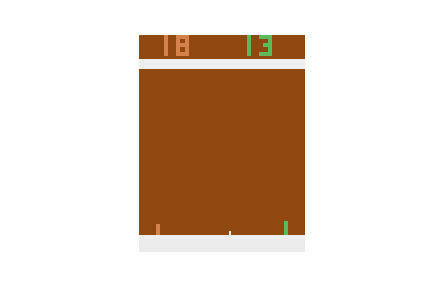
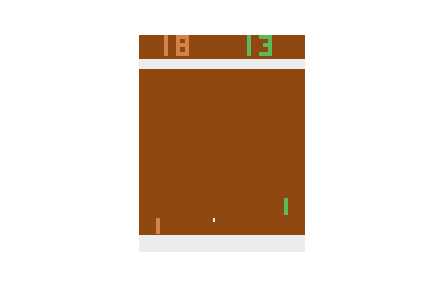
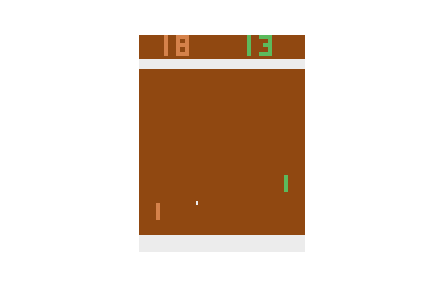
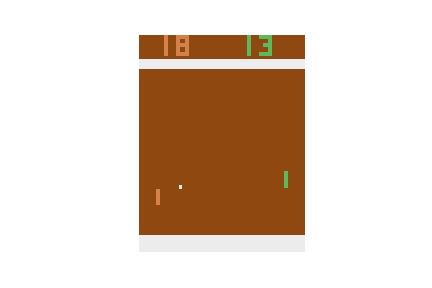
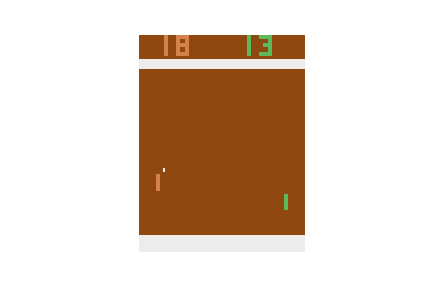
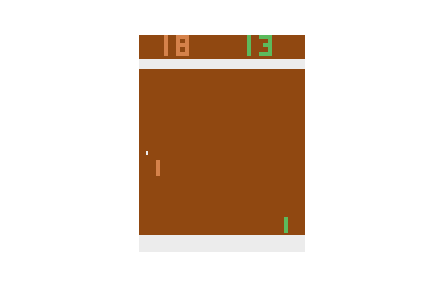
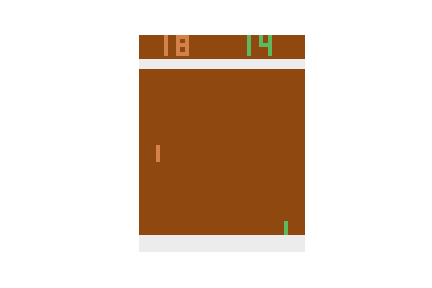
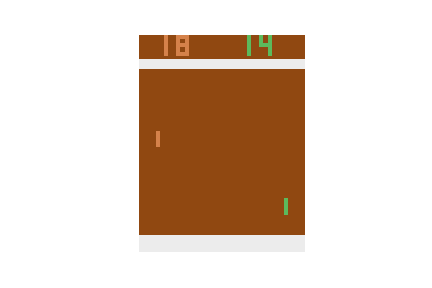
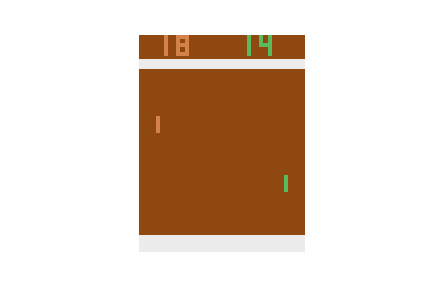
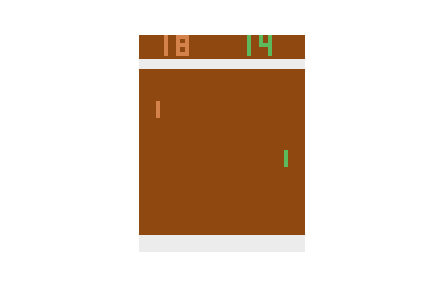
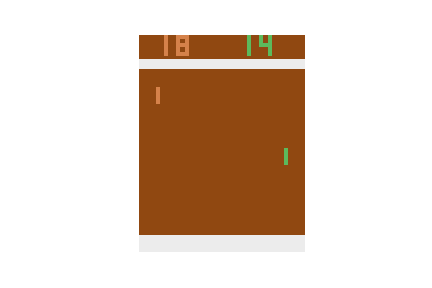
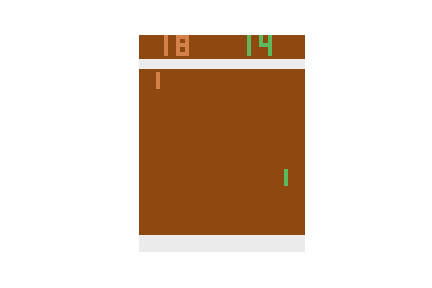
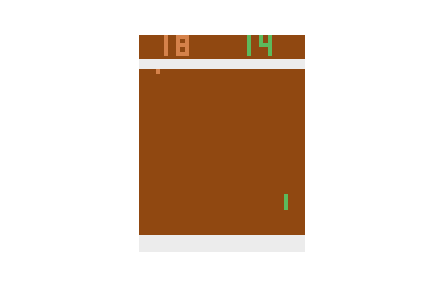
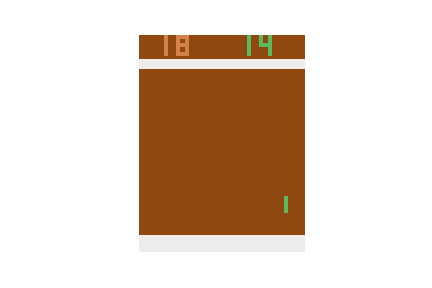
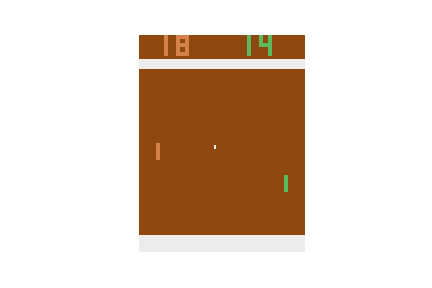
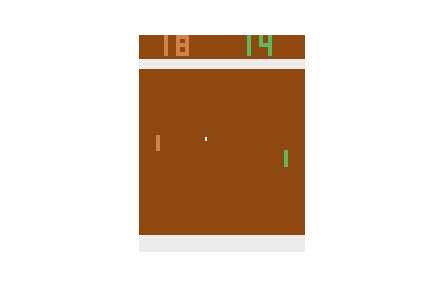
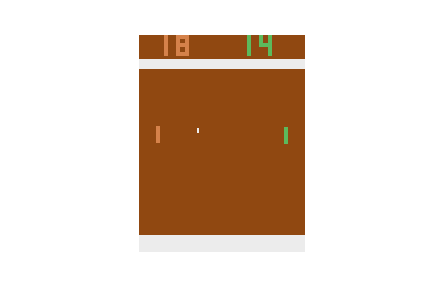
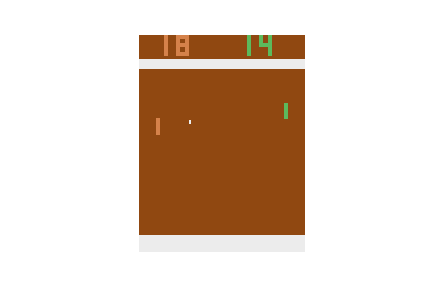
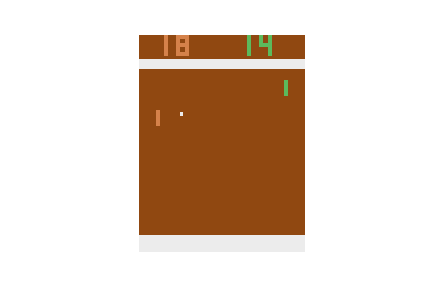
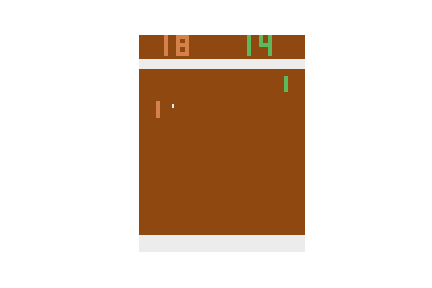
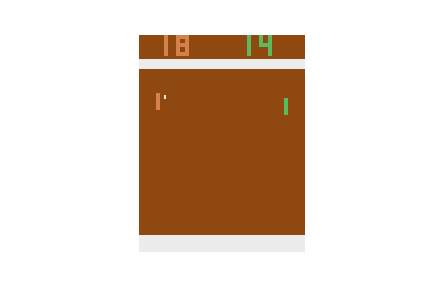
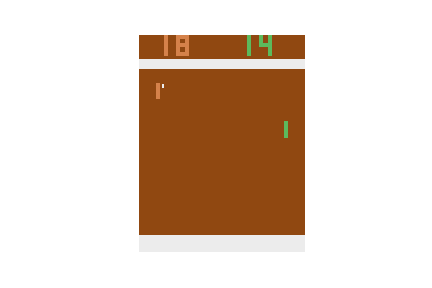
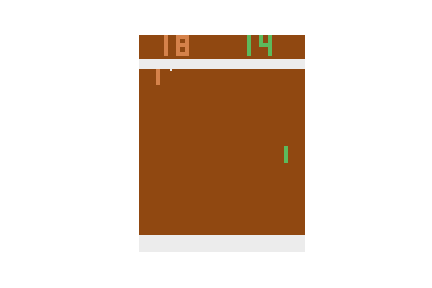
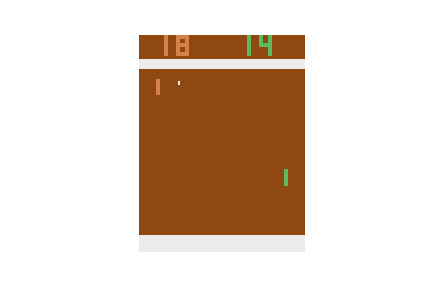
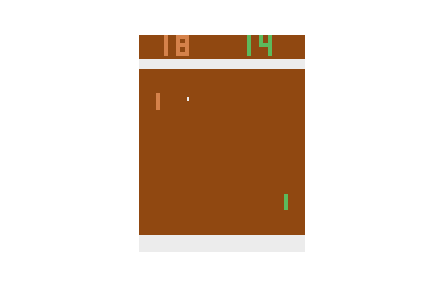
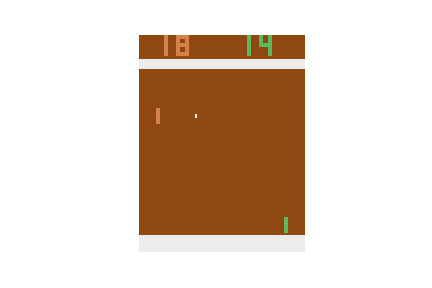
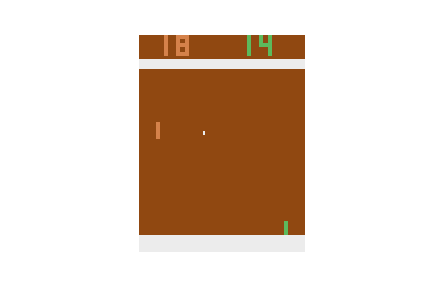
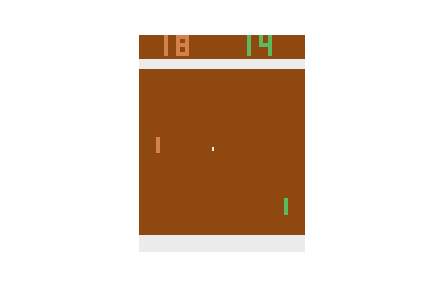
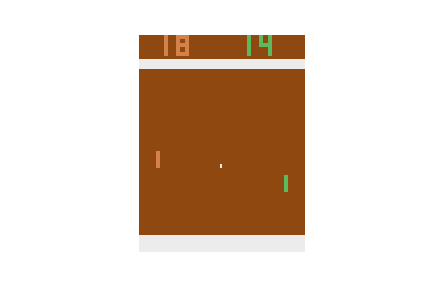
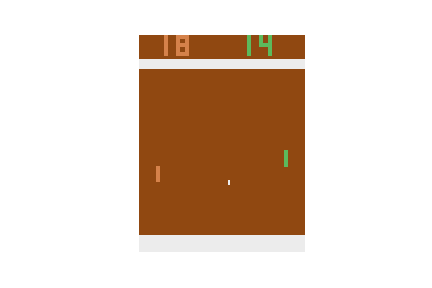
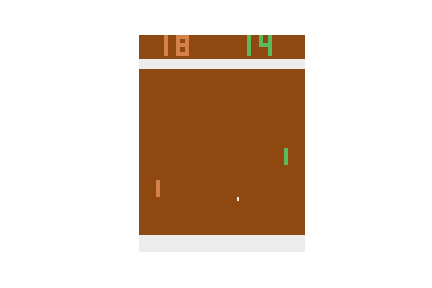
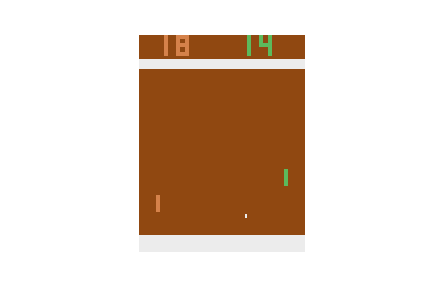
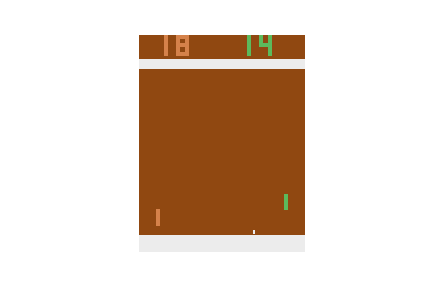
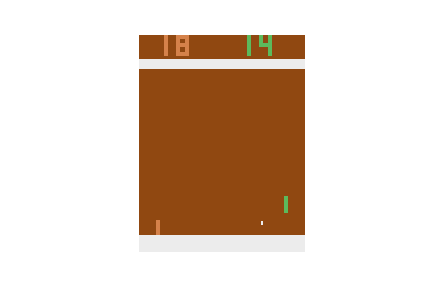
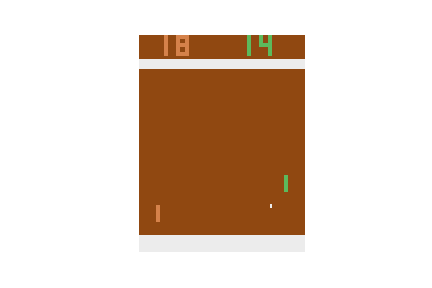
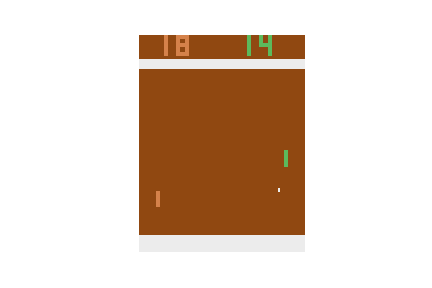
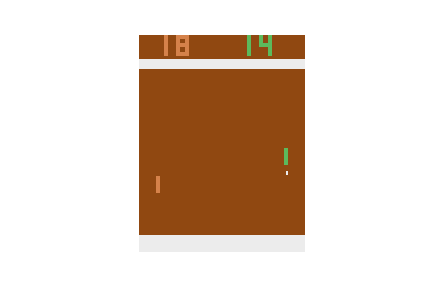
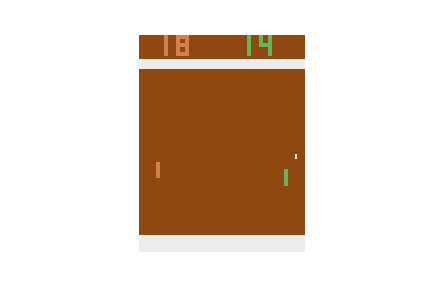
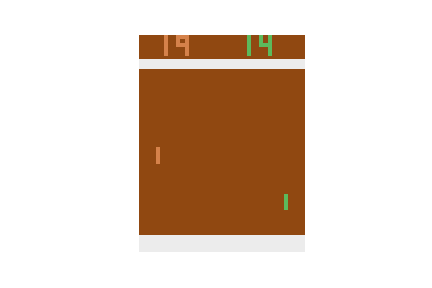
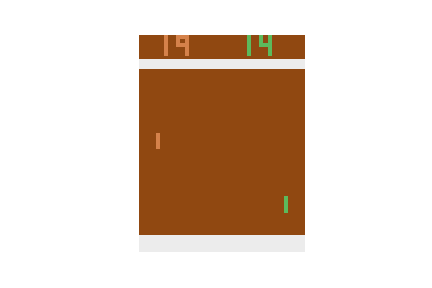
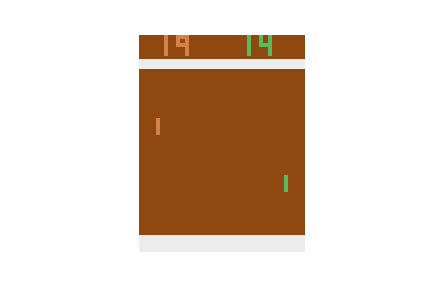
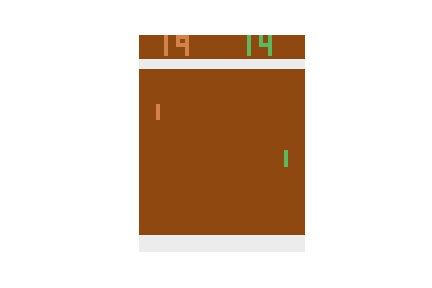
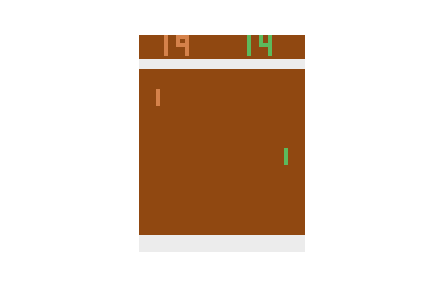
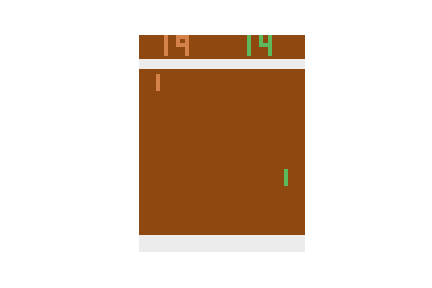
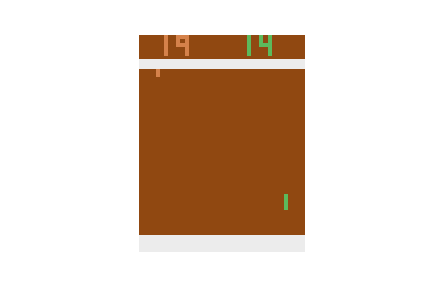
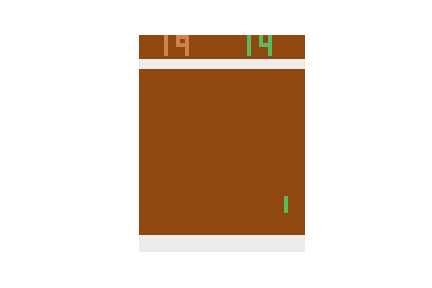
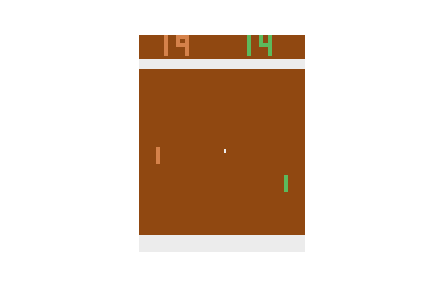
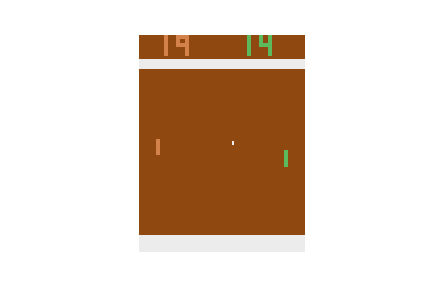
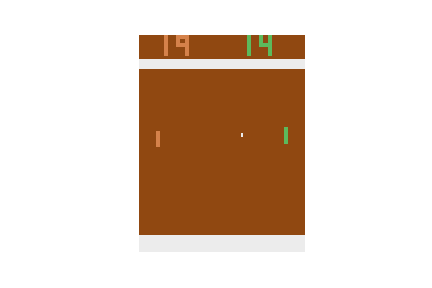
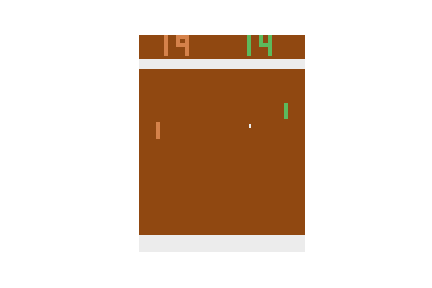
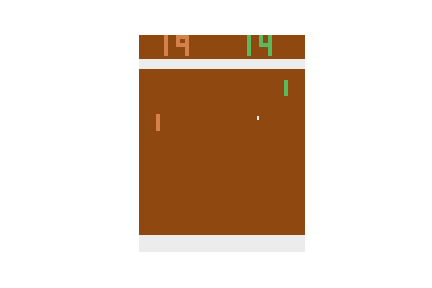
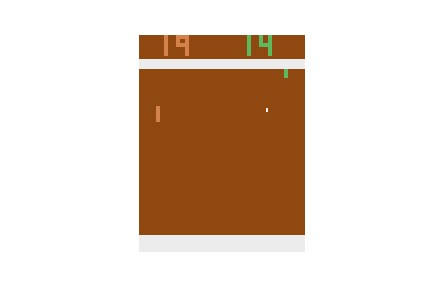
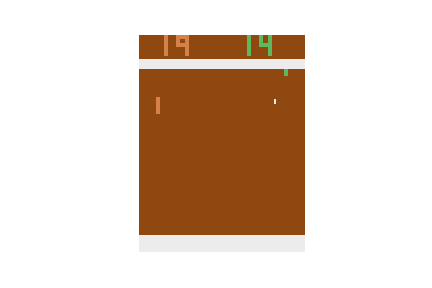
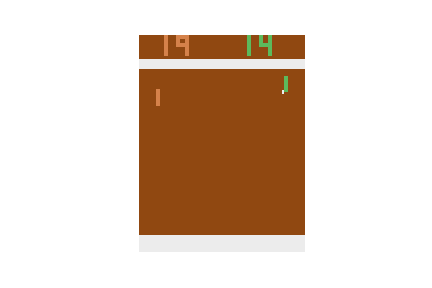
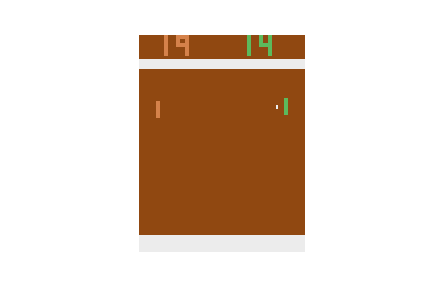
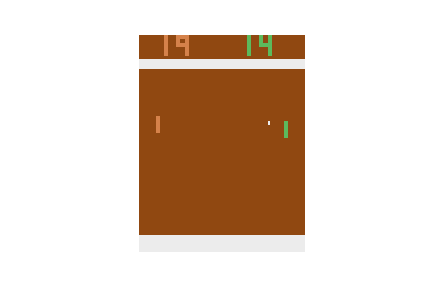
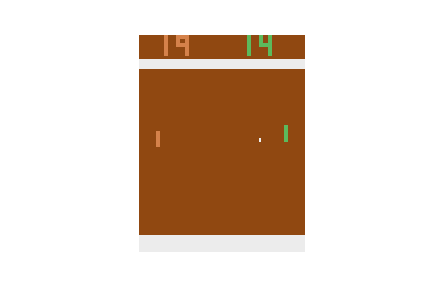
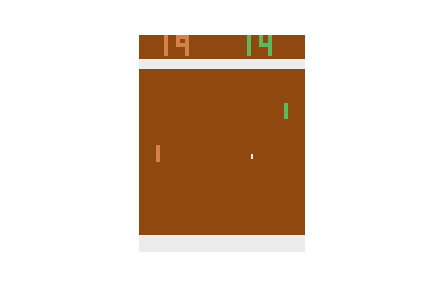
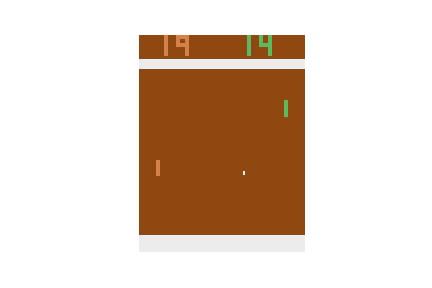
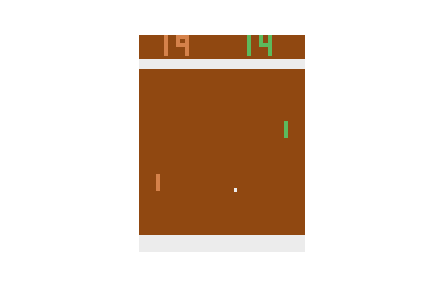
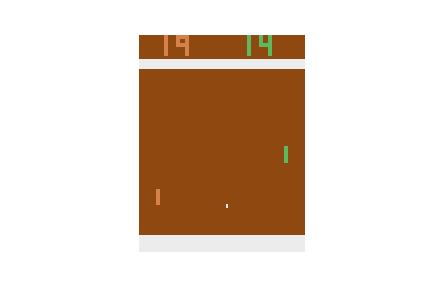
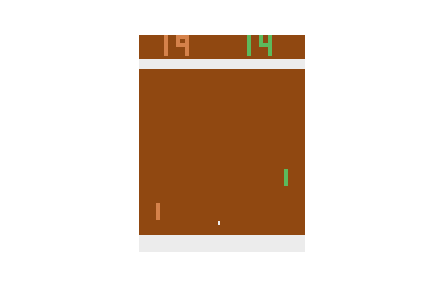
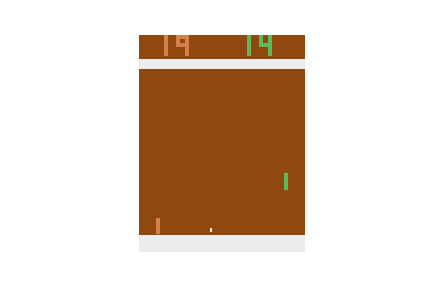
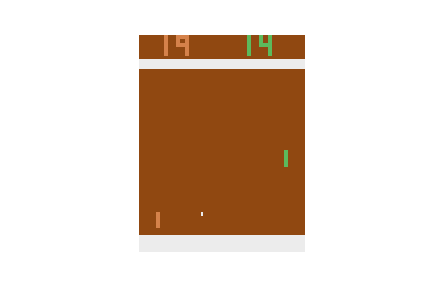
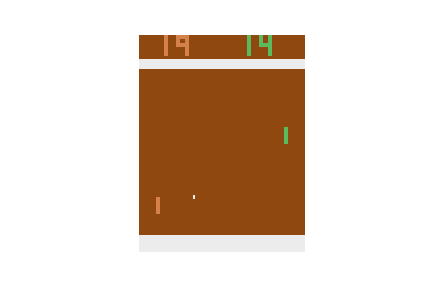
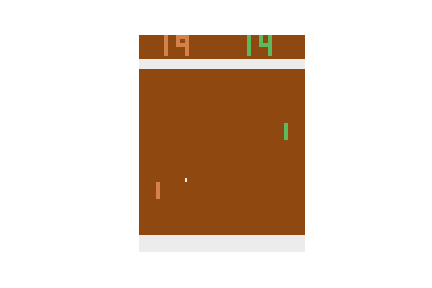
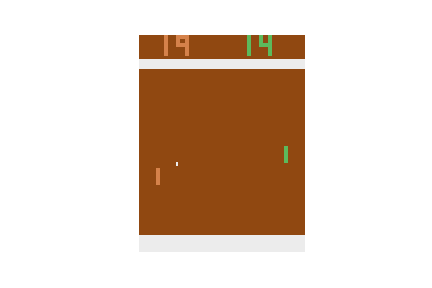
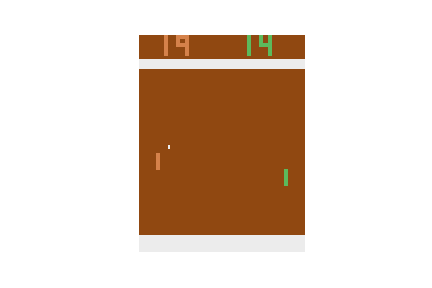
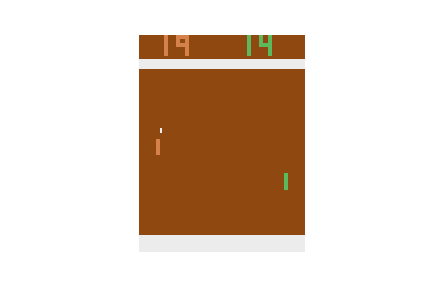
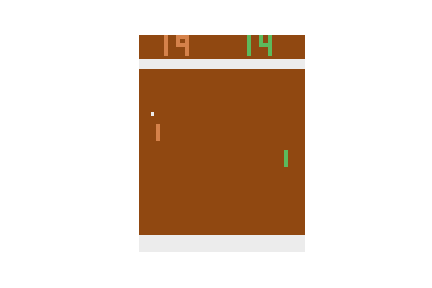
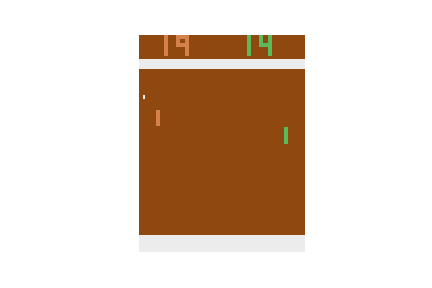
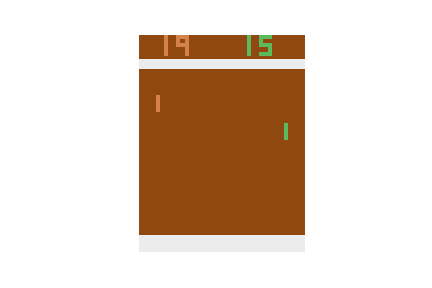
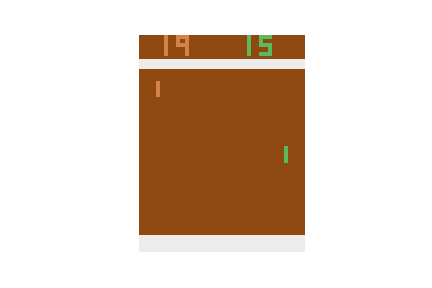
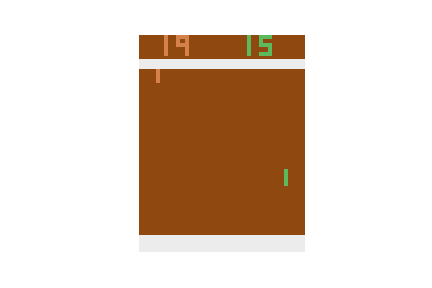
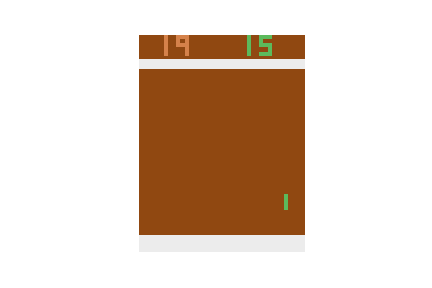
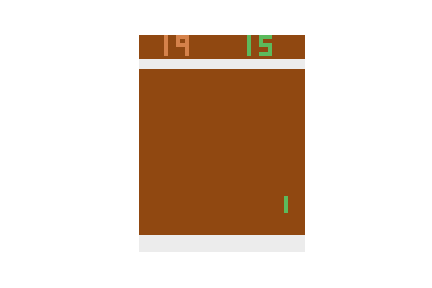
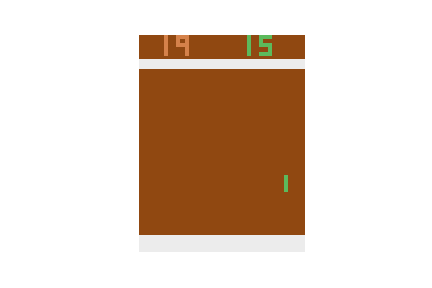
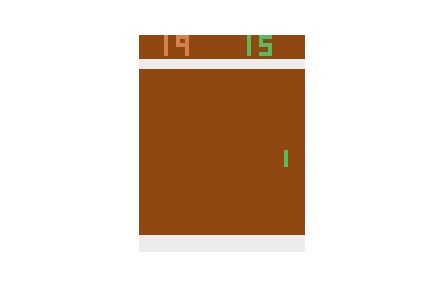
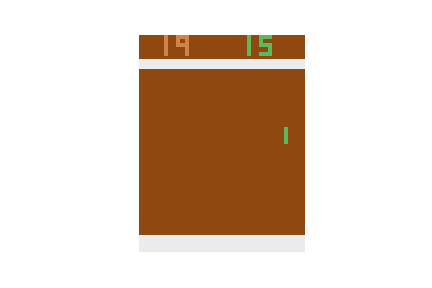
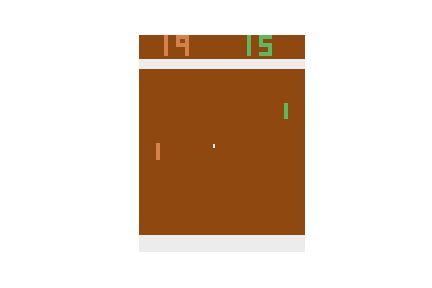
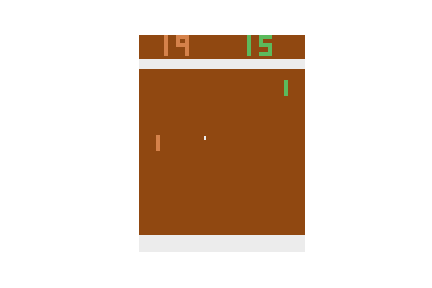
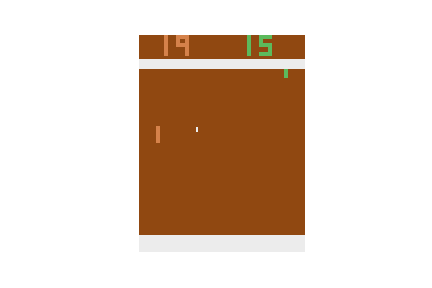
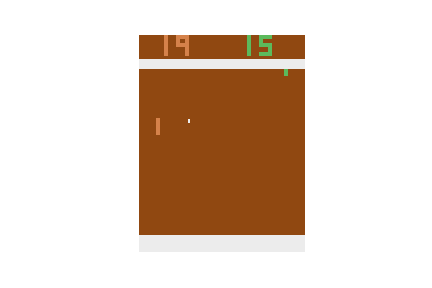
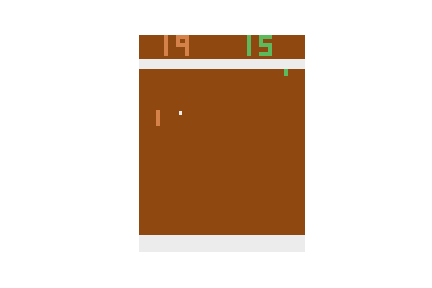
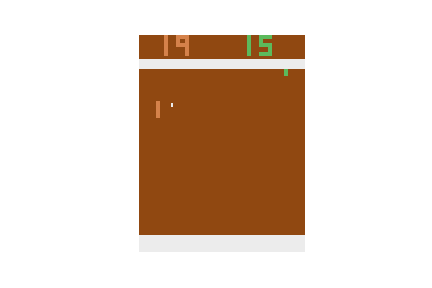
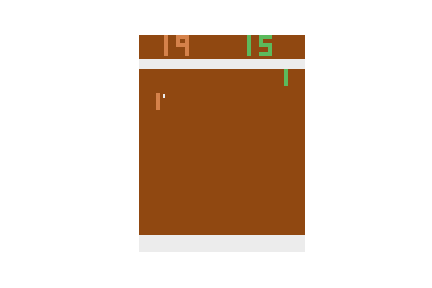
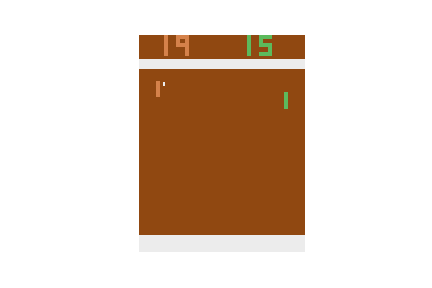
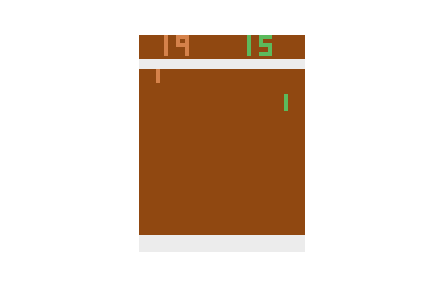
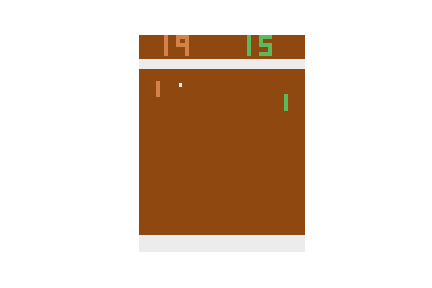
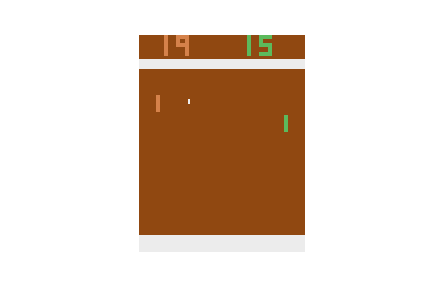
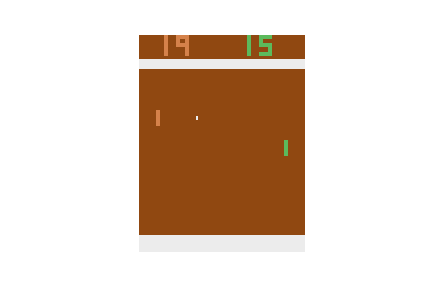
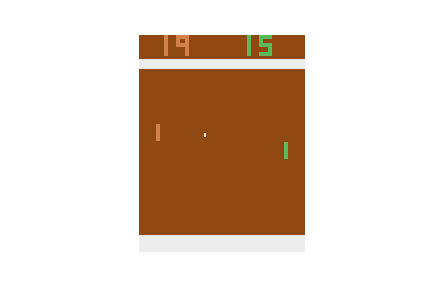
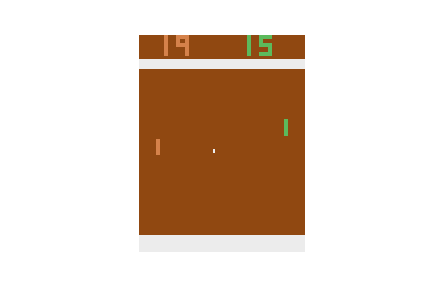
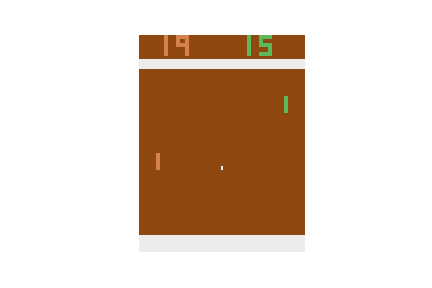
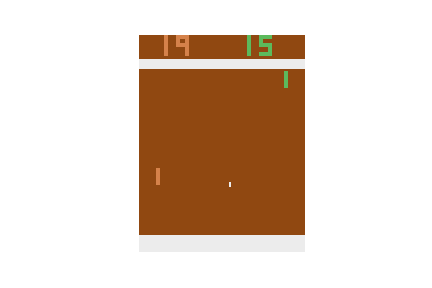
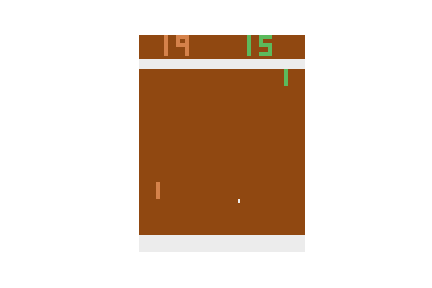
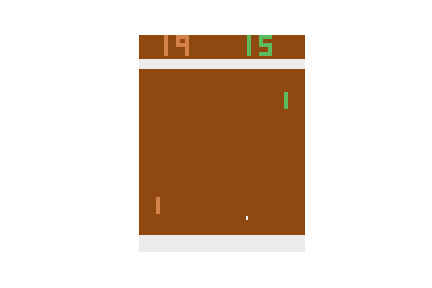
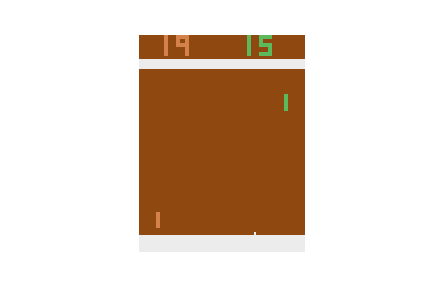
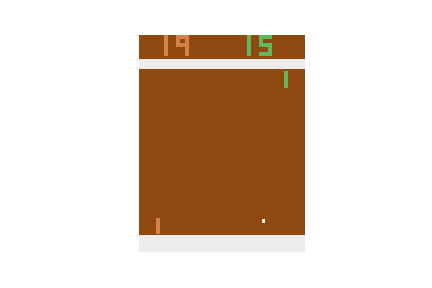
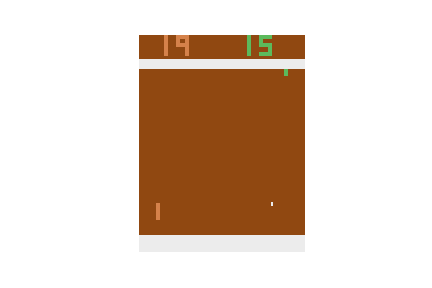
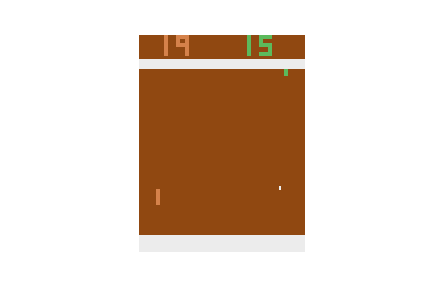
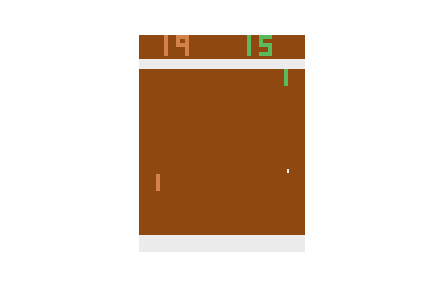
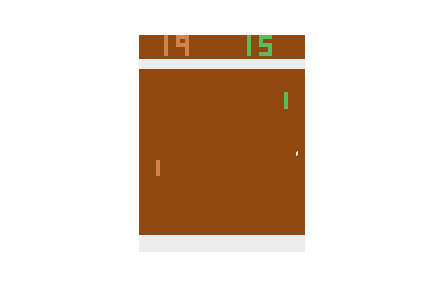
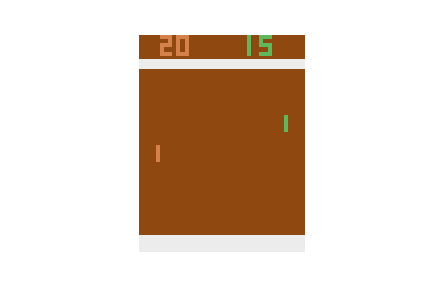
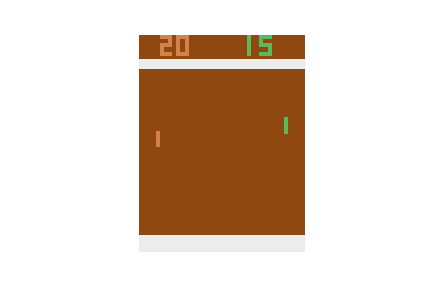
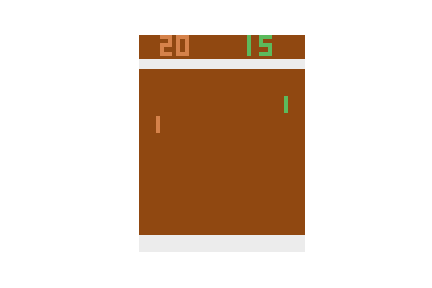
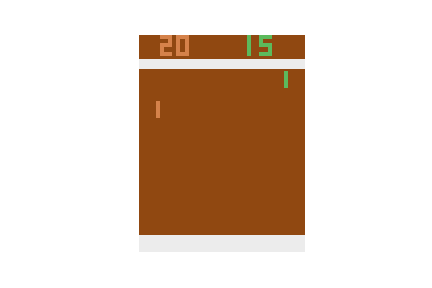
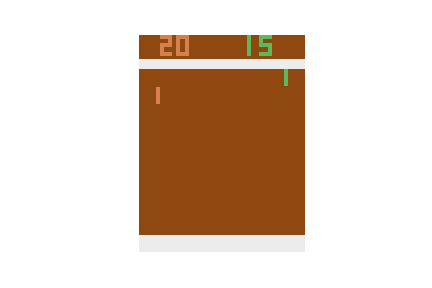
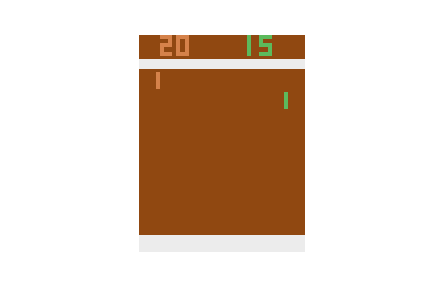
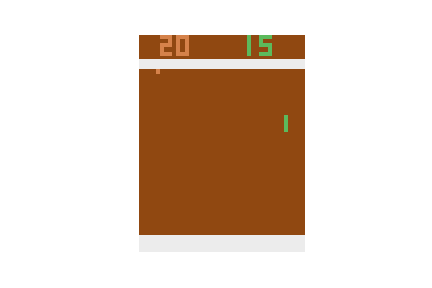
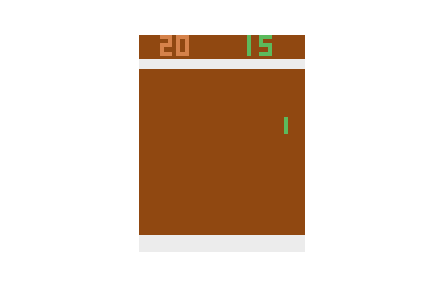
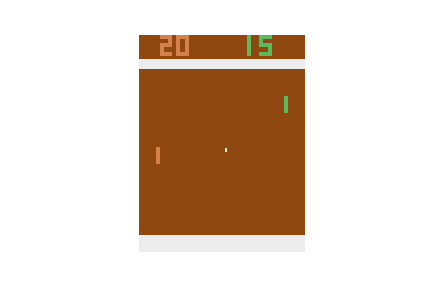
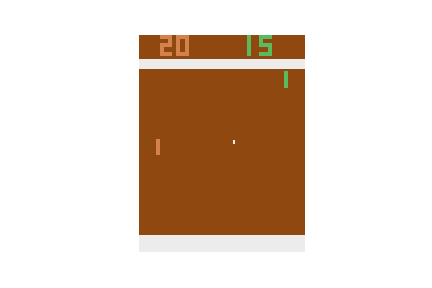
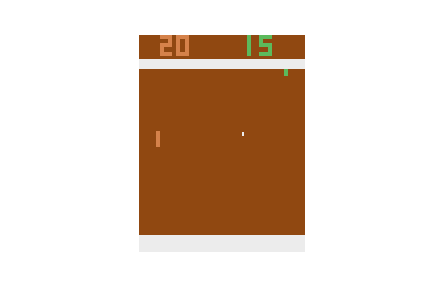
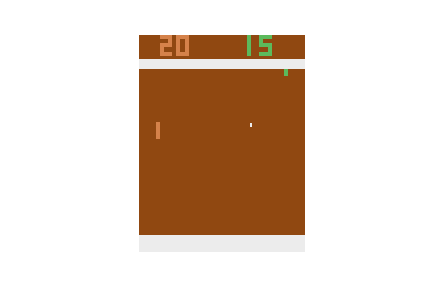
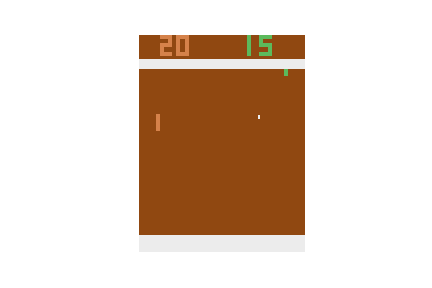
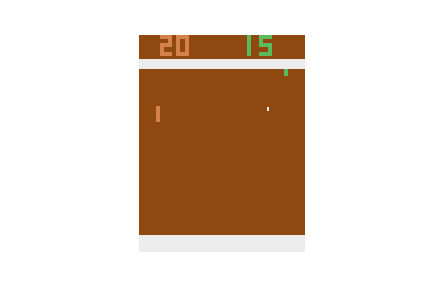
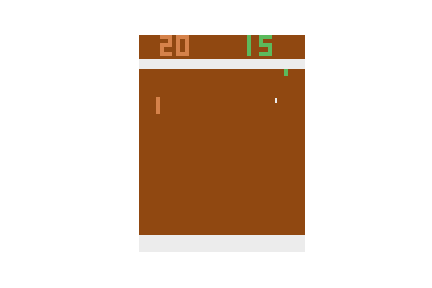
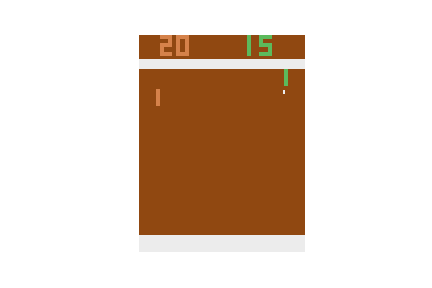
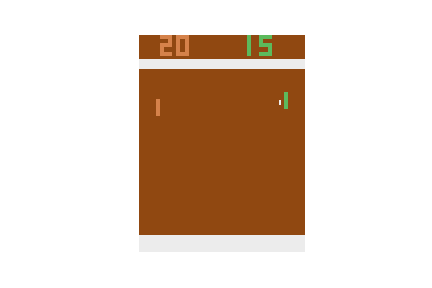
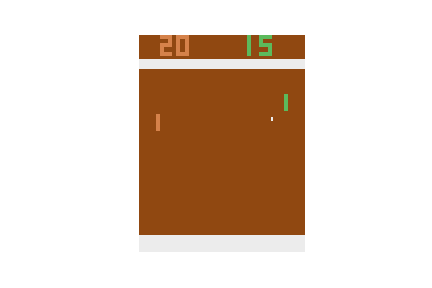
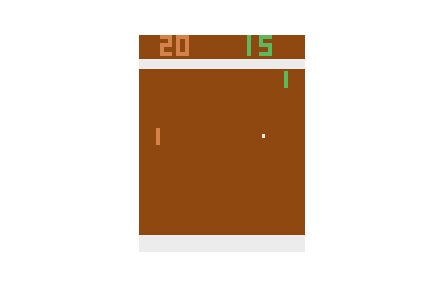
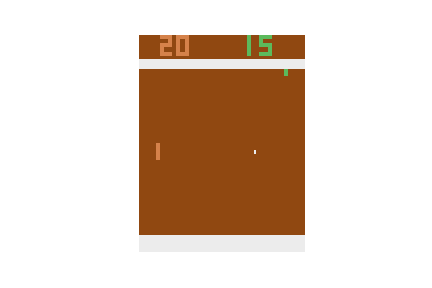
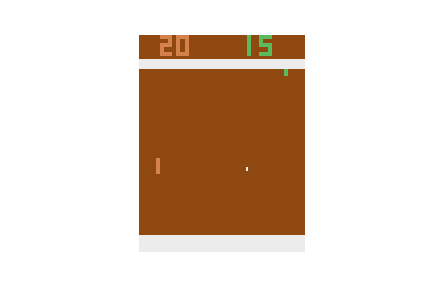
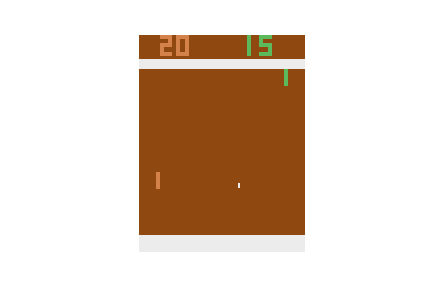
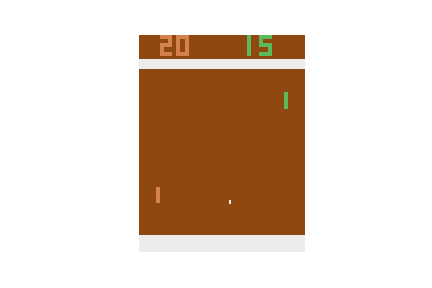
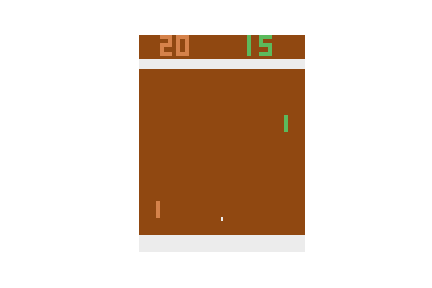
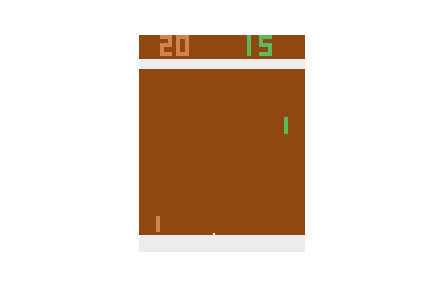
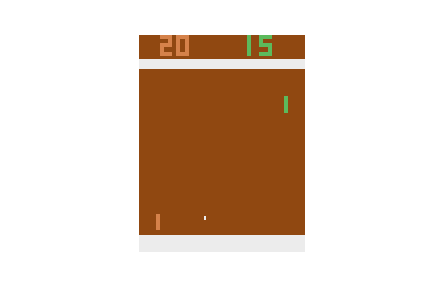
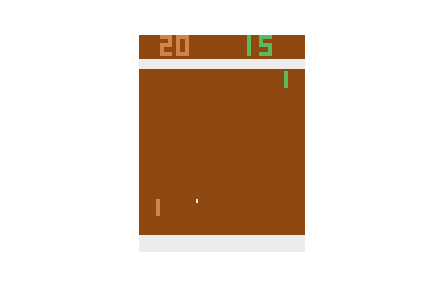
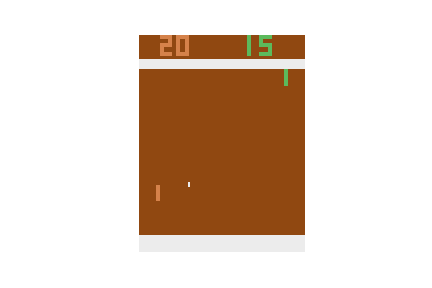
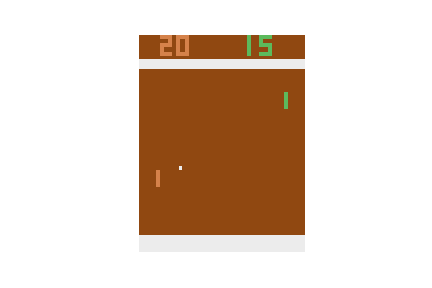
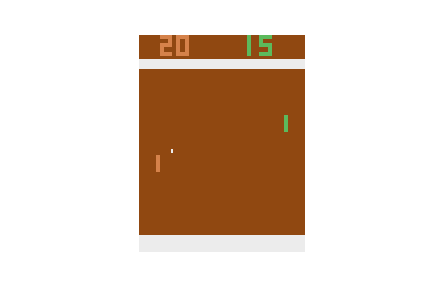
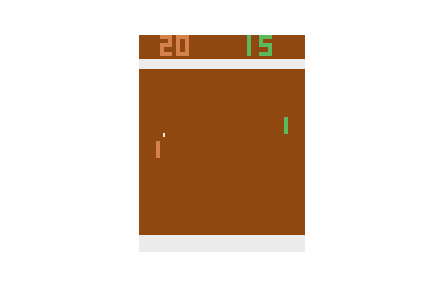
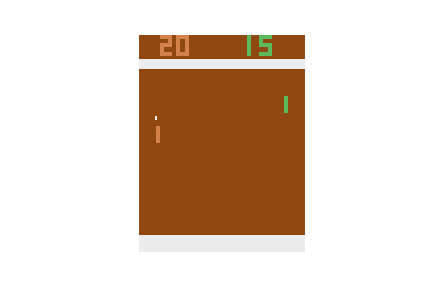
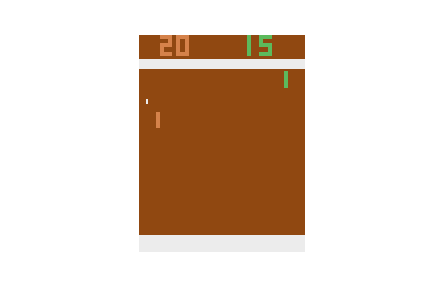
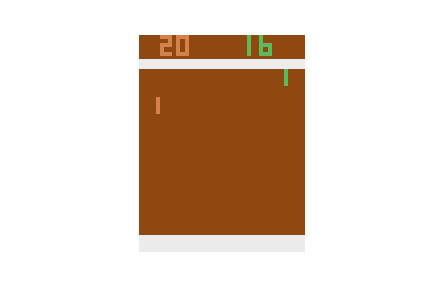
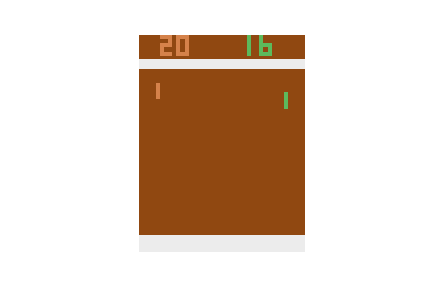
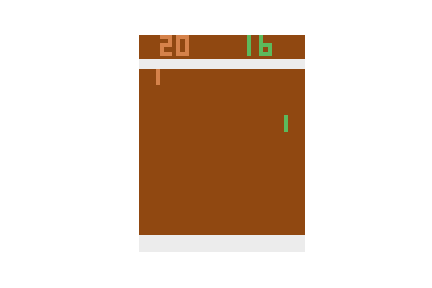
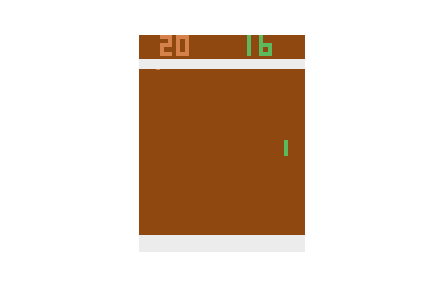
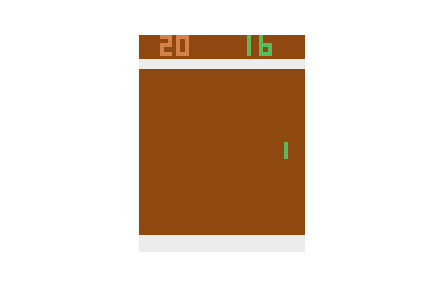
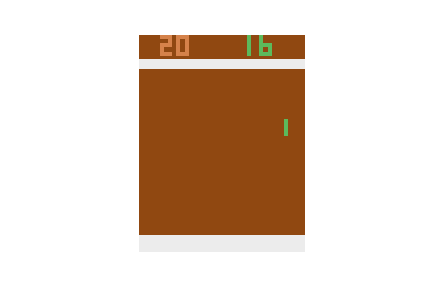
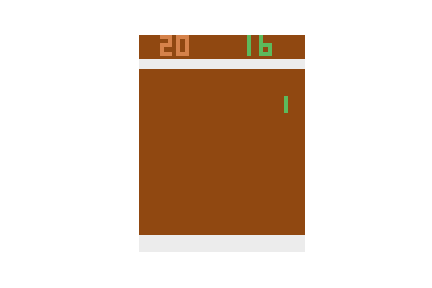
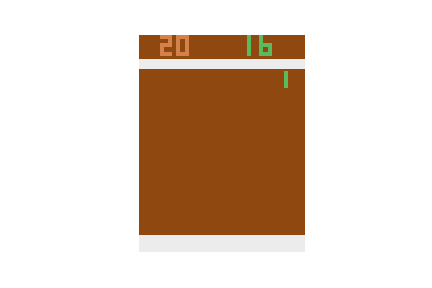
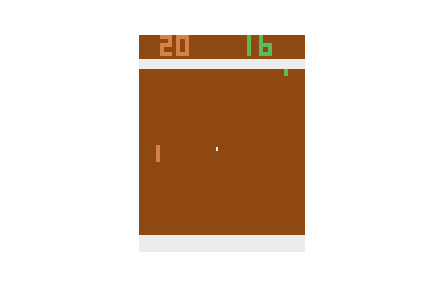
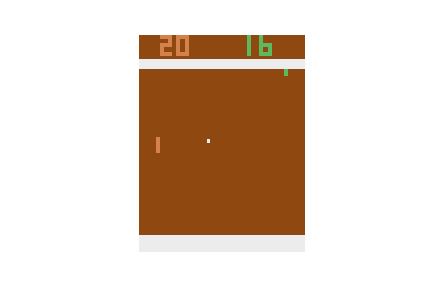
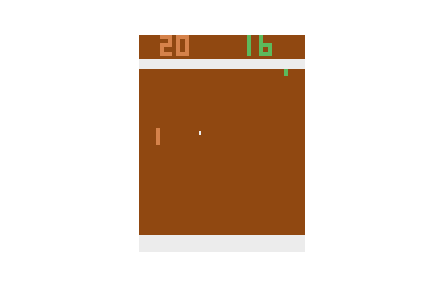
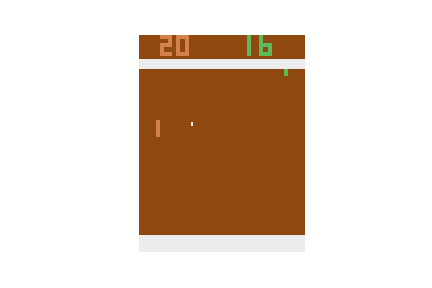
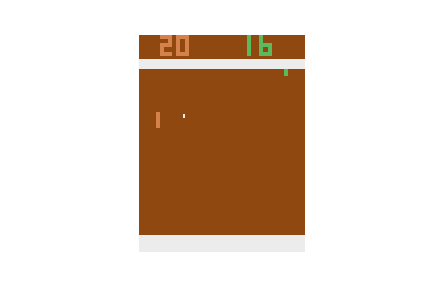
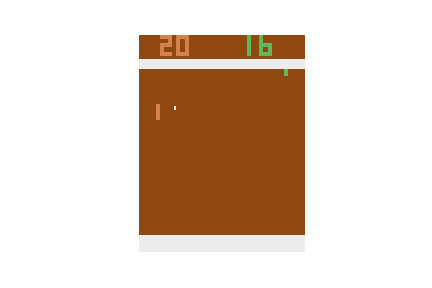
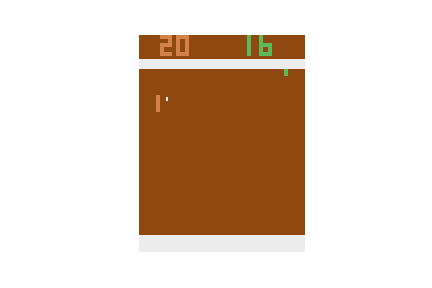
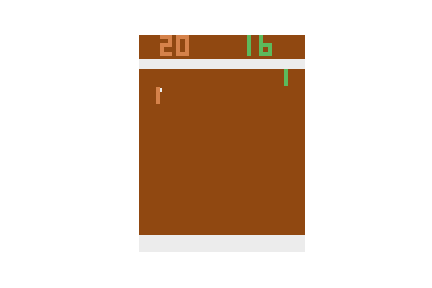
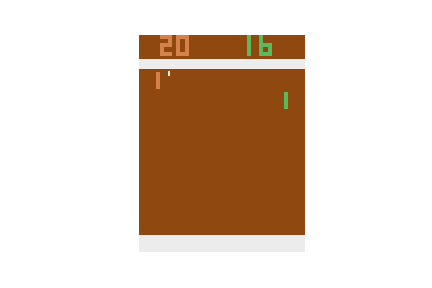
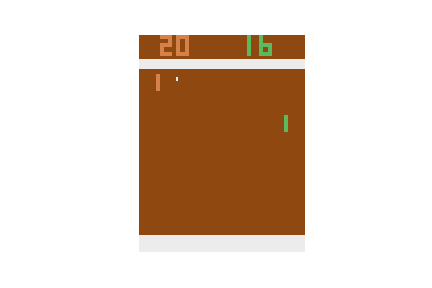
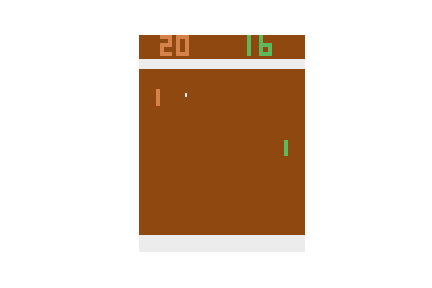
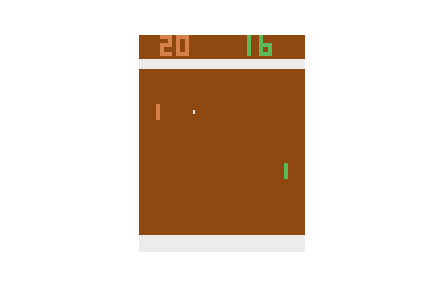
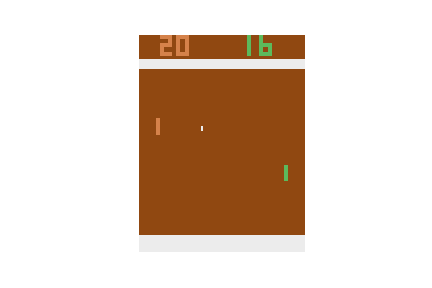
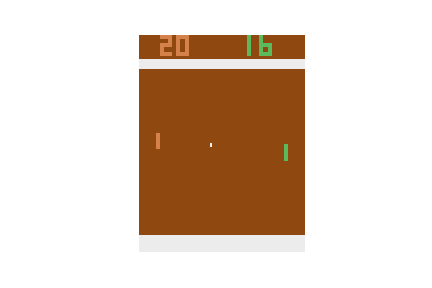
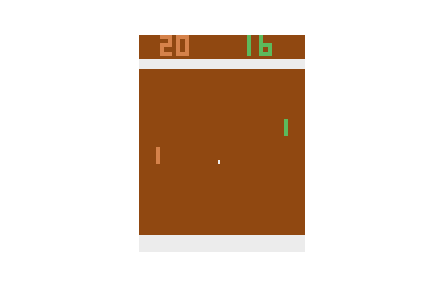
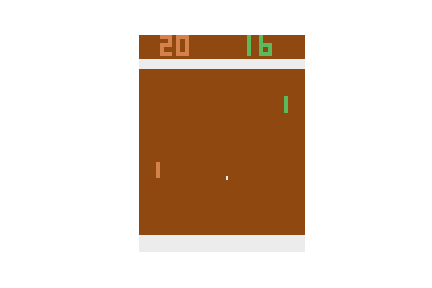
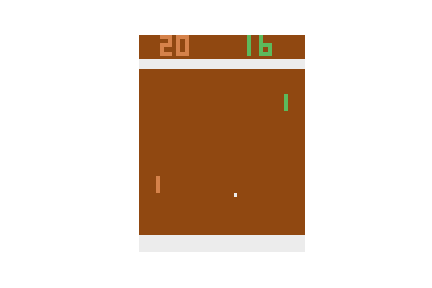
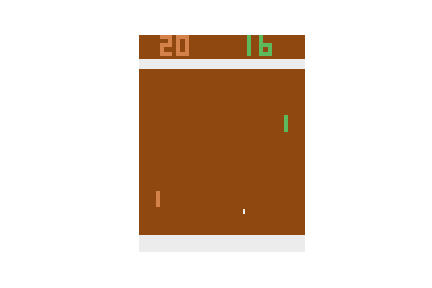
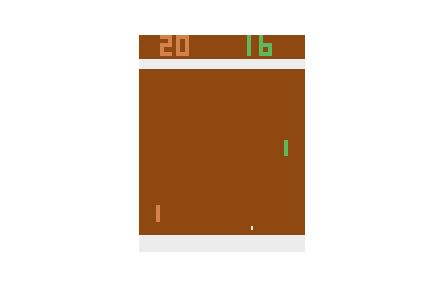
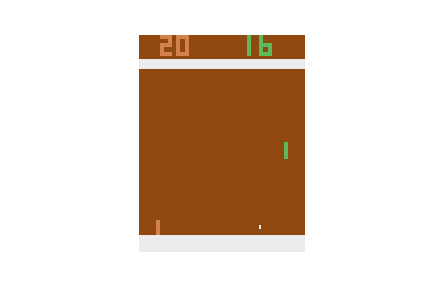
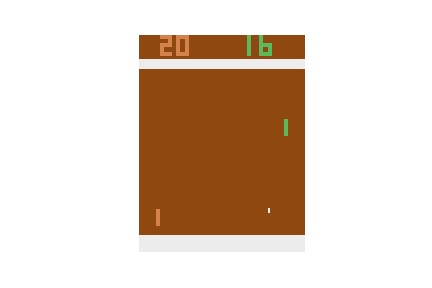
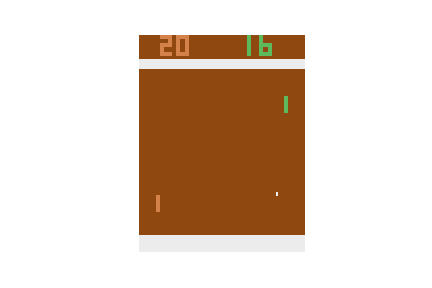
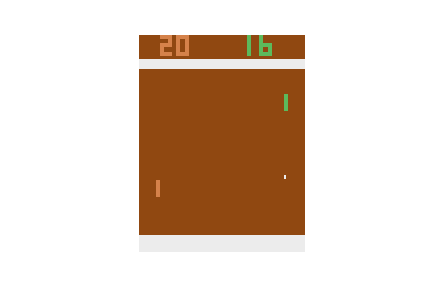
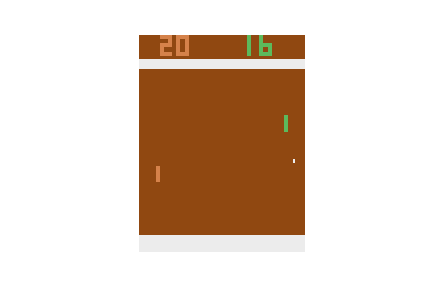
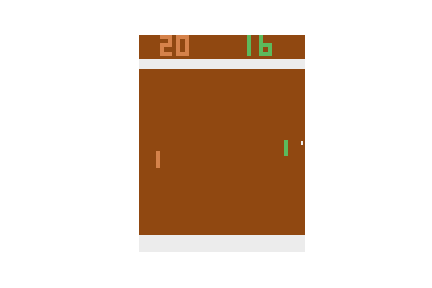

In [15]:
pong_utils.play(env, policy, time=2000) 

In [ ]:
torch.save(policy, 'PPO.policy')

In [ ]:
# policy_result = torch.load('PPO.policy')

# pong_utils.play(env, policy_result, time=2000) 